In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/gan-getting-started/monet_jpg/f4413e97bd.jpg
/kaggle/input/gan-getting-started/monet_jpg/7341d96c1d.jpg
/kaggle/input/gan-getting-started/monet_jpg/de6f71b00f.jpg
/kaggle/input/gan-getting-started/monet_jpg/99d94af5dd.jpg
/kaggle/input/gan-getting-started/monet_jpg/99a51d3e25.jpg
/kaggle/input/gan-getting-started/monet_jpg/d05cab011d.jpg
/kaggle/input/gan-getting-started/monet_jpg/4e05523825.jpg
/kaggle/input/gan-getting-started/monet_jpg/c68c52e8fc.jpg
/kaggle/input/gan-getting-started/monet_jpg/40d7d18ad3.jpg
/kaggle/input/gan-getting-started/monet_jpg/f96a8de9f3.jpg
/kaggle/input/gan-getting-started/monet_jpg/79224da51f.jpg
/kaggle/input/gan-getting-started/monet_jpg/23832dead5.jpg
/kaggle/input/gan-getting-started/monet_jpg/85580214be.jpg
/kaggle/input/gan-getting-started/monet_jpg/47a0548067.jpg
/kaggle/input/gan-getting-started/monet_jpg/fb93438ff9.jpg
/kaggle/input/gan-getting-started/monet_jpg/89d970411d.jpg
/kaggle/input/gan-getting-started/monet_jpg/7960adbd50.j

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.utils import save_image
import os
import pandas as pd
from torch.utils.data import Dataset


# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Introduction

Individual artists are identified through their unique style. This includes things such as color choice or brush strokes. 

With the advent of GNNs, we are able to imiate the style of famous artists. The purpose of this challenge is to build a GAN that generated 7,000 to 10,000 Monet-style images. Our dataset consists of 300 images of Monet paintings to work with. Below we explore some properties of these paintings. 

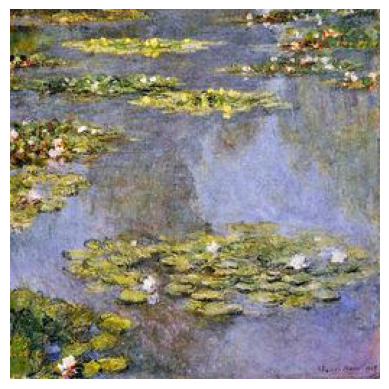

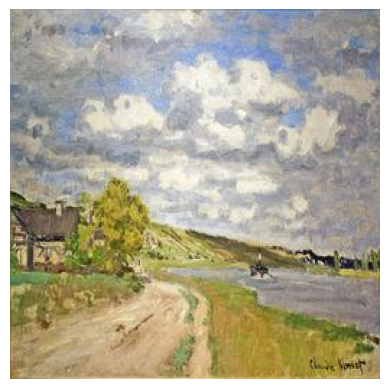

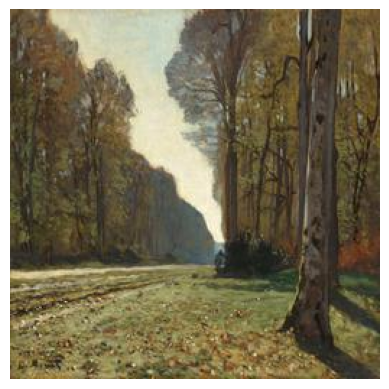

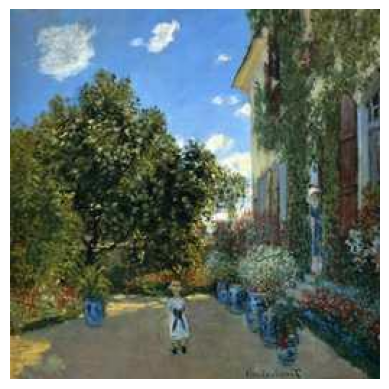

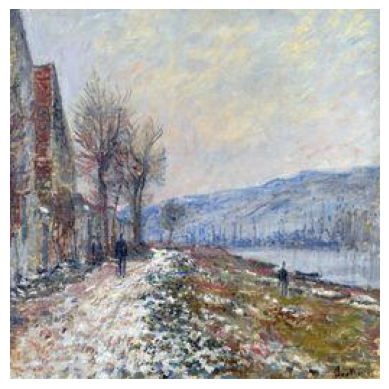

In [3]:
from PIL import Image
import os
import matplotlib.pyplot as plt
import torch
import numpy as np
import pandas as pd
from torchvision import transforms

# Define the path to the Monet jpg directory
monet_jpg_dir = r'/kaggle/input/gan-getting-started/monet_jpg'

# Function to load and display an image
def load_and_display_image(image_path):
    image = Image.open(image_path)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

# List the first few images in the directory
monet_images = os.listdir(monet_jpg_dir)[:5]

# Display sample Monet images
for image_name in monet_images:
    image_path = os.path.join(monet_jpg_dir, image_name)
    load_and_display_image(image_path)

First, I want to know some basic information about the images, such as their size. Later, I will explore the color composition and intensity of the image set of Monet-style images to identify features that make Monet paintings unique. 

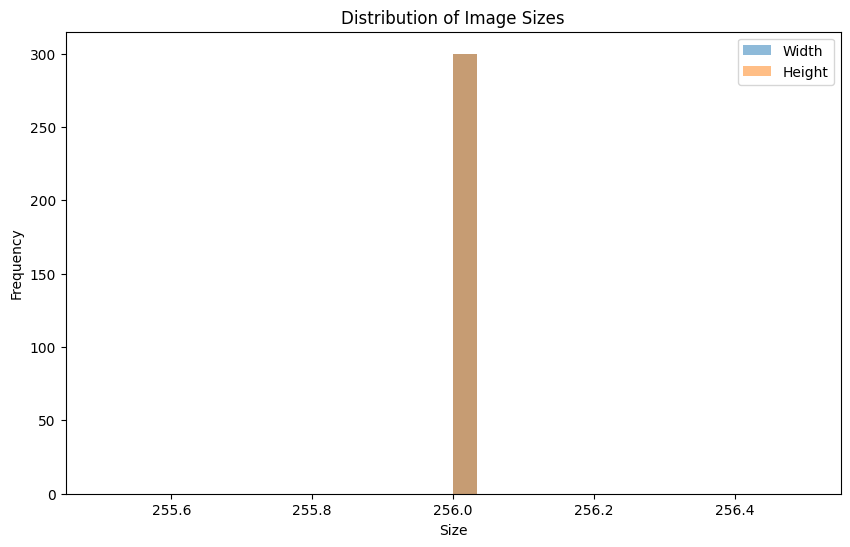

In [4]:
# Calculate basic statistics about image sizes
image_sizes = []
for image_name in os.listdir(monet_jpg_dir):
    image_path = os.path.join(monet_jpg_dir, image_name)
    with Image.open(image_path) as img:
        width, height = img.size
        image_sizes.append((width, height))

# Plot a histogram of image sizes
widths, heights = zip(*image_sizes)
plt.figure(figsize=(10, 6))
plt.hist(widths, bins=30, alpha=0.5, label='Width')
plt.hist(heights, bins=30, alpha=0.5, label='Height')
plt.title('Distribution of Image Sizes')
plt.xlabel('Size')
plt.ylabel('Frequency')
plt.legend()
plt.show()

Given that all of the images are 256 x 256, we immediately know that for training purposes this is a great resolution and no rescaling will need to be done, limiting the data preprocessing required. 

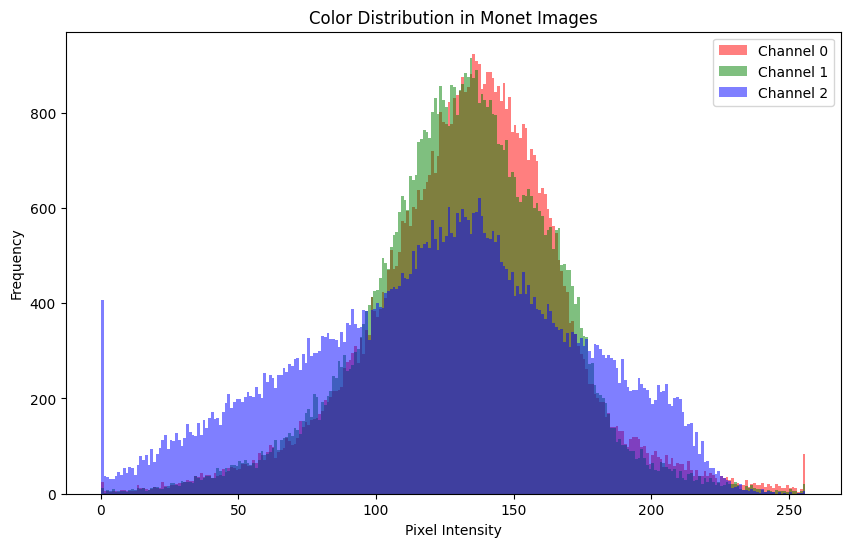

In [5]:
# Function to load an image and return it as a NumPy array
def load_image(image_path):
    with Image.open(image_path) as img:
        return np.array(img)

monet_images = [load_image(os.path.join(monet_jpg_dir, img_name)) for img_name in os.listdir(monet_jpg_dir)[:5]]

# Visualize the color distribution
colors = ['red', 'green', 'blue']
plt.figure(figsize=(10, 6))
for i, color in enumerate(colors):
    plt.hist(monet_images[0][:, :, i].ravel(), bins=256, range=[0, 256], color=color, alpha=0.5, label=f'Channel {i}')
plt.title('Color Distribution in Monet Images')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.legend()
plt.show()

From our EDA, we can see that Monet style images tend towards high intensity and helps undersstand how pixel intensities are distributed across different color channels in Monet images. 

# Model

Having read several discussions for this competition mentioned at the end of this notebook, a great model that has been used for this project is CycleGAN. This is a type of Generative Adversarial Network that will transform images from one domain into images of another domain without requiring the pairing of training data. 

This model will use two generators, Generator G and Generator F. Generator G will convert photos into the style of Monet while Generator F will convert Monet-styled images back into regular photos. 

Two discriminators are used, Discriminator A and Discriminator B. The first will determine if an image is a real photo or a fake one generated by Generator F. Similarly, Discriminator B will determine if the image is a real Monet painting or a fake one generated by Generator G. 

With this model architecture, we will be able to produce Monet style images from our photos. 

This process is computationally expensive. Thus, one of the greatest limitations in this project is the hardware and time used. Those will factor into the batch sizes, hyperparameters, and epochs used in the architecture of the model. 

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.utils import save_image
import os

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [7]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1),
            nn.InstanceNorm2d(in_channels),
            nn.ReLU(inplace=True)
        )
        
    def forward(self, x):
        return x + self.block(x)

class Generator(nn.Module):
    def __init__(self, input_channels=3, num_res_blocks=6):  # Reduced residual blocks
        super(Generator, self).__init__()
        model = [
            nn.Conv2d(input_channels, 32, kernel_size=7, stride=1, padding=3),  # Reduced initial channels
            nn.InstanceNorm2d(32),
            nn.ReLU(inplace=True)
        ]

        # Downsampling
        in_channels = 32
        for _ in range(2):
            out_channels = in_channels * 2
            model += [
                nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1),
                nn.InstanceNorm2d(out_channels),
                nn.ReLU(inplace=True)
            ]
            in_channels = out_channels

        # Residual blocks
        for _ in range(num_res_blocks):
            model += [ResidualBlock(in_channels)]

        # Upsampling
        for _ in range(2):
            out_channels = in_channels // 2
            model += [
                nn.ConvTranspose2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1),
                nn.InstanceNorm2d(out_channels),
                nn.ReLU(inplace=True)
            ]
            in_channels = out_channels

        # Output layer
        model += [
            nn.Conv2d(32, input_channels, kernel_size=7, stride=1, padding=3),
            nn.Tanh()
        ]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)

class Discriminator(nn.Module):
    def __init__(self, input_channels=3):
        super(Discriminator, self).__init__()

        model = [
            nn.Conv2d(input_channels, 32, kernel_size=4, stride=2, padding=1),  # Reduced initial channels
            nn.LeakyReLU(0.2, inplace=True)
        ]

        model += [
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True)
        ]

        model += [
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True)
        ]

        model += [
            nn.Conv2d(128, 256, kernel_size=4, padding=1),
            nn.LeakyReLU(0.2, inplace=True)
        ]

        model += [nn.Conv2d(256, 1, kernel_size=4, padding=1)]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)


In [8]:
from torch.utils.data import DataLoader
import torch.optim as optim
import os
from torchvision import transforms
from PIL import Image
from torch.utils.data import DataLoader, Dataset

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize generators and discriminators
generator_G = Generator().to(device)  # Transforms photos to Monet style
generator_F = Generator().to(device)  # Transforms Monet paintings to photo style
discriminator_A = Discriminator().to(device)  # Discriminates real vs generated photos
discriminator_B = Discriminator().to(device)  # Discriminates real vs generated Monet paintings

# Define optimizers for each generator and discriminator
optimizer_G = optim.Adam(list(generator_G.parameters()) + list(generator_F.parameters()), lr=0.0002, betas=(0.5, 0.999))
optimizer_D_A = optim.Adam(discriminator_A.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D_B = optim.Adam(discriminator_B.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Losses
criterion_GAN = nn.MSELoss()  # Adversarial loss
criterion_cycle = nn.L1Loss()  # Cycle consistency loss
criterion_identity = nn.L1Loss()  # Identity loss (optional but often helps)


# Training loop *** had to modify several times otherwise GPU ran out of memory. Limited training limits model performance *** 
num_epochs = 200
batch_size = 16

# Set path for datasets
monet_dataset_path = "/kaggle/input/gan-getting-started/monet_jpg"
photos_dataset_path = "/kaggle/input/gan-getting-started/photo_jpg"

# Define custom transforms
monet_transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize to 256x256
    transforms.ToTensor(),
])

class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.file_list = os.listdir(root_dir)

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.file_list[idx])
        image = Image.open(img_name).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image

# Define custom transforms
monet_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    # You can add more transforms here if needed
])

photos_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    # You can add more transforms here if needed
])


# Create DataLoader instance
monet_loader = DataLoader(
    CustomDataset(monet_dataset_path, transform=monet_transform),
    batch_size=batch_size, shuffle=True
)

# Repeat the same process for the photos dataset
photos_loader = DataLoader(
    CustomDataset(photos_dataset_path, transform=photos_transform),
    batch_size=batch_size, shuffle=True
)

In [9]:
from tqdm import tqdm

import os

os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb:100'

lambda_cycle = 10.0  # Weight for cycle-consistency loss.
lambda_identity = 0.5  # Weight for identity loss.

for epoch in range(num_epochs):
    for batch_idx, (batch_monet, batch_photos) in enumerate(tqdm(zip(monet_loader, photos_loader), desc=f"Epoch {epoch + 1}/{num_epochs}", position=0, leave=True)):
        
        batch_monet, batch_photos = batch_monet.to(device), batch_photos.to(device)

        

        #  Train the Generators

        optimizer_G.zero_grad()

        # Identity loss
        same_photos = generator_F(batch_photos)
        loss_identity_photos = criterion_identity(same_photos, batch_photos) * lambda_identity
        same_monet = generator_G(batch_monet)
        loss_identity_monet = criterion_identity(same_monet, batch_monet) * lambda_identity

        # GAN loss
        fake_monet = generator_G(batch_photos)
        pred_fake_monet = discriminator_B(fake_monet)
        loss_GAN_G_to_M = criterion_GAN(pred_fake_monet, torch.ones_like(pred_fake_monet))

        fake_photos = generator_F(batch_monet)
        pred_fake_photos = discriminator_A(fake_photos)
        loss_GAN_M_to_P = criterion_GAN(pred_fake_photos, torch.ones_like(pred_fake_photos))

        # Cycle loss
        recovered_photos = generator_F(fake_monet)
        loss_cycle_PMP = criterion_cycle(recovered_photos, batch_photos) * lambda_cycle
        recovered_monet = generator_G(fake_photos)
        loss_cycle_MPM = criterion_cycle(recovered_monet, batch_monet) * lambda_cycle

        # Total generator loss
        loss_G = loss_identity_photos + loss_identity_monet + loss_GAN_G_to_M + loss_GAN_M_to_P + loss_cycle_PMP + loss_cycle_MPM
        loss_G.backward()
        optimizer_G.step()

        # Train Discriminator A

        optimizer_D_A.zero_grad()

        # Real loss
        pred_real = discriminator_A(batch_photos)
        loss_D_real = criterion_GAN(pred_real, torch.ones_like(pred_real))

        # Fake loss
        pred_fake = discriminator_A(fake_photos.detach())
        loss_D_fake = criterion_GAN(pred_fake, torch.zeros_like(pred_fake))

        # Total loss
        loss_D_A = 0.5 * (loss_D_real + loss_D_fake)
        loss_D_A.backward()
        optimizer_D_A.step()

        # Train Discriminator B

        optimizer_D_B.zero_grad()

        # Real loss
        pred_real = discriminator_B(batch_monet)
        loss_D_real = criterion_GAN(pred_real, torch.ones_like(pred_real))

        # Fake loss
        pred_fake = discriminator_B(fake_monet.detach())
        loss_D_fake = criterion_GAN(pred_fake, torch.zeros_like(pred_fake))

        # Total loss
        loss_D_B = 0.5 * (loss_D_real + loss_D_fake)
        loss_D_B.backward()
        optimizer_D_B.step()

        # Print progress
        print(f"[Epoch {epoch}/{num_epochs}] [D loss: {loss_D_A.item() + loss_D_B.item()}] [G loss: {loss_G.item()}]")

Epoch 1/200: 1it [00:07,  7.19s/it]

[Epoch 0/200] [D loss: 1.0159516632556915] [G loss: 13.143735885620117]


Epoch 1/200: 2it [00:08,  3.62s/it]

[Epoch 0/200] [D loss: 0.863368809223175] [G loss: 11.206611633300781]


Epoch 1/200: 3it [00:09,  2.46s/it]

[Epoch 0/200] [D loss: 0.7121203541755676] [G loss: 8.292411804199219]


Epoch 1/200: 4it [00:10,  1.91s/it]

[Epoch 0/200] [D loss: 0.472461462020874] [G loss: 7.234672546386719]


Epoch 1/200: 5it [00:11,  1.61s/it]

[Epoch 0/200] [D loss: 0.5264779627323151] [G loss: 5.942173480987549]


Epoch 1/200: 6it [00:12,  1.42s/it]

[Epoch 0/200] [D loss: 0.5520834922790527] [G loss: 4.830723762512207]


Epoch 1/200: 7it [00:13,  1.31s/it]

[Epoch 0/200] [D loss: 0.5173920392990112] [G loss: 4.866179943084717]


Epoch 1/200: 8it [00:14,  1.24s/it]

[Epoch 0/200] [D loss: 0.6003114283084869] [G loss: 4.494097709655762]


Epoch 1/200: 9it [00:15,  1.18s/it]

[Epoch 0/200] [D loss: 0.540935218334198] [G loss: 4.351625442504883]


Epoch 1/200: 10it [00:16,  1.15s/it]

[Epoch 0/200] [D loss: 0.5996579527854919] [G loss: 3.907015800476074]


Epoch 1/200: 11it [00:17,  1.12s/it]

[Epoch 0/200] [D loss: 0.5980223119258881] [G loss: 4.134042739868164]


Epoch 1/200: 12it [00:19,  1.11s/it]

[Epoch 0/200] [D loss: 0.5816113352775574] [G loss: 3.914180278778076]


Epoch 1/200: 13it [00:20,  1.09s/it]

[Epoch 0/200] [D loss: 0.5854840874671936] [G loss: 4.015923976898193]


Epoch 1/200: 14it [00:21,  1.08s/it]

[Epoch 0/200] [D loss: 0.5822592079639435] [G loss: 4.1624884605407715]


Epoch 1/200: 15it [00:22,  1.09s/it]

[Epoch 0/200] [D loss: 0.5627760589122772] [G loss: 3.6761555671691895]


Epoch 1/200: 16it [00:23,  1.08s/it]

[Epoch 0/200] [D loss: 0.5356348752975464] [G loss: 3.9281911849975586]


Epoch 1/200: 17it [00:24,  1.08s/it]

[Epoch 0/200] [D loss: 0.5766737908124924] [G loss: 4.410404682159424]


Epoch 1/200: 18it [00:25,  1.08s/it]

[Epoch 0/200] [D loss: 0.559278815984726] [G loss: 4.058422088623047]


Epoch 1/200: 19it [00:26,  1.40s/it]


[Epoch 0/200] [D loss: 0.5362953245639801] [G loss: 3.649352550506592]


Epoch 2/200: 1it [00:01,  1.07s/it]

[Epoch 1/200] [D loss: 0.5208888947963715] [G loss: 4.000082015991211]


Epoch 2/200: 2it [00:02,  1.07s/it]

[Epoch 1/200] [D loss: 0.541581392288208] [G loss: 4.112434387207031]


Epoch 2/200: 3it [00:03,  1.07s/it]

[Epoch 1/200] [D loss: 0.5238076597452164] [G loss: 3.5259604454040527]


Epoch 2/200: 4it [00:04,  1.06s/it]

[Epoch 1/200] [D loss: 0.5343733429908752] [G loss: 3.4203124046325684]


Epoch 2/200: 5it [00:05,  1.07s/it]

[Epoch 1/200] [D loss: 0.5017962455749512] [G loss: 3.7671539783477783]


Epoch 2/200: 6it [00:06,  1.08s/it]

[Epoch 1/200] [D loss: 0.5278877913951874] [G loss: 3.6468005180358887]


Epoch 2/200: 7it [00:07,  1.07s/it]

[Epoch 1/200] [D loss: 0.5488379001617432] [G loss: 3.7628746032714844]


Epoch 2/200: 8it [00:08,  1.07s/it]

[Epoch 1/200] [D loss: 0.5439513623714447] [G loss: 3.6197609901428223]


Epoch 2/200: 9it [00:09,  1.07s/it]

[Epoch 1/200] [D loss: 0.5140445530414581] [G loss: 3.836686611175537]


Epoch 2/200: 10it [00:10,  1.07s/it]

[Epoch 1/200] [D loss: 0.5052127838134766] [G loss: 3.4878063201904297]


Epoch 2/200: 11it [00:11,  1.08s/it]

[Epoch 1/200] [D loss: 0.5211321115493774] [G loss: 3.4220094680786133]


Epoch 2/200: 12it [00:12,  1.08s/it]

[Epoch 1/200] [D loss: 0.5135042667388916] [G loss: 3.5861616134643555]


Epoch 2/200: 13it [00:13,  1.07s/it]

[Epoch 1/200] [D loss: 0.5051941722631454] [G loss: 3.552560806274414]


Epoch 2/200: 14it [00:15,  1.07s/it]

[Epoch 1/200] [D loss: 0.5473282933235168] [G loss: 3.8445777893066406]


Epoch 2/200: 15it [00:16,  1.07s/it]

[Epoch 1/200] [D loss: 0.5028384029865265] [G loss: 3.3715426921844482]


Epoch 2/200: 16it [00:17,  1.08s/it]

[Epoch 1/200] [D loss: 0.4949182868003845] [G loss: 3.704935073852539]


Epoch 2/200: 17it [00:18,  1.07s/it]

[Epoch 1/200] [D loss: 0.49481794238090515] [G loss: 3.5899620056152344]


Epoch 2/200: 18it [00:19,  1.07s/it]

[Epoch 1/200] [D loss: 0.5352453887462616] [G loss: 3.7200093269348145]


Epoch 2/200: 19it [00:20,  1.07s/it]


[Epoch 1/200] [D loss: 0.4840821772813797] [G loss: 3.050389528274536]


Epoch 3/200: 1it [00:01,  1.06s/it]

[Epoch 2/200] [D loss: 0.513201892375946] [G loss: 3.3088181018829346]


Epoch 3/200: 2it [00:02,  1.06s/it]

[Epoch 2/200] [D loss: 0.5130627155303955] [G loss: 3.3677315711975098]


Epoch 3/200: 3it [00:03,  1.07s/it]

[Epoch 2/200] [D loss: 0.5172056555747986] [G loss: 3.5427331924438477]


Epoch 3/200: 4it [00:04,  1.07s/it]

[Epoch 2/200] [D loss: 0.4907582700252533] [G loss: 3.1959948539733887]


Epoch 3/200: 5it [00:05,  1.06s/it]

[Epoch 2/200] [D loss: 0.4782068729400635] [G loss: 3.8626997470855713]


Epoch 3/200: 6it [00:06,  1.06s/it]

[Epoch 2/200] [D loss: 0.45008353888988495] [G loss: 3.4320173263549805]


Epoch 3/200: 7it [00:07,  1.06s/it]

[Epoch 2/200] [D loss: 0.5118004381656647] [G loss: 3.549344539642334]


Epoch 3/200: 8it [00:08,  1.06s/it]

[Epoch 2/200] [D loss: 0.5348305106163025] [G loss: 3.44142484664917]


Epoch 3/200: 9it [00:09,  1.06s/it]

[Epoch 2/200] [D loss: 0.5210120975971222] [G loss: 3.2467591762542725]


Epoch 3/200: 10it [00:10,  1.07s/it]

[Epoch 2/200] [D loss: 0.5440947115421295] [G loss: 3.340390682220459]


Epoch 3/200: 11it [00:11,  1.07s/it]

[Epoch 2/200] [D loss: 0.4954477846622467] [G loss: 3.3620431423187256]


Epoch 3/200: 12it [00:12,  1.06s/it]

[Epoch 2/200] [D loss: 0.4900484085083008] [G loss: 3.4440276622772217]


Epoch 3/200: 13it [00:13,  1.06s/it]

[Epoch 2/200] [D loss: 0.4891721308231354] [G loss: 3.4058594703674316]


Epoch 3/200: 14it [00:14,  1.06s/it]

[Epoch 2/200] [D loss: 0.49923473596572876] [G loss: 3.469357967376709]


Epoch 3/200: 15it [00:15,  1.06s/it]

[Epoch 2/200] [D loss: 0.5397892445325851] [G loss: 3.4560017585754395]


Epoch 3/200: 16it [00:16,  1.06s/it]

[Epoch 2/200] [D loss: 0.534413605928421] [G loss: 3.444181442260742]


Epoch 3/200: 17it [00:18,  1.06s/it]

[Epoch 2/200] [D loss: 0.5105333626270294] [G loss: 3.1679134368896484]


Epoch 3/200: 18it [00:19,  1.06s/it]

[Epoch 2/200] [D loss: 0.47669535875320435] [G loss: 3.58774471282959]


Epoch 3/200: 19it [00:20,  1.06s/it]


[Epoch 2/200] [D loss: 0.4532899856567383] [G loss: 3.340942859649658]


Epoch 4/200: 1it [00:01,  1.04s/it]

[Epoch 3/200] [D loss: 0.521405428647995] [G loss: 3.2345073223114014]


Epoch 4/200: 2it [00:02,  1.05s/it]

[Epoch 3/200] [D loss: 0.4820425510406494] [G loss: 3.047532081604004]


Epoch 4/200: 3it [00:03,  1.05s/it]

[Epoch 3/200] [D loss: 0.5129172503948212] [G loss: 3.1633877754211426]


Epoch 4/200: 4it [00:04,  1.05s/it]

[Epoch 3/200] [D loss: 0.5074693858623505] [G loss: 3.3864212036132812]


Epoch 4/200: 5it [00:05,  1.05s/it]

[Epoch 3/200] [D loss: 0.5098227858543396] [G loss: 3.2705934047698975]


Epoch 4/200: 6it [00:06,  1.06s/it]

[Epoch 3/200] [D loss: 0.51289863884449] [G loss: 3.1363868713378906]


Epoch 4/200: 7it [00:07,  1.06s/it]

[Epoch 3/200] [D loss: 0.4886292666196823] [G loss: 3.0501492023468018]


Epoch 4/200: 8it [00:08,  1.06s/it]

[Epoch 3/200] [D loss: 0.5157364308834076] [G loss: 3.0103964805603027]


Epoch 4/200: 9it [00:09,  1.06s/it]

[Epoch 3/200] [D loss: 0.5122995376586914] [G loss: 3.014698028564453]


Epoch 4/200: 10it [00:10,  1.05s/it]

[Epoch 3/200] [D loss: 0.5236421227455139] [G loss: 3.0780029296875]


Epoch 4/200: 11it [00:11,  1.06s/it]

[Epoch 3/200] [D loss: 0.48872411251068115] [G loss: 3.217332124710083]


Epoch 4/200: 12it [00:12,  1.05s/it]

[Epoch 3/200] [D loss: 0.4821430444717407] [G loss: 3.4674394130706787]


Epoch 4/200: 13it [00:13,  1.06s/it]

[Epoch 3/200] [D loss: 0.5155834257602692] [G loss: 2.974191665649414]


Epoch 4/200: 14it [00:14,  1.06s/it]

[Epoch 3/200] [D loss: 0.5076961815357208] [G loss: 3.1540300846099854]


Epoch 4/200: 15it [00:15,  1.06s/it]

[Epoch 3/200] [D loss: 0.4926125705242157] [G loss: 3.6502273082733154]


Epoch 4/200: 16it [00:16,  1.06s/it]

[Epoch 3/200] [D loss: 0.4758767634630203] [G loss: 3.3110923767089844]


Epoch 4/200: 17it [00:17,  1.06s/it]

[Epoch 3/200] [D loss: 0.4836711138486862] [G loss: 3.814699649810791]


Epoch 4/200: 18it [00:19,  1.06s/it]

[Epoch 3/200] [D loss: 0.4898339807987213] [G loss: 3.448103427886963]


Epoch 4/200: 19it [00:20,  1.06s/it]


[Epoch 3/200] [D loss: 0.5062843561172485] [G loss: 3.125197410583496]


Epoch 5/200: 1it [00:01,  1.08s/it]

[Epoch 4/200] [D loss: 0.4916878938674927] [G loss: 3.24395751953125]


Epoch 5/200: 2it [00:02,  1.06s/it]

[Epoch 4/200] [D loss: 0.50167416036129] [G loss: 3.0861902236938477]


Epoch 5/200: 3it [00:03,  1.06s/it]

[Epoch 4/200] [D loss: 0.4992997497320175] [G loss: 3.241501808166504]


Epoch 5/200: 4it [00:04,  1.06s/it]

[Epoch 4/200] [D loss: 0.5131984353065491] [G loss: 3.0387392044067383]


Epoch 5/200: 5it [00:05,  1.06s/it]

[Epoch 4/200] [D loss: 0.5070622265338898] [G loss: 3.3922507762908936]


Epoch 5/200: 6it [00:06,  1.06s/it]

[Epoch 4/200] [D loss: 0.5364354848861694] [G loss: 3.2045373916625977]


Epoch 5/200: 7it [00:07,  1.06s/it]

[Epoch 4/200] [D loss: 0.5609201490879059] [G loss: 3.629368543624878]


Epoch 5/200: 8it [00:08,  1.06s/it]

[Epoch 4/200] [D loss: 0.5034775286912918] [G loss: 3.039658546447754]


Epoch 5/200: 9it [00:09,  1.06s/it]

[Epoch 4/200] [D loss: 0.5530247986316681] [G loss: 3.091740131378174]


Epoch 5/200: 10it [00:10,  1.08s/it]

[Epoch 4/200] [D loss: 0.49675440788269043] [G loss: 3.1166036128997803]


Epoch 5/200: 11it [00:11,  1.07s/it]

[Epoch 4/200] [D loss: 0.5064477324485779] [G loss: 3.0860092639923096]


Epoch 5/200: 12it [00:12,  1.07s/it]

[Epoch 4/200] [D loss: 0.4852099120616913] [G loss: 3.0772266387939453]


Epoch 5/200: 13it [00:13,  1.06s/it]

[Epoch 4/200] [D loss: 0.527695894241333] [G loss: 2.9645674228668213]


Epoch 5/200: 14it [00:14,  1.06s/it]

[Epoch 4/200] [D loss: 0.5223508179187775] [G loss: 2.898843288421631]


Epoch 5/200: 15it [00:15,  1.06s/it]

[Epoch 4/200] [D loss: 0.5121388733386993] [G loss: 2.8059678077697754]


Epoch 5/200: 16it [00:17,  1.06s/it]

[Epoch 4/200] [D loss: 0.4825205057859421] [G loss: 3.040349006652832]


Epoch 5/200: 17it [00:18,  1.06s/it]

[Epoch 4/200] [D loss: 0.48432016372680664] [G loss: 3.15403151512146]


Epoch 5/200: 18it [00:19,  1.06s/it]

[Epoch 4/200] [D loss: 0.49985842406749725] [G loss: 2.9307708740234375]


Epoch 5/200: 19it [00:20,  1.06s/it]


[Epoch 4/200] [D loss: 0.48174794018268585] [G loss: 2.8596930503845215]


Epoch 6/200: 1it [00:01,  1.04s/it]

[Epoch 5/200] [D loss: 0.4920545071363449] [G loss: 2.940206289291382]


Epoch 6/200: 2it [00:02,  1.04s/it]

[Epoch 5/200] [D loss: 0.512800008058548] [G loss: 2.954179048538208]


Epoch 6/200: 3it [00:03,  1.05s/it]

[Epoch 5/200] [D loss: 0.4997795820236206] [G loss: 2.789355754852295]


Epoch 6/200: 4it [00:04,  1.05s/it]

[Epoch 5/200] [D loss: 0.5236032009124756] [G loss: 2.903585433959961]


Epoch 6/200: 5it [00:05,  1.06s/it]

[Epoch 5/200] [D loss: 0.47961902618408203] [G loss: 3.070779323577881]


Epoch 6/200: 6it [00:06,  1.06s/it]

[Epoch 5/200] [D loss: 0.4800378978252411] [G loss: 2.6321825981140137]


Epoch 6/200: 7it [00:07,  1.06s/it]

[Epoch 5/200] [D loss: 0.5134353041648865] [G loss: 2.805544853210449]


Epoch 6/200: 8it [00:08,  1.06s/it]

[Epoch 5/200] [D loss: 0.4971494674682617] [G loss: 3.115450859069824]


Epoch 6/200: 9it [00:09,  1.05s/it]

[Epoch 5/200] [D loss: 0.512146383523941] [G loss: 3.0801920890808105]


Epoch 6/200: 10it [00:10,  1.05s/it]

[Epoch 5/200] [D loss: 0.5298741161823273] [G loss: 3.2193968296051025]


Epoch 6/200: 11it [00:11,  1.05s/it]

[Epoch 5/200] [D loss: 0.48993411660194397] [G loss: 3.0057592391967773]


Epoch 6/200: 12it [00:12,  1.05s/it]

[Epoch 5/200] [D loss: 0.4962529242038727] [G loss: 2.9204726219177246]


Epoch 6/200: 13it [00:13,  1.06s/it]

[Epoch 5/200] [D loss: 0.4850938618183136] [G loss: 2.7246971130371094]


Epoch 6/200: 14it [00:14,  1.05s/it]

[Epoch 5/200] [D loss: 0.5019133985042572] [G loss: 2.884814977645874]


Epoch 6/200: 15it [00:15,  1.06s/it]

[Epoch 5/200] [D loss: 0.49560442566871643] [G loss: 2.9536869525909424]


Epoch 6/200: 16it [00:16,  1.06s/it]

[Epoch 5/200] [D loss: 0.48410576581954956] [G loss: 2.8911521434783936]


Epoch 6/200: 17it [00:17,  1.06s/it]

[Epoch 5/200] [D loss: 0.5036138594150543] [G loss: 2.8436436653137207]


Epoch 6/200: 18it [00:19,  1.06s/it]

[Epoch 5/200] [D loss: 0.4894731640815735] [G loss: 3.107870578765869]


Epoch 6/200: 19it [00:20,  1.06s/it]


[Epoch 5/200] [D loss: 0.4674653559923172] [G loss: 3.1772537231445312]


Epoch 7/200: 1it [00:01,  1.03s/it]

[Epoch 6/200] [D loss: 0.5170376151800156] [G loss: 3.228539228439331]


Epoch 7/200: 2it [00:02,  1.04s/it]

[Epoch 6/200] [D loss: 0.48991379141807556] [G loss: 2.8418712615966797]


Epoch 7/200: 3it [00:03,  1.04s/it]

[Epoch 6/200] [D loss: 0.5037277340888977] [G loss: 2.836564064025879]


Epoch 7/200: 4it [00:04,  1.05s/it]

[Epoch 6/200] [D loss: 0.5019446015357971] [G loss: 2.9359846115112305]


Epoch 7/200: 5it [00:05,  1.04s/it]

[Epoch 6/200] [D loss: 0.4939448833465576] [G loss: 2.7314651012420654]


Epoch 7/200: 6it [00:06,  1.04s/it]

[Epoch 6/200] [D loss: 0.48316457867622375] [G loss: 2.909514904022217]


Epoch 7/200: 7it [00:07,  1.05s/it]

[Epoch 6/200] [D loss: 0.48773616552352905] [G loss: 2.96870756149292]


Epoch 7/200: 8it [00:08,  1.04s/it]

[Epoch 6/200] [D loss: 0.49332621693611145] [G loss: 2.9526710510253906]


Epoch 7/200: 9it [00:09,  1.04s/it]

[Epoch 6/200] [D loss: 0.4987400472164154] [G loss: 3.0555365085601807]


Epoch 7/200: 10it [00:10,  1.04s/it]

[Epoch 6/200] [D loss: 0.4984090030193329] [G loss: 3.278627634048462]


Epoch 7/200: 11it [00:11,  1.05s/it]

[Epoch 6/200] [D loss: 0.5177579522132874] [G loss: 3.035832166671753]


Epoch 7/200: 12it [00:12,  1.05s/it]

[Epoch 6/200] [D loss: 0.48332086205482483] [G loss: 3.1020190715789795]


Epoch 7/200: 13it [00:13,  1.05s/it]

[Epoch 6/200] [D loss: 0.48586539924144745] [G loss: 2.8593063354492188]


Epoch 7/200: 14it [00:14,  1.05s/it]

[Epoch 6/200] [D loss: 0.5153011083602905] [G loss: 2.895297050476074]


Epoch 7/200: 15it [00:15,  1.05s/it]

[Epoch 6/200] [D loss: 0.4978281259536743] [G loss: 2.97082781791687]


Epoch 7/200: 16it [00:16,  1.04s/it]

[Epoch 6/200] [D loss: 0.543033629655838] [G loss: 3.1387288570404053]


Epoch 7/200: 17it [00:17,  1.05s/it]

[Epoch 6/200] [D loss: 0.5121176838874817] [G loss: 3.2855350971221924]


Epoch 7/200: 18it [00:18,  1.05s/it]

[Epoch 6/200] [D loss: 0.4942970871925354] [G loss: 2.721691370010376]


Epoch 7/200: 19it [00:19,  1.05s/it]


[Epoch 6/200] [D loss: 0.5155887305736542] [G loss: 2.88157320022583]


Epoch 8/200: 1it [00:01,  1.06s/it]

[Epoch 7/200] [D loss: 0.5134798884391785] [G loss: 3.0542445182800293]


Epoch 8/200: 2it [00:02,  1.05s/it]

[Epoch 7/200] [D loss: 0.4992218017578125] [G loss: 3.205991744995117]


Epoch 8/200: 3it [00:03,  1.05s/it]

[Epoch 7/200] [D loss: 0.5210946798324585] [G loss: 2.797567367553711]


Epoch 8/200: 4it [00:04,  1.06s/it]

[Epoch 7/200] [D loss: 0.49711355566978455] [G loss: 3.352449893951416]


Epoch 8/200: 5it [00:05,  1.05s/it]

[Epoch 7/200] [D loss: 0.49446190893650055] [G loss: 2.7468864917755127]


Epoch 8/200: 6it [00:06,  1.06s/it]

[Epoch 7/200] [D loss: 0.510215550661087] [G loss: 2.925192356109619]


Epoch 8/200: 7it [00:07,  1.05s/it]

[Epoch 7/200] [D loss: 0.4976598769426346] [G loss: 2.9191205501556396]


Epoch 8/200: 8it [00:08,  1.05s/it]

[Epoch 7/200] [D loss: 0.5013437718153] [G loss: 2.8388006687164307]


Epoch 8/200: 9it [00:09,  1.05s/it]

[Epoch 7/200] [D loss: 0.4838813841342926] [G loss: 2.8715949058532715]


Epoch 8/200: 10it [00:10,  1.06s/it]

[Epoch 7/200] [D loss: 0.49156756699085236] [G loss: 2.7322869300842285]


Epoch 8/200: 11it [00:11,  1.06s/it]

[Epoch 7/200] [D loss: 0.4895455688238144] [G loss: 2.7070844173431396]


Epoch 8/200: 12it [00:12,  1.05s/it]

[Epoch 7/200] [D loss: 0.483633890748024] [G loss: 2.9166102409362793]


Epoch 8/200: 13it [00:13,  1.06s/it]

[Epoch 7/200] [D loss: 0.5146001279354095] [G loss: 2.922177314758301]


Epoch 8/200: 14it [00:14,  1.05s/it]

[Epoch 7/200] [D loss: 0.503585547208786] [G loss: 2.611006259918213]


Epoch 8/200: 15it [00:15,  1.06s/it]

[Epoch 7/200] [D loss: 0.4850051999092102] [G loss: 2.870124101638794]


Epoch 8/200: 16it [00:16,  1.05s/it]

[Epoch 7/200] [D loss: 0.5011076927185059] [G loss: 2.7565150260925293]


Epoch 8/200: 17it [00:17,  1.05s/it]

[Epoch 7/200] [D loss: 0.48036445677280426] [G loss: 2.7916197776794434]


Epoch 8/200: 18it [00:18,  1.05s/it]

[Epoch 7/200] [D loss: 0.5319436192512512] [G loss: 2.766294002532959]


Epoch 8/200: 19it [00:20,  1.05s/it]


[Epoch 7/200] [D loss: 0.5129682719707489] [G loss: 2.661491870880127]


Epoch 9/200: 1it [00:01,  1.02s/it]

[Epoch 8/200] [D loss: 0.502729132771492] [G loss: 2.9753363132476807]


Epoch 9/200: 2it [00:02,  1.04s/it]

[Epoch 8/200] [D loss: 0.5119982063770294] [G loss: 3.1615514755249023]


Epoch 9/200: 3it [00:03,  1.04s/it]

[Epoch 8/200] [D loss: 0.5237601101398468] [G loss: 3.027566909790039]


Epoch 9/200: 4it [00:04,  1.05s/it]

[Epoch 8/200] [D loss: 0.5095121264457703] [G loss: 2.6291725635528564]


Epoch 9/200: 5it [00:05,  1.06s/it]

[Epoch 8/200] [D loss: 0.5135135650634766] [G loss: 2.6563329696655273]


Epoch 9/200: 6it [00:06,  1.06s/it]

[Epoch 8/200] [D loss: 0.4920575022697449] [G loss: 2.8959736824035645]


Epoch 9/200: 7it [00:07,  1.05s/it]

[Epoch 8/200] [D loss: 0.49565844237804413] [G loss: 2.6681840419769287]


Epoch 9/200: 8it [00:08,  1.05s/it]

[Epoch 8/200] [D loss: 0.4977130591869354] [G loss: 2.658874034881592]


Epoch 9/200: 9it [00:09,  1.04s/it]

[Epoch 8/200] [D loss: 0.5126048624515533] [G loss: 2.724644660949707]


Epoch 9/200: 10it [00:10,  1.04s/it]

[Epoch 8/200] [D loss: 0.47988763451576233] [G loss: 2.950263023376465]


Epoch 9/200: 11it [00:11,  1.04s/it]

[Epoch 8/200] [D loss: 0.502944141626358] [G loss: 2.8499538898468018]


Epoch 9/200: 12it [00:12,  1.04s/it]

[Epoch 8/200] [D loss: 0.49478432536125183] [G loss: 2.7319562435150146]


Epoch 9/200: 13it [00:13,  1.04s/it]

[Epoch 8/200] [D loss: 0.5033419728279114] [G loss: 2.6016602516174316]


Epoch 9/200: 14it [00:14,  1.05s/it]

[Epoch 8/200] [D loss: 0.5008974373340607] [G loss: 3.071596145629883]


Epoch 9/200: 15it [00:15,  1.06s/it]

[Epoch 8/200] [D loss: 0.49746236205101013] [G loss: 2.905747652053833]


Epoch 9/200: 16it [00:16,  1.06s/it]

[Epoch 8/200] [D loss: 0.49364177882671356] [G loss: 2.6917724609375]


Epoch 9/200: 17it [00:17,  1.05s/it]

[Epoch 8/200] [D loss: 0.48603373765945435] [G loss: 2.977509021759033]


Epoch 9/200: 18it [00:18,  1.06s/it]

[Epoch 8/200] [D loss: 0.4916331022977829] [G loss: 2.872044563293457]


Epoch 9/200: 19it [00:19,  1.05s/it]


[Epoch 8/200] [D loss: 0.5133630037307739] [G loss: 2.6661810874938965]


Epoch 10/200: 1it [00:01,  1.09s/it]

[Epoch 9/200] [D loss: 0.4869596064090729] [G loss: 2.7587289810180664]


Epoch 10/200: 2it [00:02,  1.05s/it]

[Epoch 9/200] [D loss: 0.5050651282072067] [G loss: 3.01655650138855]


Epoch 10/200: 3it [00:03,  1.06s/it]

[Epoch 9/200] [D loss: 0.49133843183517456] [G loss: 2.8228237628936768]


Epoch 10/200: 4it [00:04,  1.05s/it]

[Epoch 9/200] [D loss: 0.4847528338432312] [G loss: 2.855376720428467]


Epoch 10/200: 5it [00:05,  1.05s/it]

[Epoch 9/200] [D loss: 0.510843425989151] [G loss: 2.829749584197998]


Epoch 10/200: 6it [00:06,  1.04s/it]

[Epoch 9/200] [D loss: 0.49899742007255554] [G loss: 2.5837862491607666]


Epoch 10/200: 7it [00:07,  1.05s/it]

[Epoch 9/200] [D loss: 0.49940887093544006] [G loss: 2.9130373001098633]


Epoch 10/200: 8it [00:08,  1.05s/it]

[Epoch 9/200] [D loss: 0.4913434088230133] [G loss: 3.140542984008789]


Epoch 10/200: 9it [00:09,  1.04s/it]

[Epoch 9/200] [D loss: 0.4997455030679703] [G loss: 3.171318531036377]


Epoch 10/200: 10it [00:10,  1.04s/it]

[Epoch 9/200] [D loss: 0.5121211111545563] [G loss: 2.7602949142456055]


Epoch 10/200: 11it [00:11,  1.08s/it]

[Epoch 9/200] [D loss: 0.5425913631916046] [G loss: 3.035203695297241]


Epoch 10/200: 12it [00:12,  1.06s/it]

[Epoch 9/200] [D loss: 0.4969387352466583] [G loss: 3.110126495361328]


Epoch 10/200: 13it [00:13,  1.06s/it]

[Epoch 9/200] [D loss: 0.5346843600273132] [G loss: 2.798480987548828]


Epoch 10/200: 14it [00:14,  1.05s/it]

[Epoch 9/200] [D loss: 0.5087340772151947] [G loss: 2.6439692974090576]


Epoch 10/200: 15it [00:15,  1.05s/it]

[Epoch 9/200] [D loss: 0.4965037703514099] [G loss: 2.7726969718933105]


Epoch 10/200: 16it [00:16,  1.04s/it]

[Epoch 9/200] [D loss: 0.5135225653648376] [G loss: 2.5222673416137695]


Epoch 10/200: 17it [00:17,  1.04s/it]

[Epoch 9/200] [D loss: 0.49094411730766296] [G loss: 3.0362706184387207]


Epoch 10/200: 18it [00:18,  1.05s/it]

[Epoch 9/200] [D loss: 0.49692416191101074] [G loss: 2.641045331954956]


Epoch 10/200: 19it [00:19,  1.05s/it]


[Epoch 9/200] [D loss: 0.4869430810213089] [G loss: 2.6290061473846436]


Epoch 11/200: 1it [00:01,  1.04s/it]

[Epoch 10/200] [D loss: 0.4918930232524872] [G loss: 2.7295217514038086]


Epoch 11/200: 2it [00:02,  1.04s/it]

[Epoch 10/200] [D loss: 0.48423701524734497] [G loss: 2.8448619842529297]


Epoch 11/200: 3it [00:03,  1.05s/it]

[Epoch 10/200] [D loss: 0.5129029154777527] [G loss: 3.3965463638305664]


Epoch 11/200: 4it [00:04,  1.04s/it]

[Epoch 10/200] [D loss: 0.504366546869278] [G loss: 2.562568187713623]


Epoch 11/200: 5it [00:05,  1.04s/it]

[Epoch 10/200] [D loss: 0.5009251981973648] [G loss: 3.0459794998168945]


Epoch 11/200: 6it [00:06,  1.04s/it]

[Epoch 10/200] [D loss: 0.49300122261047363] [G loss: 3.222799301147461]


Epoch 11/200: 7it [00:07,  1.05s/it]

[Epoch 10/200] [D loss: 0.5116795301437378] [G loss: 2.737827777862549]


Epoch 11/200: 8it [00:08,  1.04s/it]

[Epoch 10/200] [D loss: 0.49606093764305115] [G loss: 2.9085936546325684]


Epoch 11/200: 9it [00:09,  1.05s/it]

[Epoch 10/200] [D loss: 0.4842558205127716] [G loss: 2.8749582767486572]


Epoch 11/200: 10it [00:10,  1.05s/it]

[Epoch 10/200] [D loss: 0.48422038555145264] [G loss: 2.667056083679199]


Epoch 11/200: 11it [00:11,  1.05s/it]

[Epoch 10/200] [D loss: 0.485318124294281] [G loss: 2.7500081062316895]


Epoch 11/200: 12it [00:12,  1.05s/it]

[Epoch 10/200] [D loss: 0.490207776427269] [G loss: 2.822218418121338]


Epoch 11/200: 13it [00:13,  1.05s/it]

[Epoch 10/200] [D loss: 0.5078263580799103] [G loss: 2.8204903602600098]


Epoch 11/200: 14it [00:14,  1.05s/it]

[Epoch 10/200] [D loss: 0.49488599598407745] [G loss: 2.8788881301879883]


Epoch 11/200: 15it [00:15,  1.05s/it]

[Epoch 10/200] [D loss: 0.5037720799446106] [G loss: 2.906914710998535]


Epoch 11/200: 16it [00:16,  1.05s/it]

[Epoch 10/200] [D loss: 0.4915594458580017] [G loss: 2.8413143157958984]


Epoch 11/200: 17it [00:17,  1.05s/it]

[Epoch 10/200] [D loss: 0.48615680634975433] [G loss: 2.8116002082824707]


Epoch 11/200: 18it [00:18,  1.04s/it]

[Epoch 10/200] [D loss: 0.49285128712654114] [G loss: 2.7268943786621094]


Epoch 11/200: 19it [00:19,  1.05s/it]


[Epoch 10/200] [D loss: 0.5125122666358948] [G loss: 2.720755100250244]


Epoch 12/200: 1it [00:01,  1.04s/it]

[Epoch 11/200] [D loss: 0.49782902002334595] [G loss: 2.5583086013793945]


Epoch 12/200: 2it [00:02,  1.03s/it]

[Epoch 11/200] [D loss: 0.4910624921321869] [G loss: 2.8323497772216797]


Epoch 12/200: 3it [00:03,  1.03s/it]

[Epoch 11/200] [D loss: 0.4892973303794861] [G loss: 2.6538822650909424]


Epoch 12/200: 4it [00:04,  1.03s/it]

[Epoch 11/200] [D loss: 0.47759386897087097] [G loss: 2.698662281036377]


Epoch 12/200: 5it [00:05,  1.04s/it]

[Epoch 11/200] [D loss: 0.49102702736854553] [G loss: 2.668670415878296]


Epoch 12/200: 6it [00:06,  1.03s/it]

[Epoch 11/200] [D loss: 0.5013143718242645] [G loss: 2.6505916118621826]


Epoch 12/200: 7it [00:07,  1.03s/it]

[Epoch 11/200] [D loss: 0.48478081822395325] [G loss: 2.860722541809082]


Epoch 12/200: 8it [00:08,  1.04s/it]

[Epoch 11/200] [D loss: 0.518532931804657] [G loss: 2.608428478240967]


Epoch 12/200: 9it [00:09,  1.03s/it]

[Epoch 11/200] [D loss: 0.5019460767507553] [G loss: 2.8807532787323]


Epoch 12/200: 10it [00:10,  1.03s/it]

[Epoch 11/200] [D loss: 0.5054958164691925] [G loss: 2.913205623626709]


Epoch 12/200: 11it [00:11,  1.04s/it]

[Epoch 11/200] [D loss: 0.4916740506887436] [G loss: 2.651592254638672]


Epoch 12/200: 12it [00:12,  1.04s/it]

[Epoch 11/200] [D loss: 0.516278862953186] [G loss: 2.5774996280670166]


Epoch 12/200: 13it [00:13,  1.05s/it]

[Epoch 11/200] [D loss: 0.5088655948638916] [G loss: 2.5746493339538574]


Epoch 12/200: 14it [00:14,  1.05s/it]

[Epoch 11/200] [D loss: 0.5041930973529816] [G loss: 3.08829402923584]


Epoch 12/200: 15it [00:15,  1.06s/it]

[Epoch 11/200] [D loss: 0.5015841573476791] [G loss: 2.7452144622802734]


Epoch 12/200: 16it [00:16,  1.06s/it]

[Epoch 11/200] [D loss: 0.4868209958076477] [G loss: 2.703089714050293]


Epoch 12/200: 17it [00:17,  1.05s/it]

[Epoch 11/200] [D loss: 0.49857962131500244] [G loss: 2.8449490070343018]


Epoch 12/200: 18it [00:18,  1.06s/it]

[Epoch 11/200] [D loss: 0.5022922456264496] [G loss: 2.796238422393799]


Epoch 12/200: 19it [00:19,  1.04s/it]


[Epoch 11/200] [D loss: 0.5054262280464172] [G loss: 2.76436710357666]


Epoch 13/200: 1it [00:01,  1.08s/it]

[Epoch 12/200] [D loss: 0.485813245177269] [G loss: 2.705552577972412]


Epoch 13/200: 2it [00:02,  1.06s/it]

[Epoch 12/200] [D loss: 0.5027332305908203] [G loss: 2.7572240829467773]


Epoch 13/200: 3it [00:03,  1.06s/it]

[Epoch 12/200] [D loss: 0.5136659443378448] [G loss: 3.024463176727295]


Epoch 13/200: 4it [00:04,  1.05s/it]

[Epoch 12/200] [D loss: 0.5001325905323029] [G loss: 2.685457229614258]


Epoch 13/200: 5it [00:05,  1.04s/it]

[Epoch 12/200] [D loss: 0.4864680767059326] [G loss: 2.9102532863616943]


Epoch 13/200: 6it [00:06,  1.04s/it]

[Epoch 12/200] [D loss: 0.48780812323093414] [G loss: 2.998619318008423]


Epoch 13/200: 7it [00:07,  1.04s/it]

[Epoch 12/200] [D loss: 0.47726336121559143] [G loss: 2.925825834274292]


Epoch 13/200: 8it [00:08,  1.04s/it]

[Epoch 12/200] [D loss: 0.49970728158950806] [G loss: 2.7699289321899414]


Epoch 13/200: 9it [00:09,  1.04s/it]

[Epoch 12/200] [D loss: 0.49642644822597504] [G loss: 2.5827865600585938]


Epoch 13/200: 10it [00:10,  1.04s/it]

[Epoch 12/200] [D loss: 0.5036137402057648] [G loss: 2.611191511154175]


Epoch 13/200: 11it [00:11,  1.04s/it]

[Epoch 12/200] [D loss: 0.49688178300857544] [G loss: 2.687629461288452]


Epoch 13/200: 12it [00:12,  1.05s/it]

[Epoch 12/200] [D loss: 0.5075801759958267] [G loss: 2.530735731124878]


Epoch 13/200: 13it [00:13,  1.04s/it]

[Epoch 12/200] [D loss: 0.5117630809545517] [G loss: 2.7775628566741943]


Epoch 13/200: 14it [00:14,  1.05s/it]

[Epoch 12/200] [D loss: 0.5125700831413269] [G loss: 2.8888185024261475]


Epoch 13/200: 15it [00:15,  1.06s/it]

[Epoch 12/200] [D loss: 0.49303291738033295] [G loss: 2.9680285453796387]


Epoch 13/200: 16it [00:16,  1.05s/it]

[Epoch 12/200] [D loss: 0.48590511083602905] [G loss: 2.977088689804077]


Epoch 13/200: 17it [00:17,  1.05s/it]

[Epoch 12/200] [D loss: 0.47529663145542145] [G loss: 2.682870864868164]


Epoch 13/200: 18it [00:18,  1.05s/it]

[Epoch 12/200] [D loss: 0.5017386972904205] [G loss: 2.7164626121520996]


Epoch 13/200: 19it [00:19,  1.05s/it]


[Epoch 12/200] [D loss: 0.5015266090631485] [G loss: 2.709195852279663]


Epoch 14/200: 1it [00:01,  1.03s/it]

[Epoch 13/200] [D loss: 0.4856337159872055] [G loss: 2.832550287246704]


Epoch 14/200: 2it [00:02,  1.06s/it]

[Epoch 13/200] [D loss: 0.5156843066215515] [G loss: 2.911888360977173]


Epoch 14/200: 3it [00:03,  1.07s/it]

[Epoch 13/200] [D loss: 0.4942767024040222] [G loss: 2.8453469276428223]


Epoch 14/200: 4it [00:04,  1.05s/it]

[Epoch 13/200] [D loss: 0.494415819644928] [G loss: 2.682183265686035]


Epoch 14/200: 5it [00:05,  1.04s/it]

[Epoch 13/200] [D loss: 0.49110013246536255] [G loss: 2.375668525695801]


Epoch 14/200: 6it [00:06,  1.04s/it]

[Epoch 13/200] [D loss: 0.5064840912818909] [G loss: 2.8110618591308594]


Epoch 14/200: 7it [00:07,  1.04s/it]

[Epoch 13/200] [D loss: 0.5027822554111481] [G loss: 2.4904558658599854]


Epoch 14/200: 8it [00:08,  1.04s/it]

[Epoch 13/200] [D loss: 0.4989856481552124] [G loss: 2.92575740814209]


Epoch 14/200: 9it [00:09,  1.06s/it]

[Epoch 13/200] [D loss: 0.5093977600336075] [G loss: 2.701910972595215]


Epoch 14/200: 10it [00:10,  1.07s/it]

[Epoch 13/200] [D loss: 0.5101832449436188] [G loss: 2.648569345474243]


Epoch 14/200: 11it [00:11,  1.07s/it]

[Epoch 13/200] [D loss: 0.4946502149105072] [G loss: 2.690044641494751]


Epoch 14/200: 12it [00:12,  1.05s/it]

[Epoch 13/200] [D loss: 0.4955365061759949] [G loss: 2.9256086349487305]


Epoch 14/200: 13it [00:13,  1.05s/it]

[Epoch 13/200] [D loss: 0.5048131346702576] [G loss: 2.425933361053467]


Epoch 14/200: 14it [00:14,  1.05s/it]

[Epoch 13/200] [D loss: 0.48615308105945587] [G loss: 2.8701834678649902]


Epoch 14/200: 15it [00:15,  1.05s/it]

[Epoch 13/200] [D loss: 0.4915032684803009] [G loss: 2.5986645221710205]


Epoch 14/200: 16it [00:16,  1.06s/it]

[Epoch 13/200] [D loss: 0.5015573799610138] [G loss: 2.5916624069213867]


Epoch 14/200: 17it [00:17,  1.06s/it]

[Epoch 13/200] [D loss: 0.49600160121917725] [G loss: 2.6086647510528564]


Epoch 14/200: 18it [00:18,  1.05s/it]

[Epoch 13/200] [D loss: 0.4916866570711136] [G loss: 2.737691879272461]


Epoch 14/200: 19it [00:19,  1.05s/it]


[Epoch 13/200] [D loss: 0.4906444251537323] [G loss: 2.73001766204834]


Epoch 15/200: 1it [00:01,  1.02s/it]

[Epoch 14/200] [D loss: 0.4956006109714508] [G loss: 2.7867884635925293]


Epoch 15/200: 2it [00:02,  1.03s/it]

[Epoch 14/200] [D loss: 0.48391053080558777] [G loss: 2.489907741546631]


Epoch 15/200: 3it [00:03,  1.04s/it]

[Epoch 14/200] [D loss: 0.4893183410167694] [G loss: 2.7599716186523438]


Epoch 15/200: 4it [00:04,  1.05s/it]

[Epoch 14/200] [D loss: 0.4718373864889145] [G loss: 2.589646816253662]


Epoch 15/200: 5it [00:05,  1.04s/it]

[Epoch 14/200] [D loss: 0.47325921058654785] [G loss: 2.571823835372925]


Epoch 15/200: 6it [00:06,  1.05s/it]

[Epoch 14/200] [D loss: 0.5028018057346344] [G loss: 2.6063199043273926]


Epoch 15/200: 7it [00:07,  1.04s/it]

[Epoch 14/200] [D loss: 0.5065735280513763] [G loss: 2.7594735622406006]


Epoch 15/200: 8it [00:08,  1.05s/it]

[Epoch 14/200] [D loss: 0.48572805523872375] [G loss: 2.616508960723877]


Epoch 15/200: 9it [00:09,  1.05s/it]

[Epoch 14/200] [D loss: 0.4945606142282486] [G loss: 2.559788703918457]


Epoch 15/200: 10it [00:10,  1.05s/it]

[Epoch 14/200] [D loss: 0.5000426471233368] [G loss: 2.6776442527770996]


Epoch 15/200: 11it [00:11,  1.05s/it]

[Epoch 14/200] [D loss: 0.4957793951034546] [G loss: 2.6227171421051025]


Epoch 15/200: 12it [00:12,  1.05s/it]

[Epoch 14/200] [D loss: 0.48664170503616333] [G loss: 2.6874194145202637]


Epoch 15/200: 13it [00:13,  1.04s/it]

[Epoch 14/200] [D loss: 0.48003822565078735] [G loss: 2.526949882507324]


Epoch 15/200: 14it [00:14,  1.05s/it]

[Epoch 14/200] [D loss: 0.5217862129211426] [G loss: 2.7735679149627686]


Epoch 15/200: 15it [00:15,  1.04s/it]

[Epoch 14/200] [D loss: 0.5057736337184906] [G loss: 3.246436595916748]


Epoch 15/200: 16it [00:16,  1.05s/it]

[Epoch 14/200] [D loss: 0.49283909797668457] [G loss: 2.687832832336426]


Epoch 15/200: 17it [00:17,  1.04s/it]

[Epoch 14/200] [D loss: 0.4860629439353943] [G loss: 2.5694851875305176]


Epoch 15/200: 18it [00:18,  1.03s/it]

[Epoch 14/200] [D loss: 0.4823441654443741] [G loss: 2.9050214290618896]


Epoch 15/200: 19it [00:19,  1.04s/it]


[Epoch 14/200] [D loss: 0.48831722140312195] [G loss: 2.768932342529297]


Epoch 16/200: 1it [00:01,  1.04s/it]

[Epoch 15/200] [D loss: 0.48853012919425964] [G loss: 2.807204246520996]


Epoch 16/200: 2it [00:02,  1.05s/it]

[Epoch 15/200] [D loss: 0.5028731524944305] [G loss: 2.6200270652770996]


Epoch 16/200: 3it [00:03,  1.05s/it]

[Epoch 15/200] [D loss: 0.49738189578056335] [G loss: 2.862194538116455]


Epoch 16/200: 4it [00:04,  1.04s/it]

[Epoch 15/200] [D loss: 0.5257474184036255] [G loss: 2.5565574169158936]


Epoch 16/200: 5it [00:05,  1.03s/it]

[Epoch 15/200] [D loss: 0.5008775591850281] [G loss: 2.668400287628174]


Epoch 16/200: 6it [00:06,  1.03s/it]

[Epoch 15/200] [D loss: 0.49489083886146545] [G loss: 2.5343735218048096]


Epoch 16/200: 7it [00:07,  1.04s/it]

[Epoch 15/200] [D loss: 0.48876097798347473] [G loss: 2.757542371749878]


Epoch 16/200: 8it [00:08,  1.04s/it]

[Epoch 15/200] [D loss: 0.5307902991771698] [G loss: 2.5487422943115234]


Epoch 16/200: 9it [00:09,  1.03s/it]

[Epoch 15/200] [D loss: 0.5430104732513428] [G loss: 2.705411434173584]


Epoch 16/200: 10it [00:10,  1.03s/it]

[Epoch 15/200] [D loss: 0.5287185162305832] [G loss: 2.857847213745117]


Epoch 16/200: 11it [00:11,  1.03s/it]

[Epoch 15/200] [D loss: 0.5237425863742828] [G loss: 2.493173360824585]


Epoch 16/200: 12it [00:12,  1.02s/it]

[Epoch 15/200] [D loss: 0.5333373546600342] [G loss: 2.8352549076080322]


Epoch 16/200: 13it [00:13,  1.03s/it]

[Epoch 15/200] [D loss: 0.48905377089977264] [G loss: 2.548828601837158]


Epoch 16/200: 14it [00:14,  1.03s/it]

[Epoch 15/200] [D loss: 0.490458607673645] [G loss: 2.6249074935913086]


Epoch 16/200: 15it [00:15,  1.04s/it]

[Epoch 15/200] [D loss: 0.5000555515289307] [G loss: 2.7651827335357666]


Epoch 16/200: 16it [00:16,  1.03s/it]

[Epoch 15/200] [D loss: 0.5352028608322144] [G loss: 2.7593657970428467]


Epoch 16/200: 17it [00:17,  1.04s/it]

[Epoch 15/200] [D loss: 0.5393096804618835] [G loss: 2.756120204925537]


Epoch 16/200: 18it [00:18,  1.05s/it]

[Epoch 15/200] [D loss: 0.491592600941658] [G loss: 2.726325511932373]


Epoch 16/200: 19it [00:19,  1.04s/it]


[Epoch 15/200] [D loss: 0.4853019714355469] [G loss: 2.788940191268921]


Epoch 17/200: 1it [00:01,  1.03s/it]

[Epoch 16/200] [D loss: 0.48785631358623505] [G loss: 2.5860283374786377]


Epoch 17/200: 2it [00:02,  1.03s/it]

[Epoch 16/200] [D loss: 0.472729817032814] [G loss: 2.667020320892334]


Epoch 17/200: 3it [00:03,  1.04s/it]

[Epoch 16/200] [D loss: 0.4929504841566086] [G loss: 2.7151293754577637]


Epoch 17/200: 4it [00:04,  1.04s/it]

[Epoch 16/200] [D loss: 0.5093275904655457] [G loss: 3.065408229827881]


Epoch 17/200: 5it [00:05,  1.04s/it]

[Epoch 16/200] [D loss: 0.4874271750450134] [G loss: 2.5884323120117188]


Epoch 17/200: 6it [00:06,  1.04s/it]

[Epoch 16/200] [D loss: 0.5037765800952911] [G loss: 2.440016269683838]


Epoch 17/200: 7it [00:07,  1.04s/it]

[Epoch 16/200] [D loss: 0.5191203951835632] [G loss: 2.632265090942383]


Epoch 17/200: 8it [00:08,  1.04s/it]

[Epoch 16/200] [D loss: 0.49140530824661255] [G loss: 2.8004064559936523]


Epoch 17/200: 9it [00:09,  1.04s/it]

[Epoch 16/200] [D loss: 0.504847377538681] [G loss: 2.5934691429138184]


Epoch 17/200: 10it [00:10,  1.04s/it]

[Epoch 16/200] [D loss: 0.4926273375749588] [G loss: 2.597539186477661]


Epoch 17/200: 11it [00:11,  1.04s/it]

[Epoch 16/200] [D loss: 0.4881324768066406] [G loss: 2.660233497619629]


Epoch 17/200: 12it [00:12,  1.05s/it]

[Epoch 16/200] [D loss: 0.47962266206741333] [G loss: 2.5029349327087402]


Epoch 17/200: 13it [00:13,  1.05s/it]

[Epoch 16/200] [D loss: 0.4944101423025131] [G loss: 2.7229816913604736]


Epoch 17/200: 14it [00:14,  1.05s/it]

[Epoch 16/200] [D loss: 0.49424293637275696] [G loss: 2.36360502243042]


Epoch 17/200: 15it [00:15,  1.05s/it]

[Epoch 16/200] [D loss: 0.4876565486192703] [G loss: 2.3641774654388428]


Epoch 17/200: 16it [00:16,  1.04s/it]

[Epoch 16/200] [D loss: 0.4933817982673645] [G loss: 2.624800205230713]


Epoch 17/200: 17it [00:17,  1.04s/it]

[Epoch 16/200] [D loss: 0.47278590500354767] [G loss: 2.562577724456787]


Epoch 17/200: 18it [00:18,  1.05s/it]

[Epoch 16/200] [D loss: 0.5021859407424927] [G loss: 2.7003564834594727]


Epoch 17/200: 19it [00:19,  1.05s/it]


[Epoch 16/200] [D loss: 0.4998379051685333] [G loss: 2.7140421867370605]


Epoch 18/200: 1it [00:01,  1.04s/it]

[Epoch 17/200] [D loss: 0.4874761700630188] [G loss: 2.5505459308624268]


Epoch 18/200: 2it [00:02,  1.05s/it]

[Epoch 17/200] [D loss: 0.482683002948761] [G loss: 2.6703548431396484]


Epoch 18/200: 3it [00:03,  1.06s/it]

[Epoch 17/200] [D loss: 0.49029630422592163] [G loss: 2.485921621322632]


Epoch 18/200: 4it [00:04,  1.05s/it]

[Epoch 17/200] [D loss: 0.49021685123443604] [G loss: 2.618821144104004]


Epoch 18/200: 5it [00:05,  1.04s/it]

[Epoch 17/200] [D loss: 0.48831960558891296] [G loss: 2.530595541000366]


Epoch 18/200: 6it [00:06,  1.03s/it]

[Epoch 17/200] [D loss: 0.5197474956512451] [G loss: 2.418444871902466]


Epoch 18/200: 7it [00:07,  1.03s/it]

[Epoch 17/200] [D loss: 0.48591741919517517] [G loss: 2.6940231323242188]


Epoch 18/200: 8it [00:08,  1.04s/it]

[Epoch 17/200] [D loss: 0.4892737418413162] [G loss: 2.6023945808410645]


Epoch 18/200: 9it [00:09,  1.04s/it]

[Epoch 17/200] [D loss: 0.5208927690982819] [G loss: 2.519561767578125]


Epoch 18/200: 10it [00:10,  1.03s/it]

[Epoch 17/200] [D loss: 0.5199577212333679] [G loss: 2.609708309173584]


Epoch 18/200: 11it [00:11,  1.03s/it]

[Epoch 17/200] [D loss: 0.5024846196174622] [G loss: 2.636016368865967]


Epoch 18/200: 12it [00:12,  1.03s/it]

[Epoch 17/200] [D loss: 0.4914453625679016] [G loss: 2.6157660484313965]


Epoch 18/200: 13it [00:13,  1.03s/it]

[Epoch 17/200] [D loss: 0.49142852425575256] [G loss: 2.5541491508483887]


Epoch 18/200: 14it [00:14,  1.03s/it]

[Epoch 17/200] [D loss: 0.49719318747520447] [G loss: 2.637185573577881]


Epoch 18/200: 15it [00:15,  1.03s/it]

[Epoch 17/200] [D loss: 0.49675382673740387] [G loss: 2.6988565921783447]


Epoch 18/200: 16it [00:16,  1.03s/it]

[Epoch 17/200] [D loss: 0.499974861741066] [G loss: 2.682795763015747]


Epoch 18/200: 17it [00:17,  1.02s/it]

[Epoch 17/200] [D loss: 0.4905594438314438] [G loss: 3.027198076248169]


Epoch 18/200: 18it [00:18,  1.03s/it]

[Epoch 17/200] [D loss: 0.4950541853904724] [G loss: 2.5487070083618164]


Epoch 18/200: 19it [00:19,  1.04s/it]


[Epoch 17/200] [D loss: 0.5038697421550751] [G loss: 3.0223283767700195]


Epoch 19/200: 1it [00:01,  1.02s/it]

[Epoch 18/200] [D loss: 0.512513279914856] [G loss: 2.6332879066467285]


Epoch 19/200: 2it [00:02,  1.04s/it]

[Epoch 18/200] [D loss: 0.47027939558029175] [G loss: 2.6430702209472656]


Epoch 19/200: 3it [00:03,  1.03s/it]

[Epoch 18/200] [D loss: 0.4799097627401352] [G loss: 2.660231113433838]


Epoch 19/200: 4it [00:04,  1.03s/it]

[Epoch 18/200] [D loss: 0.4668321907520294] [G loss: 2.7453536987304688]


Epoch 19/200: 5it [00:05,  1.03s/it]

[Epoch 18/200] [D loss: 0.46652089059352875] [G loss: 2.5918166637420654]


Epoch 19/200: 6it [00:06,  1.03s/it]

[Epoch 18/200] [D loss: 0.5275247395038605] [G loss: 2.4233999252319336]


Epoch 19/200: 7it [00:07,  1.04s/it]

[Epoch 18/200] [D loss: 0.515615701675415] [G loss: 2.6931004524230957]


Epoch 19/200: 8it [00:08,  1.03s/it]

[Epoch 18/200] [D loss: 0.5059161186218262] [G loss: 2.443213939666748]


Epoch 19/200: 9it [00:09,  1.02s/it]

[Epoch 18/200] [D loss: 0.5068489909172058] [G loss: 2.476907730102539]


Epoch 19/200: 10it [00:10,  1.03s/it]

[Epoch 18/200] [D loss: 0.49457012116909027] [G loss: 2.7072572708129883]


Epoch 19/200: 11it [00:11,  1.02s/it]

[Epoch 18/200] [D loss: 0.49202968180179596] [G loss: 2.523399829864502]


Epoch 19/200: 12it [00:12,  1.02s/it]

[Epoch 18/200] [D loss: 0.485426664352417] [G loss: 2.750720739364624]


Epoch 19/200: 13it [00:13,  1.02s/it]

[Epoch 18/200] [D loss: 0.4923059046268463] [G loss: 2.5709056854248047]


Epoch 19/200: 14it [00:14,  1.03s/it]

[Epoch 18/200] [D loss: 0.48956143856048584] [G loss: 2.8178892135620117]


Epoch 19/200: 15it [00:15,  1.03s/it]

[Epoch 18/200] [D loss: 0.4954754114151001] [G loss: 3.1560134887695312]


Epoch 19/200: 16it [00:16,  1.03s/it]

[Epoch 18/200] [D loss: 0.48708276450634] [G loss: 2.6404967308044434]


Epoch 19/200: 17it [00:17,  1.03s/it]

[Epoch 18/200] [D loss: 0.4956311881542206] [G loss: 2.6702709197998047]


Epoch 19/200: 18it [00:18,  1.02s/it]

[Epoch 18/200] [D loss: 0.49747389554977417] [G loss: 2.6747312545776367]


Epoch 19/200: 19it [00:19,  1.03s/it]


[Epoch 18/200] [D loss: 0.4713555574417114] [G loss: 2.7397589683532715]


Epoch 20/200: 1it [00:01,  1.01s/it]

[Epoch 19/200] [D loss: 0.49337151646614075] [G loss: 2.6189703941345215]


Epoch 20/200: 2it [00:02,  1.09s/it]

[Epoch 19/200] [D loss: 0.47874169051647186] [G loss: 2.454507350921631]


Epoch 20/200: 3it [00:03,  1.08s/it]

[Epoch 19/200] [D loss: 0.5026767551898956] [G loss: 2.8152785301208496]


Epoch 20/200: 4it [00:04,  1.07s/it]

[Epoch 19/200] [D loss: 0.48115308582782745] [G loss: 2.655259132385254]


Epoch 20/200: 5it [00:05,  1.05s/it]

[Epoch 19/200] [D loss: 0.4824896305799484] [G loss: 2.7535271644592285]


Epoch 20/200: 6it [00:06,  1.04s/it]

[Epoch 19/200] [D loss: 0.5312868654727936] [G loss: 2.608872413635254]


Epoch 20/200: 7it [00:07,  1.03s/it]

[Epoch 19/200] [D loss: 0.49370117485523224] [G loss: 2.594154119491577]


Epoch 20/200: 8it [00:08,  1.03s/it]

[Epoch 19/200] [D loss: 0.49037446081638336] [G loss: 2.899674415588379]


Epoch 20/200: 9it [00:09,  1.03s/it]

[Epoch 19/200] [D loss: 0.4872512072324753] [G loss: 2.5823731422424316]


Epoch 20/200: 10it [00:10,  1.04s/it]

[Epoch 19/200] [D loss: 0.4854736030101776] [G loss: 2.4655113220214844]


Epoch 20/200: 11it [00:11,  1.04s/it]

[Epoch 19/200] [D loss: 0.4913412034511566] [G loss: 2.4820117950439453]


Epoch 20/200: 12it [00:12,  1.04s/it]

[Epoch 19/200] [D loss: 0.4802401065826416] [G loss: 2.3100473880767822]


Epoch 20/200: 13it [00:13,  1.03s/it]

[Epoch 19/200] [D loss: 0.49105043709278107] [G loss: 2.4637513160705566]


Epoch 20/200: 14it [00:14,  1.03s/it]

[Epoch 19/200] [D loss: 0.4882742315530777] [G loss: 2.4265308380126953]


Epoch 20/200: 15it [00:15,  1.05s/it]

[Epoch 19/200] [D loss: 0.47442038357257843] [G loss: 2.4173262119293213]


Epoch 20/200: 16it [00:16,  1.04s/it]

[Epoch 19/200] [D loss: 0.4879409074783325] [G loss: 2.643122673034668]


Epoch 20/200: 17it [00:17,  1.04s/it]

[Epoch 19/200] [D loss: 0.5060822665691376] [G loss: 2.6940736770629883]


Epoch 20/200: 18it [00:18,  1.05s/it]

[Epoch 19/200] [D loss: 0.5275741815567017] [G loss: 2.876063108444214]


Epoch 20/200: 19it [00:19,  1.04s/it]


[Epoch 19/200] [D loss: 0.4759710133075714] [G loss: 2.3329124450683594]


Epoch 21/200: 1it [00:00,  1.00it/s]

[Epoch 20/200] [D loss: 0.4704134464263916] [G loss: 2.576256036758423]


Epoch 21/200: 2it [00:02,  1.02s/it]

[Epoch 20/200] [D loss: 0.49007391929626465] [G loss: 2.369095802307129]


Epoch 21/200: 3it [00:03,  1.03s/it]

[Epoch 20/200] [D loss: 0.4754781424999237] [G loss: 2.4511609077453613]


Epoch 21/200: 4it [00:04,  1.04s/it]

[Epoch 20/200] [D loss: 0.48064911365509033] [G loss: 2.6822681427001953]


Epoch 21/200: 5it [00:05,  1.03s/it]

[Epoch 20/200] [D loss: 0.5159788727760315] [G loss: 2.21258544921875]


Epoch 21/200: 6it [00:06,  1.02s/it]

[Epoch 20/200] [D loss: 0.5682081580162048] [G loss: 2.859463691711426]


Epoch 21/200: 7it [00:07,  1.02s/it]

[Epoch 20/200] [D loss: 0.537516862154007] [G loss: 2.4198508262634277]


Epoch 21/200: 8it [00:08,  1.01s/it]

[Epoch 20/200] [D loss: 0.5196305811405182] [G loss: 2.386463165283203]


Epoch 21/200: 9it [00:09,  1.01s/it]

[Epoch 20/200] [D loss: 0.4934586137533188] [G loss: 2.8097550868988037]


Epoch 21/200: 10it [00:10,  1.01s/it]

[Epoch 20/200] [D loss: 0.4909549951553345] [G loss: 2.396050453186035]


Epoch 21/200: 11it [00:11,  1.01s/it]

[Epoch 20/200] [D loss: 0.46708159148693085] [G loss: 2.574340343475342]


Epoch 21/200: 12it [00:12,  1.01s/it]

[Epoch 20/200] [D loss: 0.4622039794921875] [G loss: 2.5120372772216797]


Epoch 21/200: 13it [00:13,  1.03s/it]

[Epoch 20/200] [D loss: 0.4918106198310852] [G loss: 2.6892354488372803]


Epoch 21/200: 14it [00:14,  1.03s/it]

[Epoch 20/200] [D loss: 0.5409749150276184] [G loss: 2.4833149909973145]


Epoch 21/200: 15it [00:15,  1.02s/it]

[Epoch 20/200] [D loss: 0.5286194980144501] [G loss: 2.234466075897217]


Epoch 21/200: 16it [00:16,  1.03s/it]

[Epoch 20/200] [D loss: 0.486017107963562] [G loss: 2.6794424057006836]


Epoch 21/200: 17it [00:17,  1.02s/it]

[Epoch 20/200] [D loss: 0.47818607091903687] [G loss: 2.6395351886749268]


Epoch 21/200: 18it [00:18,  1.02s/it]

[Epoch 20/200] [D loss: 0.5469303876161575] [G loss: 2.6230320930480957]


Epoch 21/200: 19it [00:19,  1.02s/it]


[Epoch 20/200] [D loss: 0.5329963266849518] [G loss: 2.8374626636505127]


Epoch 22/200: 1it [00:01,  1.10s/it]

[Epoch 21/200] [D loss: 0.5068881511688232] [G loss: 2.828181743621826]


Epoch 22/200: 2it [00:02,  1.06s/it]

[Epoch 21/200] [D loss: 0.4887522906064987] [G loss: 2.457003116607666]


Epoch 22/200: 3it [00:03,  1.05s/it]

[Epoch 21/200] [D loss: 0.48688383400440216] [G loss: 2.6478636264801025]


Epoch 22/200: 4it [00:04,  1.05s/it]

[Epoch 21/200] [D loss: 0.49768947064876556] [G loss: 2.238823652267456]


Epoch 22/200: 5it [00:05,  1.04s/it]

[Epoch 21/200] [D loss: 0.5087840557098389] [G loss: 2.7244722843170166]


Epoch 22/200: 6it [00:06,  1.03s/it]

[Epoch 21/200] [D loss: 0.5024840235710144] [G loss: 2.6721932888031006]


Epoch 22/200: 7it [00:07,  1.03s/it]

[Epoch 21/200] [D loss: 0.5291606783866882] [G loss: 2.540332317352295]


Epoch 22/200: 8it [00:08,  1.02s/it]

[Epoch 21/200] [D loss: 0.4942857027053833] [G loss: 2.794067621231079]


Epoch 22/200: 9it [00:09,  1.02s/it]

[Epoch 21/200] [D loss: 0.5020117312669754] [G loss: 2.4975388050079346]


Epoch 22/200: 10it [00:10,  1.02s/it]

[Epoch 21/200] [D loss: 0.47962620854377747] [G loss: 2.7555320262908936]


Epoch 22/200: 11it [00:11,  1.03s/it]

[Epoch 21/200] [D loss: 0.48222482204437256] [G loss: 2.6469345092773438]


Epoch 22/200: 12it [00:12,  1.03s/it]

[Epoch 21/200] [D loss: 0.47517749667167664] [G loss: 2.595980167388916]


Epoch 22/200: 13it [00:13,  1.04s/it]

[Epoch 21/200] [D loss: 0.4907206594944] [G loss: 2.6265721321105957]


Epoch 22/200: 14it [00:14,  1.04s/it]

[Epoch 21/200] [D loss: 0.4899298846721649] [G loss: 2.5945310592651367]


Epoch 22/200: 15it [00:15,  1.03s/it]

[Epoch 21/200] [D loss: 0.4888059198856354] [G loss: 2.594470500946045]


Epoch 22/200: 16it [00:16,  1.02s/it]

[Epoch 21/200] [D loss: 0.5105355530977249] [G loss: 2.447537422180176]


Epoch 22/200: 17it [00:17,  1.03s/it]

[Epoch 21/200] [D loss: 0.4813535362482071] [G loss: 2.4669859409332275]


Epoch 22/200: 18it [00:18,  1.02s/it]

[Epoch 21/200] [D loss: 0.5006252527236938] [G loss: 2.417229175567627]


Epoch 22/200: 19it [00:19,  1.03s/it]


[Epoch 21/200] [D loss: 0.5110874176025391] [G loss: 2.7100253105163574]


Epoch 23/200: 1it [00:01,  1.02s/it]

[Epoch 22/200] [D loss: 0.5021354109048843] [G loss: 3.249697208404541]


Epoch 23/200: 2it [00:02,  1.01s/it]

[Epoch 22/200] [D loss: 0.4884987771511078] [G loss: 2.7272160053253174]


Epoch 23/200: 3it [00:03,  1.01s/it]

[Epoch 22/200] [D loss: 0.4719580113887787] [G loss: 2.773730993270874]


Epoch 23/200: 4it [00:04,  1.02s/it]

[Epoch 22/200] [D loss: 0.5096055865287781] [G loss: 2.448462724685669]


Epoch 23/200: 5it [00:05,  1.02s/it]

[Epoch 22/200] [D loss: 0.4702761173248291] [G loss: 2.740812301635742]


Epoch 23/200: 6it [00:06,  1.02s/it]

[Epoch 22/200] [D loss: 0.4889497756958008] [G loss: 2.4981632232666016]


Epoch 23/200: 7it [00:07,  1.03s/it]

[Epoch 22/200] [D loss: 0.5041328370571136] [G loss: 2.6815683841705322]


Epoch 23/200: 8it [00:08,  1.02s/it]

[Epoch 22/200] [D loss: 0.4930848181247711] [G loss: 2.557921886444092]


Epoch 23/200: 9it [00:09,  1.02s/it]

[Epoch 22/200] [D loss: 0.4882190525531769] [G loss: 2.447232723236084]


Epoch 23/200: 10it [00:10,  1.03s/it]

[Epoch 22/200] [D loss: 0.4741731733083725] [G loss: 2.4600775241851807]


Epoch 23/200: 11it [00:11,  1.02s/it]

[Epoch 22/200] [D loss: 0.48075640201568604] [G loss: 2.401334285736084]


Epoch 23/200: 12it [00:12,  1.02s/it]

[Epoch 22/200] [D loss: 0.5012965649366379] [G loss: 2.5912322998046875]


Epoch 23/200: 13it [00:13,  1.03s/it]

[Epoch 22/200] [D loss: 0.4842561334371567] [G loss: 2.6648240089416504]


Epoch 23/200: 14it [00:14,  1.03s/it]

[Epoch 22/200] [D loss: 0.4946273863315582] [G loss: 2.4197187423706055]


Epoch 23/200: 15it [00:15,  1.02s/it]

[Epoch 22/200] [D loss: 0.5073507726192474] [G loss: 2.5072219371795654]


Epoch 23/200: 16it [00:16,  1.08s/it]

[Epoch 22/200] [D loss: 0.510680764913559] [G loss: 2.411329746246338]


Epoch 23/200: 17it [00:17,  1.06s/it]

[Epoch 22/200] [D loss: 0.46364179253578186] [G loss: 2.553349494934082]


Epoch 23/200: 18it [00:18,  1.05s/it]

[Epoch 22/200] [D loss: 0.46133555471897125] [G loss: 2.4741616249084473]


Epoch 23/200: 19it [00:19,  1.03s/it]


[Epoch 22/200] [D loss: 0.47042132914066315] [G loss: 2.528789520263672]


Epoch 24/200: 1it [00:00,  1.01it/s]

[Epoch 23/200] [D loss: 0.5020690858364105] [G loss: 2.668680191040039]


Epoch 24/200: 2it [00:02,  1.01s/it]

[Epoch 23/200] [D loss: 0.5258813798427582] [G loss: 2.5546669960021973]


Epoch 24/200: 3it [00:03,  1.02s/it]

[Epoch 23/200] [D loss: 0.49531441926956177] [G loss: 2.4250497817993164]


Epoch 24/200: 4it [00:04,  1.01s/it]

[Epoch 23/200] [D loss: 0.49908000230789185] [G loss: 2.5429046154022217]


Epoch 24/200: 5it [00:05,  1.03s/it]

[Epoch 23/200] [D loss: 0.5066258907318115] [G loss: 2.6303796768188477]


Epoch 24/200: 6it [00:06,  1.03s/it]

[Epoch 23/200] [D loss: 0.5168223977088928] [G loss: 2.2164621353149414]


Epoch 24/200: 7it [00:07,  1.03s/it]

[Epoch 23/200] [D loss: 0.5051732361316681] [G loss: 2.666043281555176]


Epoch 24/200: 8it [00:08,  1.04s/it]

[Epoch 23/200] [D loss: 0.4928433299064636] [G loss: 2.7025885581970215]


Epoch 24/200: 9it [00:09,  1.04s/it]

[Epoch 23/200] [D loss: 0.47702255845069885] [G loss: 2.6719841957092285]


Epoch 24/200: 10it [00:10,  1.04s/it]

[Epoch 23/200] [D loss: 0.5079792737960815] [G loss: 2.500429391860962]


Epoch 24/200: 11it [00:11,  1.03s/it]

[Epoch 23/200] [D loss: 0.501452773809433] [G loss: 2.636902093887329]


Epoch 24/200: 12it [00:12,  1.03s/it]

[Epoch 23/200] [D loss: 0.4941975325345993] [G loss: 2.4795424938201904]


Epoch 24/200: 13it [00:13,  1.02s/it]

[Epoch 23/200] [D loss: 0.4945269376039505] [G loss: 2.4912023544311523]


Epoch 24/200: 14it [00:14,  1.02s/it]

[Epoch 23/200] [D loss: 0.46673858165740967] [G loss: 2.546912431716919]


Epoch 24/200: 15it [00:15,  1.02s/it]

[Epoch 23/200] [D loss: 0.46565116941928864] [G loss: 2.2667436599731445]


Epoch 24/200: 16it [00:16,  1.02s/it]

[Epoch 23/200] [D loss: 0.497402548789978] [G loss: 2.585038661956787]


Epoch 24/200: 17it [00:17,  1.01s/it]

[Epoch 23/200] [D loss: 0.5311701148748398] [G loss: 2.4055733680725098]


Epoch 24/200: 18it [00:18,  1.01s/it]

[Epoch 23/200] [D loss: 0.5170130729675293] [G loss: 2.503476619720459]


Epoch 24/200: 19it [00:19,  1.03s/it]


[Epoch 23/200] [D loss: 0.4984530657529831] [G loss: 2.701824426651001]


Epoch 25/200: 1it [00:01,  1.03s/it]

[Epoch 24/200] [D loss: 0.51331827044487] [G loss: 2.6680054664611816]


Epoch 25/200: 2it [00:02,  1.02s/it]

[Epoch 24/200] [D loss: 0.4927362948656082] [G loss: 2.6548728942871094]


Epoch 25/200: 3it [00:03,  1.02s/it]

[Epoch 24/200] [D loss: 0.46110910177230835] [G loss: 2.537849187850952]


Epoch 25/200: 4it [00:04,  1.02s/it]

[Epoch 24/200] [D loss: 0.4754609167575836] [G loss: 2.3752965927124023]


Epoch 25/200: 5it [00:05,  1.02s/it]

[Epoch 24/200] [D loss: 0.491647869348526] [G loss: 2.403578281402588]


Epoch 25/200: 6it [00:06,  1.04s/it]

[Epoch 24/200] [D loss: 0.5033959746360779] [G loss: 2.4821839332580566]


Epoch 25/200: 7it [00:07,  1.03s/it]

[Epoch 24/200] [D loss: 0.5134860575199127] [G loss: 2.8385586738586426]


Epoch 25/200: 8it [00:08,  1.02s/it]

[Epoch 24/200] [D loss: 0.5328712463378906] [G loss: 2.484973907470703]


Epoch 25/200: 9it [00:09,  1.02s/it]

[Epoch 24/200] [D loss: 0.6053988337516785] [G loss: 3.1961770057678223]


Epoch 25/200: 10it [00:10,  1.02s/it]

[Epoch 24/200] [D loss: 0.551643505692482] [G loss: 2.6915102005004883]


Epoch 25/200: 11it [00:11,  1.02s/it]

[Epoch 24/200] [D loss: 0.5136525630950928] [G loss: 2.608135223388672]


Epoch 25/200: 12it [00:12,  1.02s/it]

[Epoch 24/200] [D loss: 0.5101326107978821] [G loss: 2.81628155708313]


Epoch 25/200: 13it [00:13,  1.02s/it]

[Epoch 24/200] [D loss: 0.5074658393859863] [G loss: 2.4793756008148193]


Epoch 25/200: 14it [00:14,  1.02s/it]

[Epoch 24/200] [D loss: 0.5021163821220398] [G loss: 2.6166563034057617]


Epoch 25/200: 15it [00:15,  1.03s/it]

[Epoch 24/200] [D loss: 0.4965205788612366] [G loss: 2.429952621459961]


Epoch 25/200: 16it [00:16,  1.03s/it]

[Epoch 24/200] [D loss: 0.48730334639549255] [G loss: 2.508777618408203]


Epoch 25/200: 17it [00:17,  1.04s/it]

[Epoch 24/200] [D loss: 0.49568648636341095] [G loss: 2.378946304321289]


Epoch 25/200: 18it [00:18,  1.04s/it]

[Epoch 24/200] [D loss: 0.4950389266014099] [G loss: 2.543138027191162]


Epoch 25/200: 19it [00:19,  1.03s/it]


[Epoch 24/200] [D loss: 0.4944663643836975] [G loss: 2.6362030506134033]


Epoch 26/200: 1it [00:01,  1.02s/it]

[Epoch 25/200] [D loss: 0.5077536404132843] [G loss: 2.3900680541992188]


Epoch 26/200: 2it [00:02,  1.02s/it]

[Epoch 25/200] [D loss: 0.49386221170425415] [G loss: 2.537712812423706]


Epoch 26/200: 3it [00:03,  1.02s/it]

[Epoch 25/200] [D loss: 0.49123889207839966] [G loss: 2.371279716491699]


Epoch 26/200: 4it [00:04,  1.03s/it]

[Epoch 25/200] [D loss: 0.48251961171627045] [G loss: 2.579134941101074]


Epoch 26/200: 5it [00:05,  1.03s/it]

[Epoch 25/200] [D loss: 0.4764682650566101] [G loss: 2.571779251098633]


Epoch 26/200: 6it [00:06,  1.02s/it]

[Epoch 25/200] [D loss: 0.4620863199234009] [G loss: 2.6592681407928467]


Epoch 26/200: 7it [00:07,  1.05s/it]

[Epoch 25/200] [D loss: 0.48521678149700165] [G loss: 2.5726613998413086]


Epoch 26/200: 8it [00:08,  1.03s/it]

[Epoch 25/200] [D loss: 0.4733224958181381] [G loss: 2.4893810749053955]


Epoch 26/200: 9it [00:09,  1.03s/it]

[Epoch 25/200] [D loss: 0.4806153029203415] [G loss: 2.404041290283203]


Epoch 26/200: 10it [00:10,  1.04s/it]

[Epoch 25/200] [D loss: 0.48597319424152374] [G loss: 2.2686877250671387]


Epoch 26/200: 11it [00:11,  1.04s/it]

[Epoch 25/200] [D loss: 0.48422859609127045] [G loss: 2.7029428482055664]


Epoch 26/200: 12it [00:12,  1.03s/it]

[Epoch 25/200] [D loss: 0.5341893136501312] [G loss: 2.253023624420166]


Epoch 26/200: 13it [00:13,  1.03s/it]

[Epoch 25/200] [D loss: 0.6140727996826172] [G loss: 2.9913041591644287]


Epoch 26/200: 14it [00:14,  1.02s/it]

[Epoch 25/200] [D loss: 0.5136329233646393] [G loss: 2.718229293823242]


Epoch 26/200: 15it [00:15,  1.02s/it]

[Epoch 25/200] [D loss: 0.48425382375717163] [G loss: 2.6091341972351074]


Epoch 26/200: 16it [00:16,  1.01s/it]

[Epoch 25/200] [D loss: 0.49055320024490356] [G loss: 2.3844988346099854]


Epoch 26/200: 17it [00:17,  1.01s/it]

[Epoch 25/200] [D loss: 0.485502153635025] [G loss: 2.1483852863311768]


Epoch 26/200: 18it [00:18,  1.01s/it]

[Epoch 25/200] [D loss: 0.47988325357437134] [G loss: 2.5238254070281982]


Epoch 26/200: 19it [00:19,  1.03s/it]


[Epoch 25/200] [D loss: 0.4841557443141937] [G loss: 2.40586519241333]


Epoch 27/200: 1it [00:01,  1.01s/it]

[Epoch 26/200] [D loss: 0.4843722730875015] [G loss: 2.442265272140503]


Epoch 27/200: 2it [00:02,  1.01s/it]

[Epoch 26/200] [D loss: 0.5014548003673553] [G loss: 2.4824378490448]


Epoch 27/200: 3it [00:03,  1.01s/it]

[Epoch 26/200] [D loss: 0.4995725452899933] [G loss: 2.563767671585083]


Epoch 27/200: 4it [00:04,  1.02s/it]

[Epoch 26/200] [D loss: 0.5036919265985489] [G loss: 2.4557957649230957]


Epoch 27/200: 5it [00:05,  1.02s/it]

[Epoch 26/200] [D loss: 0.482463538646698] [G loss: 2.4807939529418945]


Epoch 27/200: 6it [00:06,  1.03s/it]

[Epoch 26/200] [D loss: 0.48065589368343353] [G loss: 2.4027099609375]


Epoch 27/200: 7it [00:07,  1.02s/it]

[Epoch 26/200] [D loss: 0.4887308031320572] [G loss: 2.5921456813812256]


Epoch 27/200: 8it [00:08,  1.02s/it]

[Epoch 26/200] [D loss: 0.4918244183063507] [G loss: 2.454923391342163]


Epoch 27/200: 9it [00:09,  1.02s/it]

[Epoch 26/200] [D loss: 0.4874183386564255] [G loss: 2.1447229385375977]


Epoch 27/200: 10it [00:10,  1.03s/it]

[Epoch 26/200] [D loss: 0.47233517467975616] [G loss: 2.55721378326416]


Epoch 27/200: 11it [00:11,  1.02s/it]

[Epoch 26/200] [D loss: 0.46772004663944244] [G loss: 2.3439300060272217]


Epoch 27/200: 12it [00:12,  1.02s/it]

[Epoch 26/200] [D loss: 0.48444968461990356] [G loss: 2.462646484375]


Epoch 27/200: 13it [00:13,  1.02s/it]

[Epoch 26/200] [D loss: 0.49627406895160675] [G loss: 2.5147836208343506]


Epoch 27/200: 14it [00:14,  1.02s/it]

[Epoch 26/200] [D loss: 0.4797329008579254] [G loss: 2.717755079269409]


Epoch 27/200: 15it [00:15,  1.02s/it]

[Epoch 26/200] [D loss: 0.46511903405189514] [G loss: 2.609179735183716]


Epoch 27/200: 16it [00:16,  1.02s/it]

[Epoch 26/200] [D loss: 0.4696873724460602] [G loss: 2.4798901081085205]


Epoch 27/200: 17it [00:17,  1.02s/it]

[Epoch 26/200] [D loss: 0.47600145637989044] [G loss: 2.2829205989837646]


Epoch 27/200: 18it [00:18,  1.02s/it]

[Epoch 26/200] [D loss: 0.48410697281360626] [G loss: 2.4582672119140625]


Epoch 27/200: 19it [00:19,  1.02s/it]


[Epoch 26/200] [D loss: 0.4852539747953415] [G loss: 2.3560919761657715]


Epoch 28/200: 1it [00:01,  1.03s/it]

[Epoch 27/200] [D loss: 0.4601578116416931] [G loss: 2.4738428592681885]


Epoch 28/200: 2it [00:02,  1.04s/it]

[Epoch 27/200] [D loss: 0.475117951631546] [G loss: 2.5837080478668213]


Epoch 28/200: 3it [00:03,  1.03s/it]

[Epoch 27/200] [D loss: 0.5053501278162003] [G loss: 2.445192813873291]


Epoch 28/200: 4it [00:04,  1.02s/it]

[Epoch 27/200] [D loss: 0.4839577227830887] [G loss: 2.430304527282715]


Epoch 28/200: 5it [00:05,  1.02s/it]

[Epoch 27/200] [D loss: 0.4861743301153183] [G loss: 2.398728847503662]


Epoch 28/200: 6it [00:06,  1.02s/it]

[Epoch 27/200] [D loss: 0.4841251075267792] [G loss: 2.2955851554870605]


Epoch 28/200: 7it [00:07,  1.01s/it]

[Epoch 27/200] [D loss: 0.4910770654678345] [G loss: 2.607074737548828]


Epoch 28/200: 8it [00:08,  1.01s/it]

[Epoch 27/200] [D loss: 0.4842176139354706] [G loss: 2.5709762573242188]


Epoch 28/200: 9it [00:09,  1.01s/it]

[Epoch 27/200] [D loss: 0.4791111499071121] [G loss: 2.4717860221862793]


Epoch 28/200: 10it [00:10,  1.02s/it]

[Epoch 27/200] [D loss: 0.4784547686576843] [G loss: 2.4280552864074707]


Epoch 28/200: 11it [00:11,  1.02s/it]

[Epoch 27/200] [D loss: 0.4489894062280655] [G loss: 2.393627166748047]


Epoch 28/200: 12it [00:12,  1.01s/it]

[Epoch 27/200] [D loss: 0.5530547052621841] [G loss: 2.4003677368164062]


Epoch 28/200: 13it [00:13,  1.01s/it]

[Epoch 27/200] [D loss: 0.5815353542566299] [G loss: 2.6702747344970703]


Epoch 28/200: 14it [00:14,  1.01s/it]

[Epoch 27/200] [D loss: 0.5487446784973145] [G loss: 2.5012094974517822]


Epoch 28/200: 15it [00:15,  1.01s/it]

[Epoch 27/200] [D loss: 0.5628105700016022] [G loss: 2.4884352684020996]


Epoch 28/200: 16it [00:16,  1.01s/it]

[Epoch 27/200] [D loss: 0.5494121015071869] [G loss: 2.592933177947998]


Epoch 28/200: 17it [00:17,  1.00s/it]

[Epoch 27/200] [D loss: 0.523865133523941] [G loss: 2.60782790184021]


Epoch 28/200: 18it [00:18,  1.01s/it]

[Epoch 27/200] [D loss: 0.516106903553009] [G loss: 2.511404514312744]


Epoch 28/200: 19it [00:19,  1.01s/it]


[Epoch 27/200] [D loss: 0.4807283282279968] [G loss: 2.4362099170684814]


Epoch 29/200: 1it [00:01,  1.03s/it]

[Epoch 28/200] [D loss: 0.4990314543247223] [G loss: 2.5977907180786133]


Epoch 29/200: 2it [00:02,  1.02s/it]

[Epoch 28/200] [D loss: 0.4901953935623169] [G loss: 2.3748018741607666]


Epoch 29/200: 3it [00:03,  1.01s/it]

[Epoch 28/200] [D loss: 0.4803047776222229] [G loss: 2.5283362865448]


Epoch 29/200: 4it [00:04,  1.01s/it]

[Epoch 28/200] [D loss: 0.5255317836999893] [G loss: 2.4127652645111084]


Epoch 29/200: 5it [00:05,  1.01s/it]

[Epoch 28/200] [D loss: 0.5030621439218521] [G loss: 2.2977752685546875]


Epoch 29/200: 6it [00:06,  1.00s/it]

[Epoch 28/200] [D loss: 0.4990006685256958] [G loss: 2.582493782043457]


Epoch 29/200: 7it [00:07,  1.01s/it]

[Epoch 28/200] [D loss: 0.4897639602422714] [G loss: 2.461318016052246]


Epoch 29/200: 8it [00:08,  1.01s/it]

[Epoch 28/200] [D loss: 0.48717013001441956] [G loss: 2.5014491081237793]


Epoch 29/200: 9it [00:09,  1.01s/it]

[Epoch 28/200] [D loss: 0.4736270308494568] [G loss: 2.516094207763672]


Epoch 29/200: 10it [00:10,  1.01s/it]

[Epoch 28/200] [D loss: 0.47200459241867065] [G loss: 2.7465360164642334]


Epoch 29/200: 11it [00:11,  1.01s/it]

[Epoch 28/200] [D loss: 0.47951120138168335] [G loss: 2.5577523708343506]


Epoch 29/200: 12it [00:12,  1.01s/it]

[Epoch 28/200] [D loss: 0.49920597672462463] [G loss: 2.2823562622070312]


Epoch 29/200: 13it [00:13,  1.01s/it]

[Epoch 28/200] [D loss: 0.4890713542699814] [G loss: 2.618969440460205]


Epoch 29/200: 14it [00:14,  1.01s/it]

[Epoch 28/200] [D loss: 0.48604124784469604] [G loss: 2.575557231903076]


Epoch 29/200: 15it [00:15,  1.01s/it]

[Epoch 28/200] [D loss: 0.4826534390449524] [G loss: 2.4543395042419434]


Epoch 29/200: 16it [00:16,  1.01s/it]

[Epoch 28/200] [D loss: 0.4853411912918091] [G loss: 2.344341278076172]


Epoch 29/200: 17it [00:17,  1.01s/it]

[Epoch 28/200] [D loss: 0.493176594376564] [G loss: 2.349966526031494]


Epoch 29/200: 18it [00:18,  1.01s/it]

[Epoch 28/200] [D loss: 0.49025240540504456] [G loss: 2.4440078735351562]


Epoch 29/200: 19it [00:19,  1.01s/it]


[Epoch 28/200] [D loss: 0.4919523000717163] [G loss: 2.5523462295532227]


Epoch 30/200: 1it [00:01,  1.01s/it]

[Epoch 29/200] [D loss: 0.4732668101787567] [G loss: 2.599756956100464]


Epoch 30/200: 2it [00:02,  1.03s/it]

[Epoch 29/200] [D loss: 0.4697086215019226] [G loss: 2.2895774841308594]


Epoch 30/200: 3it [00:03,  1.03s/it]

[Epoch 29/200] [D loss: 0.49446144700050354] [G loss: 2.3666348457336426]


Epoch 30/200: 4it [00:04,  1.02s/it]

[Epoch 29/200] [D loss: 0.50111523270607] [G loss: 2.395078182220459]


Epoch 30/200: 5it [00:05,  1.01s/it]

[Epoch 29/200] [D loss: 0.5191428661346436] [G loss: 2.4015955924987793]


Epoch 30/200: 6it [00:06,  1.01s/it]

[Epoch 29/200] [D loss: 0.49754631519317627] [G loss: 2.4340903759002686]


Epoch 30/200: 7it [00:07,  1.01s/it]

[Epoch 29/200] [D loss: 0.47601349651813507] [G loss: 2.439436435699463]


Epoch 30/200: 8it [00:08,  1.00s/it]

[Epoch 29/200] [D loss: 0.460254430770874] [G loss: 2.3617143630981445]


Epoch 30/200: 9it [00:09,  1.02s/it]

[Epoch 29/200] [D loss: 0.48647765815258026] [G loss: 2.4981689453125]


Epoch 30/200: 10it [00:10,  1.01s/it]

[Epoch 29/200] [D loss: 0.49953125417232513] [G loss: 2.4448118209838867]


Epoch 30/200: 11it [00:11,  1.01s/it]

[Epoch 29/200] [D loss: 0.5116848200559616] [G loss: 2.460198402404785]


Epoch 30/200: 12it [00:12,  1.02s/it]

[Epoch 29/200] [D loss: 0.5300688743591309] [G loss: 2.3997654914855957]


Epoch 30/200: 13it [00:13,  1.03s/it]

[Epoch 29/200] [D loss: 0.5041587799787521] [G loss: 2.5299184322357178]


Epoch 30/200: 14it [00:14,  1.02s/it]

[Epoch 29/200] [D loss: 0.47872109711170197] [G loss: 2.7742092609405518]


Epoch 30/200: 15it [00:15,  1.02s/it]

[Epoch 29/200] [D loss: 0.4937145709991455] [G loss: 2.523174285888672]


Epoch 30/200: 16it [00:16,  1.02s/it]

[Epoch 29/200] [D loss: 0.4588342308998108] [G loss: 2.671464681625366]


Epoch 30/200: 17it [00:17,  1.02s/it]

[Epoch 29/200] [D loss: 0.48831096291542053] [G loss: 2.416869640350342]


Epoch 30/200: 18it [00:18,  1.01s/it]

[Epoch 29/200] [D loss: 0.46921102702617645] [G loss: 2.292283535003662]


Epoch 30/200: 19it [00:19,  1.02s/it]


[Epoch 29/200] [D loss: 0.4741145670413971] [G loss: 2.2690584659576416]


Epoch 31/200: 1it [00:01,  1.01s/it]

[Epoch 30/200] [D loss: 0.4821989834308624] [G loss: 2.3452954292297363]


Epoch 31/200: 2it [00:02,  1.01s/it]

[Epoch 30/200] [D loss: 0.5115902423858643] [G loss: 2.5757250785827637]


Epoch 31/200: 3it [00:03,  1.01s/it]

[Epoch 30/200] [D loss: 0.519841343164444] [G loss: 2.4036855697631836]


Epoch 31/200: 4it [00:04,  1.01s/it]

[Epoch 30/200] [D loss: 0.48513758182525635] [G loss: 2.4979944229125977]


Epoch 31/200: 5it [00:05,  1.01s/it]

[Epoch 30/200] [D loss: 0.5159623026847839] [G loss: 2.4828648567199707]


Epoch 31/200: 6it [00:06,  1.02s/it]

[Epoch 30/200] [D loss: 0.5144801884889603] [G loss: 2.6392807960510254]


Epoch 31/200: 7it [00:07,  1.02s/it]

[Epoch 30/200] [D loss: 0.4958347827196121] [G loss: 2.1761744022369385]


Epoch 31/200: 8it [00:08,  1.01s/it]

[Epoch 30/200] [D loss: 0.5005859583616257] [G loss: 2.2888410091400146]


Epoch 31/200: 9it [00:09,  1.01s/it]

[Epoch 30/200] [D loss: 0.48579907417297363] [G loss: 2.482692241668701]


Epoch 31/200: 10it [00:10,  1.01s/it]

[Epoch 30/200] [D loss: 0.48925550282001495] [G loss: 2.3658838272094727]


Epoch 31/200: 11it [00:11,  1.01s/it]

[Epoch 30/200] [D loss: 0.47279174625873566] [G loss: 2.4441213607788086]


Epoch 31/200: 12it [00:12,  1.00s/it]

[Epoch 30/200] [D loss: 0.4792046397924423] [G loss: 2.5758719444274902]


Epoch 31/200: 13it [00:13,  1.01s/it]

[Epoch 30/200] [D loss: 0.45145486295223236] [G loss: 2.5190110206604004]


Epoch 31/200: 14it [00:14,  1.01s/it]

[Epoch 30/200] [D loss: 0.4786859154701233] [G loss: 2.393235206604004]


Epoch 31/200: 15it [00:15,  1.01s/it]

[Epoch 30/200] [D loss: 0.46300430595874786] [G loss: 2.5602223873138428]


Epoch 31/200: 16it [00:16,  1.01s/it]

[Epoch 30/200] [D loss: 0.5010653138160706] [G loss: 2.363325834274292]


Epoch 31/200: 17it [00:17,  1.00s/it]

[Epoch 30/200] [D loss: 0.530043825507164] [G loss: 2.2292425632476807]


Epoch 31/200: 18it [00:18,  1.01s/it]

[Epoch 30/200] [D loss: 0.4930306226015091] [G loss: 2.5550386905670166]


Epoch 31/200: 19it [00:19,  1.01s/it]


[Epoch 30/200] [D loss: 0.50074602663517] [G loss: 2.802699565887451]


Epoch 32/200: 1it [00:00,  1.01it/s]

[Epoch 31/200] [D loss: 0.5132980942726135] [G loss: 2.372403621673584]


Epoch 32/200: 2it [00:01,  1.01it/s]

[Epoch 31/200] [D loss: 0.48434948921203613] [G loss: 2.443800449371338]


Epoch 32/200: 3it [00:03,  1.02s/it]

[Epoch 31/200] [D loss: 0.4808468818664551] [G loss: 2.5714621543884277]


Epoch 32/200: 4it [00:04,  1.02s/it]

[Epoch 31/200] [D loss: 0.49032023549079895] [G loss: 2.339600086212158]


Epoch 32/200: 5it [00:05,  1.01s/it]

[Epoch 31/200] [D loss: 0.49833326041698456] [G loss: 2.21769380569458]


Epoch 32/200: 6it [00:06,  1.01s/it]

[Epoch 31/200] [D loss: 0.4816088229417801] [G loss: 2.33469295501709]


Epoch 32/200: 7it [00:07,  1.02s/it]

[Epoch 31/200] [D loss: 0.5267529487609863] [G loss: 2.2800679206848145]


Epoch 32/200: 8it [00:08,  1.01s/it]

[Epoch 31/200] [D loss: 0.49274295568466187] [G loss: 2.387464761734009]


Epoch 32/200: 9it [00:09,  1.01s/it]

[Epoch 31/200] [D loss: 0.47948041558265686] [G loss: 2.5267505645751953]


Epoch 32/200: 10it [00:10,  1.01s/it]

[Epoch 31/200] [D loss: 0.4966312646865845] [G loss: 2.3864433765411377]


Epoch 32/200: 11it [00:11,  1.01s/it]

[Epoch 31/200] [D loss: 0.4939764738082886] [G loss: 2.613158702850342]


Epoch 32/200: 12it [00:12,  1.01s/it]

[Epoch 31/200] [D loss: 0.5007226765155792] [G loss: 2.4949116706848145]


Epoch 32/200: 13it [00:13,  1.01s/it]

[Epoch 31/200] [D loss: 0.47811150550842285] [G loss: 2.343320846557617]


Epoch 32/200: 14it [00:14,  1.01s/it]

[Epoch 31/200] [D loss: 0.47562119364738464] [G loss: 2.245558261871338]


Epoch 32/200: 15it [00:15,  1.01s/it]

[Epoch 31/200] [D loss: 0.4765132963657379] [G loss: 2.2892887592315674]


Epoch 32/200: 16it [00:16,  1.01s/it]

[Epoch 31/200] [D loss: 0.480234757065773] [G loss: 2.520421028137207]


Epoch 32/200: 17it [00:17,  1.01s/it]

[Epoch 31/200] [D loss: 0.4839625060558319] [G loss: 2.4941515922546387]


Epoch 32/200: 18it [00:18,  1.00s/it]

[Epoch 31/200] [D loss: 0.46873995661735535] [G loss: 2.583197832107544]


Epoch 32/200: 19it [00:19,  1.01s/it]


[Epoch 31/200] [D loss: 0.49592816829681396] [G loss: 2.328139305114746]


Epoch 33/200: 1it [00:00,  1.00it/s]

[Epoch 32/200] [D loss: 0.4984257221221924] [G loss: 2.425210952758789]


Epoch 33/200: 2it [00:02,  1.00s/it]

[Epoch 32/200] [D loss: 0.4771684408187866] [G loss: 2.591277599334717]


Epoch 33/200: 3it [00:02,  1.00it/s]

[Epoch 32/200] [D loss: 0.4937117397785187] [G loss: 2.3688693046569824]


Epoch 33/200: 4it [00:04,  1.00s/it]

[Epoch 32/200] [D loss: 0.49734941124916077] [G loss: 2.4419426918029785]


Epoch 33/200: 5it [00:05,  1.01s/it]

[Epoch 32/200] [D loss: 0.4909833073616028] [G loss: 2.402966022491455]


Epoch 33/200: 6it [00:06,  1.01s/it]

[Epoch 32/200] [D loss: 0.4880063682794571] [G loss: 2.3689141273498535]


Epoch 33/200: 7it [00:07,  1.01s/it]

[Epoch 32/200] [D loss: 0.4937836825847626] [G loss: 2.4664669036865234]


Epoch 33/200: 8it [00:08,  1.01s/it]

[Epoch 32/200] [D loss: 0.47929009795188904] [G loss: 2.4468531608581543]


Epoch 33/200: 9it [00:09,  1.01s/it]

[Epoch 32/200] [D loss: 0.4733850359916687] [G loss: 2.447035312652588]


Epoch 33/200: 10it [00:10,  1.01s/it]

[Epoch 32/200] [D loss: 0.4539850205183029] [G loss: 2.651339530944824]


Epoch 33/200: 11it [00:11,  1.02s/it]

[Epoch 32/200] [D loss: 0.46021972596645355] [G loss: 2.2593817710876465]


Epoch 33/200: 12it [00:12,  1.02s/it]

[Epoch 32/200] [D loss: 0.4860657751560211] [G loss: 2.317183017730713]


Epoch 33/200: 13it [00:13,  1.02s/it]

[Epoch 32/200] [D loss: 0.48359307646751404] [G loss: 2.496706485748291]


Epoch 33/200: 14it [00:14,  1.02s/it]

[Epoch 32/200] [D loss: 0.5143688023090363] [G loss: 2.2731614112854004]


Epoch 33/200: 15it [00:15,  1.01s/it]

[Epoch 32/200] [D loss: 0.4898937940597534] [G loss: 2.4881906509399414]


Epoch 33/200: 16it [00:16,  1.01s/it]

[Epoch 32/200] [D loss: 0.4840131103992462] [G loss: 2.3517870903015137]


Epoch 33/200: 17it [00:17,  1.01s/it]

[Epoch 32/200] [D loss: 0.4855099320411682] [G loss: 2.441049814224243]


Epoch 33/200: 18it [00:18,  1.03s/it]

[Epoch 32/200] [D loss: 0.48053887486457825] [G loss: 2.3657665252685547]


Epoch 33/200: 19it [00:19,  1.02s/it]


[Epoch 32/200] [D loss: 0.49175482988357544] [G loss: 2.6016581058502197]


Epoch 34/200: 1it [00:01,  1.02s/it]

[Epoch 33/200] [D loss: 0.48922574520111084] [G loss: 2.567082166671753]


Epoch 34/200: 2it [00:02,  1.00s/it]

[Epoch 33/200] [D loss: 0.4775737076997757] [G loss: 2.444705009460449]


Epoch 34/200: 3it [00:03,  1.01s/it]

[Epoch 33/200] [D loss: 0.524033710360527] [G loss: 2.363600254058838]


Epoch 34/200: 4it [00:04,  1.08s/it]

[Epoch 33/200] [D loss: 0.5056511461734772] [G loss: 2.4692471027374268]


Epoch 34/200: 5it [00:05,  1.06s/it]

[Epoch 33/200] [D loss: 0.47525033354759216] [G loss: 2.3757071495056152]


Epoch 34/200: 6it [00:06,  1.04s/it]

[Epoch 33/200] [D loss: 0.45821523666381836] [G loss: 2.5082802772521973]


Epoch 34/200: 7it [00:07,  1.03s/it]

[Epoch 33/200] [D loss: 0.4413982331752777] [G loss: 2.433321475982666]


Epoch 34/200: 8it [00:08,  1.02s/it]

[Epoch 33/200] [D loss: 0.506033644080162] [G loss: 2.5493619441986084]


Epoch 34/200: 9it [00:09,  1.02s/it]

[Epoch 33/200] [D loss: 0.5952441245317459] [G loss: 2.2153313159942627]


Epoch 34/200: 10it [00:10,  1.03s/it]

[Epoch 33/200] [D loss: 0.7054249048233032] [G loss: 3.1326169967651367]


Epoch 34/200: 11it [00:11,  1.03s/it]

[Epoch 33/200] [D loss: 0.5294177234172821] [G loss: 2.6918489933013916]


Epoch 34/200: 12it [00:12,  1.02s/it]

[Epoch 33/200] [D loss: 0.5161203294992447] [G loss: 2.4652621746063232]


Epoch 34/200: 13it [00:13,  1.02s/it]

[Epoch 33/200] [D loss: 0.47693097591400146] [G loss: 2.7596664428710938]


Epoch 34/200: 14it [00:14,  1.02s/it]

[Epoch 33/200] [D loss: 0.47207945585250854] [G loss: 2.572164535522461]


Epoch 34/200: 15it [00:15,  1.02s/it]

[Epoch 33/200] [D loss: 0.4610506147146225] [G loss: 2.5339250564575195]


Epoch 34/200: 16it [00:16,  1.01s/it]

[Epoch 33/200] [D loss: 0.46486617624759674] [G loss: 2.54152250289917]


Epoch 34/200: 17it [00:17,  1.02s/it]

[Epoch 33/200] [D loss: 0.6232473254203796] [G loss: 2.571187734603882]


Epoch 34/200: 18it [00:18,  1.01s/it]

[Epoch 33/200] [D loss: 0.5839779675006866] [G loss: 2.641374349594116]


Epoch 34/200: 19it [00:19,  1.02s/it]


[Epoch 33/200] [D loss: 0.5430449843406677] [G loss: 2.670691967010498]


Epoch 35/200: 1it [00:00,  1.01it/s]

[Epoch 34/200] [D loss: 0.545527458190918] [G loss: 2.5128297805786133]


Epoch 35/200: 2it [00:01,  1.00it/s]

[Epoch 34/200] [D loss: 0.5302942991256714] [G loss: 2.5293970108032227]


Epoch 35/200: 3it [00:02,  1.00it/s]

[Epoch 34/200] [D loss: 0.5157048404216766] [G loss: 2.6273818016052246]


Epoch 35/200: 4it [00:04,  1.01s/it]

[Epoch 34/200] [D loss: 0.4813944548368454] [G loss: 2.399488687515259]


Epoch 35/200: 5it [00:05,  1.01s/it]

[Epoch 34/200] [D loss: 0.49195027351379395] [G loss: 2.705994129180908]


Epoch 35/200: 6it [00:06,  1.02s/it]

[Epoch 34/200] [D loss: 0.47066962718963623] [G loss: 2.5771355628967285]


Epoch 35/200: 7it [00:07,  1.01s/it]

[Epoch 34/200] [D loss: 0.47596196830272675] [G loss: 2.5728797912597656]


Epoch 35/200: 8it [00:08,  1.01s/it]

[Epoch 34/200] [D loss: 0.48057499527931213] [G loss: 2.4987921714782715]


Epoch 35/200: 9it [00:09,  1.00s/it]

[Epoch 34/200] [D loss: 0.4812646061182022] [G loss: 2.358325242996216]


Epoch 35/200: 10it [00:10,  1.01s/it]

[Epoch 34/200] [D loss: 0.5213060975074768] [G loss: 2.517947196960449]


Epoch 35/200: 11it [00:11,  1.03s/it]

[Epoch 34/200] [D loss: 0.5352078378200531] [G loss: 2.521599769592285]


Epoch 35/200: 12it [00:12,  1.03s/it]

[Epoch 34/200] [D loss: 0.5060428082942963] [G loss: 2.512284755706787]


Epoch 35/200: 13it [00:13,  1.02s/it]

[Epoch 34/200] [D loss: 0.4971155524253845] [G loss: 2.3243823051452637]


Epoch 35/200: 14it [00:14,  1.02s/it]

[Epoch 34/200] [D loss: 0.4793238341808319] [G loss: 2.3503599166870117]


Epoch 35/200: 15it [00:15,  1.02s/it]

[Epoch 34/200] [D loss: 0.46198272705078125] [G loss: 2.3874576091766357]


Epoch 35/200: 16it [00:16,  1.02s/it]

[Epoch 34/200] [D loss: 0.4619818180799484] [G loss: 2.2921037673950195]


Epoch 35/200: 17it [00:17,  1.02s/it]

[Epoch 34/200] [D loss: 0.45517638325691223] [G loss: 2.432577133178711]


Epoch 35/200: 18it [00:18,  1.02s/it]

[Epoch 34/200] [D loss: 0.47178126871585846] [G loss: 2.4068140983581543]


Epoch 35/200: 19it [00:19,  1.02s/it]


[Epoch 34/200] [D loss: 0.4934607446193695] [G loss: 2.5873160362243652]


Epoch 36/200: 1it [00:00,  1.01it/s]

[Epoch 35/200] [D loss: 0.5321203172206879] [G loss: 2.2315561771392822]


Epoch 36/200: 2it [00:01,  1.00it/s]

[Epoch 35/200] [D loss: 0.505952924489975] [G loss: 2.69409441947937]


Epoch 36/200: 3it [00:02,  1.00it/s]

[Epoch 35/200] [D loss: 0.5022739470005035] [G loss: 2.5481181144714355]


Epoch 36/200: 4it [00:03,  1.00it/s]

[Epoch 35/200] [D loss: 0.4941474497318268] [G loss: 2.2832858562469482]


Epoch 36/200: 5it [00:05,  1.01s/it]

[Epoch 35/200] [D loss: 0.4744449555873871] [G loss: 2.5894179344177246]


Epoch 36/200: 6it [00:06,  1.01s/it]

[Epoch 35/200] [D loss: 0.4699428677558899] [G loss: 2.3164963722229004]


Epoch 36/200: 7it [00:07,  1.00s/it]

[Epoch 35/200] [D loss: 0.45863039791584015] [G loss: 2.256838321685791]


Epoch 36/200: 8it [00:08,  1.00s/it]

[Epoch 35/200] [D loss: 0.46356716752052307] [G loss: 2.444082736968994]


Epoch 36/200: 9it [00:09,  1.00s/it]

[Epoch 35/200] [D loss: 0.4915909469127655] [G loss: 2.4566798210144043]


Epoch 36/200: 10it [00:10,  1.01s/it]

[Epoch 35/200] [D loss: 0.48450686037540436] [G loss: 2.380035877227783]


Epoch 36/200: 11it [00:11,  1.01s/it]

[Epoch 35/200] [D loss: 0.4911464899778366] [G loss: 2.372751235961914]


Epoch 36/200: 12it [00:12,  1.00s/it]

[Epoch 35/200] [D loss: 0.519917219877243] [G loss: 2.4551143646240234]


Epoch 36/200: 13it [00:13,  1.00s/it]

[Epoch 35/200] [D loss: 0.5193144083023071] [G loss: 2.233847141265869]


Epoch 36/200: 14it [00:14,  1.01s/it]

[Epoch 35/200] [D loss: 0.5103878080844879] [G loss: 2.541271209716797]


Epoch 36/200: 15it [00:15,  1.01s/it]

[Epoch 35/200] [D loss: 0.4888351112604141] [G loss: 2.4611353874206543]


Epoch 36/200: 16it [00:16,  1.01s/it]

[Epoch 35/200] [D loss: 0.47909680008888245] [G loss: 2.4017724990844727]


Epoch 36/200: 17it [00:17,  1.01s/it]

[Epoch 35/200] [D loss: 0.4782688468694687] [G loss: 2.3152849674224854]


Epoch 36/200: 18it [00:18,  1.01s/it]

[Epoch 35/200] [D loss: 0.49925848841667175] [G loss: 2.311832904815674]


Epoch 36/200: 19it [00:19,  1.01s/it]


[Epoch 35/200] [D loss: 0.5068549513816833] [G loss: 2.3943989276885986]


Epoch 37/200: 1it [00:00,  1.01it/s]

[Epoch 36/200] [D loss: 0.5047129988670349] [G loss: 2.180490493774414]


Epoch 37/200: 2it [00:01,  1.01it/s]

[Epoch 36/200] [D loss: 0.4977443218231201] [G loss: 2.3857154846191406]


Epoch 37/200: 3it [00:02,  1.00s/it]

[Epoch 36/200] [D loss: 0.49211056530475616] [G loss: 2.291184663772583]


Epoch 37/200: 4it [00:04,  1.02s/it]

[Epoch 36/200] [D loss: 0.4950523376464844] [G loss: 2.227898120880127]


Epoch 37/200: 5it [00:05,  1.01s/it]

[Epoch 36/200] [D loss: 0.4890211820602417] [G loss: 2.2904577255249023]


Epoch 37/200: 6it [00:06,  1.01s/it]

[Epoch 36/200] [D loss: 0.4811513423919678] [G loss: 2.4052927494049072]


Epoch 37/200: 7it [00:07,  1.00s/it]

[Epoch 36/200] [D loss: 0.49731510877609253] [G loss: 2.5433568954467773]


Epoch 37/200: 8it [00:08,  1.00s/it]

[Epoch 36/200] [D loss: 0.48870542645454407] [G loss: 2.441909074783325]


Epoch 37/200: 9it [00:09,  1.00s/it]

[Epoch 36/200] [D loss: 0.478899210691452] [G loss: 2.43778395652771]


Epoch 37/200: 10it [00:10,  1.00it/s]

[Epoch 36/200] [D loss: 0.47839590907096863] [G loss: 2.3530163764953613]


Epoch 37/200: 11it [00:11,  1.00it/s]

[Epoch 36/200] [D loss: 0.47193314135074615] [G loss: 2.344200611114502]


Epoch 37/200: 12it [00:12,  1.00s/it]

[Epoch 36/200] [D loss: 0.4930553734302521] [G loss: 2.43454647064209]


Epoch 37/200: 13it [00:13,  1.00s/it]

[Epoch 36/200] [D loss: 0.49225372076034546] [G loss: 2.392768383026123]


Epoch 37/200: 14it [00:14,  1.01s/it]

[Epoch 36/200] [D loss: 0.5053324550390244] [G loss: 2.4506659507751465]


Epoch 37/200: 15it [00:15,  1.00s/it]

[Epoch 36/200] [D loss: 0.473898246884346] [G loss: 2.5962491035461426]


Epoch 37/200: 16it [00:16,  1.00s/it]

[Epoch 36/200] [D loss: 0.49714890122413635] [G loss: 2.5188181400299072]


Epoch 37/200: 17it [00:17,  1.00s/it]

[Epoch 36/200] [D loss: 0.48236601054668427] [G loss: 2.52473783493042]


Epoch 37/200: 18it [00:18,  1.01s/it]

[Epoch 36/200] [D loss: 0.4990086555480957] [G loss: 2.277273416519165]


Epoch 37/200: 19it [00:19,  1.00s/it]


[Epoch 36/200] [D loss: 0.5053496658802032] [G loss: 2.4249017238616943]


Epoch 38/200: 1it [00:01,  1.01s/it]

[Epoch 37/200] [D loss: 0.4769812077283859] [G loss: 2.3159570693969727]


Epoch 38/200: 2it [00:02,  1.00s/it]

[Epoch 37/200] [D loss: 0.49880582094192505] [G loss: 2.395603656768799]


Epoch 38/200: 3it [00:03,  1.00s/it]

[Epoch 37/200] [D loss: 0.5103932619094849] [G loss: 2.419732093811035]


Epoch 38/200: 4it [00:04,  1.01s/it]

[Epoch 37/200] [D loss: 0.48217475414276123] [G loss: 2.3437483310699463]


Epoch 38/200: 5it [00:05,  1.01s/it]

[Epoch 37/200] [D loss: 0.49807101488113403] [G loss: 2.2853925228118896]


Epoch 38/200: 6it [00:06,  1.00s/it]

[Epoch 37/200] [D loss: 0.4635871350765228] [G loss: 2.450136661529541]


Epoch 38/200: 7it [00:07,  1.00s/it]

[Epoch 37/200] [D loss: 0.5152947008609772] [G loss: 2.375415563583374]


Epoch 38/200: 8it [00:08,  1.00it/s]

[Epoch 37/200] [D loss: 0.4879503548145294] [G loss: 2.5877115726470947]


Epoch 38/200: 9it [00:08,  1.01it/s]

[Epoch 37/200] [D loss: 0.5090403258800507] [G loss: 2.486492395401001]


Epoch 38/200: 10it [00:10,  1.00s/it]

[Epoch 37/200] [D loss: 0.5032123625278473] [G loss: 2.334587335586548]


Epoch 38/200: 11it [00:11,  1.01s/it]

[Epoch 37/200] [D loss: 0.48928123712539673] [G loss: 2.4817423820495605]


Epoch 38/200: 12it [00:12,  1.00s/it]

[Epoch 37/200] [D loss: 0.4770004451274872] [G loss: 2.2293384075164795]


Epoch 38/200: 13it [00:13,  1.00s/it]

[Epoch 37/200] [D loss: 0.4868617355823517] [G loss: 2.3948616981506348]


Epoch 38/200: 14it [00:14,  1.00it/s]

[Epoch 37/200] [D loss: 0.49482522904872894] [G loss: 2.428995132446289]


Epoch 38/200: 15it [00:15,  1.00it/s]

[Epoch 37/200] [D loss: 0.49089372158050537] [G loss: 2.2716095447540283]


Epoch 38/200: 16it [00:16,  1.01s/it]

[Epoch 37/200] [D loss: 0.4825371503829956] [G loss: 2.4249672889709473]


Epoch 38/200: 17it [00:17,  1.01s/it]

[Epoch 37/200] [D loss: 0.4846241772174835] [G loss: 2.2668070793151855]


Epoch 38/200: 18it [00:18,  1.01s/it]

[Epoch 37/200] [D loss: 0.47445738315582275] [G loss: 2.328801155090332]


Epoch 38/200: 19it [00:19,  1.00s/it]


[Epoch 37/200] [D loss: 0.48783402144908905] [G loss: 2.0896010398864746]


Epoch 39/200: 1it [00:01,  1.02s/it]

[Epoch 38/200] [D loss: 0.4819467067718506] [G loss: 2.2516417503356934]


Epoch 39/200: 2it [00:02,  1.02s/it]

[Epoch 38/200] [D loss: 0.49974142014980316] [G loss: 2.2136244773864746]


Epoch 39/200: 3it [00:03,  1.01s/it]

[Epoch 38/200] [D loss: 0.49264147877693176] [G loss: 2.33429217338562]


Epoch 39/200: 4it [00:04,  1.01s/it]

[Epoch 38/200] [D loss: 0.4825088083744049] [G loss: 2.4016380310058594]


Epoch 39/200: 5it [00:05,  1.01s/it]

[Epoch 38/200] [D loss: 0.48410564661026] [G loss: 2.2554821968078613]


Epoch 39/200: 6it [00:06,  1.00s/it]

[Epoch 38/200] [D loss: 0.44669003784656525] [G loss: 2.5273633003234863]


Epoch 39/200: 7it [00:07,  1.00s/it]

[Epoch 38/200] [D loss: 0.5016848146915436] [G loss: 2.5237340927124023]


Epoch 39/200: 8it [00:08,  1.00s/it]

[Epoch 38/200] [D loss: 0.47239719331264496] [G loss: 2.447371482849121]


Epoch 39/200: 9it [00:09,  1.00s/it]

[Epoch 38/200] [D loss: 0.503262847661972] [G loss: 2.4878129959106445]


Epoch 39/200: 10it [00:10,  1.00s/it]

[Epoch 38/200] [D loss: 0.5137827396392822] [G loss: 2.29866099357605]


Epoch 39/200: 11it [00:11,  1.00s/it]

[Epoch 38/200] [D loss: 0.503664568066597] [G loss: 2.3590590953826904]


Epoch 39/200: 12it [00:12,  1.00s/it]

[Epoch 38/200] [D loss: 0.48067179322242737] [G loss: 2.334787130355835]


Epoch 39/200: 13it [00:13,  1.01s/it]

[Epoch 38/200] [D loss: 0.48462289571762085] [G loss: 2.371272563934326]


Epoch 39/200: 14it [00:14,  1.01s/it]

[Epoch 38/200] [D loss: 0.4785075783729553] [G loss: 2.3127388954162598]


Epoch 39/200: 15it [00:15,  1.00s/it]

[Epoch 38/200] [D loss: 0.4746166467666626] [G loss: 2.5109100341796875]


Epoch 39/200: 16it [00:16,  1.00s/it]

[Epoch 38/200] [D loss: 0.4765975773334503] [G loss: 2.2926042079925537]


Epoch 39/200: 17it [00:17,  1.00s/it]

[Epoch 38/200] [D loss: 0.47718900442123413] [G loss: 2.3092122077941895]


Epoch 39/200: 18it [00:18,  1.01s/it]

[Epoch 38/200] [D loss: 0.5077843219041824] [G loss: 2.328474521636963]


Epoch 39/200: 19it [00:19,  1.01s/it]


[Epoch 38/200] [D loss: 0.5073283612728119] [G loss: 2.4025800228118896]


Epoch 40/200: 1it [00:00,  1.01it/s]

[Epoch 39/200] [D loss: 0.5151640772819519] [G loss: 2.403905153274536]


Epoch 40/200: 2it [00:01,  1.01it/s]

[Epoch 39/200] [D loss: 0.5065362006425858] [G loss: 2.440828800201416]


Epoch 40/200: 3it [00:03,  1.01s/it]

[Epoch 39/200] [D loss: 0.5022551715373993] [G loss: 2.4276485443115234]


Epoch 40/200: 4it [00:04,  1.00s/it]

[Epoch 39/200] [D loss: 0.5012868046760559] [G loss: 2.516918897628784]


Epoch 40/200: 5it [00:05,  1.00it/s]

[Epoch 39/200] [D loss: 0.4955713599920273] [G loss: 2.524488925933838]


Epoch 40/200: 6it [00:06,  1.00s/it]

[Epoch 39/200] [D loss: 0.47635452449321747] [G loss: 2.361978054046631]


Epoch 40/200: 7it [00:06,  1.00it/s]

[Epoch 39/200] [D loss: 0.4706493765115738] [G loss: 2.4068169593811035]


Epoch 40/200: 8it [00:08,  1.00it/s]

[Epoch 39/200] [D loss: 0.46933624148368835] [G loss: 2.441944122314453]


Epoch 40/200: 9it [00:09,  1.01s/it]

[Epoch 39/200] [D loss: 0.47788600623607635] [G loss: 2.4054830074310303]


Epoch 40/200: 10it [00:10,  1.01s/it]

[Epoch 39/200] [D loss: 0.49584053456783295] [G loss: 2.125389814376831]


Epoch 40/200: 11it [00:11,  1.01s/it]

[Epoch 39/200] [D loss: 0.5049340724945068] [G loss: 2.7730348110198975]


Epoch 40/200: 12it [00:12,  1.01s/it]

[Epoch 39/200] [D loss: 0.4809688627719879] [G loss: 2.4023001194000244]


Epoch 40/200: 13it [00:13,  1.01s/it]

[Epoch 39/200] [D loss: 0.49000489711761475] [G loss: 2.1657886505126953]


Epoch 40/200: 14it [00:14,  1.01s/it]

[Epoch 39/200] [D loss: 0.5004945993423462] [G loss: 2.4056944847106934]


Epoch 40/200: 15it [00:15,  1.00s/it]

[Epoch 39/200] [D loss: 0.5084135234355927] [G loss: 2.541250705718994]


Epoch 40/200: 16it [00:16,  1.01s/it]

[Epoch 39/200] [D loss: 0.49357131123542786] [G loss: 2.3047425746917725]


Epoch 40/200: 17it [00:17,  1.00s/it]

[Epoch 39/200] [D loss: 0.5004534721374512] [G loss: 2.42039155960083]


Epoch 40/200: 18it [00:18,  1.02s/it]

[Epoch 39/200] [D loss: 0.48584941029548645] [G loss: 2.5226633548736572]


Epoch 40/200: 19it [00:19,  1.01s/it]


[Epoch 39/200] [D loss: 0.46702849864959717] [G loss: 2.31553316116333]


Epoch 41/200: 1it [00:01,  1.00s/it]

[Epoch 40/200] [D loss: 0.488707572221756] [G loss: 2.387969732284546]


Epoch 41/200: 2it [00:01,  1.00it/s]

[Epoch 40/200] [D loss: 0.4746100753545761] [G loss: 2.453242778778076]


Epoch 41/200: 3it [00:02,  1.01it/s]

[Epoch 40/200] [D loss: 0.48843950033187866] [G loss: 2.250631093978882]


Epoch 41/200: 4it [00:04,  1.01s/it]

[Epoch 40/200] [D loss: 0.5138647258281708] [G loss: 2.221285343170166]


Epoch 41/200: 5it [00:05,  1.01s/it]

[Epoch 40/200] [D loss: 0.5958255529403687] [G loss: 2.3300085067749023]


Epoch 41/200: 6it [00:06,  1.00s/it]

[Epoch 40/200] [D loss: 0.5262600481510162] [G loss: 2.552827835083008]


Epoch 41/200: 7it [00:07,  1.00s/it]

[Epoch 40/200] [D loss: 0.4866951256990433] [G loss: 2.739741563796997]


Epoch 41/200: 8it [00:08,  1.00it/s]

[Epoch 40/200] [D loss: 0.46770431101322174] [G loss: 2.6296701431274414]


Epoch 41/200: 9it [00:09,  1.00s/it]

[Epoch 40/200] [D loss: 0.501120001077652] [G loss: 2.4152097702026367]


Epoch 41/200: 10it [00:10,  1.00s/it]

[Epoch 40/200] [D loss: 0.48175814747810364] [G loss: 2.477296829223633]


Epoch 41/200: 11it [00:11,  1.00s/it]

[Epoch 40/200] [D loss: 0.48916423320770264] [G loss: 2.4248533248901367]


Epoch 41/200: 12it [00:12,  1.00s/it]

[Epoch 40/200] [D loss: 0.4854813814163208] [G loss: 2.1497573852539062]


Epoch 41/200: 13it [00:13,  1.01s/it]

[Epoch 40/200] [D loss: 0.49179670214653015] [G loss: 2.3396406173706055]


Epoch 41/200: 14it [00:14,  1.00s/it]

[Epoch 40/200] [D loss: 0.511591762304306] [G loss: 2.480213165283203]


Epoch 41/200: 15it [00:15,  1.00s/it]

[Epoch 40/200] [D loss: 0.48813246190547943] [G loss: 2.3057618141174316]


Epoch 41/200: 16it [00:16,  1.00it/s]

[Epoch 40/200] [D loss: 0.4759281128644943] [G loss: 2.565948486328125]


Epoch 41/200: 17it [00:17,  1.00it/s]

[Epoch 40/200] [D loss: 0.4933924674987793] [G loss: 2.4184722900390625]


Epoch 41/200: 18it [00:18,  1.01s/it]

[Epoch 40/200] [D loss: 0.47234752774238586] [G loss: 2.4203176498413086]


Epoch 41/200: 19it [00:19,  1.00s/it]


[Epoch 40/200] [D loss: 0.4725523591041565] [G loss: 2.4433999061584473]


Epoch 42/200: 1it [00:00,  1.00it/s]

[Epoch 41/200] [D loss: 0.49065418541431427] [G loss: 2.380830764770508]


Epoch 42/200: 2it [00:01,  1.01it/s]

[Epoch 41/200] [D loss: 0.5175843387842178] [G loss: 2.4581003189086914]


Epoch 42/200: 3it [00:02,  1.00s/it]

[Epoch 41/200] [D loss: 0.5005448460578918] [G loss: 2.59403395652771]


Epoch 42/200: 4it [00:04,  1.01s/it]

[Epoch 41/200] [D loss: 0.499405637383461] [G loss: 2.5871376991271973]


Epoch 42/200: 5it [00:05,  1.00s/it]

[Epoch 41/200] [D loss: 0.4904166907072067] [G loss: 2.2631447315216064]


Epoch 42/200: 6it [00:05,  1.00it/s]

[Epoch 41/200] [D loss: 0.4623515158891678] [G loss: 2.836289405822754]


Epoch 42/200: 7it [00:06,  1.01it/s]

[Epoch 41/200] [D loss: 0.4765132665634155] [G loss: 2.5404672622680664]


Epoch 42/200: 8it [00:07,  1.01it/s]

[Epoch 41/200] [D loss: 0.48397020995616913] [G loss: 2.3774168491363525]


Epoch 42/200: 9it [00:08,  1.00it/s]

[Epoch 41/200] [D loss: 0.5000549256801605] [G loss: 2.4552645683288574]


Epoch 42/200: 10it [00:09,  1.01it/s]

[Epoch 41/200] [D loss: 0.48428577184677124] [G loss: 2.3347530364990234]


Epoch 42/200: 11it [00:10,  1.00it/s]

[Epoch 41/200] [D loss: 0.5166438966989517] [G loss: 2.2866311073303223]


Epoch 42/200: 12it [00:11,  1.00it/s]

[Epoch 41/200] [D loss: 0.4826333522796631] [G loss: 2.376028060913086]


Epoch 42/200: 13it [00:12,  1.00s/it]

[Epoch 41/200] [D loss: 0.5183230638504028] [G loss: 2.303948163986206]


Epoch 42/200: 14it [00:13,  1.00it/s]

[Epoch 41/200] [D loss: 0.5134694874286652] [G loss: 2.3663127422332764]


Epoch 42/200: 15it [00:14,  1.00it/s]

[Epoch 41/200] [D loss: 0.5231208354234695] [G loss: 2.5537779331207275]


Epoch 42/200: 16it [00:15,  1.00s/it]

[Epoch 41/200] [D loss: 0.5315607786178589] [G loss: 2.382711410522461]


Epoch 42/200: 17it [00:16,  1.00s/it]

[Epoch 41/200] [D loss: 0.527020663022995] [G loss: 2.554765224456787]


Epoch 42/200: 18it [00:18,  1.01s/it]

[Epoch 41/200] [D loss: 0.5006877332925797] [G loss: 2.2433407306671143]


Epoch 42/200: 19it [00:19,  1.00s/it]


[Epoch 41/200] [D loss: 0.465986430644989] [G loss: 2.25659441947937]


Epoch 43/200: 1it [00:00,  1.01it/s]

[Epoch 42/200] [D loss: 0.47234396636486053] [G loss: 2.2269537448883057]


Epoch 43/200: 2it [00:01,  1.00it/s]

[Epoch 42/200] [D loss: 0.5091226696968079] [G loss: 2.206181764602661]


Epoch 43/200: 3it [00:02,  1.01it/s]

[Epoch 42/200] [D loss: 0.5188504457473755] [G loss: 2.4564967155456543]


Epoch 43/200: 4it [00:03,  1.00s/it]

[Epoch 42/200] [D loss: 0.5103911459445953] [G loss: 2.3265621662139893]


Epoch 43/200: 5it [00:04,  1.00it/s]

[Epoch 42/200] [D loss: 0.4894915521144867] [G loss: 2.2652649879455566]


Epoch 43/200: 6it [00:05,  1.00it/s]

[Epoch 42/200] [D loss: 0.5005249381065369] [G loss: 2.3852458000183105]


Epoch 43/200: 7it [00:06,  1.00it/s]

[Epoch 42/200] [D loss: 0.49209481477737427] [G loss: 2.456299066543579]


Epoch 43/200: 8it [00:07,  1.00s/it]

[Epoch 42/200] [D loss: 0.48549817502498627] [G loss: 2.4772512912750244]


Epoch 43/200: 9it [00:08,  1.00s/it]

[Epoch 42/200] [D loss: 0.4737444967031479] [G loss: 2.2679286003112793]


Epoch 43/200: 10it [00:09,  1.00it/s]

[Epoch 42/200] [D loss: 0.47963815927505493] [G loss: 2.4095869064331055]


Epoch 43/200: 11it [00:10,  1.00s/it]

[Epoch 42/200] [D loss: 0.48867690563201904] [G loss: 2.3963122367858887]


Epoch 43/200: 12it [00:12,  1.00s/it]

[Epoch 42/200] [D loss: 0.47922976315021515] [G loss: 2.3449313640594482]


Epoch 43/200: 13it [00:13,  1.00s/it]

[Epoch 42/200] [D loss: 0.48326076567173004] [G loss: 2.2389650344848633]


Epoch 43/200: 14it [00:14,  1.00s/it]

[Epoch 42/200] [D loss: 0.49659696221351624] [G loss: 2.2594995498657227]


Epoch 43/200: 15it [00:15,  1.00s/it]

[Epoch 42/200] [D loss: 0.47235432267189026] [G loss: 2.292358875274658]


Epoch 43/200: 16it [00:16,  1.01s/it]

[Epoch 42/200] [D loss: 0.48315589129924774] [G loss: 2.1742663383483887]


Epoch 43/200: 17it [00:17,  1.01s/it]

[Epoch 42/200] [D loss: 0.4783344715833664] [G loss: 2.279371500015259]


Epoch 43/200: 18it [00:18,  1.02s/it]

[Epoch 42/200] [D loss: 0.46537286043167114] [G loss: 2.280475616455078]


Epoch 43/200: 19it [00:19,  1.01s/it]


[Epoch 42/200] [D loss: 0.46196214854717255] [G loss: 2.355441093444824]


Epoch 44/200: 1it [00:00,  1.02it/s]

[Epoch 43/200] [D loss: 0.48611900210380554] [G loss: 2.502436876296997]


Epoch 44/200: 2it [00:01,  1.00it/s]

[Epoch 43/200] [D loss: 0.5226220786571503] [G loss: 2.2015490531921387]


Epoch 44/200: 3it [00:03,  1.01s/it]

[Epoch 43/200] [D loss: 0.5110380947589874] [G loss: 2.4178028106689453]


Epoch 44/200: 4it [00:04,  1.01s/it]

[Epoch 43/200] [D loss: 0.5093454718589783] [G loss: 2.269730567932129]


Epoch 44/200: 5it [00:05,  1.01s/it]

[Epoch 43/200] [D loss: 0.4852268248796463] [G loss: 2.315120220184326]


Epoch 44/200: 6it [00:06,  1.00it/s]

[Epoch 43/200] [D loss: 0.4681682586669922] [G loss: 2.3509507179260254]


Epoch 44/200: 7it [00:07,  1.00it/s]

[Epoch 43/200] [D loss: 0.4544606953859329] [G loss: 2.2548587322235107]


Epoch 44/200: 8it [00:08,  1.01s/it]

[Epoch 43/200] [D loss: 0.4609338790178299] [G loss: 2.2304084300994873]


Epoch 44/200: 9it [00:09,  1.01s/it]

[Epoch 43/200] [D loss: 0.45644593238830566] [G loss: 2.304035186767578]


Epoch 44/200: 10it [00:10,  1.00s/it]

[Epoch 43/200] [D loss: 0.4718663692474365] [G loss: 2.3529787063598633]


Epoch 44/200: 11it [00:11,  1.00s/it]

[Epoch 43/200] [D loss: 0.49901676177978516] [G loss: 2.3606269359588623]


Epoch 44/200: 12it [00:12,  1.00it/s]

[Epoch 43/200] [D loss: 0.5143400728702545] [G loss: 2.1903982162475586]


Epoch 44/200: 13it [00:13,  1.00it/s]

[Epoch 43/200] [D loss: 0.5219659209251404] [G loss: 2.431781530380249]


Epoch 44/200: 14it [00:14,  1.00it/s]

[Epoch 43/200] [D loss: 0.5018793046474457] [G loss: 2.629626750946045]


Epoch 44/200: 15it [00:15,  1.00it/s]

[Epoch 43/200] [D loss: 0.4714429974555969] [G loss: 2.4302210807800293]


Epoch 44/200: 16it [00:16,  1.00it/s]

[Epoch 43/200] [D loss: 0.48444969952106476] [G loss: 2.3733506202697754]


Epoch 44/200: 17it [00:17,  1.00it/s]

[Epoch 43/200] [D loss: 0.5267844498157501] [G loss: 2.3146145343780518]


Epoch 44/200: 18it [00:17,  1.01it/s]

[Epoch 43/200] [D loss: 0.5002234429121017] [G loss: 2.5153021812438965]


Epoch 44/200: 19it [00:19,  1.00s/it]


[Epoch 43/200] [D loss: 0.46315985918045044] [G loss: 2.3501760959625244]


Epoch 45/200: 1it [00:01,  1.03s/it]

[Epoch 44/200] [D loss: 0.46180158853530884] [G loss: 2.185563087463379]


Epoch 45/200: 2it [00:02,  1.02s/it]

[Epoch 44/200] [D loss: 0.45901890099048615] [G loss: 2.338951587677002]


Epoch 45/200: 3it [00:03,  1.00s/it]

[Epoch 44/200] [D loss: 0.4880547523498535] [G loss: 2.228090763092041]


Epoch 45/200: 4it [00:04,  1.00s/it]

[Epoch 44/200] [D loss: 0.5208861082792282] [G loss: 2.2524404525756836]


Epoch 45/200: 5it [00:05,  1.00it/s]

[Epoch 44/200] [D loss: 0.5441135168075562] [G loss: 2.2147881984710693]


Epoch 45/200: 6it [00:06,  1.00it/s]

[Epoch 44/200] [D loss: 0.5436312854290009] [G loss: 2.212165117263794]


Epoch 45/200: 7it [00:07,  1.00it/s]

[Epoch 44/200] [D loss: 0.5006696283817291] [G loss: 2.4049181938171387]


Epoch 45/200: 8it [00:08,  1.01s/it]

[Epoch 44/200] [D loss: 0.5078625679016113] [G loss: 2.4093761444091797]


Epoch 45/200: 9it [00:09,  1.01s/it]

[Epoch 44/200] [D loss: 0.48655468225479126] [G loss: 2.368199348449707]


Epoch 45/200: 10it [00:10,  1.01s/it]

[Epoch 44/200] [D loss: 0.5012943148612976] [G loss: 2.4139404296875]


Epoch 45/200: 11it [00:11,  1.01s/it]

[Epoch 44/200] [D loss: 0.48190246522426605] [G loss: 2.2922964096069336]


Epoch 45/200: 12it [00:12,  1.01s/it]

[Epoch 44/200] [D loss: 0.5013674795627594] [G loss: 2.597764015197754]


Epoch 45/200: 13it [00:13,  1.00s/it]

[Epoch 44/200] [D loss: 0.4642423391342163] [G loss: 2.879992961883545]


Epoch 45/200: 14it [00:14,  1.00s/it]

[Epoch 44/200] [D loss: 0.48044726252555847] [G loss: 2.4651596546173096]


Epoch 45/200: 15it [00:15,  1.00s/it]

[Epoch 44/200] [D loss: 0.4693634808063507] [G loss: 2.3177623748779297]


Epoch 45/200: 16it [00:16,  1.00s/it]

[Epoch 44/200] [D loss: 0.5033525824546814] [G loss: 2.3198089599609375]


Epoch 45/200: 17it [00:17,  1.00s/it]

[Epoch 44/200] [D loss: 0.5077227652072906] [G loss: 2.214998245239258]


Epoch 45/200: 18it [00:18,  1.00s/it]

[Epoch 44/200] [D loss: 0.5075566172599792] [G loss: 2.3479673862457275]


Epoch 45/200: 19it [00:19,  1.00s/it]


[Epoch 44/200] [D loss: 0.521809309720993] [G loss: 2.351768970489502]


Epoch 46/200: 1it [00:00,  1.00it/s]

[Epoch 45/200] [D loss: 0.4988097548484802] [G loss: 2.437258720397949]


Epoch 46/200: 2it [00:02,  1.01s/it]

[Epoch 45/200] [D loss: 0.4803220331668854] [G loss: 2.215736150741577]


Epoch 46/200: 3it [00:03,  1.02s/it]

[Epoch 45/200] [D loss: 0.49098391830921173] [G loss: 2.3994479179382324]


Epoch 46/200: 4it [00:04,  1.01s/it]

[Epoch 45/200] [D loss: 0.4862591177225113] [G loss: 2.3743860721588135]


Epoch 46/200: 5it [00:05,  1.01s/it]

[Epoch 45/200] [D loss: 0.48823611438274384] [G loss: 2.2554824352264404]


Epoch 46/200: 6it [00:06,  1.01s/it]

[Epoch 45/200] [D loss: 0.4885409474372864] [G loss: 2.3528552055358887]


Epoch 46/200: 7it [00:07,  1.01s/it]

[Epoch 45/200] [D loss: 0.5111949145793915] [G loss: 2.318970203399658]


Epoch 46/200: 8it [00:08,  1.00s/it]

[Epoch 45/200] [D loss: 0.5086249262094498] [G loss: 2.318512201309204]


Epoch 46/200: 9it [00:09,  1.01s/it]

[Epoch 45/200] [D loss: 0.5010657608509064] [G loss: 2.376809597015381]


Epoch 46/200: 10it [00:10,  1.01s/it]

[Epoch 45/200] [D loss: 0.49880826473236084] [G loss: 2.456810712814331]


Epoch 46/200: 11it [00:11,  1.00s/it]

[Epoch 45/200] [D loss: 0.4716603457927704] [G loss: 2.3222477436065674]


Epoch 46/200: 12it [00:12,  1.00it/s]

[Epoch 45/200] [D loss: 0.46284694969654083] [G loss: 2.3268940448760986]


Epoch 46/200: 13it [00:13,  1.00it/s]

[Epoch 45/200] [D loss: 0.43868714570999146] [G loss: 2.4553656578063965]


Epoch 46/200: 14it [00:14,  1.00it/s]

[Epoch 45/200] [D loss: 0.4788913428783417] [G loss: 2.3295466899871826]


Epoch 46/200: 15it [00:15,  1.00it/s]

[Epoch 45/200] [D loss: 0.5195952206850052] [G loss: 2.3033339977264404]


Epoch 46/200: 16it [00:16,  1.00it/s]

[Epoch 45/200] [D loss: 0.5433184206485748] [G loss: 2.601482391357422]


Epoch 46/200: 17it [00:17,  1.00s/it]

[Epoch 45/200] [D loss: 0.5170730948448181] [G loss: 2.323187828063965]


Epoch 46/200: 18it [00:18,  1.00s/it]

[Epoch 45/200] [D loss: 0.4807029962539673] [G loss: 2.4808404445648193]


Epoch 46/200: 19it [00:19,  1.00s/it]


[Epoch 45/200] [D loss: 0.4410623162984848] [G loss: 2.334681510925293]


Epoch 47/200: 1it [00:01,  1.00s/it]

[Epoch 46/200] [D loss: 0.42528779804706573] [G loss: 2.2743020057678223]


Epoch 47/200: 2it [00:02,  1.01s/it]

[Epoch 46/200] [D loss: 0.43639223277568817] [G loss: 2.1138696670532227]


Epoch 47/200: 3it [00:03,  1.02s/it]

[Epoch 46/200] [D loss: 0.4766698330640793] [G loss: 2.3736135959625244]


Epoch 47/200: 4it [00:04,  1.02s/it]

[Epoch 46/200] [D loss: 0.493175745010376] [G loss: 2.1704280376434326]


Epoch 47/200: 5it [00:05,  1.01s/it]

[Epoch 46/200] [D loss: 0.5483787953853607] [G loss: 2.3736789226531982]


Epoch 47/200: 6it [00:06,  1.00s/it]

[Epoch 46/200] [D loss: 0.53439661860466] [G loss: 2.3957443237304688]


Epoch 47/200: 7it [00:07,  1.01s/it]

[Epoch 46/200] [D loss: 0.4819691777229309] [G loss: 2.2348408699035645]


Epoch 47/200: 8it [00:08,  1.00s/it]

[Epoch 46/200] [D loss: 0.4970993995666504] [G loss: 2.185194253921509]


Epoch 47/200: 9it [00:09,  1.01s/it]

[Epoch 46/200] [D loss: 0.5349223911762238] [G loss: 2.407442092895508]


Epoch 47/200: 10it [00:10,  1.01s/it]

[Epoch 46/200] [D loss: 0.4955872595310211] [G loss: 2.387350082397461]


Epoch 47/200: 11it [00:11,  1.00s/it]

[Epoch 46/200] [D loss: 0.48325154185295105] [G loss: 2.5524635314941406]


Epoch 47/200: 12it [00:12,  1.01s/it]

[Epoch 46/200] [D loss: 0.48534752428531647] [G loss: 2.378835678100586]


Epoch 47/200: 13it [00:13,  1.01s/it]

[Epoch 46/200] [D loss: 0.4899121969938278] [G loss: 2.4850287437438965]


Epoch 47/200: 14it [00:14,  1.01s/it]

[Epoch 46/200] [D loss: 0.5353974997997284] [G loss: 2.3358006477355957]


Epoch 47/200: 15it [00:15,  1.01s/it]

[Epoch 46/200] [D loss: 0.5660269856452942] [G loss: 2.325784683227539]


Epoch 47/200: 16it [00:16,  1.00s/it]

[Epoch 46/200] [D loss: 0.5645795464515686] [G loss: 2.251497983932495]


Epoch 47/200: 17it [00:17,  1.00it/s]

[Epoch 46/200] [D loss: 0.5315623879432678] [G loss: 2.7218265533447266]


Epoch 47/200: 18it [00:18,  1.00it/s]

[Epoch 46/200] [D loss: 0.48836179077625275] [G loss: 2.5661566257476807]


Epoch 47/200: 19it [00:19,  1.01s/it]


[Epoch 46/200] [D loss: 0.4520528316497803] [G loss: 2.326079845428467]


Epoch 48/200: 1it [00:00,  1.02it/s]

[Epoch 47/200] [D loss: 0.4410134553909302] [G loss: 2.3116259574890137]


Epoch 48/200: 2it [00:01,  1.01it/s]

[Epoch 47/200] [D loss: 0.46054303646087646] [G loss: 2.2837018966674805]


Epoch 48/200: 3it [00:02,  1.00s/it]

[Epoch 47/200] [D loss: 0.46474871039390564] [G loss: 2.3593616485595703]


Epoch 48/200: 4it [00:04,  1.01s/it]

[Epoch 47/200] [D loss: 0.4953515827655792] [G loss: 2.189030647277832]


Epoch 48/200: 5it [00:05,  1.01s/it]

[Epoch 47/200] [D loss: 0.509264662861824] [G loss: 2.304783582687378]


Epoch 48/200: 6it [00:06,  1.01s/it]

[Epoch 47/200] [D loss: 0.5133817344903946] [G loss: 2.3997907638549805]


Epoch 48/200: 7it [00:07,  1.01s/it]

[Epoch 47/200] [D loss: 0.48414871096611023] [G loss: 2.3034582138061523]


Epoch 48/200: 8it [00:08,  1.02s/it]

[Epoch 47/200] [D loss: 0.484200581908226] [G loss: 2.182668685913086]


Epoch 48/200: 9it [00:09,  1.02s/it]

[Epoch 47/200] [D loss: 0.47321246564388275] [G loss: 2.5394933223724365]


Epoch 48/200: 10it [00:10,  1.01s/it]

[Epoch 47/200] [D loss: 0.47471821308135986] [G loss: 2.1450915336608887]


Epoch 48/200: 11it [00:11,  1.01s/it]

[Epoch 47/200] [D loss: 0.46863067150115967] [G loss: 2.4791839122772217]


Epoch 48/200: 12it [00:12,  1.00s/it]

[Epoch 47/200] [D loss: 0.5243121385574341] [G loss: 2.495312213897705]


Epoch 48/200: 13it [00:13,  1.00s/it]

[Epoch 47/200] [D loss: 0.5122692883014679] [G loss: 2.440340518951416]


Epoch 48/200: 14it [00:14,  1.00it/s]

[Epoch 47/200] [D loss: 0.5048149228096008] [G loss: 2.3359313011169434]


Epoch 48/200: 15it [00:15,  1.01it/s]

[Epoch 47/200] [D loss: 0.484108105301857] [G loss: 2.388947010040283]


Epoch 48/200: 16it [00:16,  1.00s/it]

[Epoch 47/200] [D loss: 0.4673975855112076] [G loss: 2.280470371246338]


Epoch 48/200: 17it [00:17,  1.00s/it]

[Epoch 47/200] [D loss: 0.4694969952106476] [G loss: 2.4002442359924316]


Epoch 48/200: 18it [00:18,  1.01s/it]

[Epoch 47/200] [D loss: 0.5016988813877106] [G loss: 2.437178373336792]


Epoch 48/200: 19it [00:19,  1.01s/it]


[Epoch 47/200] [D loss: 0.5311998426914215] [G loss: 2.314321994781494]


Epoch 49/200: 1it [00:01,  1.01s/it]

[Epoch 48/200] [D loss: 0.5396982431411743] [G loss: 2.417879581451416]


Epoch 49/200: 2it [00:02,  1.01s/it]

[Epoch 48/200] [D loss: 0.5223541557788849] [G loss: 2.378815174102783]


Epoch 49/200: 3it [00:03,  1.01s/it]

[Epoch 48/200] [D loss: 0.520606517791748] [G loss: 2.4553637504577637]


Epoch 49/200: 4it [00:04,  1.00s/it]

[Epoch 48/200] [D loss: 0.4921582192182541] [G loss: 2.3070850372314453]


Epoch 49/200: 5it [00:05,  1.01s/it]

[Epoch 48/200] [D loss: 0.49473051726818085] [G loss: 2.46585750579834]


Epoch 49/200: 6it [00:06,  1.00s/it]

[Epoch 48/200] [D loss: 0.4703035056591034] [G loss: 2.230076551437378]


Epoch 49/200: 7it [00:07,  1.00s/it]

[Epoch 48/200] [D loss: 0.4729702025651932] [G loss: 2.115792751312256]


Epoch 49/200: 8it [00:08,  1.00s/it]

[Epoch 48/200] [D loss: 0.4654472917318344] [G loss: 2.292710781097412]


Epoch 49/200: 9it [00:09,  1.01s/it]

[Epoch 48/200] [D loss: 0.46189746260643005] [G loss: 2.299872398376465]


Epoch 49/200: 10it [00:10,  1.00s/it]

[Epoch 48/200] [D loss: 0.5059419274330139] [G loss: 2.0564990043640137]


Epoch 49/200: 11it [00:11,  1.00s/it]

[Epoch 48/200] [D loss: 0.49936720728874207] [G loss: 2.3037586212158203]


Epoch 49/200: 12it [00:12,  1.01s/it]

[Epoch 48/200] [D loss: 0.4880324602127075] [G loss: 2.2752394676208496]


Epoch 49/200: 13it [00:13,  1.01s/it]

[Epoch 48/200] [D loss: 0.5127817988395691] [G loss: 2.4789822101593018]


Epoch 49/200: 14it [00:14,  1.00s/it]

[Epoch 48/200] [D loss: 0.4909326285123825] [G loss: 2.441615581512451]


Epoch 49/200: 15it [00:15,  1.01s/it]

[Epoch 48/200] [D loss: 0.492817223072052] [G loss: 2.195681571960449]


Epoch 49/200: 16it [00:16,  1.00s/it]

[Epoch 48/200] [D loss: 0.5073277354240417] [G loss: 2.320650100708008]


Epoch 49/200: 17it [00:17,  1.00it/s]

[Epoch 48/200] [D loss: 0.48892760276794434] [G loss: 2.121616840362549]


Epoch 49/200: 18it [00:18,  1.00it/s]

[Epoch 48/200] [D loss: 0.48889242112636566] [G loss: 2.449784517288208]


Epoch 49/200: 19it [00:19,  1.00s/it]


[Epoch 48/200] [D loss: 0.4973331093788147] [G loss: 2.4104113578796387]


Epoch 50/200: 1it [00:01,  1.16s/it]

[Epoch 49/200] [D loss: 0.4953683614730835] [G loss: 2.657515525817871]


Epoch 50/200: 2it [00:02,  1.07s/it]

[Epoch 49/200] [D loss: 0.4991494119167328] [G loss: 2.3557944297790527]


Epoch 50/200: 3it [00:03,  1.04s/it]

[Epoch 49/200] [D loss: 0.47298815846443176] [G loss: 2.3188490867614746]


Epoch 50/200: 4it [00:04,  1.02s/it]

[Epoch 49/200] [D loss: 0.4898405373096466] [G loss: 2.2769694328308105]


Epoch 50/200: 5it [00:05,  1.02s/it]

[Epoch 49/200] [D loss: 0.45974308252334595] [G loss: 2.19326114654541]


Epoch 50/200: 6it [00:06,  1.02s/it]

[Epoch 49/200] [D loss: 0.4838474690914154] [G loss: 2.387951612472534]


Epoch 50/200: 7it [00:07,  1.01s/it]

[Epoch 49/200] [D loss: 0.52128005027771] [G loss: 2.2752413749694824]


Epoch 50/200: 8it [00:08,  1.01s/it]

[Epoch 49/200] [D loss: 0.5260229408740997] [G loss: 2.2340588569641113]


Epoch 50/200: 9it [00:09,  1.01s/it]

[Epoch 49/200] [D loss: 0.49363335967063904] [G loss: 2.31524395942688]


Epoch 50/200: 10it [00:10,  1.01s/it]

[Epoch 49/200] [D loss: 0.47478625178337097] [G loss: 2.3962037563323975]


Epoch 50/200: 11it [00:11,  1.01s/it]

[Epoch 49/200] [D loss: 0.5031323581933975] [G loss: 2.3997669219970703]


Epoch 50/200: 12it [00:12,  1.01s/it]

[Epoch 49/200] [D loss: 0.49694855511188507] [G loss: 2.3543930053710938]


Epoch 50/200: 13it [00:13,  1.01s/it]

[Epoch 49/200] [D loss: 0.4985538721084595] [G loss: 2.4132211208343506]


Epoch 50/200: 14it [00:14,  1.00s/it]

[Epoch 49/200] [D loss: 0.4908127188682556] [G loss: 2.4099175930023193]


Epoch 50/200: 15it [00:15,  1.00s/it]

[Epoch 49/200] [D loss: 0.5216581523418427] [G loss: 2.308469295501709]


Epoch 50/200: 16it [00:16,  1.00s/it]

[Epoch 49/200] [D loss: 0.49770160019397736] [G loss: 2.3917627334594727]


Epoch 50/200: 17it [00:17,  1.00s/it]

[Epoch 49/200] [D loss: 0.5232174694538116] [G loss: 2.2870290279388428]


Epoch 50/200: 18it [00:18,  1.00it/s]

[Epoch 49/200] [D loss: 0.4929239749908447] [G loss: 2.4041831493377686]


Epoch 50/200: 19it [00:19,  1.01s/it]


[Epoch 49/200] [D loss: 0.48447512090206146] [G loss: 2.290462017059326]


Epoch 51/200: 1it [00:00,  1.01it/s]

[Epoch 50/200] [D loss: 0.46932294964790344] [G loss: 2.3449363708496094]


Epoch 51/200: 2it [00:01,  1.01it/s]

[Epoch 50/200] [D loss: 0.5134584009647369] [G loss: 2.3512585163116455]


Epoch 51/200: 3it [00:02,  1.01it/s]

[Epoch 50/200] [D loss: 0.48100417852401733] [G loss: 2.4244885444641113]


Epoch 51/200: 4it [00:03,  1.01it/s]

[Epoch 50/200] [D loss: 0.47357746958732605] [G loss: 2.260754108428955]


Epoch 51/200: 5it [00:04,  1.00it/s]

[Epoch 50/200] [D loss: 0.47249355912208557] [G loss: 2.061314105987549]


Epoch 51/200: 6it [00:05,  1.00it/s]

[Epoch 50/200] [D loss: 0.4694614112377167] [G loss: 2.11057186126709]


Epoch 51/200: 7it [00:06,  1.00s/it]

[Epoch 50/200] [D loss: 0.46970999240875244] [G loss: 2.366354465484619]


Epoch 51/200: 8it [00:07,  1.00s/it]

[Epoch 50/200] [D loss: 0.4951952397823334] [G loss: 2.142397403717041]


Epoch 51/200: 9it [00:08,  1.00s/it]

[Epoch 50/200] [D loss: 0.4861445128917694] [G loss: 2.17014217376709]


Epoch 51/200: 10it [00:09,  1.00s/it]

[Epoch 50/200] [D loss: 0.49229586124420166] [G loss: 2.137425422668457]


Epoch 51/200: 11it [00:10,  1.00it/s]

[Epoch 50/200] [D loss: 0.4900941997766495] [G loss: 2.2319087982177734]


Epoch 51/200: 12it [00:11,  1.00s/it]

[Epoch 50/200] [D loss: 0.4628063589334488] [G loss: 2.2917966842651367]


Epoch 51/200: 13it [00:12,  1.00it/s]

[Epoch 50/200] [D loss: 0.47672171890735626] [G loss: 2.2502517700195312]


Epoch 51/200: 14it [00:13,  1.00it/s]

[Epoch 50/200] [D loss: 0.48971694707870483] [G loss: 2.353726387023926]


Epoch 51/200: 15it [00:14,  1.00it/s]

[Epoch 50/200] [D loss: 0.4918878674507141] [G loss: 2.2919139862060547]


Epoch 51/200: 16it [00:15,  1.00it/s]

[Epoch 50/200] [D loss: 0.47536565363407135] [G loss: 2.164520740509033]


Epoch 51/200: 17it [00:16,  1.00it/s]

[Epoch 50/200] [D loss: 0.4754818230867386] [G loss: 2.2009613513946533]


Epoch 51/200: 18it [00:17,  1.01it/s]

[Epoch 50/200] [D loss: 0.4554280787706375] [G loss: 2.2548999786376953]


Epoch 51/200: 19it [00:18,  1.00it/s]


[Epoch 50/200] [D loss: 0.48519858717918396] [G loss: 2.292689561843872]


Epoch 52/200: 1it [00:01,  1.01s/it]

[Epoch 51/200] [D loss: 0.49995841085910797] [G loss: 2.214138984680176]


Epoch 52/200: 2it [00:02,  1.02s/it]

[Epoch 51/200] [D loss: 0.5088444501161575] [G loss: 2.4040920734405518]


Epoch 52/200: 3it [00:03,  1.01s/it]

[Epoch 51/200] [D loss: 0.5084331631660461] [G loss: 2.21109938621521]


Epoch 52/200: 4it [00:04,  1.01s/it]

[Epoch 51/200] [D loss: 0.5209286510944366] [G loss: 2.3294286727905273]


Epoch 52/200: 5it [00:05,  1.01s/it]

[Epoch 51/200] [D loss: 0.5144773423671722] [G loss: 2.2526326179504395]


Epoch 52/200: 6it [00:06,  1.01s/it]

[Epoch 51/200] [D loss: 0.4834667891263962] [G loss: 2.1675965785980225]


Epoch 52/200: 7it [00:07,  1.00s/it]

[Epoch 51/200] [D loss: 0.49976418912410736] [G loss: 2.3693594932556152]


Epoch 52/200: 8it [00:08,  1.01s/it]

[Epoch 51/200] [D loss: 0.4761868566274643] [G loss: 2.120086431503296]


Epoch 52/200: 9it [00:09,  1.01s/it]

[Epoch 51/200] [D loss: 0.47515206038951874] [G loss: 2.4099349975585938]


Epoch 52/200: 10it [00:10,  1.01s/it]

[Epoch 51/200] [D loss: 0.4777195304632187] [G loss: 2.3018202781677246]


Epoch 52/200: 11it [00:11,  1.01s/it]

[Epoch 51/200] [D loss: 0.49025990068912506] [G loss: 2.2602577209472656]


Epoch 52/200: 12it [00:12,  1.01s/it]

[Epoch 51/200] [D loss: 0.5172926783561707] [G loss: 2.278738498687744]


Epoch 52/200: 13it [00:13,  1.01s/it]

[Epoch 51/200] [D loss: 0.5072977989912033] [G loss: 2.145268440246582]


Epoch 52/200: 14it [00:14,  1.00s/it]

[Epoch 51/200] [D loss: 0.5049014985561371] [G loss: 2.4286270141601562]


Epoch 52/200: 15it [00:15,  1.00s/it]

[Epoch 51/200] [D loss: 0.5047241598367691] [G loss: 2.230234146118164]


Epoch 52/200: 16it [00:16,  1.00s/it]

[Epoch 51/200] [D loss: 0.49961739778518677] [G loss: 2.266606569290161]


Epoch 52/200: 17it [00:17,  1.00it/s]

[Epoch 51/200] [D loss: 0.5051053464412689] [G loss: 2.1764707565307617]


Epoch 52/200: 18it [00:18,  1.00it/s]

[Epoch 51/200] [D loss: 0.5047508478164673] [G loss: 2.3005247116088867]


Epoch 52/200: 19it [00:19,  1.01s/it]


[Epoch 51/200] [D loss: 0.47363725304603577] [G loss: 2.2140004634857178]


Epoch 53/200: 1it [00:00,  1.00it/s]

[Epoch 52/200] [D loss: 0.47701431810855865] [G loss: 2.210651397705078]


Epoch 53/200: 2it [00:01,  1.00it/s]

[Epoch 52/200] [D loss: 0.47123272716999054] [G loss: 2.1793580055236816]


Epoch 53/200: 3it [00:02,  1.00it/s]

[Epoch 52/200] [D loss: 0.4878025949001312] [G loss: 2.049074172973633]


Epoch 53/200: 4it [00:03,  1.00it/s]

[Epoch 52/200] [D loss: 0.49687644839286804] [G loss: 2.125443935394287]


Epoch 53/200: 5it [00:04,  1.00s/it]

[Epoch 52/200] [D loss: 0.503002405166626] [G loss: 2.1688222885131836]


Epoch 53/200: 6it [00:06,  1.00s/it]

[Epoch 52/200] [D loss: 0.5010103583335876] [G loss: 2.230038642883301]


Epoch 53/200: 7it [00:07,  1.00s/it]

[Epoch 52/200] [D loss: 0.4976550489664078] [G loss: 2.2661542892456055]


Epoch 53/200: 8it [00:08,  1.00s/it]

[Epoch 52/200] [D loss: 0.4785884767770767] [G loss: 2.504199981689453]


Epoch 53/200: 9it [00:09,  1.00s/it]

[Epoch 52/200] [D loss: 0.49689529836177826] [G loss: 2.1935436725616455]


Epoch 53/200: 10it [00:10,  1.00s/it]

[Epoch 52/200] [D loss: 0.4656190872192383] [G loss: 2.420541524887085]


Epoch 53/200: 11it [00:11,  1.00s/it]

[Epoch 52/200] [D loss: 0.48982760310173035] [G loss: 2.079596519470215]


Epoch 53/200: 12it [00:12,  1.01s/it]

[Epoch 52/200] [D loss: 0.5192049443721771] [G loss: 2.2068588733673096]


Epoch 53/200: 13it [00:13,  1.00s/it]

[Epoch 52/200] [D loss: 0.5070624053478241] [G loss: 2.2541356086730957]


Epoch 53/200: 14it [00:14,  1.00it/s]

[Epoch 52/200] [D loss: 0.49305500090122223] [G loss: 2.4663219451904297]


Epoch 53/200: 15it [00:15,  1.00s/it]

[Epoch 52/200] [D loss: 0.47850778698921204] [G loss: 2.358269214630127]


Epoch 53/200: 16it [00:16,  1.00s/it]

[Epoch 52/200] [D loss: 0.4924170970916748] [G loss: 2.1049163341522217]


Epoch 53/200: 17it [00:17,  1.00s/it]

[Epoch 52/200] [D loss: 0.4742640405893326] [G loss: 2.389052629470825]


Epoch 53/200: 18it [00:18,  1.00s/it]

[Epoch 52/200] [D loss: 0.49363449215888977] [G loss: 2.2272987365722656]


Epoch 53/200: 19it [00:19,  1.00s/it]


[Epoch 52/200] [D loss: 0.48187291622161865] [G loss: 2.266335964202881]


Epoch 54/200: 1it [00:00,  1.02it/s]

[Epoch 53/200] [D loss: 0.4991915076971054] [G loss: 2.1173911094665527]


Epoch 54/200: 2it [00:02,  1.01s/it]

[Epoch 53/200] [D loss: 0.5026519596576691] [G loss: 2.160573959350586]


Epoch 54/200: 3it [00:03,  1.02s/it]

[Epoch 53/200] [D loss: 0.4798682928085327] [G loss: 2.2457666397094727]


Epoch 54/200: 4it [00:04,  1.00s/it]

[Epoch 53/200] [D loss: 0.48309293389320374] [G loss: 2.194838523864746]


Epoch 54/200: 5it [00:05,  1.00it/s]

[Epoch 53/200] [D loss: 0.47809167206287384] [G loss: 2.2249724864959717]


Epoch 54/200: 6it [00:06,  1.00it/s]

[Epoch 53/200] [D loss: 0.48391589522361755] [G loss: 2.3494584560394287]


Epoch 54/200: 7it [00:07,  1.00s/it]

[Epoch 53/200] [D loss: 0.48322370648384094] [G loss: 2.141601800918579]


Epoch 54/200: 8it [00:08,  1.00it/s]

[Epoch 53/200] [D loss: 0.4959621727466583] [G loss: 2.180760622024536]


Epoch 54/200: 9it [00:09,  1.00s/it]

[Epoch 53/200] [D loss: 0.4926311671733856] [G loss: 2.331892967224121]


Epoch 54/200: 10it [00:10,  1.00s/it]

[Epoch 53/200] [D loss: 0.5009816586971283] [G loss: 2.175004243850708]


Epoch 54/200: 11it [00:11,  1.00s/it]

[Epoch 53/200] [D loss: 0.5330010950565338] [G loss: 2.3979451656341553]


Epoch 54/200: 12it [00:11,  1.01it/s]

[Epoch 53/200] [D loss: 0.4959038645029068] [G loss: 2.3505663871765137]


Epoch 54/200: 13it [00:12,  1.01it/s]

[Epoch 53/200] [D loss: 0.4473983943462372] [G loss: 2.368330240249634]


Epoch 54/200: 14it [00:13,  1.00it/s]

[Epoch 53/200] [D loss: 0.45995916426181793] [G loss: 2.217949151992798]


Epoch 54/200: 15it [00:14,  1.00it/s]

[Epoch 53/200] [D loss: 0.4790862500667572] [G loss: 2.16774582862854]


Epoch 54/200: 16it [00:15,  1.00it/s]

[Epoch 53/200] [D loss: 0.5328132510185242] [G loss: 2.18831729888916]


Epoch 54/200: 17it [00:16,  1.00it/s]

[Epoch 53/200] [D loss: 0.4960944652557373] [G loss: 2.3046162128448486]


Epoch 54/200: 18it [00:18,  1.00s/it]

[Epoch 53/200] [D loss: 0.49917079508304596] [G loss: 2.3866281509399414]


Epoch 54/200: 19it [00:19,  1.00s/it]


[Epoch 53/200] [D loss: 0.4761640727519989] [G loss: 2.4262824058532715]


Epoch 55/200: 1it [00:00,  1.01it/s]

[Epoch 54/200] [D loss: 0.48736900091171265] [G loss: 2.132789134979248]


Epoch 55/200: 2it [00:01,  1.01it/s]

[Epoch 54/200] [D loss: 0.48829594254493713] [G loss: 2.3237297534942627]


Epoch 55/200: 3it [00:02,  1.01it/s]

[Epoch 54/200] [D loss: 0.4834458529949188] [G loss: 2.313791036605835]


Epoch 55/200: 4it [00:03,  1.00it/s]

[Epoch 54/200] [D loss: 0.4940704107284546] [G loss: 2.260474443435669]


Epoch 55/200: 5it [00:04,  1.00it/s]

[Epoch 54/200] [D loss: 0.5014736354351044] [G loss: 2.289857864379883]


Epoch 55/200: 6it [00:05,  1.00it/s]

[Epoch 54/200] [D loss: 0.5208862274885178] [G loss: 2.2077174186706543]


Epoch 55/200: 7it [00:06,  1.00it/s]

[Epoch 54/200] [D loss: 0.5126700103282928] [G loss: 2.261971950531006]


Epoch 55/200: 8it [00:07,  1.00s/it]

[Epoch 54/200] [D loss: 0.5239851474761963] [G loss: 2.094520330429077]


Epoch 55/200: 9it [00:08,  1.00s/it]

[Epoch 54/200] [D loss: 0.5072466433048248] [G loss: 2.1912522315979004]


Epoch 55/200: 10it [00:10,  1.01s/it]

[Epoch 54/200] [D loss: 0.48173952102661133] [G loss: 2.412893533706665]


Epoch 55/200: 11it [00:11,  1.01s/it]

[Epoch 54/200] [D loss: 0.49577823281288147] [G loss: 2.2424213886260986]


Epoch 55/200: 12it [00:12,  1.01s/it]

[Epoch 54/200] [D loss: 0.5015173852443695] [G loss: 2.2738804817199707]


Epoch 55/200: 13it [00:13,  1.01s/it]

[Epoch 54/200] [D loss: 0.5117399394512177] [G loss: 2.332777500152588]


Epoch 55/200: 14it [00:14,  1.01s/it]

[Epoch 54/200] [D loss: 0.497334823012352] [G loss: 2.4047365188598633]


Epoch 55/200: 15it [00:15,  1.01s/it]

[Epoch 54/200] [D loss: 0.5046622455120087] [G loss: 2.298583507537842]


Epoch 55/200: 16it [00:16,  1.00s/it]

[Epoch 54/200] [D loss: 0.5046341717243195] [G loss: 2.3975706100463867]


Epoch 55/200: 17it [00:17,  1.00s/it]

[Epoch 54/200] [D loss: 0.5118805170059204] [G loss: 2.2759127616882324]


Epoch 55/200: 18it [00:18,  1.01s/it]

[Epoch 54/200] [D loss: 0.5094324350357056] [G loss: 2.6629867553710938]


Epoch 55/200: 19it [00:19,  1.00s/it]


[Epoch 54/200] [D loss: 0.5135015249252319] [G loss: 2.543562889099121]


Epoch 56/200: 1it [00:00,  1.02it/s]

[Epoch 55/200] [D loss: 0.4993939697742462] [G loss: 2.113273859024048]


Epoch 56/200: 2it [00:01,  1.00it/s]

[Epoch 55/200] [D loss: 0.4937998801469803] [G loss: 2.2386746406555176]


Epoch 56/200: 3it [00:02,  1.00s/it]

[Epoch 55/200] [D loss: 0.48910027742385864] [G loss: 2.3480043411254883]


Epoch 56/200: 4it [00:04,  1.03s/it]

[Epoch 55/200] [D loss: 0.4659276604652405] [G loss: 2.268292188644409]


Epoch 56/200: 5it [00:05,  1.02s/it]

[Epoch 55/200] [D loss: 0.4795442819595337] [G loss: 2.485502004623413]


Epoch 56/200: 6it [00:06,  1.01s/it]

[Epoch 55/200] [D loss: 0.460916668176651] [G loss: 2.4254114627838135]


Epoch 56/200: 7it [00:07,  1.01s/it]

[Epoch 55/200] [D loss: 0.48491905629634857] [G loss: 2.274308919906616]


Epoch 56/200: 8it [00:08,  1.00s/it]

[Epoch 55/200] [D loss: 0.4617055356502533] [G loss: 2.258387565612793]


Epoch 56/200: 9it [00:09,  1.01s/it]

[Epoch 55/200] [D loss: 0.49629709124565125] [G loss: 2.0373966693878174]


Epoch 56/200: 10it [00:10,  1.00it/s]

[Epoch 55/200] [D loss: 0.48673924803733826] [G loss: 2.4062533378601074]


Epoch 56/200: 11it [00:11,  1.00it/s]

[Epoch 55/200] [D loss: 0.49934902787208557] [G loss: 2.2770419120788574]


Epoch 56/200: 12it [00:12,  1.00it/s]

[Epoch 55/200] [D loss: 0.5022077560424805] [G loss: 2.478955030441284]


Epoch 56/200: 13it [00:13,  1.01it/s]

[Epoch 55/200] [D loss: 0.46153882145881653] [G loss: 2.50309681892395]


Epoch 56/200: 14it [00:14,  1.01it/s]

[Epoch 55/200] [D loss: 0.4707004725933075] [G loss: 2.430675983428955]


Epoch 56/200: 15it [00:15,  1.00it/s]

[Epoch 55/200] [D loss: 0.5145314186811447] [G loss: 2.2895073890686035]


Epoch 56/200: 16it [00:16,  1.00it/s]

[Epoch 55/200] [D loss: 0.5001532435417175] [G loss: 2.2199912071228027]


Epoch 56/200: 17it [00:17,  1.00it/s]

[Epoch 55/200] [D loss: 0.48149552941322327] [G loss: 2.3367702960968018]


Epoch 56/200: 18it [00:18,  1.00it/s]

[Epoch 55/200] [D loss: 0.5075968503952026] [G loss: 2.221895694732666]


Epoch 56/200: 19it [00:19,  1.00s/it]


[Epoch 55/200] [D loss: 0.4922764301300049] [G loss: 2.121056079864502]


Epoch 57/200: 1it [00:00,  1.01it/s]

[Epoch 56/200] [D loss: 0.477674663066864] [G loss: 2.009881019592285]


Epoch 57/200: 2it [00:02,  1.01s/it]

[Epoch 56/200] [D loss: 0.4876614958047867] [G loss: 2.2571840286254883]


Epoch 57/200: 3it [00:03,  1.02s/it]

[Epoch 56/200] [D loss: 0.45358744263648987] [G loss: 2.21223783493042]


Epoch 57/200: 4it [00:04,  1.01s/it]

[Epoch 56/200] [D loss: 0.45079517364501953] [G loss: 2.1410250663757324]


Epoch 57/200: 5it [00:05,  1.00s/it]

[Epoch 56/200] [D loss: 0.480612114071846] [G loss: 2.086402416229248]


Epoch 57/200: 6it [00:06,  1.00s/it]

[Epoch 56/200] [D loss: 0.49404899775981903] [G loss: 2.1705713272094727]


Epoch 57/200: 7it [00:07,  1.00it/s]

[Epoch 56/200] [D loss: 0.49867793917655945] [G loss: 2.249520778656006]


Epoch 57/200: 8it [00:08,  1.00it/s]

[Epoch 56/200] [D loss: 0.48633378744125366] [G loss: 2.5034046173095703]


Epoch 57/200: 9it [00:09,  1.00it/s]

[Epoch 56/200] [D loss: 0.48125095665454865] [G loss: 2.2976906299591064]


Epoch 57/200: 10it [00:10,  1.00it/s]

[Epoch 56/200] [D loss: 0.4838728755712509] [G loss: 2.1511902809143066]


Epoch 57/200: 11it [00:10,  1.00it/s]

[Epoch 56/200] [D loss: 0.4626326560974121] [G loss: 2.117003917694092]


Epoch 57/200: 12it [00:11,  1.01it/s]

[Epoch 56/200] [D loss: 0.46995870769023895] [G loss: 2.1372299194335938]


Epoch 57/200: 13it [00:12,  1.00it/s]

[Epoch 56/200] [D loss: 0.4787220060825348] [G loss: 2.635586977005005]


Epoch 57/200: 14it [00:13,  1.00it/s]

[Epoch 56/200] [D loss: 0.48859846591949463] [G loss: 2.372732639312744]


Epoch 57/200: 15it [00:15,  1.01s/it]

[Epoch 56/200] [D loss: 0.5209121704101562] [G loss: 2.3259236812591553]


Epoch 57/200: 16it [00:16,  1.00s/it]

[Epoch 56/200] [D loss: 0.5050562024116516] [G loss: 2.4934120178222656]


Epoch 57/200: 17it [00:16,  1.00it/s]

[Epoch 56/200] [D loss: 0.5254420638084412] [G loss: 2.3187427520751953]


Epoch 57/200: 18it [00:17,  1.01it/s]

[Epoch 56/200] [D loss: 0.5233878791332245] [G loss: 2.7140204906463623]


Epoch 57/200: 19it [00:19,  1.00s/it]


[Epoch 56/200] [D loss: 0.4748593717813492] [G loss: 2.4100143909454346]


Epoch 58/200: 1it [00:00,  1.01it/s]

[Epoch 57/200] [D loss: 0.48009219765663147] [G loss: 2.200474977493286]


Epoch 58/200: 2it [00:01,  1.01it/s]

[Epoch 57/200] [D loss: 0.5227237343788147] [G loss: 2.533679962158203]


Epoch 58/200: 3it [00:02,  1.01it/s]

[Epoch 57/200] [D loss: 0.518421545624733] [G loss: 2.239269733428955]


Epoch 58/200: 4it [00:03,  1.01it/s]

[Epoch 57/200] [D loss: 0.47986751794815063] [G loss: 2.3063600063323975]


Epoch 58/200: 5it [00:04,  1.01it/s]

[Epoch 57/200] [D loss: 0.46675729751586914] [G loss: 2.358574151992798]


Epoch 58/200: 6it [00:05,  1.01it/s]

[Epoch 57/200] [D loss: 0.4716428816318512] [G loss: 2.066329002380371]


Epoch 58/200: 7it [00:06,  1.01it/s]

[Epoch 57/200] [D loss: 0.4716094434261322] [G loss: 2.227998733520508]


Epoch 58/200: 8it [00:07,  1.01it/s]

[Epoch 57/200] [D loss: 0.50133016705513] [G loss: 2.3409557342529297]


Epoch 58/200: 9it [00:08,  1.01it/s]

[Epoch 57/200] [D loss: 0.48561063408851624] [G loss: 2.262388229370117]


Epoch 58/200: 10it [00:09,  1.01s/it]

[Epoch 57/200] [D loss: 0.49406978487968445] [G loss: 2.2660274505615234]


Epoch 58/200: 11it [00:11,  1.05s/it]

[Epoch 57/200] [D loss: 0.4798663407564163] [G loss: 2.1527693271636963]


Epoch 58/200: 12it [00:12,  1.04s/it]

[Epoch 57/200] [D loss: 0.4910299479961395] [G loss: 2.343273162841797]


Epoch 58/200: 13it [00:13,  1.02s/it]

[Epoch 57/200] [D loss: 0.4808269292116165] [G loss: 2.2829973697662354]


Epoch 58/200: 14it [00:14,  1.02s/it]

[Epoch 57/200] [D loss: 0.4775470793247223] [G loss: 2.2582852840423584]


Epoch 58/200: 15it [00:15,  1.02s/it]

[Epoch 57/200] [D loss: 0.4573136568069458] [G loss: 2.1425154209136963]


Epoch 58/200: 16it [00:16,  1.01s/it]

[Epoch 57/200] [D loss: 0.4498620927333832] [G loss: 2.1972532272338867]


Epoch 58/200: 17it [00:17,  1.01s/it]

[Epoch 57/200] [D loss: 0.4828750193119049] [G loss: 2.2283549308776855]


Epoch 58/200: 18it [00:18,  1.00s/it]

[Epoch 57/200] [D loss: 0.5216333717107773] [G loss: 2.2966878414154053]


Epoch 58/200: 19it [00:19,  1.01s/it]


[Epoch 57/200] [D loss: 0.6011368185281754] [G loss: 2.509215831756592]


Epoch 59/200: 1it [00:01,  1.00s/it]

[Epoch 58/200] [D loss: 0.5619445741176605] [G loss: 2.637913465499878]


Epoch 59/200: 2it [00:01,  1.00it/s]

[Epoch 58/200] [D loss: 0.47052110731601715] [G loss: 2.557377338409424]


Epoch 59/200: 3it [00:02,  1.00it/s]

[Epoch 58/200] [D loss: 0.4940391033887863] [G loss: 2.3423492908477783]


Epoch 59/200: 4it [00:03,  1.01it/s]

[Epoch 58/200] [D loss: 0.4575038254261017] [G loss: 2.664043426513672]


Epoch 59/200: 5it [00:04,  1.00it/s]

[Epoch 58/200] [D loss: 0.4837988466024399] [G loss: 2.573720693588257]


Epoch 59/200: 6it [00:05,  1.01it/s]

[Epoch 58/200] [D loss: 0.48507989943027496] [G loss: 2.2504806518554688]


Epoch 59/200: 7it [00:06,  1.01it/s]

[Epoch 58/200] [D loss: 0.5188570320606232] [G loss: 2.187107801437378]


Epoch 59/200: 8it [00:07,  1.01it/s]

[Epoch 58/200] [D loss: 0.5172642767429352] [G loss: 2.497013568878174]


Epoch 59/200: 9it [00:08,  1.01it/s]

[Epoch 58/200] [D loss: 0.5262074768543243] [G loss: 2.3562545776367188]


Epoch 59/200: 10it [00:09,  1.01it/s]

[Epoch 58/200] [D loss: 0.5106102824211121] [G loss: 2.290618658065796]


Epoch 59/200: 11it [00:10,  1.00it/s]

[Epoch 58/200] [D loss: 0.48340417444705963] [G loss: 2.4174065589904785]


Epoch 59/200: 12it [00:11,  1.00s/it]

[Epoch 58/200] [D loss: 0.4905374348163605] [G loss: 2.5904605388641357]


Epoch 59/200: 13it [00:12,  1.00s/it]

[Epoch 58/200] [D loss: 0.4604477882385254] [G loss: 2.4326043128967285]


Epoch 59/200: 14it [00:13,  1.00s/it]

[Epoch 58/200] [D loss: 0.4632128030061722] [G loss: 2.2419612407684326]


Epoch 59/200: 15it [00:14,  1.00s/it]

[Epoch 58/200] [D loss: 0.4709668606519699] [G loss: 2.406825065612793]


Epoch 59/200: 16it [00:15,  1.00s/it]

[Epoch 58/200] [D loss: 0.4598243087530136] [G loss: 2.343874216079712]


Epoch 59/200: 17it [00:16,  1.00s/it]

[Epoch 58/200] [D loss: 0.5051709413528442] [G loss: 2.1955349445343018]


Epoch 59/200: 18it [00:17,  1.00s/it]

[Epoch 58/200] [D loss: 0.4944707453250885] [G loss: 2.226749897003174]


Epoch 59/200: 19it [00:18,  1.00it/s]


[Epoch 58/200] [D loss: 0.5093592703342438] [G loss: 2.1162188053131104]


Epoch 60/200: 1it [00:01,  1.00s/it]

[Epoch 59/200] [D loss: 0.47324150800704956] [G loss: 2.3454694747924805]


Epoch 60/200: 2it [00:01,  1.00it/s]

[Epoch 59/200] [D loss: 0.475746214389801] [G loss: 2.221783399581909]


Epoch 60/200: 3it [00:02,  1.00it/s]

[Epoch 59/200] [D loss: 0.4601114094257355] [G loss: 2.443594217300415]


Epoch 60/200: 4it [00:03,  1.00it/s]

[Epoch 59/200] [D loss: 0.46982401609420776] [G loss: 2.1076159477233887]


Epoch 60/200: 5it [00:04,  1.00s/it]

[Epoch 59/200] [D loss: 0.47386521100997925] [G loss: 2.4022932052612305]


Epoch 60/200: 6it [00:05,  1.00it/s]

[Epoch 59/200] [D loss: 0.48823440074920654] [G loss: 2.141653299331665]


Epoch 60/200: 7it [00:06,  1.01it/s]

[Epoch 59/200] [D loss: 0.46332210302352905] [G loss: 2.3931145668029785]


Epoch 60/200: 8it [00:07,  1.00it/s]

[Epoch 59/200] [D loss: 0.5241085886955261] [G loss: 2.1878349781036377]


Epoch 60/200: 9it [00:08,  1.00s/it]

[Epoch 59/200] [D loss: 0.47209692001342773] [G loss: 2.1777634620666504]


Epoch 60/200: 10it [00:09,  1.00s/it]

[Epoch 59/200] [D loss: 0.45227280259132385] [G loss: 2.2298672199249268]


Epoch 60/200: 11it [00:10,  1.00it/s]

[Epoch 59/200] [D loss: 0.45806317031383514] [G loss: 2.456080675125122]


Epoch 60/200: 12it [00:11,  1.00it/s]

[Epoch 59/200] [D loss: 0.4777083992958069] [G loss: 2.3559958934783936]


Epoch 60/200: 13it [00:12,  1.00s/it]

[Epoch 59/200] [D loss: 0.48293857276439667] [G loss: 2.2902090549468994]


Epoch 60/200: 14it [00:13,  1.00it/s]

[Epoch 59/200] [D loss: 0.5463529527187347] [G loss: 2.3738064765930176]


Epoch 60/200: 15it [00:14,  1.01it/s]

[Epoch 59/200] [D loss: 0.481383740901947] [G loss: 2.3265466690063477]


Epoch 60/200: 16it [00:15,  1.01it/s]

[Epoch 59/200] [D loss: 0.47837314009666443] [G loss: 2.5233073234558105]


Epoch 60/200: 17it [00:16,  1.01it/s]

[Epoch 59/200] [D loss: 0.48564115166664124] [G loss: 2.4048094749450684]


Epoch 60/200: 18it [00:17,  1.01it/s]

[Epoch 59/200] [D loss: 0.509919211268425] [G loss: 2.0107498168945312]


Epoch 60/200: 19it [00:18,  1.00it/s]


[Epoch 59/200] [D loss: 0.5262608230113983] [G loss: 2.443061590194702]


Epoch 61/200: 1it [00:00,  1.01it/s]

[Epoch 60/200] [D loss: 0.559260368347168] [G loss: 2.4773871898651123]


Epoch 61/200: 2it [00:01,  1.01it/s]

[Epoch 60/200] [D loss: 0.5081615746021271] [G loss: 2.533001661300659]


Epoch 61/200: 3it [00:02,  1.02it/s]

[Epoch 60/200] [D loss: 0.4703642278909683] [G loss: 2.2674224376678467]


Epoch 61/200: 4it [00:03,  1.01it/s]

[Epoch 60/200] [D loss: 0.4599360078573227] [G loss: 2.0531182289123535]


Epoch 61/200: 5it [00:04,  1.01it/s]

[Epoch 60/200] [D loss: 0.48560093343257904] [G loss: 2.1399521827697754]


Epoch 61/200: 6it [00:05,  1.01it/s]

[Epoch 60/200] [D loss: 0.4946031868457794] [G loss: 2.1232810020446777]


Epoch 61/200: 7it [00:06,  1.01it/s]

[Epoch 60/200] [D loss: 0.5184507966041565] [G loss: 2.228578567504883]


Epoch 61/200: 8it [00:07,  1.01it/s]

[Epoch 60/200] [D loss: 0.5483257174491882] [G loss: 2.2902884483337402]


Epoch 61/200: 9it [00:08,  1.01it/s]

[Epoch 60/200] [D loss: 0.4934236854314804] [G loss: 2.3994622230529785]


Epoch 61/200: 10it [00:09,  1.01it/s]

[Epoch 60/200] [D loss: 0.46365533769130707] [G loss: 2.2882227897644043]


Epoch 61/200: 11it [00:10,  1.01it/s]

[Epoch 60/200] [D loss: 0.46793946623802185] [G loss: 2.245591878890991]


Epoch 61/200: 12it [00:11,  1.01it/s]

[Epoch 60/200] [D loss: 0.5080154538154602] [G loss: 2.4051766395568848]


Epoch 61/200: 13it [00:12,  1.01it/s]

[Epoch 60/200] [D loss: 0.488637313246727] [G loss: 2.171302318572998]


Epoch 61/200: 14it [00:13,  1.01it/s]

[Epoch 60/200] [D loss: 0.5159365236759186] [G loss: 2.2464513778686523]


Epoch 61/200: 15it [00:14,  1.00it/s]

[Epoch 60/200] [D loss: 0.5060595571994781] [G loss: 2.2948966026306152]


Epoch 61/200: 16it [00:15,  1.00it/s]

[Epoch 60/200] [D loss: 0.4916703701019287] [G loss: 2.218362808227539]


Epoch 61/200: 17it [00:16,  1.00it/s]

[Epoch 60/200] [D loss: 0.49184270203113556] [G loss: 2.116860866546631]


Epoch 61/200: 18it [00:17,  1.00it/s]

[Epoch 60/200] [D loss: 0.49798397719860077] [G loss: 2.098087787628174]


Epoch 61/200: 19it [00:18,  1.01it/s]


[Epoch 60/200] [D loss: 0.48237892985343933] [G loss: 2.1671643257141113]


Epoch 62/200: 1it [00:01,  1.00s/it]

[Epoch 61/200] [D loss: 0.4893195629119873] [G loss: 2.3002657890319824]


Epoch 62/200: 2it [00:02,  1.01s/it]

[Epoch 61/200] [D loss: 0.4925059378147125] [G loss: 2.0015158653259277]


Epoch 62/200: 3it [00:03,  1.00s/it]

[Epoch 61/200] [D loss: 0.4774989187717438] [G loss: 2.2159037590026855]


Epoch 62/200: 4it [00:04,  1.00it/s]

[Epoch 61/200] [D loss: 0.4733223617076874] [G loss: 2.269382953643799]


Epoch 62/200: 5it [00:04,  1.01it/s]

[Epoch 61/200] [D loss: 0.47110939025878906] [G loss: 1.9887341260910034]


Epoch 62/200: 6it [00:05,  1.01it/s]

[Epoch 61/200] [D loss: 0.4790968596935272] [G loss: 2.0116868019104004]


Epoch 62/200: 7it [00:06,  1.00it/s]

[Epoch 61/200] [D loss: 0.46042874455451965] [G loss: 2.1974525451660156]


Epoch 62/200: 8it [00:08,  1.01s/it]

[Epoch 61/200] [D loss: 0.4680238515138626] [G loss: 2.231457233428955]


Epoch 62/200: 9it [00:09,  1.00s/it]

[Epoch 61/200] [D loss: 0.4783412367105484] [G loss: 2.1600756645202637]


Epoch 62/200: 10it [00:10,  1.00s/it]

[Epoch 61/200] [D loss: 0.4776032119989395] [G loss: 2.270462989807129]


Epoch 62/200: 11it [00:11,  1.00it/s]

[Epoch 61/200] [D loss: 0.47837549448013306] [G loss: 2.118173599243164]


Epoch 62/200: 12it [00:11,  1.00it/s]

[Epoch 61/200] [D loss: 0.4926452785730362] [G loss: 2.154278516769409]


Epoch 62/200: 13it [00:12,  1.01it/s]

[Epoch 61/200] [D loss: 0.48190125823020935] [G loss: 2.289079189300537]


Epoch 62/200: 14it [00:13,  1.00it/s]

[Epoch 61/200] [D loss: 0.4993797540664673] [G loss: 2.1376125812530518]


Epoch 62/200: 15it [00:14,  1.00it/s]

[Epoch 61/200] [D loss: 0.46971412003040314] [G loss: 2.3656246662139893]


Epoch 62/200: 16it [00:16,  1.01s/it]

[Epoch 61/200] [D loss: 0.4831795394420624] [G loss: 2.463179588317871]


Epoch 62/200: 17it [00:17,  1.01s/it]

[Epoch 61/200] [D loss: 0.4726731479167938] [G loss: 2.3713645935058594]


Epoch 62/200: 18it [00:18,  1.00s/it]

[Epoch 61/200] [D loss: 0.48081931471824646] [G loss: 2.2879819869995117]


Epoch 62/200: 19it [00:19,  1.00s/it]


[Epoch 61/200] [D loss: 0.5203656554222107] [G loss: 2.1804730892181396]


Epoch 63/200: 1it [00:00,  1.00it/s]

[Epoch 62/200] [D loss: 0.5098627209663391] [G loss: 2.467541456222534]


Epoch 63/200: 2it [00:01,  1.01it/s]

[Epoch 62/200] [D loss: 0.5108537077903748] [G loss: 2.0895442962646484]


Epoch 63/200: 3it [00:02,  1.01it/s]

[Epoch 62/200] [D loss: 0.4897458851337433] [G loss: 2.2528414726257324]


Epoch 63/200: 4it [00:03,  1.01it/s]

[Epoch 62/200] [D loss: 0.4856361448764801] [G loss: 2.2648682594299316]


Epoch 63/200: 5it [00:04,  1.01it/s]

[Epoch 62/200] [D loss: 0.4871097058057785] [G loss: 2.2062320709228516]


Epoch 63/200: 6it [00:05,  1.00it/s]

[Epoch 62/200] [D loss: 0.49582597613334656] [G loss: 2.1982085704803467]


Epoch 63/200: 7it [00:06,  1.00it/s]

[Epoch 62/200] [D loss: 0.48834259808063507] [G loss: 2.1984126567840576]


Epoch 63/200: 8it [00:07,  1.01it/s]

[Epoch 62/200] [D loss: 0.4602413475513458] [G loss: 2.3470749855041504]


Epoch 63/200: 9it [00:08,  1.00it/s]

[Epoch 62/200] [D loss: 0.5190488994121552] [G loss: 2.109302043914795]


Epoch 63/200: 10it [00:09,  1.01it/s]

[Epoch 62/200] [D loss: 0.44752834737300873] [G loss: 2.217470169067383]


Epoch 63/200: 11it [00:10,  1.01it/s]

[Epoch 62/200] [D loss: 0.4513459801673889] [G loss: 2.1978015899658203]


Epoch 63/200: 12it [00:11,  1.01it/s]

[Epoch 62/200] [D loss: 0.4862075746059418] [G loss: 1.9939244985580444]


Epoch 63/200: 13it [00:12,  1.01it/s]

[Epoch 62/200] [D loss: 0.5124974846839905] [G loss: 2.097984790802002]


Epoch 63/200: 14it [00:13,  1.00it/s]

[Epoch 62/200] [D loss: 0.5172865390777588] [G loss: 2.2555856704711914]


Epoch 63/200: 15it [00:14,  1.00it/s]

[Epoch 62/200] [D loss: 0.5166455805301666] [G loss: 2.1996214389801025]


Epoch 63/200: 16it [00:15,  1.00s/it]

[Epoch 62/200] [D loss: 0.4993830621242523] [G loss: 2.362281322479248]


Epoch 63/200: 17it [00:16,  1.00it/s]

[Epoch 62/200] [D loss: 0.4700985550880432] [G loss: 2.201880931854248]


Epoch 63/200: 18it [00:17,  1.00s/it]

[Epoch 62/200] [D loss: 0.4836243540048599] [G loss: 2.2416739463806152]


Epoch 63/200: 19it [00:18,  1.00it/s]


[Epoch 62/200] [D loss: 0.440819576382637] [G loss: 2.333311080932617]


Epoch 64/200: 1it [00:00,  1.01it/s]

[Epoch 63/200] [D loss: 0.4347393214702606] [G loss: 2.1918222904205322]


Epoch 64/200: 2it [00:01,  1.01it/s]

[Epoch 63/200] [D loss: 0.5132156014442444] [G loss: 2.013936996459961]


Epoch 64/200: 3it [00:02,  1.01it/s]

[Epoch 63/200] [D loss: 0.7099742889404297] [G loss: 3.2237298488616943]


Epoch 64/200: 4it [00:03,  1.01it/s]

[Epoch 63/200] [D loss: 0.7442319095134735] [G loss: 1.9898306131362915]


Epoch 64/200: 5it [00:04,  1.01it/s]

[Epoch 63/200] [D loss: 0.5408952832221985] [G loss: 2.617464542388916]


Epoch 64/200: 6it [00:05,  1.01it/s]

[Epoch 63/200] [D loss: 0.5831047594547272] [G loss: 2.7116336822509766]


Epoch 64/200: 7it [00:06,  1.00it/s]

[Epoch 63/200] [D loss: 0.5278206169605255] [G loss: 2.2925939559936523]


Epoch 64/200: 8it [00:07,  1.00it/s]

[Epoch 63/200] [D loss: 0.5565003752708435] [G loss: 2.203883171081543]


Epoch 64/200: 9it [00:08,  1.01s/it]

[Epoch 63/200] [D loss: 0.5003396272659302] [G loss: 2.185464382171631]


Epoch 64/200: 10it [00:09,  1.00it/s]

[Epoch 63/200] [D loss: 0.4798053503036499] [G loss: 2.236605167388916]


Epoch 64/200: 11it [00:10,  1.00it/s]

[Epoch 63/200] [D loss: 0.5214698910713196] [G loss: 2.174739122390747]


Epoch 64/200: 12it [00:11,  1.00it/s]

[Epoch 63/200] [D loss: 0.4901038706302643] [G loss: 2.5445709228515625]


Epoch 64/200: 13it [00:12,  1.00it/s]

[Epoch 63/200] [D loss: 0.49136750400066376] [G loss: 2.3251519203186035]


Epoch 64/200: 14it [00:13,  1.01it/s]

[Epoch 63/200] [D loss: 0.48561471700668335] [G loss: 2.2256710529327393]


Epoch 64/200: 15it [00:14,  1.00s/it]

[Epoch 63/200] [D loss: 0.4831300377845764] [G loss: 2.211228370666504]


Epoch 64/200: 16it [00:15,  1.00it/s]

[Epoch 63/200] [D loss: 0.4864692986011505] [G loss: 2.1256561279296875]


Epoch 64/200: 17it [00:16,  1.01it/s]

[Epoch 63/200] [D loss: 0.47685788571834564] [G loss: 2.0563607215881348]


Epoch 64/200: 18it [00:17,  1.01it/s]

[Epoch 63/200] [D loss: 0.5085181891918182] [G loss: 2.163600206375122]


Epoch 64/200: 19it [00:18,  1.00it/s]


[Epoch 63/200] [D loss: 0.4888957738876343] [G loss: 2.2404894828796387]


Epoch 65/200: 1it [00:00,  1.01it/s]

[Epoch 64/200] [D loss: 0.5298806726932526] [G loss: 2.06878924369812]


Epoch 65/200: 2it [00:01,  1.01it/s]

[Epoch 64/200] [D loss: 0.5299667716026306] [G loss: 2.0252931118011475]


Epoch 65/200: 3it [00:02,  1.00it/s]

[Epoch 64/200] [D loss: 0.49711236357688904] [G loss: 2.0564651489257812]


Epoch 65/200: 4it [00:03,  1.01it/s]

[Epoch 64/200] [D loss: 0.4863242506980896] [G loss: 2.086064338684082]


Epoch 65/200: 5it [00:04,  1.00it/s]

[Epoch 64/200] [D loss: 0.5031980872154236] [G loss: 2.1858773231506348]


Epoch 65/200: 6it [00:05,  1.00it/s]

[Epoch 64/200] [D loss: 0.4955301284790039] [G loss: 2.230620861053467]


Epoch 65/200: 7it [00:06,  1.00it/s]

[Epoch 64/200] [D loss: 0.5047522187232971] [G loss: 2.2728490829467773]


Epoch 65/200: 8it [00:08,  1.00s/it]

[Epoch 64/200] [D loss: 0.48882678151130676] [G loss: 2.2460508346557617]


Epoch 65/200: 9it [00:09,  1.01s/it]

[Epoch 64/200] [D loss: 0.4951123595237732] [G loss: 2.1388440132141113]


Epoch 65/200: 10it [00:10,  1.01s/it]

[Epoch 64/200] [D loss: 0.48781347274780273] [G loss: 2.2479515075683594]


Epoch 65/200: 11it [00:11,  1.00s/it]

[Epoch 64/200] [D loss: 0.4664805084466934] [G loss: 2.161229372024536]


Epoch 65/200: 12it [00:11,  1.00it/s]

[Epoch 64/200] [D loss: 0.5100590884685516] [G loss: 2.092136859893799]


Epoch 65/200: 13it [00:12,  1.00it/s]

[Epoch 64/200] [D loss: 0.485107421875] [G loss: 2.107571601867676]


Epoch 65/200: 14it [00:13,  1.01it/s]

[Epoch 64/200] [D loss: 0.4913262277841568] [G loss: 2.1793124675750732]


Epoch 65/200: 15it [00:14,  1.01it/s]

[Epoch 64/200] [D loss: 0.4820648431777954] [G loss: 2.178215265274048]


Epoch 65/200: 16it [00:15,  1.01it/s]

[Epoch 64/200] [D loss: 0.4789942651987076] [G loss: 2.1952619552612305]


Epoch 65/200: 17it [00:16,  1.00it/s]

[Epoch 64/200] [D loss: 0.49270638823509216] [G loss: 2.1798484325408936]


Epoch 65/200: 18it [00:17,  1.00it/s]

[Epoch 64/200] [D loss: 0.4928392767906189] [G loss: 2.2596309185028076]


Epoch 65/200: 19it [00:19,  1.00s/it]


[Epoch 64/200] [D loss: 0.4793462008237839] [G loss: 2.045180559158325]


Epoch 66/200: 1it [00:01,  1.02s/it]

[Epoch 65/200] [D loss: 0.4720531105995178] [G loss: 2.2946295738220215]


Epoch 66/200: 2it [00:01,  1.00it/s]

[Epoch 65/200] [D loss: 0.4652998000383377] [G loss: 2.175065755844116]


Epoch 66/200: 3it [00:02,  1.01it/s]

[Epoch 65/200] [D loss: 0.4516254663467407] [G loss: 2.2866692543029785]


Epoch 66/200: 4it [00:03,  1.01it/s]

[Epoch 65/200] [D loss: 0.45790497958660126] [G loss: 2.299175977706909]


Epoch 66/200: 5it [00:04,  1.01it/s]

[Epoch 65/200] [D loss: 0.5026655197143555] [G loss: 2.0763065814971924]


Epoch 66/200: 6it [00:05,  1.01it/s]

[Epoch 65/200] [D loss: 0.4941299557685852] [G loss: 2.255552291870117]


Epoch 66/200: 7it [00:06,  1.00it/s]

[Epoch 65/200] [D loss: 0.48714442551136017] [G loss: 2.092010974884033]


Epoch 66/200: 8it [00:07,  1.00it/s]

[Epoch 65/200] [D loss: 0.4966787248849869] [G loss: 2.34550404548645]


Epoch 66/200: 9it [00:08,  1.01it/s]

[Epoch 65/200] [D loss: 0.5234270691871643] [G loss: 2.123887777328491]


Epoch 66/200: 10it [00:09,  1.01it/s]

[Epoch 65/200] [D loss: 0.5056848227977753] [G loss: 2.09860897064209]


Epoch 66/200: 11it [00:10,  1.00it/s]

[Epoch 65/200] [D loss: 0.47730904817581177] [G loss: 2.1615147590637207]


Epoch 66/200: 12it [00:11,  1.01it/s]

[Epoch 65/200] [D loss: 0.4606199413537979] [G loss: 2.136695384979248]


Epoch 66/200: 13it [00:12,  1.01it/s]

[Epoch 65/200] [D loss: 0.4389978051185608] [G loss: 2.1910271644592285]


Epoch 66/200: 14it [00:13,  1.01it/s]

[Epoch 65/200] [D loss: 0.466201514005661] [G loss: 2.2761800289154053]


Epoch 66/200: 15it [00:14,  1.01it/s]

[Epoch 65/200] [D loss: 0.5797715187072754] [G loss: 2.296509265899658]


Epoch 66/200: 16it [00:15,  1.01it/s]

[Epoch 65/200] [D loss: 0.5381012856960297] [G loss: 2.2243762016296387]


Epoch 66/200: 17it [00:16,  1.01it/s]

[Epoch 65/200] [D loss: 0.5105487704277039] [G loss: 2.232574939727783]


Epoch 66/200: 18it [00:17,  1.01it/s]

[Epoch 65/200] [D loss: 0.4924154281616211] [G loss: 2.3093068599700928]


Epoch 66/200: 19it [00:18,  1.01it/s]


[Epoch 65/200] [D loss: 0.4896644353866577] [G loss: 2.224846839904785]


Epoch 67/200: 1it [00:00,  1.01it/s]

[Epoch 66/200] [D loss: 0.46847955882549286] [G loss: 2.459761381149292]


Epoch 67/200: 2it [00:02,  1.00s/it]

[Epoch 66/200] [D loss: 0.4457918852567673] [G loss: 2.305616855621338]


Epoch 67/200: 3it [00:03,  1.01s/it]

[Epoch 66/200] [D loss: 0.48957449197769165] [G loss: 2.2829489707946777]


Epoch 67/200: 4it [00:04,  1.00s/it]

[Epoch 66/200] [D loss: 0.4791785776615143] [G loss: 2.173978805541992]


Epoch 67/200: 5it [00:05,  1.00s/it]

[Epoch 66/200] [D loss: 0.48159509897232056] [G loss: 2.2120838165283203]


Epoch 67/200: 6it [00:06,  1.00s/it]

[Epoch 66/200] [D loss: 0.4776748716831207] [G loss: 2.5091593265533447]


Epoch 67/200: 7it [00:06,  1.00it/s]

[Epoch 66/200] [D loss: 0.4717216044664383] [G loss: 2.3617892265319824]


Epoch 67/200: 8it [00:07,  1.01it/s]

[Epoch 66/200] [D loss: 0.44985854625701904] [G loss: 2.3514764308929443]


Epoch 67/200: 9it [00:08,  1.01it/s]

[Epoch 66/200] [D loss: 0.6505607664585114] [G loss: 2.089939594268799]


Epoch 67/200: 10it [00:09,  1.01it/s]

[Epoch 66/200] [D loss: 0.771537721157074] [G loss: 2.8579578399658203]


Epoch 67/200: 11it [00:10,  1.01it/s]

[Epoch 66/200] [D loss: 0.5272687673568726] [G loss: 2.4711177349090576]


Epoch 67/200: 12it [00:11,  1.00it/s]

[Epoch 66/200] [D loss: 0.49362775683403015] [G loss: 2.37605619430542]


Epoch 67/200: 13it [00:12,  1.01it/s]

[Epoch 66/200] [D loss: 0.46908657252788544] [G loss: 2.3826375007629395]


Epoch 67/200: 14it [00:13,  1.01it/s]

[Epoch 66/200] [D loss: 0.4629761874675751] [G loss: 2.202291488647461]


Epoch 67/200: 15it [00:14,  1.01it/s]

[Epoch 66/200] [D loss: 0.5026820749044418] [G loss: 2.3645944595336914]


Epoch 67/200: 16it [00:15,  1.01it/s]

[Epoch 66/200] [D loss: 0.5279179811477661] [G loss: 2.52740740776062]


Epoch 67/200: 17it [00:16,  1.01it/s]

[Epoch 66/200] [D loss: 0.5081285685300827] [G loss: 2.1462926864624023]


Epoch 67/200: 18it [00:17,  1.01it/s]

[Epoch 66/200] [D loss: 0.5156020224094391] [G loss: 2.2977776527404785]


Epoch 67/200: 19it [00:18,  1.00it/s]


[Epoch 66/200] [D loss: 0.4947625696659088] [G loss: 2.302218198776245]


Epoch 68/200: 1it [00:00,  1.00it/s]

[Epoch 67/200] [D loss: 0.4746657609939575] [G loss: 2.4301304817199707]


Epoch 68/200: 2it [00:01,  1.01it/s]

[Epoch 67/200] [D loss: 0.4718833863735199] [G loss: 2.0803403854370117]


Epoch 68/200: 3it [00:02,  1.01it/s]

[Epoch 67/200] [D loss: 0.48985952138900757] [G loss: 2.1657280921936035]


Epoch 68/200: 4it [00:03,  1.01it/s]

[Epoch 67/200] [D loss: 0.4931153506040573] [G loss: 2.173239231109619]


Epoch 68/200: 5it [00:04,  1.01it/s]

[Epoch 67/200] [D loss: 0.5043668746948242] [G loss: 2.176391124725342]


Epoch 68/200: 6it [00:05,  1.01it/s]

[Epoch 67/200] [D loss: 0.502348005771637] [G loss: 2.122612476348877]


Epoch 68/200: 7it [00:06,  1.01it/s]

[Epoch 67/200] [D loss: 0.495272159576416] [G loss: 2.145111083984375]


Epoch 68/200: 8it [00:07,  1.01it/s]

[Epoch 67/200] [D loss: 0.48157742619514465] [G loss: 2.169536590576172]


Epoch 68/200: 9it [00:08,  1.01it/s]

[Epoch 67/200] [D loss: 0.507084310054779] [G loss: 2.504331350326538]


Epoch 68/200: 10it [00:09,  1.01it/s]

[Epoch 67/200] [D loss: 0.4795052707195282] [G loss: 2.9408435821533203]


Epoch 68/200: 11it [00:10,  1.01it/s]

[Epoch 67/200] [D loss: 0.4942688047885895] [G loss: 3.0145254135131836]


Epoch 68/200: 12it [00:11,  1.00it/s]

[Epoch 67/200] [D loss: 0.503040075302124] [G loss: 2.720585823059082]


Epoch 68/200: 13it [00:12,  1.00it/s]

[Epoch 67/200] [D loss: 0.4762215167284012] [G loss: 2.530609607696533]


Epoch 68/200: 14it [00:13,  1.00it/s]

[Epoch 67/200] [D loss: 0.48416605591773987] [G loss: 2.53606915473938]


Epoch 68/200: 15it [00:14,  1.00s/it]

[Epoch 67/200] [D loss: 0.4735496789216995] [G loss: 2.8428564071655273]


Epoch 68/200: 16it [00:15,  1.00it/s]

[Epoch 67/200] [D loss: 0.4892645478248596] [G loss: 2.2779150009155273]


Epoch 68/200: 17it [00:16,  1.00it/s]

[Epoch 67/200] [D loss: 0.4982661008834839] [G loss: 2.648378610610962]


Epoch 68/200: 18it [00:17,  1.01it/s]

[Epoch 67/200] [D loss: 0.475734606385231] [G loss: 2.49189829826355]


Epoch 68/200: 19it [00:18,  1.01it/s]


[Epoch 67/200] [D loss: 0.472190722823143] [G loss: 2.448298215866089]


Epoch 69/200: 1it [00:00,  1.01it/s]

[Epoch 68/200] [D loss: 0.48747020959854126] [G loss: 2.3843636512756348]


Epoch 69/200: 2it [00:01,  1.00it/s]

[Epoch 68/200] [D loss: 0.47947508096694946] [G loss: 2.2929813861846924]


Epoch 69/200: 3it [00:02,  1.00s/it]

[Epoch 68/200] [D loss: 0.492800772190094] [G loss: 2.4670073986053467]


Epoch 69/200: 4it [00:03,  1.00it/s]

[Epoch 68/200] [D loss: 0.496820792555809] [G loss: 2.186028242111206]


Epoch 69/200: 5it [00:04,  1.00it/s]

[Epoch 68/200] [D loss: 0.5139281302690506] [G loss: 2.31421160697937]


Epoch 69/200: 6it [00:05,  1.00it/s]

[Epoch 68/200] [D loss: 0.5140384137630463] [G loss: 2.175147771835327]


Epoch 69/200: 7it [00:06,  1.01it/s]

[Epoch 68/200] [D loss: 0.4824014902114868] [G loss: 2.2896862030029297]


Epoch 69/200: 8it [00:07,  1.01it/s]

[Epoch 68/200] [D loss: 0.5185944437980652] [G loss: 2.1789371967315674]


Epoch 69/200: 9it [00:08,  1.00it/s]

[Epoch 68/200] [D loss: 0.5007599294185638] [G loss: 2.2835934162139893]


Epoch 69/200: 10it [00:09,  1.01it/s]

[Epoch 68/200] [D loss: 0.49927501380443573] [G loss: 2.332820177078247]


Epoch 69/200: 11it [00:10,  1.01it/s]

[Epoch 68/200] [D loss: 0.46592971682548523] [G loss: 2.1564905643463135]


Epoch 69/200: 12it [00:11,  1.01it/s]

[Epoch 68/200] [D loss: 0.49175649881362915] [G loss: 2.289903402328491]


Epoch 69/200: 13it [00:12,  1.01it/s]

[Epoch 68/200] [D loss: 0.4831635504961014] [G loss: 2.2191109657287598]


Epoch 69/200: 14it [00:13,  1.01it/s]

[Epoch 68/200] [D loss: 0.4925929307937622] [G loss: 2.31892728805542]


Epoch 69/200: 15it [00:14,  1.01it/s]

[Epoch 68/200] [D loss: 0.530309647321701] [G loss: 2.255328416824341]


Epoch 69/200: 16it [00:15,  1.00it/s]

[Epoch 68/200] [D loss: 0.49982917308807373] [G loss: 2.187760591506958]


Epoch 69/200: 17it [00:16,  1.01it/s]

[Epoch 68/200] [D loss: 0.48755501210689545] [G loss: 2.1208434104919434]


Epoch 69/200: 18it [00:17,  1.01it/s]

[Epoch 68/200] [D loss: 0.4731138050556183] [G loss: 2.1846656799316406]


Epoch 69/200: 19it [00:18,  1.01it/s]


[Epoch 68/200] [D loss: 0.4759703278541565] [G loss: 2.334211826324463]


Epoch 70/200: 1it [00:00,  1.02it/s]

[Epoch 69/200] [D loss: 0.47497543692588806] [G loss: 2.17291259765625]


Epoch 70/200: 2it [00:01,  1.01it/s]

[Epoch 69/200] [D loss: 0.4787798821926117] [G loss: 2.1142780780792236]


Epoch 70/200: 3it [00:02,  1.01it/s]

[Epoch 69/200] [D loss: 0.4884578585624695] [G loss: 2.1136386394500732]


Epoch 70/200: 4it [00:03,  1.01it/s]

[Epoch 69/200] [D loss: 0.48869436979293823] [G loss: 2.0205740928649902]


Epoch 70/200: 5it [00:04,  1.01it/s]

[Epoch 69/200] [D loss: 0.5047365427017212] [G loss: 2.1456398963928223]


Epoch 70/200: 6it [00:05,  1.01it/s]

[Epoch 69/200] [D loss: 0.49140825867652893] [G loss: 2.3989033699035645]


Epoch 70/200: 7it [00:06,  1.01it/s]

[Epoch 69/200] [D loss: 0.48028087615966797] [G loss: 2.2575907707214355]


Epoch 70/200: 8it [00:07,  1.00it/s]

[Epoch 69/200] [D loss: 0.47277863323688507] [G loss: 2.0230419635772705]


Epoch 70/200: 9it [00:08,  1.00s/it]

[Epoch 69/200] [D loss: 0.47169677913188934] [G loss: 2.1045398712158203]


Epoch 70/200: 10it [00:09,  1.00it/s]

[Epoch 69/200] [D loss: 0.4863826632499695] [G loss: 2.1877970695495605]


Epoch 70/200: 11it [00:10,  1.01it/s]

[Epoch 69/200] [D loss: 0.48420748114585876] [G loss: 2.1949124336242676]


Epoch 70/200: 12it [00:11,  1.01it/s]

[Epoch 69/200] [D loss: 0.5095778405666351] [G loss: 2.1823861598968506]


Epoch 70/200: 13it [00:12,  1.01it/s]

[Epoch 69/200] [D loss: 0.510275274515152] [G loss: 2.322874069213867]


Epoch 70/200: 14it [00:13,  1.01it/s]

[Epoch 69/200] [D loss: 0.4925849437713623] [G loss: 2.174808979034424]


Epoch 70/200: 15it [00:14,  1.01it/s]

[Epoch 69/200] [D loss: 0.48871682584285736] [G loss: 2.2015817165374756]


Epoch 70/200: 16it [00:15,  1.01it/s]

[Epoch 69/200] [D loss: 0.4722448140382767] [G loss: 2.2045183181762695]


Epoch 70/200: 17it [00:16,  1.01it/s]

[Epoch 69/200] [D loss: 0.4628748148679733] [G loss: 2.309072256088257]


Epoch 70/200: 18it [00:17,  1.01it/s]

[Epoch 69/200] [D loss: 0.4590787887573242] [G loss: 2.1196701526641846]


Epoch 70/200: 19it [00:18,  1.01it/s]


[Epoch 69/200] [D loss: 0.44060033559799194] [G loss: 2.398378849029541]


Epoch 71/200: 1it [00:00,  1.00it/s]

[Epoch 70/200] [D loss: 0.448799192905426] [G loss: 2.2425148487091064]


Epoch 71/200: 2it [00:01,  1.00it/s]

[Epoch 70/200] [D loss: 0.4504932016134262] [G loss: 2.264159679412842]


Epoch 71/200: 3it [00:02,  1.00it/s]

[Epoch 70/200] [D loss: 0.47120746970176697] [G loss: 2.2687387466430664]


Epoch 71/200: 4it [00:03,  1.01it/s]

[Epoch 70/200] [D loss: 0.48628076910972595] [G loss: 2.3593311309814453]


Epoch 71/200: 5it [00:04,  1.01it/s]

[Epoch 70/200] [D loss: 0.5090653449296951] [G loss: 2.2095632553100586]


Epoch 71/200: 6it [00:05,  1.01it/s]

[Epoch 70/200] [D loss: 0.5344105958938599] [G loss: 2.1006088256835938]


Epoch 71/200: 7it [00:06,  1.01it/s]

[Epoch 70/200] [D loss: 0.4854666143655777] [G loss: 2.336324691772461]


Epoch 71/200: 8it [00:07,  1.01it/s]

[Epoch 70/200] [D loss: 0.4383485019207001] [G loss: 2.2539403438568115]


Epoch 71/200: 9it [00:08,  1.01it/s]

[Epoch 70/200] [D loss: 0.44020429253578186] [G loss: 2.3045809268951416]


Epoch 71/200: 10it [00:09,  1.01it/s]

[Epoch 70/200] [D loss: 0.4532649964094162] [G loss: 2.379704475402832]


Epoch 71/200: 11it [00:10,  1.01it/s]

[Epoch 70/200] [D loss: 0.46900802850723267] [G loss: 2.2070083618164062]


Epoch 71/200: 12it [00:11,  1.01it/s]

[Epoch 70/200] [D loss: 0.5069679617881775] [G loss: 2.162891387939453]


Epoch 71/200: 13it [00:12,  1.01it/s]

[Epoch 70/200] [D loss: 0.5387946963310242] [G loss: 2.071319580078125]


Epoch 71/200: 14it [00:13,  1.01it/s]

[Epoch 70/200] [D loss: 0.5202608704566956] [G loss: 2.1546473503112793]


Epoch 71/200: 15it [00:14,  1.01it/s]

[Epoch 70/200] [D loss: 0.4962139427661896] [G loss: 2.1484365463256836]


Epoch 71/200: 16it [00:15,  1.01it/s]

[Epoch 70/200] [D loss: 0.4495595395565033] [G loss: 2.2458407878875732]


Epoch 71/200: 17it [00:16,  1.01it/s]

[Epoch 70/200] [D loss: 0.4309854507446289] [G loss: 2.1340625286102295]


Epoch 71/200: 18it [00:17,  1.01it/s]

[Epoch 70/200] [D loss: 0.41957613825798035] [G loss: 2.3033547401428223]


Epoch 71/200: 19it [00:18,  1.01it/s]


[Epoch 70/200] [D loss: 0.4594264626502991] [G loss: 2.1608004570007324]


Epoch 72/200: 1it [00:00,  1.01it/s]

[Epoch 71/200] [D loss: 0.5196942538022995] [G loss: 2.207692861557007]


Epoch 72/200: 2it [00:01,  1.00s/it]

[Epoch 71/200] [D loss: 0.5492422133684158] [G loss: 2.0329768657684326]


Epoch 72/200: 3it [00:03,  1.00s/it]

[Epoch 71/200] [D loss: 0.5463534295558929] [G loss: 2.2313733100891113]


Epoch 72/200: 4it [00:03,  1.00it/s]

[Epoch 71/200] [D loss: 0.5243414640426636] [G loss: 2.171037435531616]


Epoch 72/200: 5it [00:04,  1.01it/s]

[Epoch 71/200] [D loss: 0.5180248618125916] [G loss: 2.3211255073547363]


Epoch 72/200: 6it [00:05,  1.01it/s]

[Epoch 71/200] [D loss: 0.4672037214040756] [G loss: 2.2242636680603027]


Epoch 72/200: 7it [00:06,  1.00it/s]

[Epoch 71/200] [D loss: 0.4626131057739258] [G loss: 2.414050579071045]


Epoch 72/200: 8it [00:07,  1.01it/s]

[Epoch 71/200] [D loss: 0.490901842713356] [G loss: 2.3402061462402344]


Epoch 72/200: 9it [00:08,  1.01it/s]

[Epoch 71/200] [D loss: 0.4900475889444351] [G loss: 2.144785165786743]


Epoch 72/200: 10it [00:09,  1.01it/s]

[Epoch 71/200] [D loss: 0.5316501557826996] [G loss: 2.1977322101593018]


Epoch 72/200: 11it [00:10,  1.01it/s]

[Epoch 71/200] [D loss: 0.531212717294693] [G loss: 2.2533493041992188]


Epoch 72/200: 12it [00:11,  1.01it/s]

[Epoch 71/200] [D loss: 0.5212861597537994] [G loss: 2.2845325469970703]


Epoch 72/200: 13it [00:12,  1.01it/s]

[Epoch 71/200] [D loss: 0.4920724183320999] [G loss: 2.42035174369812]


Epoch 72/200: 14it [00:13,  1.01it/s]

[Epoch 71/200] [D loss: 0.4637825936079025] [G loss: 2.326298952102661]


Epoch 72/200: 15it [00:14,  1.00it/s]

[Epoch 71/200] [D loss: 0.45171698927879333] [G loss: 2.275937557220459]


Epoch 72/200: 16it [00:15,  1.00it/s]

[Epoch 71/200] [D loss: 0.4555061161518097] [G loss: 1.9688714742660522]


Epoch 72/200: 17it [00:16,  1.01it/s]

[Epoch 71/200] [D loss: 0.4760786294937134] [G loss: 2.1783857345581055]


Epoch 72/200: 18it [00:17,  1.00it/s]

[Epoch 71/200] [D loss: 0.48984281718730927] [G loss: 2.158843994140625]


Epoch 72/200: 19it [00:18,  1.01it/s]


[Epoch 71/200] [D loss: 0.5408342778682709] [G loss: 2.2930986881256104]


Epoch 73/200: 1it [00:00,  1.01it/s]

[Epoch 72/200] [D loss: 0.6153329610824585] [G loss: 2.2000625133514404]


Epoch 73/200: 2it [00:01,  1.01it/s]

[Epoch 72/200] [D loss: 0.5399465560913086] [G loss: 2.3079798221588135]


Epoch 73/200: 3it [00:02,  1.01it/s]

[Epoch 72/200] [D loss: 0.5150693356990814] [G loss: 2.7359471321105957]


Epoch 73/200: 4it [00:03,  1.01it/s]

[Epoch 72/200] [D loss: 0.496995210647583] [G loss: 2.3552513122558594]


Epoch 73/200: 5it [00:04,  1.01it/s]

[Epoch 72/200] [D loss: 0.4710999131202698] [G loss: 2.282757043838501]


Epoch 73/200: 6it [00:05,  1.01it/s]

[Epoch 72/200] [D loss: 0.49258679151535034] [G loss: 2.4306325912475586]


Epoch 73/200: 7it [00:06,  1.01it/s]

[Epoch 72/200] [D loss: 0.4948447644710541] [G loss: 2.3311996459960938]


Epoch 73/200: 8it [00:07,  1.01it/s]

[Epoch 72/200] [D loss: 0.4834222197532654] [G loss: 2.1597485542297363]


Epoch 73/200: 9it [00:08,  1.01it/s]

[Epoch 72/200] [D loss: 0.4539273828268051] [G loss: 2.194863796234131]


Epoch 73/200: 10it [00:09,  1.01it/s]

[Epoch 72/200] [D loss: 0.4509020000696182] [G loss: 2.1218619346618652]


Epoch 73/200: 11it [00:10,  1.01it/s]

[Epoch 72/200] [D loss: 0.47461211681365967] [G loss: 2.0438742637634277]


Epoch 73/200: 12it [00:11,  1.01it/s]

[Epoch 72/200] [D loss: 0.5186677575111389] [G loss: 2.045182466506958]


Epoch 73/200: 13it [00:12,  1.01it/s]

[Epoch 72/200] [D loss: 0.5645641684532166] [G loss: 2.2173571586608887]


Epoch 73/200: 14it [00:13,  1.01it/s]

[Epoch 72/200] [D loss: 0.49262741208076477] [G loss: 2.1530113220214844]


Epoch 73/200: 15it [00:14,  1.00it/s]

[Epoch 72/200] [D loss: 0.48770101368427277] [G loss: 2.2750606536865234]


Epoch 73/200: 16it [00:15,  1.00s/it]

[Epoch 72/200] [D loss: 0.47720932960510254] [G loss: 2.1331076622009277]


Epoch 73/200: 17it [00:16,  1.00s/it]

[Epoch 72/200] [D loss: 0.44489356875419617] [G loss: 2.08164381980896]


Epoch 73/200: 18it [00:17,  1.00it/s]

[Epoch 72/200] [D loss: 0.4456919729709625] [G loss: 2.086482286453247]


Epoch 73/200: 19it [00:18,  1.01it/s]


[Epoch 72/200] [D loss: 0.4682330787181854] [G loss: 2.160722494125366]


Epoch 74/200: 1it [00:00,  1.00it/s]

[Epoch 73/200] [D loss: 0.4863880127668381] [G loss: 2.20290470123291]


Epoch 74/200: 2it [00:01,  1.01it/s]

[Epoch 73/200] [D loss: 0.4586612582206726] [G loss: 2.215837001800537]


Epoch 74/200: 3it [00:02,  1.01it/s]

[Epoch 73/200] [D loss: 0.3891352564096451] [G loss: 2.3075337409973145]


Epoch 74/200: 4it [00:03,  1.01it/s]

[Epoch 73/200] [D loss: 0.43382248282432556] [G loss: 2.2648911476135254]


Epoch 74/200: 5it [00:04,  1.01it/s]

[Epoch 73/200] [D loss: 0.633501335978508] [G loss: 2.248750686645508]


Epoch 74/200: 6it [00:05,  1.01it/s]

[Epoch 73/200] [D loss: 0.629894345998764] [G loss: 2.5848448276519775]


Epoch 74/200: 7it [00:06,  1.01it/s]

[Epoch 73/200] [D loss: 0.5073236376047134] [G loss: 2.486201763153076]


Epoch 74/200: 8it [00:07,  1.01it/s]

[Epoch 73/200] [D loss: 0.4259706437587738] [G loss: 2.4627459049224854]


Epoch 74/200: 9it [00:08,  1.01it/s]

[Epoch 73/200] [D loss: 0.4134761393070221] [G loss: 2.496162176132202]


Epoch 74/200: 10it [00:09,  1.01it/s]

[Epoch 73/200] [D loss: 0.48425915837287903] [G loss: 2.5254478454589844]


Epoch 74/200: 11it [00:10,  1.01it/s]

[Epoch 73/200] [D loss: 0.37148721516132355] [G loss: 3.0652689933776855]


Epoch 74/200: 12it [00:11,  1.01it/s]

[Epoch 73/200] [D loss: 0.5387926697731018] [G loss: 2.156663656234741]


Epoch 74/200: 13it [00:12,  1.01it/s]

[Epoch 73/200] [D loss: 0.5741237699985504] [G loss: 3.0895185470581055]


Epoch 74/200: 14it [00:13,  1.01it/s]

[Epoch 73/200] [D loss: 0.5103704631328583] [G loss: 2.263204574584961]


Epoch 74/200: 15it [00:14,  1.01it/s]

[Epoch 73/200] [D loss: 0.4864053726196289] [G loss: 2.189044237136841]


Epoch 74/200: 16it [00:15,  1.01it/s]

[Epoch 73/200] [D loss: 0.4343082010746002] [G loss: 2.3010473251342773]


Epoch 74/200: 17it [00:16,  1.01it/s]

[Epoch 73/200] [D loss: 0.40028832852840424] [G loss: 2.4176087379455566]


Epoch 74/200: 18it [00:17,  1.01it/s]

[Epoch 73/200] [D loss: 0.4033461660146713] [G loss: 2.440215826034546]


Epoch 74/200: 19it [00:18,  1.01it/s]


[Epoch 73/200] [D loss: 0.4650755375623703] [G loss: 2.4610965251922607]


Epoch 75/200: 1it [00:01,  1.01s/it]

[Epoch 74/200] [D loss: 0.5000258386135101] [G loss: 2.29740834236145]


Epoch 75/200: 2it [00:02,  1.00s/it]

[Epoch 74/200] [D loss: 0.5611105561256409] [G loss: 2.454432964324951]


Epoch 75/200: 3it [00:03,  1.00it/s]

[Epoch 74/200] [D loss: 0.8617008030414581] [G loss: 2.939131736755371]


Epoch 75/200: 4it [00:03,  1.00it/s]

[Epoch 74/200] [D loss: 0.8851182758808136] [G loss: 2.0887930393218994]


Epoch 75/200: 5it [00:05,  1.00s/it]

[Epoch 74/200] [D loss: 0.4914392679929733] [G loss: 3.096872329711914]


Epoch 75/200: 6it [00:05,  1.01it/s]

[Epoch 74/200] [D loss: 0.6011563837528229] [G loss: 2.813042402267456]


Epoch 75/200: 7it [00:06,  1.01it/s]

[Epoch 74/200] [D loss: 0.5102555602788925] [G loss: 2.8288867473602295]


Epoch 75/200: 8it [00:07,  1.01it/s]

[Epoch 74/200] [D loss: 0.4642050862312317] [G loss: 2.539808750152588]


Epoch 75/200: 9it [00:08,  1.01it/s]

[Epoch 74/200] [D loss: 0.4481257498264313] [G loss: 2.3289709091186523]


Epoch 75/200: 10it [00:09,  1.00it/s]

[Epoch 74/200] [D loss: 0.4423478692770004] [G loss: 2.298624038696289]


Epoch 75/200: 11it [00:10,  1.00s/it]

[Epoch 74/200] [D loss: 0.4437795728445053] [G loss: 2.3388805389404297]


Epoch 75/200: 12it [00:11,  1.00it/s]

[Epoch 74/200] [D loss: 0.4309763014316559] [G loss: 2.166060447692871]


Epoch 75/200: 13it [00:12,  1.01it/s]

[Epoch 74/200] [D loss: 0.45593906939029694] [G loss: 2.1660966873168945]


Epoch 75/200: 14it [00:13,  1.00it/s]

[Epoch 74/200] [D loss: 0.5185537040233612] [G loss: 2.193711996078491]


Epoch 75/200: 15it [00:14,  1.00it/s]

[Epoch 74/200] [D loss: 0.7542832493782043] [G loss: 1.949438452720642]


Epoch 75/200: 16it [00:15,  1.01it/s]

[Epoch 74/200] [D loss: 0.7081200182437897] [G loss: 2.4041500091552734]


Epoch 75/200: 17it [00:16,  1.01it/s]

[Epoch 74/200] [D loss: 0.5782189965248108] [G loss: 2.2351341247558594]


Epoch 75/200: 18it [00:17,  1.00it/s]

[Epoch 74/200] [D loss: 0.5016568303108215] [G loss: 2.125220775604248]


Epoch 75/200: 19it [00:18,  1.00it/s]


[Epoch 74/200] [D loss: 0.49732521176338196] [G loss: 2.032649278640747]


Epoch 76/200: 1it [00:00,  1.02it/s]

[Epoch 75/200] [D loss: 0.4745248109102249] [G loss: 2.203845739364624]


Epoch 76/200: 2it [00:02,  1.01s/it]

[Epoch 75/200] [D loss: 0.4824640452861786] [G loss: 2.4469711780548096]


Epoch 76/200: 3it [00:03,  1.00s/it]

[Epoch 75/200] [D loss: 0.45131929218769073] [G loss: 2.1837503910064697]


Epoch 76/200: 4it [00:03,  1.00it/s]

[Epoch 75/200] [D loss: 0.4929153621196747] [G loss: 2.0875401496887207]


Epoch 76/200: 5it [00:04,  1.00it/s]

[Epoch 75/200] [D loss: 0.4648166000843048] [G loss: 2.429500102996826]


Epoch 76/200: 6it [00:05,  1.01it/s]

[Epoch 75/200] [D loss: 0.46628238260746] [G loss: 2.447852611541748]


Epoch 76/200: 7it [00:06,  1.01it/s]

[Epoch 75/200] [D loss: 0.4642861485481262] [G loss: 2.146578788757324]


Epoch 76/200: 8it [00:07,  1.01it/s]

[Epoch 75/200] [D loss: 0.47753003239631653] [G loss: 2.3091394901275635]


Epoch 76/200: 9it [00:08,  1.01it/s]

[Epoch 75/200] [D loss: 0.5321933329105377] [G loss: 2.066037178039551]


Epoch 76/200: 10it [00:09,  1.01it/s]

[Epoch 75/200] [D loss: 0.5415647625923157] [G loss: 2.0855228900909424]


Epoch 76/200: 11it [00:10,  1.01it/s]

[Epoch 75/200] [D loss: 0.5177135765552521] [G loss: 2.2815747261047363]


Epoch 76/200: 12it [00:11,  1.01it/s]

[Epoch 75/200] [D loss: 0.5005612671375275] [G loss: 2.1768856048583984]


Epoch 76/200: 13it [00:12,  1.01it/s]

[Epoch 75/200] [D loss: 0.48278045654296875] [G loss: 2.1230416297912598]


Epoch 76/200: 14it [00:13,  1.01s/it]

[Epoch 75/200] [D loss: 0.47710029780864716] [G loss: 2.146951675415039]


Epoch 76/200: 15it [00:14,  1.01s/it]

[Epoch 75/200] [D loss: 0.4602245092391968] [G loss: 2.1140589714050293]


Epoch 76/200: 16it [00:15,  1.00it/s]

[Epoch 75/200] [D loss: 0.46699725091457367] [G loss: 2.1210145950317383]


Epoch 76/200: 17it [00:16,  1.00s/it]

[Epoch 75/200] [D loss: 0.46132792532444] [G loss: 2.048276901245117]


Epoch 76/200: 18it [00:17,  1.00it/s]

[Epoch 75/200] [D loss: 0.4939207136631012] [G loss: 2.0559849739074707]


Epoch 76/200: 19it [00:18,  1.00it/s]


[Epoch 75/200] [D loss: 0.5053395926952362] [G loss: 2.137171745300293]


Epoch 77/200: 1it [00:00,  1.02it/s]

[Epoch 76/200] [D loss: 0.5285793542861938] [G loss: 2.3414900302886963]


Epoch 77/200: 2it [00:01,  1.01it/s]

[Epoch 76/200] [D loss: 0.49900729954242706] [G loss: 2.1597249507904053]


Epoch 77/200: 3it [00:02,  1.00s/it]

[Epoch 76/200] [D loss: 0.49687883257865906] [G loss: 2.18054461479187]


Epoch 77/200: 4it [00:03,  1.01it/s]

[Epoch 76/200] [D loss: 0.48164623975753784] [G loss: 2.1832876205444336]


Epoch 77/200: 5it [00:04,  1.01it/s]

[Epoch 76/200] [D loss: 0.4774632453918457] [G loss: 2.147730588912964]


Epoch 77/200: 6it [00:05,  1.01it/s]

[Epoch 76/200] [D loss: 0.46552127599716187] [G loss: 2.2015626430511475]


Epoch 77/200: 7it [00:06,  1.01it/s]

[Epoch 76/200] [D loss: 0.47975416481494904] [G loss: 2.0297281742095947]


Epoch 77/200: 8it [00:07,  1.01it/s]

[Epoch 76/200] [D loss: 0.46903128921985626] [G loss: 2.2176871299743652]


Epoch 77/200: 9it [00:08,  1.01it/s]

[Epoch 76/200] [D loss: 0.4784829616546631] [G loss: 2.139004945755005]


Epoch 77/200: 10it [00:09,  1.01it/s]

[Epoch 76/200] [D loss: 0.49596720933914185] [G loss: 2.150472402572632]


Epoch 77/200: 11it [00:10,  1.01it/s]

[Epoch 76/200] [D loss: 0.49368320405483246] [G loss: 2.1607017517089844]


Epoch 77/200: 12it [00:11,  1.01it/s]

[Epoch 76/200] [D loss: 0.5299172699451447] [G loss: 2.049757957458496]


Epoch 77/200: 13it [00:12,  1.01it/s]

[Epoch 76/200] [D loss: 0.5046360939741135] [G loss: 2.222337245941162]


Epoch 77/200: 14it [00:13,  1.01it/s]

[Epoch 76/200] [D loss: 0.4947648197412491] [G loss: 2.26466703414917]


Epoch 77/200: 15it [00:14,  1.01it/s]

[Epoch 76/200] [D loss: 0.47787225246429443] [G loss: 2.0688693523406982]


Epoch 77/200: 16it [00:15,  1.01it/s]

[Epoch 76/200] [D loss: 0.4644788056612015] [G loss: 2.244108200073242]


Epoch 77/200: 17it [00:16,  1.00s/it]

[Epoch 76/200] [D loss: 0.4646586775779724] [G loss: 2.473722457885742]


Epoch 77/200: 18it [00:17,  1.00it/s]

[Epoch 76/200] [D loss: 0.45887064933776855] [G loss: 2.2310755252838135]


Epoch 77/200: 19it [00:18,  1.01it/s]


[Epoch 76/200] [D loss: 0.4395615756511688] [G loss: 2.0522236824035645]


Epoch 78/200: 1it [00:00,  1.02it/s]

[Epoch 77/200] [D loss: 0.46985290944576263] [G loss: 2.1042048931121826]


Epoch 78/200: 2it [00:01,  1.01it/s]

[Epoch 77/200] [D loss: 0.4934835731983185] [G loss: 2.206373929977417]


Epoch 78/200: 3it [00:02,  1.01it/s]

[Epoch 77/200] [D loss: 0.4992483854293823] [G loss: 2.1085190773010254]


Epoch 78/200: 4it [00:03,  1.01it/s]

[Epoch 77/200] [D loss: 0.49944905936717987] [G loss: 2.0845775604248047]


Epoch 78/200: 5it [00:04,  1.01it/s]

[Epoch 77/200] [D loss: 0.48266036808490753] [G loss: 2.4112966060638428]


Epoch 78/200: 6it [00:05,  1.01it/s]

[Epoch 77/200] [D loss: 0.49826350808143616] [G loss: 2.2377753257751465]


Epoch 78/200: 7it [00:06,  1.01it/s]

[Epoch 77/200] [D loss: 0.4809825122356415] [G loss: 2.157022476196289]


Epoch 78/200: 8it [00:07,  1.01it/s]

[Epoch 77/200] [D loss: 0.47878651320934296] [G loss: 2.1764941215515137]


Epoch 78/200: 9it [00:08,  1.01it/s]

[Epoch 77/200] [D loss: 0.4748954027891159] [G loss: 2.0936155319213867]


Epoch 78/200: 10it [00:09,  1.01it/s]

[Epoch 77/200] [D loss: 0.4530048668384552] [G loss: 2.1681668758392334]


Epoch 78/200: 11it [00:10,  1.01it/s]

[Epoch 77/200] [D loss: 0.49969106912612915] [G loss: 2.13455867767334]


Epoch 78/200: 12it [00:11,  1.01it/s]

[Epoch 77/200] [D loss: 0.4684137850999832] [G loss: 2.1636691093444824]


Epoch 78/200: 13it [00:12,  1.01it/s]

[Epoch 77/200] [D loss: 0.46933653950691223] [G loss: 2.2064998149871826]


Epoch 78/200: 14it [00:13,  1.01it/s]

[Epoch 77/200] [D loss: 0.4921780377626419] [G loss: 2.247952938079834]


Epoch 78/200: 15it [00:14,  1.01it/s]

[Epoch 77/200] [D loss: 0.47250673174858093] [G loss: 2.291245460510254]


Epoch 78/200: 16it [00:15,  1.00it/s]

[Epoch 77/200] [D loss: 0.4926248788833618] [G loss: 2.232773542404175]


Epoch 78/200: 17it [00:16,  1.00it/s]

[Epoch 77/200] [D loss: 0.4828873723745346] [G loss: 2.035388946533203]


Epoch 78/200: 18it [00:17,  1.01it/s]

[Epoch 77/200] [D loss: 0.48285919427871704] [G loss: 2.082667589187622]


Epoch 78/200: 19it [00:18,  1.01it/s]


[Epoch 77/200] [D loss: 0.44799304008483887] [G loss: 2.1948888301849365]


Epoch 79/200: 1it [00:00,  1.01it/s]

[Epoch 78/200] [D loss: 0.4575427919626236] [G loss: 2.324289083480835]


Epoch 79/200: 2it [00:01,  1.00s/it]

[Epoch 78/200] [D loss: 0.5021952390670776] [G loss: 2.3258132934570312]


Epoch 79/200: 3it [00:02,  1.00it/s]

[Epoch 78/200] [D loss: 0.5455290079116821] [G loss: 2.1802897453308105]


Epoch 79/200: 4it [00:03,  1.01it/s]

[Epoch 78/200] [D loss: 0.5625410079956055] [G loss: 1.9520678520202637]


Epoch 79/200: 5it [00:04,  1.01it/s]

[Epoch 78/200] [D loss: 0.5093959271907806] [G loss: 2.220808744430542]


Epoch 79/200: 6it [00:05,  1.01it/s]

[Epoch 78/200] [D loss: 0.496224120259285] [G loss: 2.256174325942993]


Epoch 79/200: 7it [00:06,  1.01it/s]

[Epoch 78/200] [D loss: 0.4698542356491089] [G loss: 2.228821277618408]


Epoch 79/200: 8it [00:07,  1.01it/s]

[Epoch 78/200] [D loss: 0.5001797527074814] [G loss: 2.1267476081848145]


Epoch 79/200: 9it [00:08,  1.01it/s]

[Epoch 78/200] [D loss: 0.46917495131492615] [G loss: 2.358612537384033]


Epoch 79/200: 10it [00:09,  1.01it/s]

[Epoch 78/200] [D loss: 0.47393083572387695] [G loss: 2.3888800144195557]


Epoch 79/200: 11it [00:10,  1.01it/s]

[Epoch 78/200] [D loss: 0.45806583762168884] [G loss: 2.2007150650024414]


Epoch 79/200: 12it [00:11,  1.01it/s]

[Epoch 78/200] [D loss: 0.5007891207933426] [G loss: 1.9703340530395508]


Epoch 79/200: 13it [00:12,  1.01it/s]

[Epoch 78/200] [D loss: 0.5422423481941223] [G loss: 2.1596696376800537]


Epoch 79/200: 14it [00:13,  1.01it/s]

[Epoch 78/200] [D loss: 0.5546590387821198] [G loss: 2.03105092048645]


Epoch 79/200: 15it [00:14,  1.01it/s]

[Epoch 78/200] [D loss: 0.5278660356998444] [G loss: 2.2273125648498535]


Epoch 79/200: 16it [00:15,  1.01it/s]

[Epoch 78/200] [D loss: 0.469076931476593] [G loss: 2.2264623641967773]


Epoch 79/200: 17it [00:16,  1.01it/s]

[Epoch 78/200] [D loss: 0.4319096505641937] [G loss: 2.2716453075408936]


Epoch 79/200: 18it [00:17,  1.01it/s]

[Epoch 78/200] [D loss: 0.401870921254158] [G loss: 2.30540132522583]


Epoch 79/200: 19it [00:18,  1.01it/s]


[Epoch 78/200] [D loss: 0.42747001349925995] [G loss: 2.2072463035583496]


Epoch 80/200: 1it [00:00,  1.01it/s]

[Epoch 79/200] [D loss: 0.5217456817626953] [G loss: 2.0747342109680176]


Epoch 80/200: 2it [00:01,  1.00it/s]

[Epoch 79/200] [D loss: 0.5945158004760742] [G loss: 2.4964747428894043]


Epoch 80/200: 3it [00:02,  1.00it/s]

[Epoch 79/200] [D loss: 0.6076153516769409] [G loss: 2.171919345855713]


Epoch 80/200: 4it [00:03,  1.00it/s]

[Epoch 79/200] [D loss: 0.5695928931236267] [G loss: 2.2804930210113525]


Epoch 80/200: 5it [00:04,  1.00it/s]

[Epoch 79/200] [D loss: 0.5423625111579895] [G loss: 2.4096107482910156]


Epoch 80/200: 6it [00:05,  1.01it/s]

[Epoch 79/200] [D loss: 0.5035513341426849] [G loss: 2.0863099098205566]


Epoch 80/200: 7it [00:06,  1.00it/s]

[Epoch 79/200] [D loss: 0.4963545799255371] [G loss: 2.200854539871216]


Epoch 80/200: 8it [00:07,  1.01it/s]

[Epoch 79/200] [D loss: 0.4721154272556305] [G loss: 2.3763091564178467]


Epoch 80/200: 9it [00:08,  1.01it/s]

[Epoch 79/200] [D loss: 0.44341686367988586] [G loss: 2.271820068359375]


Epoch 80/200: 10it [00:09,  1.00it/s]

[Epoch 79/200] [D loss: 0.4373796135187149] [G loss: 2.4242334365844727]


Epoch 80/200: 11it [00:10,  1.00it/s]

[Epoch 79/200] [D loss: 0.44821423292160034] [G loss: 2.4035181999206543]


Epoch 80/200: 12it [00:11,  1.01it/s]

[Epoch 79/200] [D loss: 0.5012448281049728] [G loss: 2.311094284057617]


Epoch 80/200: 13it [00:12,  1.01it/s]

[Epoch 79/200] [D loss: 0.6243076920509338] [G loss: 1.947110891342163]


Epoch 80/200: 14it [00:13,  1.01it/s]

[Epoch 79/200] [D loss: 0.6146790236234665] [G loss: 2.423499822616577]


Epoch 80/200: 15it [00:14,  1.01it/s]

[Epoch 79/200] [D loss: 0.5347602367401123] [G loss: 2.39589262008667]


Epoch 80/200: 16it [00:15,  1.01it/s]

[Epoch 79/200] [D loss: 0.5368758141994476] [G loss: 2.1711974143981934]


Epoch 80/200: 17it [00:16,  1.01it/s]

[Epoch 79/200] [D loss: 0.5356583595275879] [G loss: 2.08026385307312]


Epoch 80/200: 18it [00:17,  1.01it/s]

[Epoch 79/200] [D loss: 0.5045362710952759] [G loss: 2.1012320518493652]


Epoch 80/200: 19it [00:18,  1.01it/s]


[Epoch 79/200] [D loss: 0.4932659864425659] [G loss: 2.1408743858337402]


Epoch 81/200: 1it [00:00,  1.02it/s]

[Epoch 80/200] [D loss: 0.48733414709568024] [G loss: 2.0676777362823486]


Epoch 81/200: 2it [00:01,  1.01it/s]

[Epoch 80/200] [D loss: 0.4639391303062439] [G loss: 2.097172975540161]


Epoch 81/200: 3it [00:02,  1.00s/it]

[Epoch 80/200] [D loss: 0.4678845703601837] [G loss: 2.0629992485046387]


Epoch 81/200: 4it [00:03,  1.00s/it]

[Epoch 80/200] [D loss: 0.45801615715026855] [G loss: 2.257235050201416]


Epoch 81/200: 5it [00:04,  1.00it/s]

[Epoch 80/200] [D loss: 0.47847048938274384] [G loss: 2.157651901245117]


Epoch 81/200: 6it [00:05,  1.00it/s]

[Epoch 80/200] [D loss: 0.5153259336948395] [G loss: 2.147202491760254]


Epoch 81/200: 7it [00:06,  1.01it/s]

[Epoch 80/200] [D loss: 0.5288688242435455] [G loss: 2.179649829864502]


Epoch 81/200: 8it [00:07,  1.01it/s]

[Epoch 80/200] [D loss: 0.5191369950771332] [G loss: 2.1389870643615723]


Epoch 81/200: 9it [00:08,  1.01it/s]

[Epoch 80/200] [D loss: 0.5030900537967682] [G loss: 2.207606792449951]


Epoch 81/200: 10it [00:09,  1.01it/s]

[Epoch 80/200] [D loss: 0.48136675357818604] [G loss: 2.1915488243103027]


Epoch 81/200: 11it [00:10,  1.01it/s]

[Epoch 80/200] [D loss: 0.4726904332637787] [G loss: 2.0746963024139404]


Epoch 81/200: 12it [00:11,  1.01it/s]

[Epoch 80/200] [D loss: 0.4720305800437927] [G loss: 2.107414722442627]


Epoch 81/200: 13it [00:12,  1.01it/s]

[Epoch 80/200] [D loss: 0.4786975085735321] [G loss: 2.1172149181365967]


Epoch 81/200: 14it [00:13,  1.01it/s]

[Epoch 80/200] [D loss: 0.4672125279903412] [G loss: 2.1176815032958984]


Epoch 81/200: 15it [00:14,  1.01it/s]

[Epoch 80/200] [D loss: 0.4893084913492203] [G loss: 2.17523193359375]


Epoch 81/200: 16it [00:15,  1.01it/s]

[Epoch 80/200] [D loss: 0.5644025206565857] [G loss: 1.8266451358795166]


Epoch 81/200: 17it [00:16,  1.00it/s]

[Epoch 80/200] [D loss: 0.5680567771196365] [G loss: 2.265322208404541]


Epoch 81/200: 18it [00:17,  1.01it/s]

[Epoch 80/200] [D loss: 0.5324012488126755] [G loss: 2.164602756500244]


Epoch 81/200: 19it [00:18,  1.01it/s]


[Epoch 80/200] [D loss: 0.49864551424980164] [G loss: 2.0660698413848877]


Epoch 82/200: 1it [00:00,  1.01it/s]

[Epoch 81/200] [D loss: 0.4808286726474762] [G loss: 2.250448703765869]


Epoch 82/200: 2it [00:01,  1.00it/s]

[Epoch 81/200] [D loss: 0.4844891279935837] [G loss: 2.158693313598633]


Epoch 82/200: 3it [00:02,  1.00it/s]

[Epoch 81/200] [D loss: 0.44178079068660736] [G loss: 2.1190409660339355]


Epoch 82/200: 4it [00:04,  1.02s/it]

[Epoch 81/200] [D loss: 0.43685677647590637] [G loss: 2.256028175354004]


Epoch 82/200: 5it [00:05,  1.01s/it]

[Epoch 81/200] [D loss: 0.4430820941925049] [G loss: 2.4903416633605957]


Epoch 82/200: 6it [00:06,  1.00s/it]

[Epoch 81/200] [D loss: 0.47262081503868103] [G loss: 2.3176276683807373]


Epoch 82/200: 7it [00:07,  1.00it/s]

[Epoch 81/200] [D loss: 0.5691686868667603] [G loss: 2.231846332550049]


Epoch 82/200: 8it [00:07,  1.01it/s]

[Epoch 81/200] [D loss: 0.5840941071510315] [G loss: 2.152129888534546]


Epoch 82/200: 9it [00:08,  1.01it/s]

[Epoch 81/200] [D loss: 0.5283999741077423] [G loss: 2.155595302581787]


Epoch 82/200: 10it [00:09,  1.01it/s]

[Epoch 81/200] [D loss: 0.5154617428779602] [G loss: 2.0979080200195312]


Epoch 82/200: 11it [00:10,  1.01it/s]

[Epoch 81/200] [D loss: 0.49706654250621796] [G loss: 2.177525043487549]


Epoch 82/200: 12it [00:11,  1.01it/s]

[Epoch 81/200] [D loss: 0.48455679416656494] [G loss: 2.3585290908813477]


Epoch 82/200: 13it [00:12,  1.01it/s]

[Epoch 81/200] [D loss: 0.45289069414138794] [G loss: 2.0924675464630127]


Epoch 82/200: 14it [00:13,  1.02it/s]

[Epoch 81/200] [D loss: 0.4464189112186432] [G loss: 2.1271512508392334]


Epoch 82/200: 15it [00:14,  1.01it/s]

[Epoch 81/200] [D loss: 0.42252741754055023] [G loss: 2.166189670562744]


Epoch 82/200: 16it [00:15,  1.02it/s]

[Epoch 81/200] [D loss: 0.44098012149333954] [G loss: 2.2808239459991455]


Epoch 82/200: 17it [00:16,  1.01it/s]

[Epoch 81/200] [D loss: 0.5160115361213684] [G loss: 2.0761301517486572]


Epoch 82/200: 18it [00:17,  1.01it/s]

[Epoch 81/200] [D loss: 0.5462593138217926] [G loss: 2.192674160003662]


Epoch 82/200: 19it [00:18,  1.01it/s]


[Epoch 81/200] [D loss: 0.5160464942455292] [G loss: 2.0240299701690674]


Epoch 83/200: 1it [00:00,  1.01it/s]

[Epoch 82/200] [D loss: 0.49718427658081055] [G loss: 1.9797632694244385]


Epoch 83/200: 2it [00:01,  1.01it/s]

[Epoch 82/200] [D loss: 0.4784560203552246] [G loss: 2.023599624633789]


Epoch 83/200: 3it [00:02,  1.01it/s]

[Epoch 82/200] [D loss: 0.4479905664920807] [G loss: 2.039429187774658]


Epoch 83/200: 4it [00:03,  1.02it/s]

[Epoch 82/200] [D loss: 0.4301871955394745] [G loss: 2.2989583015441895]


Epoch 83/200: 5it [00:04,  1.02it/s]

[Epoch 82/200] [D loss: 0.43562909960746765] [G loss: 2.065295696258545]


Epoch 83/200: 6it [00:05,  1.02it/s]

[Epoch 82/200] [D loss: 0.43803974986076355] [G loss: 2.1808438301086426]


Epoch 83/200: 7it [00:06,  1.01it/s]

[Epoch 82/200] [D loss: 0.5010363459587097] [G loss: 2.1528306007385254]


Epoch 83/200: 8it [00:07,  1.01it/s]

[Epoch 82/200] [D loss: 0.5820852220058441] [G loss: 1.9558485746383667]


Epoch 83/200: 9it [00:08,  1.01it/s]

[Epoch 82/200] [D loss: 0.5409217178821564] [G loss: 2.0484588146209717]


Epoch 83/200: 10it [00:09,  1.01it/s]

[Epoch 82/200] [D loss: 0.5463312864303589] [G loss: 2.142409086227417]


Epoch 83/200: 11it [00:10,  1.01it/s]

[Epoch 82/200] [D loss: 0.4959963262081146] [G loss: 2.332768678665161]


Epoch 83/200: 12it [00:11,  1.01it/s]

[Epoch 82/200] [D loss: 0.4925884008407593] [G loss: 2.3872458934783936]


Epoch 83/200: 13it [00:12,  1.01it/s]

[Epoch 82/200] [D loss: 0.4758296459913254] [G loss: 2.1401753425598145]


Epoch 83/200: 14it [00:13,  1.01it/s]

[Epoch 82/200] [D loss: 0.45653781294822693] [G loss: 2.1047258377075195]


Epoch 83/200: 15it [00:14,  1.01it/s]

[Epoch 82/200] [D loss: 0.4546894133090973] [G loss: 2.1936264038085938]


Epoch 83/200: 16it [00:15,  1.01it/s]

[Epoch 82/200] [D loss: 0.4456900358200073] [G loss: 2.0907530784606934]


Epoch 83/200: 17it [00:16,  1.00it/s]

[Epoch 82/200] [D loss: 0.4625210165977478] [G loss: 1.9301801919937134]


Epoch 83/200: 18it [00:17,  1.01it/s]

[Epoch 82/200] [D loss: 0.4650340974330902] [G loss: 2.2298049926757812]


Epoch 83/200: 19it [00:18,  1.01it/s]


[Epoch 82/200] [D loss: 0.4861285090446472] [G loss: 2.13810396194458]


Epoch 84/200: 1it [00:01,  1.02s/it]

[Epoch 83/200] [D loss: 0.49573609232902527] [G loss: 1.9497008323669434]


Epoch 84/200: 2it [00:02,  1.00s/it]

[Epoch 83/200] [D loss: 0.5173467993736267] [G loss: 1.990962266921997]


Epoch 84/200: 3it [00:03,  1.00it/s]

[Epoch 83/200] [D loss: 0.5013057589530945] [G loss: 2.1569337844848633]


Epoch 84/200: 4it [00:03,  1.01it/s]

[Epoch 83/200] [D loss: 0.543751448392868] [G loss: 1.9631544351577759]


Epoch 84/200: 5it [00:04,  1.01it/s]

[Epoch 83/200] [D loss: 0.4992977976799011] [G loss: 2.1331236362457275]


Epoch 84/200: 6it [00:05,  1.01it/s]

[Epoch 83/200] [D loss: 0.4690296798944473] [G loss: 2.292116641998291]


Epoch 84/200: 7it [00:07,  1.01s/it]

[Epoch 83/200] [D loss: 0.48305076360702515] [G loss: 2.184436082839966]


Epoch 84/200: 8it [00:07,  1.00s/it]

[Epoch 83/200] [D loss: 0.4633044898509979] [G loss: 2.3528826236724854]


Epoch 84/200: 9it [00:08,  1.00it/s]

[Epoch 83/200] [D loss: 0.46625490486621857] [G loss: 2.151677370071411]


Epoch 84/200: 10it [00:09,  1.00it/s]

[Epoch 83/200] [D loss: 0.48440586030483246] [G loss: 2.079338788986206]


Epoch 84/200: 11it [00:10,  1.00s/it]

[Epoch 83/200] [D loss: 0.5036512315273285] [G loss: 2.0624032020568848]


Epoch 84/200: 12it [00:11,  1.00it/s]

[Epoch 83/200] [D loss: 0.5098682343959808] [G loss: 1.9569934606552124]


Epoch 84/200: 13it [00:12,  1.01it/s]

[Epoch 83/200] [D loss: 0.49518629908561707] [G loss: 2.036118507385254]


Epoch 84/200: 14it [00:13,  1.01it/s]

[Epoch 83/200] [D loss: 0.5027963370084763] [G loss: 2.1777806282043457]


Epoch 84/200: 15it [00:14,  1.01it/s]

[Epoch 83/200] [D loss: 0.4941404163837433] [G loss: 2.0375373363494873]


Epoch 84/200: 16it [00:15,  1.00it/s]

[Epoch 83/200] [D loss: 0.4730532467365265] [G loss: 2.1000874042510986]


Epoch 84/200: 17it [00:16,  1.01it/s]

[Epoch 83/200] [D loss: 0.4507811814546585] [G loss: 2.2095119953155518]


Epoch 84/200: 18it [00:17,  1.01it/s]

[Epoch 83/200] [D loss: 0.49837881326675415] [G loss: 2.155498743057251]


Epoch 84/200: 19it [00:18,  1.00it/s]


[Epoch 83/200] [D loss: 0.47334320843219757] [G loss: 2.319262742996216]


Epoch 85/200: 1it [00:01,  1.01s/it]

[Epoch 84/200] [D loss: 0.5199709534645081] [G loss: 2.1611108779907227]


Epoch 85/200: 2it [00:01,  1.01it/s]

[Epoch 84/200] [D loss: 0.5057812035083771] [G loss: 2.13425350189209]


Epoch 85/200: 3it [00:02,  1.01it/s]

[Epoch 84/200] [D loss: 0.5024859458208084] [G loss: 2.11505126953125]


Epoch 85/200: 4it [00:03,  1.01it/s]

[Epoch 84/200] [D loss: 0.4967581629753113] [G loss: 2.134166955947876]


Epoch 85/200: 5it [00:04,  1.01it/s]

[Epoch 84/200] [D loss: 0.501618281006813] [G loss: 2.0678634643554688]


Epoch 85/200: 6it [00:05,  1.01it/s]

[Epoch 84/200] [D loss: 0.4809929132461548] [G loss: 2.082195997238159]


Epoch 85/200: 7it [00:06,  1.01it/s]

[Epoch 84/200] [D loss: 0.5212616622447968] [G loss: 2.2128920555114746]


Epoch 85/200: 8it [00:07,  1.01it/s]

[Epoch 84/200] [D loss: 0.5158023536205292] [G loss: 2.150315761566162]


Epoch 85/200: 9it [00:08,  1.01it/s]

[Epoch 84/200] [D loss: 0.47650352120399475] [G loss: 2.2204301357269287]


Epoch 85/200: 10it [00:09,  1.01it/s]

[Epoch 84/200] [D loss: 0.4951639175415039] [G loss: 2.191470146179199]


Epoch 85/200: 11it [00:10,  1.00it/s]

[Epoch 84/200] [D loss: 0.4629761278629303] [G loss: 2.033341884613037]


Epoch 85/200: 12it [00:11,  1.00it/s]

[Epoch 84/200] [D loss: 0.4940107464790344] [G loss: 2.06860089302063]


Epoch 85/200: 13it [00:12,  1.01it/s]

[Epoch 84/200] [D loss: 0.500060111284256] [G loss: 2.206145763397217]


Epoch 85/200: 14it [00:13,  1.01it/s]

[Epoch 84/200] [D loss: 0.502810537815094] [G loss: 2.261948823928833]


Epoch 85/200: 15it [00:14,  1.01it/s]

[Epoch 84/200] [D loss: 0.504477471113205] [G loss: 2.1946263313293457]


Epoch 85/200: 16it [00:15,  1.01it/s]

[Epoch 84/200] [D loss: 0.49522723257541656] [G loss: 2.028271436691284]


Epoch 85/200: 17it [00:16,  1.01it/s]

[Epoch 84/200] [D loss: 0.47044092416763306] [G loss: 2.2198867797851562]


Epoch 85/200: 18it [00:17,  1.01it/s]

[Epoch 84/200] [D loss: 0.4759117066860199] [G loss: 2.2059292793273926]


Epoch 85/200: 19it [00:18,  1.01it/s]


[Epoch 84/200] [D loss: 0.4939330816268921] [G loss: 2.0086662769317627]


Epoch 86/200: 1it [00:00,  1.01it/s]

[Epoch 85/200] [D loss: 0.5092474222183228] [G loss: 2.053415298461914]


Epoch 86/200: 2it [00:01,  1.01it/s]

[Epoch 85/200] [D loss: 0.4943796396255493] [G loss: 2.0782806873321533]


Epoch 86/200: 3it [00:02,  1.00it/s]

[Epoch 85/200] [D loss: 0.4886520206928253] [G loss: 2.249810218811035]


Epoch 86/200: 4it [00:03,  1.01it/s]

[Epoch 85/200] [D loss: 0.48125240206718445] [G loss: 2.1365151405334473]


Epoch 86/200: 5it [00:04,  1.01it/s]

[Epoch 85/200] [D loss: 0.47810499370098114] [G loss: 1.8518128395080566]


Epoch 86/200: 6it [00:05,  1.01it/s]

[Epoch 85/200] [D loss: 0.4643968492746353] [G loss: 2.044203758239746]


Epoch 86/200: 7it [00:06,  1.01it/s]

[Epoch 85/200] [D loss: 0.45184892416000366] [G loss: 2.124971628189087]


Epoch 86/200: 8it [00:07,  1.01it/s]

[Epoch 85/200] [D loss: 0.4411308765411377] [G loss: 2.2938413619995117]


Epoch 86/200: 9it [00:08,  1.01it/s]

[Epoch 85/200] [D loss: 0.4513739347457886] [G loss: 1.9832892417907715]


Epoch 86/200: 10it [00:09,  1.01it/s]

[Epoch 85/200] [D loss: 0.5003544986248016] [G loss: 2.0224955081939697]


Epoch 86/200: 11it [00:10,  1.01it/s]

[Epoch 85/200] [D loss: 0.5119034945964813] [G loss: 2.164564609527588]


Epoch 86/200: 12it [00:11,  1.01it/s]

[Epoch 85/200] [D loss: 0.49344661831855774] [G loss: 2.049159526824951]


Epoch 86/200: 13it [00:12,  1.01it/s]

[Epoch 85/200] [D loss: 0.4926110506057739] [G loss: 2.3482508659362793]


Epoch 86/200: 14it [00:13,  1.01it/s]

[Epoch 85/200] [D loss: 0.4893958866596222] [G loss: 2.188631057739258]


Epoch 86/200: 15it [00:14,  1.01it/s]

[Epoch 85/200] [D loss: 0.45830143988132477] [G loss: 1.9996509552001953]


Epoch 86/200: 16it [00:15,  1.01it/s]

[Epoch 85/200] [D loss: 0.41267813742160797] [G loss: 2.1644134521484375]


Epoch 86/200: 17it [00:16,  1.01it/s]

[Epoch 85/200] [D loss: 0.4033532291650772] [G loss: 2.2618088722229004]


Epoch 86/200: 18it [00:17,  1.01it/s]

[Epoch 85/200] [D loss: 0.5206891298294067] [G loss: 2.134096384048462]


Epoch 86/200: 19it [00:18,  1.01it/s]


[Epoch 85/200] [D loss: 0.5563546419143677] [G loss: 2.120185136795044]


Epoch 87/200: 1it [00:00,  1.02it/s]

[Epoch 86/200] [D loss: 0.5359677374362946] [G loss: 2.077491044998169]


Epoch 87/200: 2it [00:01,  1.01it/s]

[Epoch 86/200] [D loss: 0.4972638785839081] [G loss: 2.340749740600586]


Epoch 87/200: 3it [00:02,  1.01it/s]

[Epoch 86/200] [D loss: 0.48656441271305084] [G loss: 2.2572836875915527]


Epoch 87/200: 4it [00:03,  1.00it/s]

[Epoch 86/200] [D loss: 0.48835164308547974] [G loss: 2.349644184112549]


Epoch 87/200: 5it [00:04,  1.00it/s]

[Epoch 86/200] [D loss: 0.4309084862470627] [G loss: 2.365787982940674]


Epoch 87/200: 6it [00:05,  1.01it/s]

[Epoch 86/200] [D loss: 0.4528031200170517] [G loss: 2.415980815887451]


Epoch 87/200: 7it [00:06,  1.01it/s]

[Epoch 86/200] [D loss: 0.4587591588497162] [G loss: 2.017549514770508]


Epoch 87/200: 8it [00:07,  1.01it/s]

[Epoch 86/200] [D loss: 0.4766952246427536] [G loss: 2.2302565574645996]


Epoch 87/200: 9it [00:08,  1.01it/s]

[Epoch 86/200] [D loss: 0.550824761390686] [G loss: 2.272707939147949]


Epoch 87/200: 10it [00:09,  1.01it/s]

[Epoch 86/200] [D loss: 0.490984246134758] [G loss: 2.5614676475524902]


Epoch 87/200: 11it [00:10,  1.01it/s]

[Epoch 86/200] [D loss: 0.5150641202926636] [G loss: 2.0558931827545166]


Epoch 87/200: 12it [00:11,  1.01it/s]

[Epoch 86/200] [D loss: 0.4776779115200043] [G loss: 2.4416961669921875]


Epoch 87/200: 13it [00:12,  1.00it/s]

[Epoch 86/200] [D loss: 0.5474036931991577] [G loss: 2.3654680252075195]


Epoch 87/200: 14it [00:13,  1.01it/s]

[Epoch 86/200] [D loss: 0.5531228482723236] [G loss: 2.1017396450042725]


Epoch 87/200: 15it [00:14,  1.01it/s]

[Epoch 86/200] [D loss: 0.5256330966949463] [G loss: 2.1290347576141357]


Epoch 87/200: 16it [00:15,  1.01it/s]

[Epoch 86/200] [D loss: 0.4787648916244507] [G loss: 2.2591147422790527]


Epoch 87/200: 17it [00:16,  1.01it/s]

[Epoch 86/200] [D loss: 0.4413285106420517] [G loss: 2.2131123542785645]


Epoch 87/200: 18it [00:17,  1.01it/s]

[Epoch 86/200] [D loss: 0.4253688454627991] [G loss: 2.104572296142578]


Epoch 87/200: 19it [00:18,  1.01it/s]


[Epoch 86/200] [D loss: 0.44102397561073303] [G loss: 2.1403419971466064]


Epoch 88/200: 1it [00:00,  1.01it/s]

[Epoch 87/200] [D loss: 0.4365467429161072] [G loss: 2.152339220046997]


Epoch 88/200: 2it [00:01,  1.01it/s]

[Epoch 87/200] [D loss: 0.4880888760089874] [G loss: 2.1626758575439453]


Epoch 88/200: 3it [00:02,  1.01it/s]

[Epoch 87/200] [D loss: 0.5237125158309937] [G loss: 2.1347765922546387]


Epoch 88/200: 4it [00:03,  1.01it/s]

[Epoch 87/200] [D loss: 0.5384182333946228] [G loss: 2.038440704345703]


Epoch 88/200: 5it [00:04,  1.02it/s]

[Epoch 87/200] [D loss: 0.5178272724151611] [G loss: 2.491213083267212]


Epoch 88/200: 6it [00:05,  1.01it/s]

[Epoch 87/200] [D loss: 0.501674696803093] [G loss: 2.633993148803711]


Epoch 88/200: 7it [00:06,  1.02it/s]

[Epoch 87/200] [D loss: 0.4550783932209015] [G loss: 2.34965181350708]


Epoch 88/200: 8it [00:07,  1.01it/s]

[Epoch 87/200] [D loss: 0.4943873733282089] [G loss: 2.5201737880706787]


Epoch 88/200: 9it [00:08,  1.01it/s]

[Epoch 87/200] [D loss: 0.5073717385530472] [G loss: 2.224856376647949]


Epoch 88/200: 10it [00:09,  1.01it/s]

[Epoch 87/200] [D loss: 0.5577428042888641] [G loss: 2.06876802444458]


Epoch 88/200: 11it [00:10,  1.01it/s]

[Epoch 87/200] [D loss: 0.45978519320487976] [G loss: 2.0336825847625732]


Epoch 88/200: 12it [00:11,  1.01it/s]

[Epoch 87/200] [D loss: 0.43442316353321075] [G loss: 2.205724000930786]


Epoch 88/200: 13it [00:12,  1.01it/s]

[Epoch 87/200] [D loss: 0.41296057403087616] [G loss: 2.476245403289795]


Epoch 88/200: 14it [00:13,  1.01it/s]

[Epoch 87/200] [D loss: 0.4195491671562195] [G loss: 2.1554994583129883]


Epoch 88/200: 15it [00:14,  1.01it/s]

[Epoch 87/200] [D loss: 0.4499782472848892] [G loss: 2.0384910106658936]


Epoch 88/200: 16it [00:15,  1.01it/s]

[Epoch 87/200] [D loss: 0.4326106905937195] [G loss: 2.1982011795043945]


Epoch 88/200: 17it [00:16,  1.01it/s]

[Epoch 87/200] [D loss: 0.4829183518886566] [G loss: 2.1017205715179443]


Epoch 88/200: 18it [00:17,  1.01it/s]

[Epoch 87/200] [D loss: 0.5120740830898285] [G loss: 2.034162998199463]


Epoch 88/200: 19it [00:18,  1.01it/s]


[Epoch 87/200] [D loss: 0.5381807088851929] [G loss: 2.2174224853515625]


Epoch 89/200: 1it [00:00,  1.02it/s]

[Epoch 88/200] [D loss: 0.5334617644548416] [G loss: 2.078547239303589]


Epoch 89/200: 2it [00:01,  1.01it/s]

[Epoch 88/200] [D loss: 0.4906882345676422] [G loss: 2.344733238220215]


Epoch 89/200: 3it [00:02,  1.01it/s]

[Epoch 88/200] [D loss: 0.47223952412605286] [G loss: 2.4828977584838867]


Epoch 89/200: 4it [00:03,  1.01it/s]

[Epoch 88/200] [D loss: 0.477850079536438] [G loss: 2.382685661315918]


Epoch 89/200: 5it [00:04,  1.01it/s]

[Epoch 88/200] [D loss: 0.47301140427589417] [G loss: 2.2944321632385254]


Epoch 89/200: 6it [00:05,  1.01it/s]

[Epoch 88/200] [D loss: 0.4896203279495239] [G loss: 2.2541842460632324]


Epoch 89/200: 7it [00:06,  1.01it/s]

[Epoch 88/200] [D loss: 0.5310719907283783] [G loss: 2.022508144378662]


Epoch 89/200: 8it [00:07,  1.01it/s]

[Epoch 88/200] [D loss: 0.5505490601062775] [G loss: 1.9665460586547852]


Epoch 89/200: 9it [00:08,  1.01it/s]

[Epoch 88/200] [D loss: 0.5361952185630798] [G loss: 2.1902027130126953]


Epoch 89/200: 10it [00:09,  1.01it/s]

[Epoch 88/200] [D loss: 0.4990977942943573] [G loss: 2.046556234359741]


Epoch 89/200: 11it [00:10,  1.01it/s]

[Epoch 88/200] [D loss: 0.4350520670413971] [G loss: 2.0537219047546387]


Epoch 89/200: 12it [00:11,  1.01it/s]

[Epoch 88/200] [D loss: 0.431507408618927] [G loss: 2.1986474990844727]


Epoch 89/200: 13it [00:12,  1.01it/s]

[Epoch 88/200] [D loss: 0.45264269411563873] [G loss: 2.166267156600952]


Epoch 89/200: 14it [00:13,  1.01it/s]

[Epoch 88/200] [D loss: 0.46546533703804016] [G loss: 2.0849812030792236]


Epoch 89/200: 15it [00:14,  1.01it/s]

[Epoch 88/200] [D loss: 0.5239915549755096] [G loss: 1.9145954847335815]


Epoch 89/200: 16it [00:15,  1.02it/s]

[Epoch 88/200] [D loss: 0.5635432004928589] [G loss: 2.1156935691833496]


Epoch 89/200: 17it [00:16,  1.01it/s]

[Epoch 88/200] [D loss: 0.5158864557743073] [G loss: 2.253424644470215]


Epoch 89/200: 18it [00:17,  1.01it/s]

[Epoch 88/200] [D loss: 0.47015281021595] [G loss: 2.1202049255371094]


Epoch 89/200: 19it [00:18,  1.01it/s]


[Epoch 88/200] [D loss: 0.46002495288848877] [G loss: 2.1600136756896973]


Epoch 90/200: 1it [00:00,  1.01it/s]

[Epoch 89/200] [D loss: 0.46913643181324005] [G loss: 2.216495990753174]


Epoch 90/200: 2it [00:01,  1.01it/s]

[Epoch 89/200] [D loss: 0.4912383407354355] [G loss: 1.976492166519165]


Epoch 90/200: 3it [00:02,  1.01it/s]

[Epoch 89/200] [D loss: 0.5210708379745483] [G loss: 2.0999109745025635]


Epoch 90/200: 4it [00:03,  1.01it/s]

[Epoch 89/200] [D loss: 0.568600982427597] [G loss: 2.092924118041992]


Epoch 90/200: 5it [00:04,  1.01it/s]

[Epoch 89/200] [D loss: 0.5246608257293701] [G loss: 2.0915708541870117]


Epoch 90/200: 6it [00:05,  1.01it/s]

[Epoch 89/200] [D loss: 0.47826309502124786] [G loss: 2.3042335510253906]


Epoch 90/200: 7it [00:06,  1.01it/s]

[Epoch 89/200] [D loss: 0.43532320857048035] [G loss: 2.1871843338012695]


Epoch 90/200: 8it [00:07,  1.00it/s]

[Epoch 89/200] [D loss: 0.43264833092689514] [G loss: 2.0548458099365234]


Epoch 90/200: 9it [00:08,  1.00it/s]

[Epoch 89/200] [D loss: 0.44858478009700775] [G loss: 2.249290943145752]


Epoch 90/200: 10it [00:09,  1.01it/s]

[Epoch 89/200] [D loss: 0.4580612778663635] [G loss: 2.0535895824432373]


Epoch 90/200: 11it [00:10,  1.01it/s]

[Epoch 89/200] [D loss: 0.5544800758361816] [G loss: 2.2481894493103027]


Epoch 90/200: 12it [00:11,  1.01it/s]

[Epoch 89/200] [D loss: 0.5203640460968018] [G loss: 2.2400712966918945]


Epoch 90/200: 13it [00:12,  1.01it/s]

[Epoch 89/200] [D loss: 0.5330116450786591] [G loss: 2.263500928878784]


Epoch 90/200: 14it [00:13,  1.01it/s]

[Epoch 89/200] [D loss: 0.4909190833568573] [G loss: 2.3169503211975098]


Epoch 90/200: 15it [00:14,  1.01it/s]

[Epoch 89/200] [D loss: 0.4571603238582611] [G loss: 2.306138038635254]


Epoch 90/200: 16it [00:15,  1.01it/s]

[Epoch 89/200] [D loss: 0.4578777402639389] [G loss: 2.201272487640381]


Epoch 90/200: 17it [00:16,  1.01it/s]

[Epoch 89/200] [D loss: 0.46950411796569824] [G loss: 2.281186103820801]


Epoch 90/200: 18it [00:17,  1.01it/s]

[Epoch 89/200] [D loss: 0.5286760926246643] [G loss: 1.928755283355713]


Epoch 90/200: 19it [00:18,  1.01it/s]


[Epoch 89/200] [D loss: 0.5048287808895111] [G loss: 2.0008575916290283]


Epoch 91/200: 1it [00:00,  1.02it/s]

[Epoch 90/200] [D loss: 0.4937310516834259] [G loss: 2.0057389736175537]


Epoch 91/200: 2it [00:01,  1.02it/s]

[Epoch 90/200] [D loss: 0.47655244171619415] [G loss: 2.1100008487701416]


Epoch 91/200: 3it [00:02,  1.01it/s]

[Epoch 90/200] [D loss: 0.4833827316761017] [G loss: 2.142472267150879]


Epoch 91/200: 4it [00:03,  1.01it/s]

[Epoch 90/200] [D loss: 0.48321646451950073] [G loss: 2.0677566528320312]


Epoch 91/200: 5it [00:04,  1.01it/s]

[Epoch 90/200] [D loss: 0.49190790951251984] [G loss: 2.164740562438965]


Epoch 91/200: 6it [00:05,  1.01it/s]

[Epoch 90/200] [D loss: 0.482464462518692] [G loss: 1.985558271408081]


Epoch 91/200: 7it [00:06,  1.01it/s]

[Epoch 90/200] [D loss: 0.496598482131958] [G loss: 2.0505871772766113]


Epoch 91/200: 8it [00:07,  1.01it/s]

[Epoch 90/200] [D loss: 0.48566900193691254] [G loss: 2.1393442153930664]


Epoch 91/200: 9it [00:08,  1.01it/s]

[Epoch 90/200] [D loss: 0.4833332598209381] [G loss: 2.0372276306152344]


Epoch 91/200: 10it [00:09,  1.01it/s]

[Epoch 90/200] [D loss: 0.47294698655605316] [G loss: 2.0428848266601562]


Epoch 91/200: 11it [00:10,  1.01it/s]

[Epoch 90/200] [D loss: 0.5043066143989563] [G loss: 2.0748534202575684]


Epoch 91/200: 12it [00:11,  1.01it/s]

[Epoch 90/200] [D loss: 0.506378784775734] [G loss: 2.039151191711426]


Epoch 91/200: 13it [00:12,  1.01it/s]

[Epoch 90/200] [D loss: 0.4649384915828705] [G loss: 2.1106009483337402]


Epoch 91/200: 14it [00:13,  1.01it/s]

[Epoch 90/200] [D loss: 0.4566725790500641] [G loss: 2.0195465087890625]


Epoch 91/200: 15it [00:14,  1.01it/s]

[Epoch 90/200] [D loss: 0.45088769495487213] [G loss: 2.374354839324951]


Epoch 91/200: 16it [00:15,  1.01it/s]

[Epoch 90/200] [D loss: 0.48299162089824677] [G loss: 2.2776222229003906]


Epoch 91/200: 17it [00:16,  1.01it/s]

[Epoch 90/200] [D loss: 0.5008584856987] [G loss: 2.1038944721221924]


Epoch 91/200: 18it [00:17,  1.01it/s]

[Epoch 90/200] [D loss: 0.51852947473526] [G loss: 2.0976788997650146]


Epoch 91/200: 19it [00:18,  1.01it/s]


[Epoch 90/200] [D loss: 0.4860268086194992] [G loss: 2.114474296569824]


Epoch 92/200: 1it [00:00,  1.01it/s]

[Epoch 91/200] [D loss: 0.47960253059864044] [G loss: 2.392075777053833]


Epoch 92/200: 2it [00:01,  1.02it/s]

[Epoch 91/200] [D loss: 0.4877258986234665] [G loss: 2.1530117988586426]


Epoch 92/200: 3it [00:02,  1.02it/s]

[Epoch 91/200] [D loss: 0.4917486011981964] [G loss: 2.165559768676758]


Epoch 92/200: 4it [00:03,  1.02it/s]

[Epoch 91/200] [D loss: 0.507485568523407] [G loss: 2.0524301528930664]


Epoch 92/200: 5it [00:04,  1.01it/s]

[Epoch 91/200] [D loss: 0.4890110492706299] [G loss: 1.9839181900024414]


Epoch 92/200: 6it [00:05,  1.01it/s]

[Epoch 91/200] [D loss: 0.45799559354782104] [G loss: 2.2310168743133545]


Epoch 92/200: 7it [00:06,  1.01it/s]

[Epoch 91/200] [D loss: 0.4406331181526184] [G loss: 2.101651906967163]


Epoch 92/200: 8it [00:07,  1.02it/s]

[Epoch 91/200] [D loss: 0.4683220684528351] [G loss: 2.1236023902893066]


Epoch 92/200: 9it [00:08,  1.01it/s]

[Epoch 91/200] [D loss: 0.47141988575458527] [G loss: 1.9700875282287598]


Epoch 92/200: 10it [00:09,  1.01it/s]

[Epoch 91/200] [D loss: 0.5083409696817398] [G loss: 1.9045583009719849]


Epoch 92/200: 11it [00:10,  1.01it/s]

[Epoch 91/200] [D loss: 0.5214812010526657] [G loss: 2.0867934226989746]


Epoch 92/200: 12it [00:11,  1.01it/s]

[Epoch 91/200] [D loss: 0.5293408632278442] [G loss: 2.0443003177642822]


Epoch 92/200: 13it [00:12,  1.01it/s]

[Epoch 91/200] [D loss: 0.5182142108678818] [G loss: 2.137610912322998]


Epoch 92/200: 14it [00:13,  1.01it/s]

[Epoch 91/200] [D loss: 0.4787924885749817] [G loss: 2.2202625274658203]


Epoch 92/200: 15it [00:14,  1.01it/s]

[Epoch 91/200] [D loss: 0.4962131828069687] [G loss: 2.1426620483398438]


Epoch 92/200: 16it [00:15,  1.01it/s]

[Epoch 91/200] [D loss: 0.4954914301633835] [G loss: 2.1343188285827637]


Epoch 92/200: 17it [00:16,  1.01it/s]

[Epoch 91/200] [D loss: 0.5053749084472656] [G loss: 2.045632839202881]


Epoch 92/200: 18it [00:17,  1.01it/s]

[Epoch 91/200] [D loss: 0.5029360353946686] [G loss: 2.0231618881225586]


Epoch 92/200: 19it [00:18,  1.01it/s]


[Epoch 91/200] [D loss: 0.46911677718162537] [G loss: 2.2520618438720703]


Epoch 93/200: 1it [00:00,  1.01it/s]

[Epoch 92/200] [D loss: 0.4599530100822449] [G loss: 2.118633270263672]


Epoch 93/200: 2it [00:01,  1.02it/s]

[Epoch 92/200] [D loss: 0.4415251612663269] [G loss: 2.070943832397461]


Epoch 93/200: 3it [00:02,  1.02it/s]

[Epoch 92/200] [D loss: 0.4464406669139862] [G loss: 2.0766990184783936]


Epoch 93/200: 4it [00:03,  1.02it/s]

[Epoch 92/200] [D loss: 0.49742329120635986] [G loss: 2.0537209510803223]


Epoch 93/200: 5it [00:04,  1.02it/s]

[Epoch 92/200] [D loss: 0.5202756822109222] [G loss: 2.258394956588745]


Epoch 93/200: 6it [00:05,  1.02it/s]

[Epoch 92/200] [D loss: 0.5323216915130615] [G loss: 2.003931760787964]


Epoch 93/200: 7it [00:06,  1.01it/s]

[Epoch 92/200] [D loss: 0.5189520120620728] [G loss: 2.1406331062316895]


Epoch 93/200: 8it [00:07,  1.01it/s]

[Epoch 92/200] [D loss: 0.5055440366268158] [G loss: 2.281773090362549]


Epoch 93/200: 9it [00:08,  1.02it/s]

[Epoch 92/200] [D loss: 0.47425906360149384] [G loss: 2.193009376525879]


Epoch 93/200: 10it [00:09,  1.01it/s]

[Epoch 92/200] [D loss: 0.49688389897346497] [G loss: 2.2886962890625]


Epoch 93/200: 11it [00:10,  1.01it/s]

[Epoch 92/200] [D loss: 0.5138525068759918] [G loss: 2.008974075317383]


Epoch 93/200: 12it [00:11,  1.02it/s]

[Epoch 92/200] [D loss: 0.4916696846485138] [G loss: 2.0139832496643066]


Epoch 93/200: 13it [00:12,  1.02it/s]

[Epoch 92/200] [D loss: 0.4756760448217392] [G loss: 2.078160285949707]


Epoch 93/200: 14it [00:13,  1.01it/s]

[Epoch 92/200] [D loss: 0.4695289731025696] [G loss: 2.08986496925354]


Epoch 93/200: 15it [00:14,  1.01it/s]

[Epoch 92/200] [D loss: 0.4694191813468933] [G loss: 2.054589033126831]


Epoch 93/200: 16it [00:15,  1.01it/s]

[Epoch 92/200] [D loss: 0.47905415296554565] [G loss: 2.017516613006592]


Epoch 93/200: 17it [00:16,  1.01it/s]

[Epoch 92/200] [D loss: 0.4798741340637207] [G loss: 2.0878562927246094]


Epoch 93/200: 18it [00:17,  1.01it/s]

[Epoch 92/200] [D loss: 0.5286609828472137] [G loss: 2.0289673805236816]


Epoch 93/200: 19it [00:18,  1.01it/s]


[Epoch 92/200] [D loss: 0.511734664440155] [G loss: 2.2235124111175537]


Epoch 94/200: 1it [00:00,  1.02it/s]

[Epoch 93/200] [D loss: 0.49791204929351807] [G loss: 2.369515895843506]


Epoch 94/200: 2it [00:01,  1.02it/s]

[Epoch 93/200] [D loss: 0.5050137937068939] [G loss: 2.13293719291687]


Epoch 94/200: 3it [00:02,  1.01it/s]

[Epoch 93/200] [D loss: 0.4989173412322998] [G loss: 2.1591804027557373]


Epoch 94/200: 4it [00:03,  1.01it/s]

[Epoch 93/200] [D loss: 0.4779863804578781] [G loss: 2.197542428970337]


Epoch 94/200: 5it [00:04,  1.01it/s]

[Epoch 93/200] [D loss: 0.48072806000709534] [G loss: 2.039947509765625]


Epoch 94/200: 6it [00:05,  1.01it/s]

[Epoch 93/200] [D loss: 0.47220709919929504] [G loss: 2.1405158042907715]


Epoch 94/200: 7it [00:06,  1.01it/s]

[Epoch 93/200] [D loss: 0.4942249059677124] [G loss: 2.032947301864624]


Epoch 94/200: 8it [00:07,  1.01it/s]

[Epoch 93/200] [D loss: 0.4813515841960907] [G loss: 2.0045571327209473]


Epoch 94/200: 9it [00:08,  1.01it/s]

[Epoch 93/200] [D loss: 0.4839823991060257] [G loss: 2.048018217086792]


Epoch 94/200: 10it [00:09,  1.01it/s]

[Epoch 93/200] [D loss: 0.4650415927171707] [G loss: 2.2082386016845703]


Epoch 94/200: 11it [00:10,  1.01it/s]

[Epoch 93/200] [D loss: 0.5004348456859589] [G loss: 2.1573619842529297]


Epoch 94/200: 12it [00:11,  1.01it/s]

[Epoch 93/200] [D loss: 0.49028488993644714] [G loss: 2.0337865352630615]


Epoch 94/200: 13it [00:12,  1.01it/s]

[Epoch 93/200] [D loss: 0.4777741879224777] [G loss: 2.0104591846466064]


Epoch 94/200: 14it [00:13,  1.01it/s]

[Epoch 93/200] [D loss: 0.47785863280296326] [G loss: 2.1247236728668213]


Epoch 94/200: 15it [00:14,  1.01it/s]

[Epoch 93/200] [D loss: 0.4778256118297577] [G loss: 2.0345513820648193]


Epoch 94/200: 16it [00:15,  1.01it/s]

[Epoch 93/200] [D loss: 0.508210301399231] [G loss: 1.9158177375793457]


Epoch 94/200: 17it [00:16,  1.01it/s]

[Epoch 93/200] [D loss: 0.5061903893947601] [G loss: 2.1567511558532715]


Epoch 94/200: 18it [00:17,  1.00it/s]

[Epoch 93/200] [D loss: 0.4791845828294754] [G loss: 2.098018169403076]


Epoch 94/200: 19it [00:18,  1.01it/s]


[Epoch 93/200] [D loss: 0.49566593766212463] [G loss: 1.9837749004364014]


Epoch 95/200: 1it [00:00,  1.01it/s]

[Epoch 94/200] [D loss: 0.48196884989738464] [G loss: 2.1098036766052246]


Epoch 95/200: 2it [00:01,  1.01it/s]

[Epoch 94/200] [D loss: 0.46027982234954834] [G loss: 2.1245617866516113]


Epoch 95/200: 3it [00:02,  1.02it/s]

[Epoch 94/200] [D loss: 0.45844992995262146] [G loss: 2.0403666496276855]


Epoch 95/200: 4it [00:03,  1.01it/s]

[Epoch 94/200] [D loss: 0.5009637922048569] [G loss: 2.1118621826171875]


Epoch 95/200: 5it [00:04,  1.01it/s]

[Epoch 94/200] [D loss: 0.5408173203468323] [G loss: 2.178919792175293]


Epoch 95/200: 6it [00:05,  1.01it/s]

[Epoch 94/200] [D loss: 0.4531014561653137] [G loss: 2.2976136207580566]


Epoch 95/200: 7it [00:06,  1.01it/s]

[Epoch 94/200] [D loss: 0.4475606232881546] [G loss: 2.1883721351623535]


Epoch 95/200: 8it [00:07,  1.01it/s]

[Epoch 94/200] [D loss: 0.4679018557071686] [G loss: 1.9979207515716553]


Epoch 95/200: 9it [00:08,  1.01it/s]

[Epoch 94/200] [D loss: 0.48574239015579224] [G loss: 2.1063570976257324]


Epoch 95/200: 10it [00:09,  1.01it/s]

[Epoch 94/200] [D loss: 0.4512353837490082] [G loss: 1.8898472785949707]


Epoch 95/200: 11it [00:10,  1.01it/s]

[Epoch 94/200] [D loss: 0.4853140264749527] [G loss: 1.9004125595092773]


Epoch 95/200: 12it [00:11,  1.01it/s]

[Epoch 94/200] [D loss: 0.458861380815506] [G loss: 2.0104992389678955]


Epoch 95/200: 13it [00:12,  1.01it/s]

[Epoch 94/200] [D loss: 0.49744918942451477] [G loss: 2.0124311447143555]


Epoch 95/200: 14it [00:13,  1.00it/s]

[Epoch 94/200] [D loss: 0.4898877739906311] [G loss: 2.0784435272216797]


Epoch 95/200: 15it [00:14,  1.00it/s]

[Epoch 94/200] [D loss: 0.4966643154621124] [G loss: 2.06709623336792]


Epoch 95/200: 16it [00:15,  1.01it/s]

[Epoch 94/200] [D loss: 0.4702996015548706] [G loss: 2.0115063190460205]


Epoch 95/200: 17it [00:16,  1.01it/s]

[Epoch 94/200] [D loss: 0.47346240282058716] [G loss: 2.2204878330230713]


Epoch 95/200: 18it [00:17,  1.01it/s]

[Epoch 94/200] [D loss: 0.4900091141462326] [G loss: 2.2044589519500732]


Epoch 95/200: 19it [00:18,  1.01it/s]


[Epoch 94/200] [D loss: 0.5077981650829315] [G loss: 1.991947889328003]


Epoch 96/200: 1it [00:00,  1.02it/s]

[Epoch 95/200] [D loss: 0.4824412912130356] [G loss: 1.9532887935638428]


Epoch 96/200: 2it [00:01,  1.02it/s]

[Epoch 95/200] [D loss: 0.4444814920425415] [G loss: 1.9575526714324951]


Epoch 96/200: 3it [00:02,  1.02it/s]

[Epoch 95/200] [D loss: 0.4176356643438339] [G loss: 2.105846405029297]


Epoch 96/200: 4it [00:03,  1.02it/s]

[Epoch 95/200] [D loss: 0.4365052878856659] [G loss: 2.21651029586792]


Epoch 96/200: 5it [00:04,  1.01it/s]

[Epoch 95/200] [D loss: 0.5401459634304047] [G loss: 2.0378339290618896]


Epoch 96/200: 6it [00:05,  1.01it/s]

[Epoch 95/200] [D loss: 0.5936253070831299] [G loss: 2.11578631401062]


Epoch 96/200: 7it [00:06,  1.01it/s]

[Epoch 95/200] [D loss: 0.5464679598808289] [G loss: 2.193293333053589]


Epoch 96/200: 8it [00:07,  1.01it/s]

[Epoch 95/200] [D loss: 0.4665556102991104] [G loss: 2.4289817810058594]


Epoch 96/200: 9it [00:08,  1.01it/s]

[Epoch 95/200] [D loss: 0.5042783319950104] [G loss: 2.558763027191162]


Epoch 96/200: 10it [00:09,  1.01it/s]

[Epoch 95/200] [D loss: 0.4968952536582947] [G loss: 2.3217666149139404]


Epoch 96/200: 11it [00:10,  1.01it/s]

[Epoch 95/200] [D loss: 0.5353129804134369] [G loss: 2.5386364459991455]


Epoch 96/200: 12it [00:11,  1.01it/s]

[Epoch 95/200] [D loss: 0.47301438450813293] [G loss: 2.2344064712524414]


Epoch 96/200: 13it [00:12,  1.02it/s]

[Epoch 95/200] [D loss: 0.4434136897325516] [G loss: 2.075430393218994]


Epoch 96/200: 14it [00:13,  1.01it/s]

[Epoch 95/200] [D loss: 0.4148733913898468] [G loss: 2.4600846767425537]


Epoch 96/200: 15it [00:14,  1.01it/s]

[Epoch 95/200] [D loss: 0.4363817423582077] [G loss: 2.039527416229248]


Epoch 96/200: 16it [00:15,  1.01it/s]

[Epoch 95/200] [D loss: 0.4683160334825516] [G loss: 2.175360679626465]


Epoch 96/200: 17it [00:16,  1.01it/s]

[Epoch 95/200] [D loss: 0.5185352563858032] [G loss: 2.0210506916046143]


Epoch 96/200: 18it [00:17,  1.01it/s]

[Epoch 95/200] [D loss: 0.5231541395187378] [G loss: 2.04838228225708]


Epoch 96/200: 19it [00:18,  1.01it/s]


[Epoch 95/200] [D loss: 0.4807879328727722] [G loss: 2.2566614151000977]


Epoch 97/200: 1it [00:00,  1.02it/s]

[Epoch 96/200] [D loss: 0.4538821130990982] [G loss: 2.2235617637634277]


Epoch 97/200: 2it [00:01,  1.01it/s]

[Epoch 96/200] [D loss: 0.47258855402469635] [G loss: 1.9659597873687744]


Epoch 97/200: 3it [00:02,  1.01it/s]

[Epoch 96/200] [D loss: 0.4386235922574997] [G loss: 2.0146608352661133]


Epoch 97/200: 4it [00:03,  1.01it/s]

[Epoch 96/200] [D loss: 0.45047998428344727] [G loss: 2.1210508346557617]


Epoch 97/200: 5it [00:04,  1.01it/s]

[Epoch 96/200] [D loss: 0.514911949634552] [G loss: 2.2112536430358887]


Epoch 97/200: 6it [00:05,  1.00it/s]

[Epoch 96/200] [D loss: 0.4961472749710083] [G loss: 2.3195769786834717]


Epoch 97/200: 7it [00:06,  1.01it/s]

[Epoch 96/200] [D loss: 0.4945276528596878] [G loss: 2.249661445617676]


Epoch 97/200: 8it [00:07,  1.01it/s]

[Epoch 96/200] [D loss: 0.4891163259744644] [G loss: 2.034066677093506]


Epoch 97/200: 9it [00:08,  1.01it/s]

[Epoch 96/200] [D loss: 0.42988821864128113] [G loss: 2.3045597076416016]


Epoch 97/200: 10it [00:09,  1.01it/s]

[Epoch 96/200] [D loss: 0.44416898488998413] [G loss: 2.5313878059387207]


Epoch 97/200: 11it [00:10,  1.01it/s]

[Epoch 96/200] [D loss: 0.4824637323617935] [G loss: 2.377558946609497]


Epoch 97/200: 12it [00:11,  1.01it/s]

[Epoch 96/200] [D loss: 0.4709590673446655] [G loss: 2.1898107528686523]


Epoch 97/200: 13it [00:12,  1.02it/s]

[Epoch 96/200] [D loss: 0.4550682306289673] [G loss: 2.094153881072998]


Epoch 97/200: 14it [00:13,  1.01it/s]

[Epoch 96/200] [D loss: 0.45162418484687805] [G loss: 2.1170783042907715]


Epoch 97/200: 15it [00:14,  1.01it/s]

[Epoch 96/200] [D loss: 0.4767003208398819] [G loss: 2.263329029083252]


Epoch 97/200: 16it [00:15,  1.01it/s]

[Epoch 96/200] [D loss: 0.568394809961319] [G loss: 1.976022481918335]


Epoch 97/200: 17it [00:16,  1.01it/s]

[Epoch 96/200] [D loss: 0.5739542245864868] [G loss: 1.9275572299957275]


Epoch 97/200: 18it [00:17,  1.01it/s]

[Epoch 96/200] [D loss: 0.5277684330940247] [G loss: 2.0811262130737305]


Epoch 97/200: 19it [00:18,  1.01it/s]


[Epoch 96/200] [D loss: 0.4709432125091553] [G loss: 2.327514886856079]


Epoch 98/200: 1it [00:00,  1.01it/s]

[Epoch 97/200] [D loss: 0.448864683508873] [G loss: 2.4476754665374756]


Epoch 98/200: 2it [00:01,  1.01it/s]

[Epoch 97/200] [D loss: 0.4650103747844696] [G loss: 2.1610777378082275]


Epoch 98/200: 3it [00:02,  1.01it/s]

[Epoch 97/200] [D loss: 0.42553435266017914] [G loss: 2.1775248050689697]


Epoch 98/200: 4it [00:03,  1.01it/s]

[Epoch 97/200] [D loss: 0.44749845564365387] [G loss: 2.2079503536224365]


Epoch 98/200: 5it [00:04,  1.01it/s]

[Epoch 97/200] [D loss: 0.4632195234298706] [G loss: 2.20211124420166]


Epoch 98/200: 6it [00:06,  1.03s/it]

[Epoch 97/200] [D loss: 0.4977630078792572] [G loss: 2.219392776489258]


Epoch 98/200: 7it [00:07,  1.02s/it]

[Epoch 97/200] [D loss: 0.551521971821785] [G loss: 2.0305325984954834]


Epoch 98/200: 8it [00:08,  1.01s/it]

[Epoch 97/200] [D loss: 0.5492296069860458] [G loss: 2.0635156631469727]


Epoch 98/200: 9it [00:09,  1.00s/it]

[Epoch 97/200] [D loss: 0.49003152549266815] [G loss: 2.319538116455078]


Epoch 98/200: 10it [00:10,  1.00it/s]

[Epoch 97/200] [D loss: 0.47518037259578705] [G loss: 2.4171695709228516]


Epoch 98/200: 11it [00:11,  1.01it/s]

[Epoch 97/200] [D loss: 0.5248413383960724] [G loss: 2.1843068599700928]


Epoch 98/200: 12it [00:11,  1.01it/s]

[Epoch 97/200] [D loss: 0.4932508170604706] [G loss: 2.366985559463501]


Epoch 98/200: 13it [00:12,  1.01it/s]

[Epoch 97/200] [D loss: 0.4687069356441498] [G loss: 2.008972644805908]


Epoch 98/200: 14it [00:13,  1.01it/s]

[Epoch 97/200] [D loss: 0.46060407161712646] [G loss: 2.0870473384857178]


Epoch 98/200: 15it [00:14,  1.01it/s]

[Epoch 97/200] [D loss: 0.45841367542743683] [G loss: 2.049691915512085]


Epoch 98/200: 16it [00:15,  1.01it/s]

[Epoch 97/200] [D loss: 0.45443031191825867] [G loss: 2.2389273643493652]


Epoch 98/200: 17it [00:16,  1.01it/s]

[Epoch 97/200] [D loss: 0.466665580868721] [G loss: 1.9677221775054932]


Epoch 98/200: 18it [00:17,  1.00it/s]

[Epoch 97/200] [D loss: 0.4734650254249573] [G loss: 2.32382869720459]


Epoch 98/200: 19it [00:18,  1.00it/s]


[Epoch 97/200] [D loss: 0.4665408134460449] [G loss: 2.0541434288024902]


Epoch 99/200: 1it [00:00,  1.02it/s]

[Epoch 98/200] [D loss: 0.4953928291797638] [G loss: 2.2235052585601807]


Epoch 99/200: 2it [00:02,  1.05s/it]

[Epoch 98/200] [D loss: 0.5088017731904984] [G loss: 2.0590245723724365]


Epoch 99/200: 3it [00:03,  1.02s/it]

[Epoch 98/200] [D loss: 0.4561184048652649] [G loss: 2.035137176513672]


Epoch 99/200: 4it [00:04,  1.01s/it]

[Epoch 98/200] [D loss: 0.509652316570282] [G loss: 1.8785195350646973]


Epoch 99/200: 5it [00:05,  1.00it/s]

[Epoch 98/200] [D loss: 0.4688524007797241] [G loss: 2.145313024520874]


Epoch 99/200: 6it [00:06,  1.01it/s]

[Epoch 98/200] [D loss: 0.5178455710411072] [G loss: 2.0826616287231445]


Epoch 99/200: 7it [00:07,  1.01it/s]

[Epoch 98/200] [D loss: 0.49884289503097534] [G loss: 2.0410213470458984]


Epoch 99/200: 8it [00:07,  1.01it/s]

[Epoch 98/200] [D loss: 0.5234761834144592] [G loss: 2.071906089782715]


Epoch 99/200: 9it [00:08,  1.01it/s]

[Epoch 98/200] [D loss: 0.5035971999168396] [G loss: 2.2496371269226074]


Epoch 99/200: 10it [00:09,  1.01it/s]

[Epoch 98/200] [D loss: 0.4515116512775421] [G loss: 2.2151780128479004]


Epoch 99/200: 11it [00:10,  1.01it/s]

[Epoch 98/200] [D loss: 0.4670475572347641] [G loss: 2.313142776489258]


Epoch 99/200: 12it [00:11,  1.01it/s]

[Epoch 98/200] [D loss: 0.47657598555088043] [G loss: 2.2236223220825195]


Epoch 99/200: 13it [00:12,  1.01it/s]

[Epoch 98/200] [D loss: 0.45283010601997375] [G loss: 2.1560535430908203]


Epoch 99/200: 14it [00:13,  1.01it/s]

[Epoch 98/200] [D loss: 0.4194377064704895] [G loss: 2.1588644981384277]


Epoch 99/200: 15it [00:14,  1.01it/s]

[Epoch 98/200] [D loss: 0.4576403498649597] [G loss: 2.005742311477661]


Epoch 99/200: 16it [00:15,  1.01it/s]

[Epoch 98/200] [D loss: 0.47357094287872314] [G loss: 2.143857002258301]


Epoch 99/200: 17it [00:16,  1.01it/s]

[Epoch 98/200] [D loss: 0.5274122655391693] [G loss: 2.1128437519073486]


Epoch 99/200: 18it [00:17,  1.01it/s]

[Epoch 98/200] [D loss: 0.5333951711654663] [G loss: 2.0303056240081787]


Epoch 99/200: 19it [00:18,  1.01it/s]


[Epoch 98/200] [D loss: 0.49774104356765747] [G loss: 2.349266529083252]


Epoch 100/200: 1it [00:00,  1.02it/s]

[Epoch 99/200] [D loss: 0.5081845819950104] [G loss: 2.2572085857391357]


Epoch 100/200: 2it [00:01,  1.02it/s]

[Epoch 99/200] [D loss: 0.5072999894618988] [G loss: 2.089343547821045]


Epoch 100/200: 3it [00:02,  1.02it/s]

[Epoch 99/200] [D loss: 0.47503411769866943] [G loss: 2.0222885608673096]


Epoch 100/200: 4it [00:03,  1.02it/s]

[Epoch 99/200] [D loss: 0.4383717477321625] [G loss: 2.11502742767334]


Epoch 100/200: 5it [00:04,  1.02it/s]

[Epoch 99/200] [D loss: 0.44579508900642395] [G loss: 2.1121675968170166]


Epoch 100/200: 6it [00:05,  1.02it/s]

[Epoch 99/200] [D loss: 0.5145007967948914] [G loss: 2.0954387187957764]


Epoch 100/200: 7it [00:06,  1.02it/s]

[Epoch 99/200] [D loss: 0.5181518197059631] [G loss: 2.251356840133667]


Epoch 100/200: 8it [00:07,  1.02it/s]

[Epoch 99/200] [D loss: 0.5027059316635132] [G loss: 2.2418971061706543]


Epoch 100/200: 9it [00:08,  1.02it/s]

[Epoch 99/200] [D loss: 0.4332934468984604] [G loss: 2.1733875274658203]


Epoch 100/200: 10it [00:09,  1.01it/s]

[Epoch 99/200] [D loss: 0.460761234164238] [G loss: 2.1237733364105225]


Epoch 100/200: 11it [00:10,  1.01it/s]

[Epoch 99/200] [D loss: 0.49174168705940247] [G loss: 2.041857957839966]


Epoch 100/200: 12it [00:11,  1.01it/s]

[Epoch 99/200] [D loss: 0.4878549724817276] [G loss: 2.2442469596862793]


Epoch 100/200: 13it [00:12,  1.00it/s]

[Epoch 99/200] [D loss: 0.4949059784412384] [G loss: 2.081794023513794]


Epoch 100/200: 14it [00:13,  1.00it/s]

[Epoch 99/200] [D loss: 0.47895367443561554] [G loss: 2.0629725456237793]


Epoch 100/200: 15it [00:14,  1.01it/s]

[Epoch 99/200] [D loss: 0.49936726689338684] [G loss: 2.0276339054107666]


Epoch 100/200: 16it [00:15,  1.01it/s]

[Epoch 99/200] [D loss: 0.5275669693946838] [G loss: 2.069772243499756]


Epoch 100/200: 17it [00:16,  1.01it/s]

[Epoch 99/200] [D loss: 0.4835388511419296] [G loss: 2.252164840698242]


Epoch 100/200: 18it [00:17,  1.01it/s]

[Epoch 99/200] [D loss: 0.4358912706375122] [G loss: 2.3401176929473877]


Epoch 100/200: 19it [00:18,  1.01it/s]


[Epoch 99/200] [D loss: 0.46329551935195923] [G loss: 2.057243824005127]


Epoch 101/200: 1it [00:00,  1.02it/s]

[Epoch 100/200] [D loss: 0.48670393228530884] [G loss: 2.010730266571045]


Epoch 101/200: 2it [00:01,  1.02it/s]

[Epoch 100/200] [D loss: 0.4571763873100281] [G loss: 1.9486217498779297]


Epoch 101/200: 3it [00:02,  1.01it/s]

[Epoch 100/200] [D loss: 0.4317339360713959] [G loss: 2.0701022148132324]


Epoch 101/200: 4it [00:03,  1.01it/s]

[Epoch 100/200] [D loss: 0.44027459621429443] [G loss: 1.967531681060791]


Epoch 101/200: 5it [00:04,  1.02it/s]

[Epoch 100/200] [D loss: 0.4950215220451355] [G loss: 2.1276752948760986]


Epoch 101/200: 6it [00:05,  1.02it/s]

[Epoch 100/200] [D loss: 0.5483278632164001] [G loss: 2.2702722549438477]


Epoch 101/200: 7it [00:06,  1.01it/s]

[Epoch 100/200] [D loss: 0.4707392752170563] [G loss: 2.255296468734741]


Epoch 101/200: 8it [00:07,  1.02it/s]

[Epoch 100/200] [D loss: 0.5071345269680023] [G loss: 2.4607136249542236]


Epoch 101/200: 9it [00:08,  1.02it/s]

[Epoch 100/200] [D loss: 0.5104215294122696] [G loss: 2.235365629196167]


Epoch 101/200: 10it [00:09,  1.02it/s]

[Epoch 100/200] [D loss: 0.42571544647216797] [G loss: 2.1744191646575928]


Epoch 101/200: 11it [00:10,  1.01it/s]

[Epoch 100/200] [D loss: 0.43179452419281006] [G loss: 2.159705638885498]


Epoch 101/200: 12it [00:11,  1.01it/s]

[Epoch 100/200] [D loss: 0.45247671008110046] [G loss: 2.096248149871826]


Epoch 101/200: 13it [00:12,  1.01it/s]

[Epoch 100/200] [D loss: 0.4726571589708328] [G loss: 2.030457019805908]


Epoch 101/200: 14it [00:13,  1.01it/s]

[Epoch 100/200] [D loss: 0.5272285342216492] [G loss: 2.224381446838379]


Epoch 101/200: 15it [00:14,  1.01it/s]

[Epoch 100/200] [D loss: 0.5086351037025452] [G loss: 2.059173583984375]


Epoch 101/200: 16it [00:15,  1.01it/s]

[Epoch 100/200] [D loss: 0.49968165159225464] [G loss: 2.323418378829956]


Epoch 101/200: 17it [00:16,  1.01it/s]

[Epoch 100/200] [D loss: 0.4901329427957535] [G loss: 2.190504312515259]


Epoch 101/200: 18it [00:17,  1.01it/s]

[Epoch 100/200] [D loss: 0.5068062543869019] [G loss: 2.2617430686950684]


Epoch 101/200: 19it [00:18,  1.01it/s]


[Epoch 100/200] [D loss: 0.5247651785612106] [G loss: 2.1984775066375732]


Epoch 102/200: 1it [00:00,  1.01it/s]

[Epoch 101/200] [D loss: 0.4894551783800125] [G loss: 2.1302032470703125]


Epoch 102/200: 2it [00:02,  1.01s/it]

[Epoch 101/200] [D loss: 0.48143818974494934] [G loss: 2.3283658027648926]


Epoch 102/200: 3it [00:03,  1.00s/it]

[Epoch 101/200] [D loss: 0.4610460698604584] [G loss: 2.2173078060150146]


Epoch 102/200: 4it [00:03,  1.01it/s]

[Epoch 101/200] [D loss: 0.5059967935085297] [G loss: 2.1331863403320312]


Epoch 102/200: 5it [00:04,  1.01it/s]

[Epoch 101/200] [D loss: 0.5089113712310791] [G loss: 2.110360860824585]


Epoch 102/200: 6it [00:06,  1.00s/it]

[Epoch 101/200] [D loss: 0.5308227241039276] [G loss: 2.181267023086548]


Epoch 102/200: 7it [00:07,  1.00s/it]

[Epoch 101/200] [D loss: 0.4820307195186615] [G loss: 2.326911211013794]


Epoch 102/200: 8it [00:07,  1.00it/s]

[Epoch 101/200] [D loss: 0.47144004702568054] [G loss: 2.4240667819976807]


Epoch 102/200: 9it [00:08,  1.00it/s]

[Epoch 101/200] [D loss: 0.5479845106601715] [G loss: 1.9819499254226685]


Epoch 102/200: 10it [00:09,  1.01it/s]

[Epoch 101/200] [D loss: 0.5109228193759918] [G loss: 2.0632565021514893]


Epoch 102/200: 11it [00:10,  1.01it/s]

[Epoch 101/200] [D loss: 0.47337019443511963] [G loss: 2.0163774490356445]


Epoch 102/200: 12it [00:11,  1.00it/s]

[Epoch 101/200] [D loss: 0.4555273652076721] [G loss: 2.063263177871704]


Epoch 102/200: 13it [00:12,  1.00it/s]

[Epoch 101/200] [D loss: 0.4673463702201843] [G loss: 1.9708634614944458]


Epoch 102/200: 14it [00:13,  1.01it/s]

[Epoch 101/200] [D loss: 0.5153226554393768] [G loss: 1.8958041667938232]


Epoch 102/200: 15it [00:14,  1.01it/s]

[Epoch 101/200] [D loss: 0.5225469619035721] [G loss: 2.025233030319214]


Epoch 102/200: 16it [00:15,  1.01it/s]

[Epoch 101/200] [D loss: 0.49324557185173035] [G loss: 2.0819287300109863]


Epoch 102/200: 17it [00:16,  1.01it/s]

[Epoch 101/200] [D loss: 0.48459136486053467] [G loss: 2.144436836242676]


Epoch 102/200: 18it [00:17,  1.01it/s]

[Epoch 101/200] [D loss: 0.5209848880767822] [G loss: 2.244131326675415]


Epoch 102/200: 19it [00:18,  1.00it/s]


[Epoch 101/200] [D loss: 0.5041273832321167] [G loss: 2.0627264976501465]


Epoch 103/200: 1it [00:00,  1.01it/s]

[Epoch 102/200] [D loss: 0.4789429157972336] [G loss: 2.1324334144592285]


Epoch 103/200: 2it [00:01,  1.02it/s]

[Epoch 102/200] [D loss: 0.4748622477054596] [G loss: 1.9643932580947876]


Epoch 103/200: 3it [00:02,  1.02it/s]

[Epoch 102/200] [D loss: 0.4630619287490845] [G loss: 2.1122066974639893]


Epoch 103/200: 4it [00:03,  1.01it/s]

[Epoch 102/200] [D loss: 0.4717683494091034] [G loss: 2.148078203201294]


Epoch 103/200: 5it [00:04,  1.01it/s]

[Epoch 102/200] [D loss: 0.4753667116165161] [G loss: 2.0302977561950684]


Epoch 103/200: 6it [00:05,  1.01it/s]

[Epoch 102/200] [D loss: 0.45173420011997223] [G loss: 2.062962532043457]


Epoch 103/200: 7it [00:06,  1.01it/s]

[Epoch 102/200] [D loss: 0.4774911552667618] [G loss: 2.127315044403076]


Epoch 103/200: 8it [00:07,  1.02it/s]

[Epoch 102/200] [D loss: 0.5142400562763214] [G loss: 1.9388668537139893]


Epoch 103/200: 9it [00:08,  1.02it/s]

[Epoch 102/200] [D loss: 0.5057090073823929] [G loss: 2.160041570663452]


Epoch 103/200: 10it [00:09,  1.02it/s]

[Epoch 102/200] [D loss: 0.4794366657733917] [G loss: 2.151796340942383]


Epoch 103/200: 11it [00:10,  1.02it/s]

[Epoch 102/200] [D loss: 0.463518962264061] [G loss: 2.2186126708984375]


Epoch 103/200: 12it [00:11,  1.02it/s]

[Epoch 102/200] [D loss: 0.4495331645011902] [G loss: 2.0296905040740967]


Epoch 103/200: 13it [00:12,  1.01it/s]

[Epoch 102/200] [D loss: 0.4625258445739746] [G loss: 2.2347841262817383]


Epoch 103/200: 14it [00:13,  1.01it/s]

[Epoch 102/200] [D loss: 0.4738999903202057] [G loss: 2.203439235687256]


Epoch 103/200: 15it [00:14,  1.01it/s]

[Epoch 102/200] [D loss: 0.5382740795612335] [G loss: 2.158623695373535]


Epoch 103/200: 16it [00:15,  1.01it/s]

[Epoch 102/200] [D loss: 0.5505796372890472] [G loss: 2.0988495349884033]


Epoch 103/200: 17it [00:16,  1.01it/s]

[Epoch 102/200] [D loss: 0.5125856101512909] [G loss: 2.0323710441589355]


Epoch 103/200: 18it [00:17,  1.01it/s]

[Epoch 102/200] [D loss: 0.49361972510814667] [G loss: 2.1413464546203613]


Epoch 103/200: 19it [00:18,  1.01it/s]


[Epoch 102/200] [D loss: 0.4460575729608536] [G loss: 2.1812782287597656]


Epoch 104/200: 1it [00:01,  1.00s/it]

[Epoch 103/200] [D loss: 0.42757701873779297] [G loss: 2.0835022926330566]


Epoch 104/200: 2it [00:01,  1.00it/s]

[Epoch 103/200] [D loss: 0.45101457834243774] [G loss: 2.109334707260132]


Epoch 104/200: 3it [00:02,  1.00it/s]

[Epoch 103/200] [D loss: 0.49923551082611084] [G loss: 2.005833625793457]


Epoch 104/200: 4it [00:03,  1.00it/s]

[Epoch 103/200] [D loss: 0.48092569410800934] [G loss: 2.1239466667175293]


Epoch 104/200: 5it [00:04,  1.01it/s]

[Epoch 103/200] [D loss: 0.5024817585945129] [G loss: 1.9961886405944824]


Epoch 104/200: 6it [00:05,  1.01it/s]

[Epoch 103/200] [D loss: 0.4994107484817505] [G loss: 2.045912265777588]


Epoch 104/200: 7it [00:06,  1.00it/s]

[Epoch 103/200] [D loss: 0.48675960302352905] [G loss: 2.2157068252563477]


Epoch 104/200: 8it [00:07,  1.01it/s]

[Epoch 103/200] [D loss: 0.4896552711725235] [G loss: 2.02830171585083]


Epoch 104/200: 9it [00:08,  1.01it/s]

[Epoch 103/200] [D loss: 0.49466633796691895] [G loss: 1.9200153350830078]


Epoch 104/200: 10it [00:09,  1.01it/s]

[Epoch 103/200] [D loss: 0.5012524425983429] [G loss: 2.152514934539795]


Epoch 104/200: 11it [00:10,  1.01it/s]

[Epoch 103/200] [D loss: 0.5031946897506714] [G loss: 2.056264638900757]


Epoch 104/200: 12it [00:11,  1.01it/s]

[Epoch 103/200] [D loss: 0.48935532569885254] [G loss: 2.0000174045562744]


Epoch 104/200: 13it [00:12,  1.01it/s]

[Epoch 103/200] [D loss: 0.48668330907821655] [G loss: 1.9799259901046753]


Epoch 104/200: 14it [00:13,  1.01it/s]

[Epoch 103/200] [D loss: 0.49059388041496277] [G loss: 2.1784865856170654]


Epoch 104/200: 15it [00:14,  1.01it/s]

[Epoch 103/200] [D loss: 0.48269423842430115] [G loss: 2.095197916030884]


Epoch 104/200: 16it [00:15,  1.01it/s]

[Epoch 103/200] [D loss: 0.4890432208776474] [G loss: 2.1870224475860596]


Epoch 104/200: 17it [00:16,  1.02it/s]

[Epoch 103/200] [D loss: 0.5140300989151001] [G loss: 2.4000587463378906]


Epoch 104/200: 18it [00:17,  1.01it/s]

[Epoch 103/200] [D loss: 0.509849488735199] [G loss: 2.2962238788604736]


Epoch 104/200: 19it [00:18,  1.01it/s]


[Epoch 103/200] [D loss: 0.5022888332605362] [G loss: 1.920799970626831]


Epoch 105/200: 1it [00:00,  1.02it/s]

[Epoch 104/200] [D loss: 0.47386540472507477] [G loss: 2.1455962657928467]


Epoch 105/200: 2it [00:01,  1.02it/s]

[Epoch 104/200] [D loss: 0.4488675743341446] [G loss: 2.0660617351531982]


Epoch 105/200: 3it [00:02,  1.02it/s]

[Epoch 104/200] [D loss: 0.46148134768009186] [G loss: 1.9712246656417847]


Epoch 105/200: 4it [00:03,  1.01it/s]

[Epoch 104/200] [D loss: 0.4583478271961212] [G loss: 2.1956238746643066]


Epoch 105/200: 5it [00:04,  1.02it/s]

[Epoch 104/200] [D loss: 0.45763418078422546] [G loss: 2.0531086921691895]


Epoch 105/200: 6it [00:05,  1.02it/s]

[Epoch 104/200] [D loss: 0.47046369314193726] [G loss: 2.028876304626465]


Epoch 105/200: 7it [00:06,  1.02it/s]

[Epoch 104/200] [D loss: 0.5038228631019592] [G loss: 2.059541702270508]


Epoch 105/200: 8it [00:07,  1.01it/s]

[Epoch 104/200] [D loss: 0.499804824590683] [G loss: 1.8507120609283447]


Epoch 105/200: 9it [00:08,  1.01it/s]

[Epoch 104/200] [D loss: 0.48518890142440796] [G loss: 2.045032501220703]


Epoch 105/200: 10it [00:09,  1.01it/s]

[Epoch 104/200] [D loss: 0.4596872925758362] [G loss: 2.001251220703125]


Epoch 105/200: 11it [00:10,  1.01it/s]

[Epoch 104/200] [D loss: 0.4440671056509018] [G loss: 1.9616918563842773]


Epoch 105/200: 12it [00:11,  1.01it/s]

[Epoch 104/200] [D loss: 0.4980258345603943] [G loss: 1.9983254671096802]


Epoch 105/200: 13it [00:12,  1.01it/s]

[Epoch 104/200] [D loss: 0.5221936404705048] [G loss: 2.0045855045318604]


Epoch 105/200: 14it [00:13,  1.01it/s]

[Epoch 104/200] [D loss: 0.5051230192184448] [G loss: 2.099503517150879]


Epoch 105/200: 15it [00:14,  1.01it/s]

[Epoch 104/200] [D loss: 0.4826691895723343] [G loss: 2.0674726963043213]


Epoch 105/200: 16it [00:15,  1.01it/s]

[Epoch 104/200] [D loss: 0.45380541682243347] [G loss: 1.9929107427597046]


Epoch 105/200: 17it [00:16,  1.01it/s]

[Epoch 104/200] [D loss: 0.4707869291305542] [G loss: 2.1105966567993164]


Epoch 105/200: 18it [00:17,  1.01it/s]

[Epoch 104/200] [D loss: 0.4644797593355179] [G loss: 2.178349018096924]


Epoch 105/200: 19it [00:18,  1.01it/s]


[Epoch 104/200] [D loss: 0.4882054775953293] [G loss: 2.140868663787842]


Epoch 106/200: 1it [00:00,  1.02it/s]

[Epoch 105/200] [D loss: 0.47895193099975586] [G loss: 1.9707332849502563]


Epoch 106/200: 2it [00:01,  1.02it/s]

[Epoch 105/200] [D loss: 0.45666690170764923] [G loss: 2.152881383895874]


Epoch 106/200: 3it [00:02,  1.02it/s]

[Epoch 105/200] [D loss: 0.44658879935741425] [G loss: 2.1060543060302734]


Epoch 106/200: 4it [00:03,  1.02it/s]

[Epoch 105/200] [D loss: 0.4739275574684143] [G loss: 1.9200069904327393]


Epoch 106/200: 5it [00:04,  1.02it/s]

[Epoch 105/200] [D loss: 0.48157864809036255] [G loss: 2.093280792236328]


Epoch 106/200: 6it [00:05,  1.01it/s]

[Epoch 105/200] [D loss: 0.47501155734062195] [G loss: 2.00825834274292]


Epoch 106/200: 7it [00:06,  1.01it/s]

[Epoch 105/200] [D loss: 0.4956119954586029] [G loss: 1.9581985473632812]


Epoch 106/200: 8it [00:07,  1.01it/s]

[Epoch 105/200] [D loss: 0.5359967052936554] [G loss: 2.179222345352173]


Epoch 106/200: 9it [00:08,  1.01it/s]

[Epoch 105/200] [D loss: 0.4997366666793823] [G loss: 2.1577889919281006]


Epoch 106/200: 10it [00:09,  1.02it/s]

[Epoch 105/200] [D loss: 0.49070048332214355] [G loss: 2.142003059387207]


Epoch 106/200: 11it [00:10,  1.02it/s]

[Epoch 105/200] [D loss: 0.47671130299568176] [G loss: 1.9657206535339355]


Epoch 106/200: 12it [00:11,  1.02it/s]

[Epoch 105/200] [D loss: 0.4767407029867172] [G loss: 2.0048718452453613]


Epoch 106/200: 13it [00:12,  1.02it/s]

[Epoch 105/200] [D loss: 0.4723513424396515] [G loss: 2.114868640899658]


Epoch 106/200: 14it [00:13,  1.02it/s]

[Epoch 105/200] [D loss: 0.4586612284183502] [G loss: 2.1664180755615234]


Epoch 106/200: 15it [00:14,  1.02it/s]

[Epoch 105/200] [D loss: 0.4927988350391388] [G loss: 2.230175018310547]


Epoch 106/200: 16it [00:15,  1.01it/s]

[Epoch 105/200] [D loss: 0.5334067940711975] [G loss: 2.093151569366455]


Epoch 106/200: 17it [00:16,  1.01it/s]

[Epoch 105/200] [D loss: 0.5000275671482086] [G loss: 2.246448040008545]


Epoch 106/200: 18it [00:17,  1.01it/s]

[Epoch 105/200] [D loss: 0.5282216668128967] [G loss: 2.07680082321167]


Epoch 106/200: 19it [00:18,  1.01it/s]


[Epoch 105/200] [D loss: 0.5257164239883423] [G loss: 1.9634568691253662]


Epoch 107/200: 1it [00:00,  1.02it/s]

[Epoch 106/200] [D loss: 0.4752710163593292] [G loss: 1.9633924961090088]


Epoch 107/200: 2it [00:01,  1.02it/s]

[Epoch 106/200] [D loss: 0.45611633360385895] [G loss: 2.0409998893737793]


Epoch 107/200: 3it [00:02,  1.02it/s]

[Epoch 106/200] [D loss: 0.46403709053993225] [G loss: 1.9415185451507568]


Epoch 107/200: 4it [00:03,  1.02it/s]

[Epoch 106/200] [D loss: 0.5353783220052719] [G loss: 1.8793103694915771]


Epoch 107/200: 5it [00:04,  1.01it/s]

[Epoch 106/200] [D loss: 0.5373784154653549] [G loss: 1.9899040460586548]


Epoch 107/200: 6it [00:05,  1.01it/s]

[Epoch 106/200] [D loss: 0.5213551223278046] [G loss: 1.91353440284729]


Epoch 107/200: 7it [00:06,  1.01s/it]

[Epoch 106/200] [D loss: 0.4866398572921753] [G loss: 2.097893714904785]


Epoch 107/200: 8it [00:08,  1.02s/it]

[Epoch 106/200] [D loss: 0.4835750609636307] [G loss: 2.149567127227783]


Epoch 107/200: 9it [00:08,  1.01s/it]

[Epoch 106/200] [D loss: 0.48123469948768616] [G loss: 1.9939079284667969]


Epoch 107/200: 10it [00:09,  1.00s/it]

[Epoch 106/200] [D loss: 0.522203803062439] [G loss: 2.059548854827881]


Epoch 107/200: 11it [00:10,  1.00it/s]

[Epoch 106/200] [D loss: 0.5268180072307587] [G loss: 1.859534740447998]


Epoch 107/200: 12it [00:11,  1.01it/s]

[Epoch 106/200] [D loss: 0.5262732207775116] [G loss: 2.0553176403045654]


Epoch 107/200: 13it [00:12,  1.01it/s]

[Epoch 106/200] [D loss: 0.4966370016336441] [G loss: 2.169584035873413]


Epoch 107/200: 14it [00:13,  1.01it/s]

[Epoch 106/200] [D loss: 0.4960865080356598] [G loss: 1.9882230758666992]


Epoch 107/200: 15it [00:14,  1.01it/s]

[Epoch 106/200] [D loss: 0.4746921509504318] [G loss: 2.110846996307373]


Epoch 107/200: 16it [00:15,  1.01it/s]

[Epoch 106/200] [D loss: 0.4737945795059204] [G loss: 2.118044376373291]


Epoch 107/200: 17it [00:16,  1.01it/s]

[Epoch 106/200] [D loss: 0.49117256700992584] [G loss: 2.017115592956543]


Epoch 107/200: 18it [00:17,  1.01it/s]

[Epoch 106/200] [D loss: 0.4845654368400574] [G loss: 1.9770828485488892]


Epoch 107/200: 19it [00:18,  1.01it/s]


[Epoch 106/200] [D loss: 0.46763746440410614] [G loss: 1.9434905052185059]


Epoch 108/200: 1it [00:00,  1.02it/s]

[Epoch 107/200] [D loss: 0.460129514336586] [G loss: 1.9986164569854736]


Epoch 108/200: 2it [00:01,  1.02it/s]

[Epoch 107/200] [D loss: 0.46414822340011597] [G loss: 2.177385091781616]


Epoch 108/200: 3it [00:02,  1.01it/s]

[Epoch 107/200] [D loss: 0.45722047984600067] [G loss: 2.0726988315582275]


Epoch 108/200: 4it [00:03,  1.02it/s]

[Epoch 107/200] [D loss: 0.468019038438797] [G loss: 1.9678118228912354]


Epoch 108/200: 5it [00:04,  1.01it/s]

[Epoch 107/200] [D loss: 0.4678937494754791] [G loss: 2.0201416015625]


Epoch 108/200: 6it [00:05,  1.02it/s]

[Epoch 107/200] [D loss: 0.45664770901203156] [G loss: 2.1257762908935547]


Epoch 108/200: 7it [00:06,  1.02it/s]

[Epoch 107/200] [D loss: 0.468620166182518] [G loss: 2.2127552032470703]


Epoch 108/200: 8it [00:07,  1.01it/s]

[Epoch 107/200] [D loss: 0.49271947145462036] [G loss: 2.2486460208892822]


Epoch 108/200: 9it [00:08,  1.01it/s]

[Epoch 107/200] [D loss: 0.5007490813732147] [G loss: 2.075908660888672]


Epoch 108/200: 10it [00:09,  1.01it/s]

[Epoch 107/200] [D loss: 0.48228055238723755] [G loss: 2.049089193344116]


Epoch 108/200: 11it [00:10,  1.01it/s]

[Epoch 107/200] [D loss: 0.45798611640930176] [G loss: 2.7089598178863525]


Epoch 108/200: 12it [00:11,  1.01it/s]

[Epoch 107/200] [D loss: 0.4628742188215256] [G loss: 2.6569175720214844]


Epoch 108/200: 13it [00:12,  1.01it/s]

[Epoch 107/200] [D loss: 0.4430743157863617] [G loss: 2.3917927742004395]


Epoch 108/200: 14it [00:13,  1.01it/s]

[Epoch 107/200] [D loss: 0.46016061305999756] [G loss: 2.228846788406372]


Epoch 108/200: 15it [00:14,  1.01it/s]

[Epoch 107/200] [D loss: 0.4513647258281708] [G loss: 2.228179931640625]


Epoch 108/200: 16it [00:15,  1.01it/s]

[Epoch 107/200] [D loss: 0.4450041204690933] [G loss: 2.3046343326568604]


Epoch 108/200: 17it [00:16,  1.01it/s]

[Epoch 107/200] [D loss: 0.4503994584083557] [G loss: 2.1838955879211426]


Epoch 108/200: 18it [00:17,  1.01it/s]

[Epoch 107/200] [D loss: 0.4780268967151642] [G loss: 2.512563705444336]


Epoch 108/200: 19it [00:18,  1.01it/s]


[Epoch 107/200] [D loss: 0.46671564877033234] [G loss: 2.30092191696167]


Epoch 109/200: 1it [00:00,  1.00it/s]

[Epoch 108/200] [D loss: 0.4297858774662018] [G loss: 2.189155101776123]


Epoch 109/200: 2it [00:02,  1.01s/it]

[Epoch 108/200] [D loss: 0.4473383277654648] [G loss: 2.2129716873168945]


Epoch 109/200: 3it [00:02,  1.00it/s]

[Epoch 108/200] [D loss: 0.5180942416191101] [G loss: 2.1349849700927734]


Epoch 109/200: 4it [00:03,  1.01it/s]

[Epoch 108/200] [D loss: 0.49518266320228577] [G loss: 2.2767062187194824]


Epoch 109/200: 5it [00:04,  1.01it/s]

[Epoch 108/200] [D loss: 0.49369457364082336] [G loss: 2.08046817779541]


Epoch 109/200: 6it [00:05,  1.01it/s]

[Epoch 108/200] [D loss: 0.4723263829946518] [G loss: 2.1296262741088867]


Epoch 109/200: 7it [00:06,  1.01it/s]

[Epoch 108/200] [D loss: 0.48167455196380615] [G loss: 2.2526698112487793]


Epoch 109/200: 8it [00:07,  1.01it/s]

[Epoch 108/200] [D loss: 0.42241284251213074] [G loss: 2.1951112747192383]


Epoch 109/200: 9it [00:08,  1.01it/s]

[Epoch 108/200] [D loss: 0.42724326252937317] [G loss: 2.1107289791107178]


Epoch 109/200: 10it [00:09,  1.01it/s]

[Epoch 108/200] [D loss: 0.47749878466129303] [G loss: 2.030172824859619]


Epoch 109/200: 11it [00:10,  1.01it/s]

[Epoch 108/200] [D loss: 0.5110147595405579] [G loss: 2.242051124572754]


Epoch 109/200: 12it [00:11,  1.01it/s]

[Epoch 108/200] [D loss: 0.5499738305807114] [G loss: 2.1356794834136963]


Epoch 109/200: 13it [00:12,  1.01it/s]

[Epoch 108/200] [D loss: 0.4994008243083954] [G loss: 2.299825668334961]


Epoch 109/200: 14it [00:13,  1.01it/s]

[Epoch 108/200] [D loss: 0.49126556515693665] [G loss: 2.0888350009918213]


Epoch 109/200: 15it [00:14,  1.01it/s]

[Epoch 108/200] [D loss: 0.5404232144355774] [G loss: 2.2205076217651367]


Epoch 109/200: 16it [00:15,  1.01it/s]

[Epoch 108/200] [D loss: 0.5117952525615692] [G loss: 2.078799247741699]


Epoch 109/200: 17it [00:16,  1.01it/s]

[Epoch 108/200] [D loss: 0.4676535874605179] [G loss: 2.005185604095459]


Epoch 109/200: 18it [00:17,  1.02it/s]

[Epoch 108/200] [D loss: 0.448612242937088] [G loss: 2.1553564071655273]


Epoch 109/200: 19it [00:18,  1.01it/s]


[Epoch 108/200] [D loss: 0.47590914368629456] [G loss: 2.175172805786133]


Epoch 110/200: 1it [00:00,  1.02it/s]

[Epoch 109/200] [D loss: 0.5293503403663635] [G loss: 1.8029955625534058]


Epoch 110/200: 2it [00:01,  1.02it/s]

[Epoch 109/200] [D loss: 0.5513122081756592] [G loss: 2.212644100189209]


Epoch 110/200: 3it [00:02,  1.01it/s]

[Epoch 109/200] [D loss: 0.5399516224861145] [G loss: 1.931231141090393]


Epoch 110/200: 4it [00:03,  1.01it/s]

[Epoch 109/200] [D loss: 0.4665248841047287] [G loss: 2.0567100048065186]


Epoch 110/200: 5it [00:04,  1.02it/s]

[Epoch 109/200] [D loss: 0.43836985528469086] [G loss: 2.3854403495788574]


Epoch 110/200: 6it [00:05,  1.02it/s]

[Epoch 109/200] [D loss: 0.45985880494117737] [G loss: 2.1225438117980957]


Epoch 110/200: 7it [00:06,  1.02it/s]

[Epoch 109/200] [D loss: 0.44171933829784393] [G loss: 2.0116894245147705]


Epoch 110/200: 8it [00:07,  1.02it/s]

[Epoch 109/200] [D loss: 0.48565754294395447] [G loss: 1.9626201391220093]


Epoch 110/200: 9it [00:08,  1.02it/s]

[Epoch 109/200] [D loss: 0.46948641538619995] [G loss: 2.047739028930664]


Epoch 110/200: 10it [00:09,  1.01it/s]

[Epoch 109/200] [D loss: 0.4472559839487076] [G loss: 2.222881317138672]


Epoch 110/200: 11it [00:10,  1.01it/s]

[Epoch 109/200] [D loss: 0.45190244913101196] [G loss: 2.1835291385650635]


Epoch 110/200: 12it [00:11,  1.01it/s]

[Epoch 109/200] [D loss: 0.47761034965515137] [G loss: 1.9812828302383423]


Epoch 110/200: 13it [00:12,  1.01it/s]

[Epoch 109/200] [D loss: 0.5403295457363129] [G loss: 2.2326884269714355]


Epoch 110/200: 14it [00:13,  1.00s/it]

[Epoch 109/200] [D loss: 0.4864393025636673] [G loss: 2.0321764945983887]


Epoch 110/200: 15it [00:14,  1.00s/it]

[Epoch 109/200] [D loss: 0.4843957722187042] [G loss: 2.1163177490234375]


Epoch 110/200: 16it [00:15,  1.00s/it]

[Epoch 109/200] [D loss: 0.5156184434890747] [G loss: 2.079585552215576]


Epoch 110/200: 17it [00:16,  1.00it/s]

[Epoch 109/200] [D loss: 0.5468577742576599] [G loss: 2.0403366088867188]


Epoch 110/200: 18it [00:17,  1.00it/s]

[Epoch 109/200] [D loss: 0.49704423546791077] [G loss: 2.114914894104004]


Epoch 110/200: 19it [00:18,  1.01it/s]


[Epoch 109/200] [D loss: 0.42315177619457245] [G loss: 2.1452956199645996]


Epoch 111/200: 1it [00:00,  1.00it/s]

[Epoch 110/200] [D loss: 0.406467542052269] [G loss: 2.243837833404541]


Epoch 111/200: 2it [00:01,  1.00it/s]

[Epoch 110/200] [D loss: 0.4427393972873688] [G loss: 1.9615567922592163]


Epoch 111/200: 3it [00:02,  1.01it/s]

[Epoch 110/200] [D loss: 0.48591750860214233] [G loss: 2.226607322692871]


Epoch 111/200: 4it [00:03,  1.01it/s]

[Epoch 110/200] [D loss: 0.5446678102016449] [G loss: 2.2562522888183594]


Epoch 111/200: 5it [00:04,  1.01it/s]

[Epoch 110/200] [D loss: 0.5558935701847076] [G loss: 2.0994420051574707]


Epoch 111/200: 6it [00:05,  1.01it/s]

[Epoch 110/200] [D loss: 0.49446389079093933] [G loss: 2.1948165893554688]


Epoch 111/200: 7it [00:06,  1.01it/s]

[Epoch 110/200] [D loss: 0.43662500381469727] [G loss: 2.118022918701172]


Epoch 111/200: 8it [00:07,  1.02it/s]

[Epoch 110/200] [D loss: 0.43835772573947906] [G loss: 2.1380746364593506]


Epoch 111/200: 9it [00:08,  1.02it/s]

[Epoch 110/200] [D loss: 0.5015976428985596] [G loss: 2.2078857421875]


Epoch 111/200: 10it [00:09,  1.02it/s]

[Epoch 110/200] [D loss: 0.47874815762043] [G loss: 2.4329864978790283]


Epoch 111/200: 11it [00:10,  1.02it/s]

[Epoch 110/200] [D loss: 0.526363879442215] [G loss: 2.1960110664367676]


Epoch 111/200: 12it [00:11,  1.01it/s]

[Epoch 110/200] [D loss: 0.5034901797771454] [G loss: 2.1780319213867188]


Epoch 111/200: 13it [00:12,  1.01it/s]

[Epoch 110/200] [D loss: 0.4119857996702194] [G loss: 2.249268054962158]


Epoch 111/200: 14it [00:13,  1.02it/s]

[Epoch 110/200] [D loss: 0.41869211196899414] [G loss: 2.2382261753082275]


Epoch 111/200: 15it [00:14,  1.02it/s]

[Epoch 110/200] [D loss: 0.4500989019870758] [G loss: 2.1670639514923096]


Epoch 111/200: 16it [00:15,  1.01it/s]

[Epoch 110/200] [D loss: 0.524613618850708] [G loss: 2.0136775970458984]


Epoch 111/200: 17it [00:16,  1.01it/s]

[Epoch 110/200] [D loss: 0.5594353973865509] [G loss: 1.9217125177383423]


Epoch 111/200: 18it [00:17,  1.02it/s]

[Epoch 110/200] [D loss: 0.5281180441379547] [G loss: 2.314058780670166]


Epoch 111/200: 19it [00:18,  1.01it/s]


[Epoch 110/200] [D loss: 0.5142700672149658] [G loss: 2.400611400604248]


Epoch 112/200: 1it [00:00,  1.01it/s]

[Epoch 111/200] [D loss: 0.4734211266040802] [G loss: 2.1689324378967285]


Epoch 112/200: 2it [00:01,  1.01it/s]

[Epoch 111/200] [D loss: 0.46501003205776215] [G loss: 1.931150197982788]


Epoch 112/200: 3it [00:02,  1.01it/s]

[Epoch 111/200] [D loss: 0.44733311235904694] [G loss: 1.9755077362060547]


Epoch 112/200: 4it [00:03,  1.01it/s]

[Epoch 111/200] [D loss: 0.4328227639198303] [G loss: 2.0716662406921387]


Epoch 112/200: 5it [00:04,  1.01it/s]

[Epoch 111/200] [D loss: 0.4459277093410492] [G loss: 2.33119535446167]


Epoch 112/200: 6it [00:05,  1.01it/s]

[Epoch 111/200] [D loss: 0.4582531154155731] [G loss: 2.0098607540130615]


Epoch 112/200: 7it [00:06,  1.01it/s]

[Epoch 111/200] [D loss: 0.48257875442504883] [G loss: 2.2764787673950195]


Epoch 112/200: 8it [00:07,  1.00it/s]

[Epoch 111/200] [D loss: 0.4276714026927948] [G loss: 2.0270743370056152]


Epoch 112/200: 9it [00:08,  1.00it/s]

[Epoch 111/200] [D loss: 0.4484822452068329] [G loss: 2.0745935440063477]


Epoch 112/200: 10it [00:09,  1.01it/s]

[Epoch 111/200] [D loss: 0.5003318190574646] [G loss: 2.054807662963867]


Epoch 112/200: 11it [00:10,  1.01it/s]

[Epoch 111/200] [D loss: 0.5356432199478149] [G loss: 2.107316493988037]


Epoch 112/200: 12it [00:11,  1.01it/s]

[Epoch 111/200] [D loss: 0.4990204870700836] [G loss: 1.9559555053710938]


Epoch 112/200: 13it [00:12,  1.01it/s]

[Epoch 111/200] [D loss: 0.5334804654121399] [G loss: 1.8997037410736084]


Epoch 112/200: 14it [00:13,  1.01it/s]

[Epoch 111/200] [D loss: 0.5096322596073151] [G loss: 2.085325241088867]


Epoch 112/200: 15it [00:14,  1.00it/s]

[Epoch 111/200] [D loss: 0.4772133231163025] [G loss: 2.4452991485595703]


Epoch 112/200: 16it [00:15,  1.01it/s]

[Epoch 111/200] [D loss: 0.468194842338562] [G loss: 2.232346534729004]


Epoch 112/200: 17it [00:16,  1.01it/s]

[Epoch 111/200] [D loss: 0.4400179237127304] [G loss: 2.273710250854492]


Epoch 112/200: 18it [00:17,  1.01it/s]

[Epoch 111/200] [D loss: 0.46569281816482544] [G loss: 2.4808201789855957]


Epoch 112/200: 19it [00:18,  1.01it/s]


[Epoch 111/200] [D loss: 0.49965737760066986] [G loss: 2.037935256958008]


Epoch 113/200: 1it [00:00,  1.02it/s]

[Epoch 112/200] [D loss: 0.5018558502197266] [G loss: 2.4245550632476807]


Epoch 113/200: 2it [00:01,  1.02it/s]

[Epoch 112/200] [D loss: 0.4839036464691162] [G loss: 2.345494031906128]


Epoch 113/200: 3it [00:02,  1.01it/s]

[Epoch 112/200] [D loss: 0.5459240078926086] [G loss: 2.242093086242676]


Epoch 113/200: 4it [00:03,  1.01it/s]

[Epoch 112/200] [D loss: 0.4587222635746002] [G loss: 2.4013218879699707]


Epoch 113/200: 5it [00:04,  1.02it/s]

[Epoch 112/200] [D loss: 0.44918297231197357] [G loss: 2.2001900672912598]


Epoch 113/200: 6it [00:05,  1.01it/s]

[Epoch 112/200] [D loss: 0.42997045814991] [G loss: 2.006662368774414]


Epoch 113/200: 7it [00:06,  1.01it/s]

[Epoch 112/200] [D loss: 0.4559379369020462] [G loss: 2.121906042098999]


Epoch 113/200: 8it [00:07,  1.01it/s]

[Epoch 112/200] [D loss: 0.5302501171827316] [G loss: 1.9793391227722168]


Epoch 113/200: 9it [00:08,  1.01it/s]

[Epoch 112/200] [D loss: 0.5873495042324066] [G loss: 1.879763126373291]


Epoch 113/200: 10it [00:09,  1.01it/s]

[Epoch 112/200] [D loss: 0.5024972259998322] [G loss: 2.022904396057129]


Epoch 113/200: 11it [00:10,  1.01it/s]

[Epoch 112/200] [D loss: 0.45107758045196533] [G loss: 2.1353468894958496]


Epoch 113/200: 12it [00:11,  1.01it/s]

[Epoch 112/200] [D loss: 0.4724176973104477] [G loss: 2.1058380603790283]


Epoch 113/200: 13it [00:12,  1.01it/s]

[Epoch 112/200] [D loss: 0.49484172463417053] [G loss: 1.9844951629638672]


Epoch 113/200: 14it [00:13,  1.01it/s]

[Epoch 112/200] [D loss: 0.44461655616760254] [G loss: 2.0678486824035645]


Epoch 113/200: 15it [00:14,  1.01it/s]

[Epoch 112/200] [D loss: 0.4382965713739395] [G loss: 2.0882441997528076]


Epoch 113/200: 16it [00:15,  1.01it/s]

[Epoch 112/200] [D loss: 0.4298897087574005] [G loss: 2.014925003051758]


Epoch 113/200: 17it [00:16,  1.01it/s]

[Epoch 112/200] [D loss: 0.4680973291397095] [G loss: 2.0447046756744385]


Epoch 113/200: 18it [00:17,  1.01it/s]

[Epoch 112/200] [D loss: 0.509637713432312] [G loss: 2.102949619293213]


Epoch 113/200: 19it [00:18,  1.01it/s]


[Epoch 112/200] [D loss: 0.485923707485199] [G loss: 2.06343936920166]


Epoch 114/200: 1it [00:00,  1.01it/s]

[Epoch 113/200] [D loss: 0.4820639342069626] [G loss: 2.036290407180786]


Epoch 114/200: 2it [00:01,  1.00s/it]

[Epoch 113/200] [D loss: 0.4774762839078903] [G loss: 2.037996292114258]


Epoch 114/200: 3it [00:02,  1.01it/s]

[Epoch 113/200] [D loss: 0.469765841960907] [G loss: 2.1129894256591797]


Epoch 114/200: 4it [00:03,  1.00it/s]

[Epoch 113/200] [D loss: 0.4633888453245163] [G loss: 1.9759796857833862]


Epoch 114/200: 5it [00:04,  1.01it/s]

[Epoch 113/200] [D loss: 0.4511009752750397] [G loss: 1.9849023818969727]


Epoch 114/200: 6it [00:05,  1.01it/s]

[Epoch 113/200] [D loss: 0.48684699833393097] [G loss: 2.179327964782715]


Epoch 114/200: 7it [00:06,  1.01it/s]

[Epoch 113/200] [D loss: 0.4861946105957031] [G loss: 2.177778959274292]


Epoch 114/200: 8it [00:07,  1.01it/s]

[Epoch 113/200] [D loss: 0.46221813559532166] [G loss: 2.1232798099517822]


Epoch 114/200: 9it [00:08,  1.01it/s]

[Epoch 113/200] [D loss: 0.4460129141807556] [G loss: 1.9569268226623535]


Epoch 114/200: 10it [00:09,  1.01it/s]

[Epoch 113/200] [D loss: 0.4490998387336731] [G loss: 2.1441545486450195]


Epoch 114/200: 11it [00:10,  1.01it/s]

[Epoch 113/200] [D loss: 0.45810680091381073] [G loss: 2.0814130306243896]


Epoch 114/200: 12it [00:11,  1.01it/s]

[Epoch 113/200] [D loss: 0.4602320194244385] [G loss: 1.9783638715744019]


Epoch 114/200: 13it [00:12,  1.01it/s]

[Epoch 113/200] [D loss: 0.43075650930404663] [G loss: 2.032599925994873]


Epoch 114/200: 14it [00:13,  1.01it/s]

[Epoch 113/200] [D loss: 0.4650690257549286] [G loss: 1.9975709915161133]


Epoch 114/200: 15it [00:14,  1.01it/s]

[Epoch 113/200] [D loss: 0.5124949365854263] [G loss: 1.9599941968917847]


Epoch 114/200: 16it [00:15,  1.01it/s]

[Epoch 113/200] [D loss: 0.4798903465270996] [G loss: 2.245211601257324]


Epoch 114/200: 17it [00:16,  1.01it/s]

[Epoch 113/200] [D loss: 0.542748749256134] [G loss: 2.023813486099243]


Epoch 114/200: 18it [00:17,  1.01it/s]

[Epoch 113/200] [D loss: 0.5953473150730133] [G loss: 2.2555689811706543]


Epoch 114/200: 19it [00:18,  1.01it/s]


[Epoch 113/200] [D loss: 0.5159147679805756] [G loss: 2.158068895339966]


Epoch 115/200: 1it [00:00,  1.02it/s]

[Epoch 114/200] [D loss: 0.4748300611972809] [G loss: 2.2432169914245605]


Epoch 115/200: 2it [00:01,  1.01it/s]

[Epoch 114/200] [D loss: 0.4716750681400299] [G loss: 1.913928508758545]


Epoch 115/200: 3it [00:02,  1.02it/s]

[Epoch 114/200] [D loss: 0.4842420220375061] [G loss: 1.929032325744629]


Epoch 115/200: 4it [00:03,  1.02it/s]

[Epoch 114/200] [D loss: 0.4846985787153244] [G loss: 2.0864791870117188]


Epoch 115/200: 5it [00:04,  1.01it/s]

[Epoch 114/200] [D loss: 0.45555680990219116] [G loss: 2.1513772010803223]


Epoch 115/200: 6it [00:05,  1.01it/s]

[Epoch 114/200] [D loss: 0.5067196041345596] [G loss: 2.042825937271118]


Epoch 115/200: 7it [00:06,  1.01it/s]

[Epoch 114/200] [D loss: 0.47088685631752014] [G loss: 2.0279018878936768]


Epoch 115/200: 8it [00:07,  1.01it/s]

[Epoch 114/200] [D loss: 0.47321438789367676] [G loss: 2.0656721591949463]


Epoch 115/200: 9it [00:08,  1.01it/s]

[Epoch 114/200] [D loss: 0.5114462077617645] [G loss: 1.948187232017517]


Epoch 115/200: 10it [00:09,  1.01it/s]

[Epoch 114/200] [D loss: 0.47097405791282654] [G loss: 1.9119142293930054]


Epoch 115/200: 11it [00:10,  1.01it/s]

[Epoch 114/200] [D loss: 0.5087731778621674] [G loss: 2.0273735523223877]


Epoch 115/200: 12it [00:11,  1.01it/s]

[Epoch 114/200] [D loss: 0.5061602890491486] [G loss: 1.9375638961791992]


Epoch 115/200: 13it [00:12,  1.01it/s]

[Epoch 114/200] [D loss: 0.5332655012607574] [G loss: 2.1078736782073975]


Epoch 115/200: 14it [00:13,  1.01it/s]

[Epoch 114/200] [D loss: 0.5397194027900696] [G loss: 1.90242600440979]


Epoch 115/200: 15it [00:14,  1.01it/s]

[Epoch 114/200] [D loss: 0.536271333694458] [G loss: 1.9217671155929565]


Epoch 115/200: 16it [00:15,  1.01it/s]

[Epoch 114/200] [D loss: 0.5078243911266327] [G loss: 1.946126937866211]


Epoch 115/200: 17it [00:16,  1.01it/s]

[Epoch 114/200] [D loss: 0.4623008668422699] [G loss: 2.009957790374756]


Epoch 115/200: 18it [00:17,  1.01it/s]

[Epoch 114/200] [D loss: 0.4623657613992691] [G loss: 2.207087516784668]


Epoch 115/200: 19it [00:18,  1.01it/s]


[Epoch 114/200] [D loss: 0.4721330851316452] [G loss: 2.199003219604492]


Epoch 116/200: 1it [00:00,  1.02it/s]

[Epoch 115/200] [D loss: 0.515574187040329] [G loss: 2.0662567615509033]


Epoch 116/200: 2it [00:01,  1.00it/s]

[Epoch 115/200] [D loss: 0.4888923764228821] [G loss: 2.142777919769287]


Epoch 116/200: 3it [00:03,  1.00s/it]

[Epoch 115/200] [D loss: 0.5069969296455383] [G loss: 2.0452423095703125]


Epoch 116/200: 4it [00:03,  1.01it/s]

[Epoch 115/200] [D loss: 0.5004064738750458] [G loss: 2.06329607963562]


Epoch 116/200: 5it [00:04,  1.01it/s]

[Epoch 115/200] [D loss: 0.5076090097427368] [G loss: 2.011385917663574]


Epoch 116/200: 6it [00:05,  1.01it/s]

[Epoch 115/200] [D loss: 0.5049009919166565] [G loss: 2.056392192840576]


Epoch 116/200: 7it [00:06,  1.01it/s]

[Epoch 115/200] [D loss: 0.46994176506996155] [G loss: 2.321512222290039]


Epoch 116/200: 8it [00:07,  1.01it/s]

[Epoch 115/200] [D loss: 0.47374220192432404] [G loss: 2.0766689777374268]


Epoch 116/200: 9it [00:08,  1.01it/s]

[Epoch 115/200] [D loss: 0.43216387927532196] [G loss: 2.1231889724731445]


Epoch 116/200: 10it [00:09,  1.01it/s]

[Epoch 115/200] [D loss: 0.4409671723842621] [G loss: 2.3039608001708984]


Epoch 116/200: 11it [00:10,  1.01it/s]

[Epoch 115/200] [D loss: 0.45752231776714325] [G loss: 2.0864081382751465]


Epoch 116/200: 12it [00:11,  1.01it/s]

[Epoch 115/200] [D loss: 0.48914484679698944] [G loss: 1.9233248233795166]


Epoch 116/200: 13it [00:12,  1.01it/s]

[Epoch 115/200] [D loss: 0.5075651705265045] [G loss: 1.9381883144378662]


Epoch 116/200: 14it [00:13,  1.01it/s]

[Epoch 115/200] [D loss: 0.4887453019618988] [G loss: 2.1139135360717773]


Epoch 116/200: 15it [00:14,  1.01it/s]

[Epoch 115/200] [D loss: 0.4990631341934204] [G loss: 1.9951303005218506]


Epoch 116/200: 16it [00:15,  1.01it/s]

[Epoch 115/200] [D loss: 0.4704378843307495] [G loss: 2.049534320831299]


Epoch 116/200: 17it [00:16,  1.01it/s]

[Epoch 115/200] [D loss: 0.4607844054698944] [G loss: 2.1494884490966797]


Epoch 116/200: 18it [00:17,  1.01it/s]

[Epoch 115/200] [D loss: 0.445817768573761] [G loss: 2.000770092010498]


Epoch 116/200: 19it [00:18,  1.01it/s]


[Epoch 115/200] [D loss: 0.4570043832063675] [G loss: 2.0085058212280273]


Epoch 117/200: 1it [00:00,  1.02it/s]

[Epoch 116/200] [D loss: 0.4701307415962219] [G loss: 2.2460384368896484]


Epoch 117/200: 2it [00:01,  1.02it/s]

[Epoch 116/200] [D loss: 0.4905807077884674] [G loss: 1.9025737047195435]


Epoch 117/200: 3it [00:02,  1.01it/s]

[Epoch 116/200] [D loss: 0.4973158836364746] [G loss: 1.9469430446624756]


Epoch 117/200: 4it [00:03,  1.01it/s]

[Epoch 116/200] [D loss: 0.4968551695346832] [G loss: 2.0800883769989014]


Epoch 117/200: 5it [00:04,  1.01it/s]

[Epoch 116/200] [D loss: 0.4730251133441925] [G loss: 2.111572742462158]


Epoch 117/200: 6it [00:05,  1.01it/s]

[Epoch 116/200] [D loss: 0.4648865908384323] [G loss: 2.125450611114502]


Epoch 117/200: 7it [00:06,  1.01it/s]

[Epoch 116/200] [D loss: 0.46820732951164246] [G loss: 2.096461772918701]


Epoch 117/200: 8it [00:07,  1.01it/s]

[Epoch 116/200] [D loss: 0.4940907657146454] [G loss: 2.0688509941101074]


Epoch 117/200: 9it [00:08,  1.01it/s]

[Epoch 116/200] [D loss: 0.48042164742946625] [G loss: 2.153644561767578]


Epoch 117/200: 10it [00:09,  1.01it/s]

[Epoch 116/200] [D loss: 0.4896814227104187] [G loss: 2.0065383911132812]


Epoch 117/200: 11it [00:10,  1.01it/s]

[Epoch 116/200] [D loss: 0.4784000515937805] [G loss: 2.014488697052002]


Epoch 117/200: 12it [00:11,  1.01it/s]

[Epoch 116/200] [D loss: 0.49480944871902466] [G loss: 2.1090078353881836]


Epoch 117/200: 13it [00:12,  1.01it/s]

[Epoch 116/200] [D loss: 0.47280484437942505] [G loss: 2.020730972290039]


Epoch 117/200: 14it [00:13,  1.01it/s]

[Epoch 116/200] [D loss: 0.4664057195186615] [G loss: 1.9963871240615845]


Epoch 117/200: 15it [00:14,  1.01it/s]

[Epoch 116/200] [D loss: 0.45363207161426544] [G loss: 1.974707007408142]


Epoch 117/200: 16it [00:15,  1.01it/s]

[Epoch 116/200] [D loss: 0.4688774645328522] [G loss: 2.198133945465088]


Epoch 117/200: 17it [00:16,  1.01it/s]

[Epoch 116/200] [D loss: 0.47752845287323] [G loss: 2.1292967796325684]


Epoch 117/200: 18it [00:17,  1.02it/s]

[Epoch 116/200] [D loss: 0.47056904435157776] [G loss: 2.010422468185425]


Epoch 117/200: 19it [00:18,  1.01it/s]


[Epoch 116/200] [D loss: 0.4947704076766968] [G loss: 1.9950909614562988]


Epoch 118/200: 1it [00:01,  1.01s/it]

[Epoch 117/200] [D loss: 0.4958910644054413] [G loss: 1.9037413597106934]


Epoch 118/200: 2it [00:02,  1.00s/it]

[Epoch 117/200] [D loss: 0.4886266589164734] [G loss: 2.0808329582214355]


Epoch 118/200: 3it [00:02,  1.01it/s]

[Epoch 117/200] [D loss: 0.4762589633464813] [G loss: 1.8765003681182861]


Epoch 118/200: 4it [00:03,  1.00it/s]

[Epoch 117/200] [D loss: 0.4767008274793625] [G loss: 1.9783610105514526]


Epoch 118/200: 5it [00:04,  1.00it/s]

[Epoch 117/200] [D loss: 0.45740771293640137] [G loss: 1.9420802593231201]


Epoch 118/200: 6it [00:05,  1.01it/s]

[Epoch 117/200] [D loss: 0.48497019708156586] [G loss: 2.006802558898926]


Epoch 118/200: 7it [00:06,  1.00it/s]

[Epoch 117/200] [D loss: 0.4710920751094818] [G loss: 1.9334604740142822]


Epoch 118/200: 8it [00:07,  1.01it/s]

[Epoch 117/200] [D loss: 0.49628491699695587] [G loss: 2.0562381744384766]


Epoch 118/200: 9it [00:08,  1.01it/s]

[Epoch 117/200] [D loss: 0.5588126480579376] [G loss: 2.203155994415283]


Epoch 118/200: 10it [00:09,  1.01it/s]

[Epoch 117/200] [D loss: 0.5128056406974792] [G loss: 2.0885305404663086]


Epoch 118/200: 11it [00:10,  1.01it/s]

[Epoch 117/200] [D loss: 0.4558505117893219] [G loss: 2.036817789077759]


Epoch 118/200: 12it [00:11,  1.01it/s]

[Epoch 117/200] [D loss: 0.457412526011467] [G loss: 2.218773126602173]


Epoch 118/200: 13it [00:12,  1.01it/s]

[Epoch 117/200] [D loss: 0.4248187839984894] [G loss: 1.9710156917572021]


Epoch 118/200: 14it [00:13,  1.01it/s]

[Epoch 117/200] [D loss: 0.41740819811820984] [G loss: 2.3025338649749756]


Epoch 118/200: 15it [00:14,  1.01it/s]

[Epoch 117/200] [D loss: 0.479369580745697] [G loss: 2.0837159156799316]


Epoch 118/200: 16it [00:15,  1.02it/s]

[Epoch 117/200] [D loss: 0.47532862424850464] [G loss: 2.0492520332336426]


Epoch 118/200: 17it [00:16,  1.01it/s]

[Epoch 117/200] [D loss: 0.47595150768756866] [G loss: 2.2105610370635986]


Epoch 118/200: 18it [00:17,  1.01it/s]

[Epoch 117/200] [D loss: 0.5207459926605225] [G loss: 2.038517475128174]


Epoch 118/200: 19it [00:18,  1.01it/s]


[Epoch 117/200] [D loss: 0.5305549800395966] [G loss: 2.1772422790527344]


Epoch 119/200: 1it [00:00,  1.02it/s]

[Epoch 118/200] [D loss: 0.4972097873687744] [G loss: 2.0092649459838867]


Epoch 119/200: 2it [00:01,  1.01it/s]

[Epoch 118/200] [D loss: 0.47982199490070343] [G loss: 2.0477311611175537]


Epoch 119/200: 3it [00:02,  1.00s/it]

[Epoch 118/200] [D loss: 0.5480315387248993] [G loss: 1.932006597518921]


Epoch 119/200: 4it [00:03,  1.00it/s]

[Epoch 118/200] [D loss: 0.5220838189125061] [G loss: 2.0312774181365967]


Epoch 119/200: 5it [00:04,  1.01it/s]

[Epoch 118/200] [D loss: 0.5051212012767792] [G loss: 2.1456568241119385]


Epoch 119/200: 6it [00:05,  1.01it/s]

[Epoch 118/200] [D loss: 0.49651116132736206] [G loss: 2.0245275497436523]


Epoch 119/200: 7it [00:06,  1.01it/s]

[Epoch 118/200] [D loss: 0.4729817062616348] [G loss: 2.0594682693481445]


Epoch 119/200: 8it [00:07,  1.01it/s]

[Epoch 118/200] [D loss: 0.44698184728622437] [G loss: 2.0555055141448975]


Epoch 119/200: 9it [00:08,  1.01it/s]

[Epoch 118/200] [D loss: 0.43721936643123627] [G loss: 2.092405319213867]


Epoch 119/200: 10it [00:09,  1.01it/s]

[Epoch 118/200] [D loss: 0.4461699575185776] [G loss: 2.1355741024017334]


Epoch 119/200: 11it [00:10,  1.01it/s]

[Epoch 118/200] [D loss: 0.5036874413490295] [G loss: 2.0209569931030273]


Epoch 119/200: 12it [00:11,  1.01it/s]

[Epoch 118/200] [D loss: 0.5589527189731598] [G loss: 2.1582350730895996]


Epoch 119/200: 13it [00:12,  1.01it/s]

[Epoch 118/200] [D loss: 0.589857667684555] [G loss: 1.8489668369293213]


Epoch 119/200: 14it [00:13,  1.01it/s]

[Epoch 118/200] [D loss: 0.5416399836540222] [G loss: 1.953673005104065]


Epoch 119/200: 15it [00:14,  1.02it/s]

[Epoch 118/200] [D loss: 0.4927665591239929] [G loss: 2.1830432415008545]


Epoch 119/200: 16it [00:15,  1.01it/s]

[Epoch 118/200] [D loss: 0.45860755443573] [G loss: 2.1398754119873047]


Epoch 119/200: 17it [00:16,  1.01it/s]

[Epoch 118/200] [D loss: 0.4654655456542969] [G loss: 2.098344326019287]


Epoch 119/200: 18it [00:17,  1.01it/s]

[Epoch 118/200] [D loss: 0.45349085330963135] [G loss: 2.1264617443084717]


Epoch 119/200: 19it [00:18,  1.01it/s]


[Epoch 118/200] [D loss: 0.47077706456184387] [G loss: 2.1529722213745117]


Epoch 120/200: 1it [00:00,  1.02it/s]

[Epoch 119/200] [D loss: 0.49162425100803375] [G loss: 2.1017658710479736]


Epoch 120/200: 2it [00:01,  1.01it/s]

[Epoch 119/200] [D loss: 0.5176403522491455] [G loss: 2.0558910369873047]


Epoch 120/200: 3it [00:02,  1.01it/s]

[Epoch 119/200] [D loss: 0.518033891916275] [G loss: 2.2440900802612305]


Epoch 120/200: 4it [00:03,  1.01it/s]

[Epoch 119/200] [D loss: 0.5260650515556335] [G loss: 2.156651496887207]


Epoch 120/200: 5it [00:04,  1.01it/s]

[Epoch 119/200] [D loss: 0.513982355594635] [G loss: 2.225564956665039]


Epoch 120/200: 6it [00:05,  1.02it/s]

[Epoch 119/200] [D loss: 0.48570047318935394] [G loss: 2.11371111869812]


Epoch 120/200: 7it [00:06,  1.02it/s]

[Epoch 119/200] [D loss: 0.4780988395214081] [G loss: 1.9216265678405762]


Epoch 120/200: 8it [00:07,  1.02it/s]

[Epoch 119/200] [D loss: 0.4906518906354904] [G loss: 2.0915141105651855]


Epoch 120/200: 9it [00:08,  1.02it/s]

[Epoch 119/200] [D loss: 0.48174090683460236] [G loss: 1.9961369037628174]


Epoch 120/200: 10it [00:09,  1.02it/s]

[Epoch 119/200] [D loss: 0.45649269223213196] [G loss: 2.1891019344329834]


Epoch 120/200: 11it [00:10,  1.01it/s]

[Epoch 119/200] [D loss: 0.4566855728626251] [G loss: 2.1593475341796875]


Epoch 120/200: 12it [00:11,  1.01it/s]

[Epoch 119/200] [D loss: 0.4434655010700226] [G loss: 2.150317907333374]


Epoch 120/200: 13it [00:12,  1.01it/s]

[Epoch 119/200] [D loss: 0.4509340524673462] [G loss: 2.0586471557617188]


Epoch 120/200: 14it [00:13,  1.01it/s]

[Epoch 119/200] [D loss: 0.4638170301914215] [G loss: 1.9896355867385864]


Epoch 120/200: 15it [00:14,  1.02it/s]

[Epoch 119/200] [D loss: 0.4928317666053772] [G loss: 2.0498223304748535]


Epoch 120/200: 16it [00:15,  1.01it/s]

[Epoch 119/200] [D loss: 0.5145210325717926] [G loss: 2.003901243209839]


Epoch 120/200: 17it [00:16,  1.01it/s]

[Epoch 119/200] [D loss: 0.5134078860282898] [G loss: 1.8751161098480225]


Epoch 120/200: 18it [00:17,  1.01it/s]

[Epoch 119/200] [D loss: 0.5129824280738831] [G loss: 1.8975844383239746]


Epoch 120/200: 19it [00:18,  1.01it/s]


[Epoch 119/200] [D loss: 0.485722079873085] [G loss: 2.0114266872406006]


Epoch 121/200: 1it [00:00,  1.02it/s]

[Epoch 120/200] [D loss: 0.45208510756492615] [G loss: 2.191749334335327]


Epoch 121/200: 2it [00:01,  1.02it/s]

[Epoch 120/200] [D loss: 0.4439395070075989] [G loss: 2.0154333114624023]


Epoch 121/200: 3it [00:02,  1.02it/s]

[Epoch 120/200] [D loss: 0.46132218837738037] [G loss: 1.8873971700668335]


Epoch 121/200: 4it [00:03,  1.02it/s]

[Epoch 120/200] [D loss: 0.4465441405773163] [G loss: 2.1205942630767822]


Epoch 121/200: 5it [00:04,  1.02it/s]

[Epoch 120/200] [D loss: 0.4456386864185333] [G loss: 2.119377851486206]


Epoch 121/200: 6it [00:05,  1.02it/s]

[Epoch 120/200] [D loss: 0.477702260017395] [G loss: 1.944105625152588]


Epoch 121/200: 7it [00:06,  1.02it/s]

[Epoch 120/200] [D loss: 0.4769412577152252] [G loss: 1.9256819486618042]


Epoch 121/200: 8it [00:07,  1.02it/s]

[Epoch 120/200] [D loss: 0.44697389006614685] [G loss: 2.026710271835327]


Epoch 121/200: 9it [00:08,  1.02it/s]

[Epoch 120/200] [D loss: 0.4916830360889435] [G loss: 1.7867465019226074]


Epoch 121/200: 10it [00:09,  1.02it/s]

[Epoch 120/200] [D loss: 0.4784948527812958] [G loss: 1.9272794723510742]


Epoch 121/200: 11it [00:10,  1.02it/s]

[Epoch 120/200] [D loss: 0.5035421848297119] [G loss: 2.158858299255371]


Epoch 121/200: 12it [00:11,  1.02it/s]

[Epoch 120/200] [D loss: 0.47358623147010803] [G loss: 2.0805389881134033]


Epoch 121/200: 13it [00:12,  1.02it/s]

[Epoch 120/200] [D loss: 0.47163987159729004] [G loss: 2.2063989639282227]


Epoch 121/200: 14it [00:13,  1.02it/s]

[Epoch 120/200] [D loss: 0.4546263813972473] [G loss: 2.068485736846924]


Epoch 121/200: 15it [00:14,  1.02it/s]

[Epoch 120/200] [D loss: 0.4667051434516907] [G loss: 1.9394986629486084]


Epoch 121/200: 16it [00:15,  1.02it/s]

[Epoch 120/200] [D loss: 0.5155280232429504] [G loss: 2.0084011554718018]


Epoch 121/200: 17it [00:16,  1.02it/s]

[Epoch 120/200] [D loss: 0.4878552407026291] [G loss: 2.005173683166504]


Epoch 121/200: 18it [00:17,  1.02it/s]

[Epoch 120/200] [D loss: 0.4714876711368561] [G loss: 2.0319037437438965]


Epoch 121/200: 19it [00:18,  1.02it/s]


[Epoch 120/200] [D loss: 0.4968045949935913] [G loss: 2.0619924068450928]


Epoch 122/200: 1it [00:00,  1.02it/s]

[Epoch 121/200] [D loss: 0.4820948839187622] [G loss: 1.997887134552002]


Epoch 122/200: 2it [00:01,  1.01it/s]

[Epoch 121/200] [D loss: 0.47478482127189636] [G loss: 2.051677703857422]


Epoch 122/200: 3it [00:02,  1.01it/s]

[Epoch 121/200] [D loss: 0.45923078060150146] [G loss: 2.1030235290527344]


Epoch 122/200: 4it [00:03,  1.01it/s]

[Epoch 121/200] [D loss: 0.42489561438560486] [G loss: 2.150146484375]


Epoch 122/200: 5it [00:04,  1.01it/s]

[Epoch 121/200] [D loss: 0.4554796367883682] [G loss: 2.004913091659546]


Epoch 122/200: 6it [00:05,  1.01it/s]

[Epoch 121/200] [D loss: 0.455669641494751] [G loss: 2.0866482257843018]


Epoch 122/200: 7it [00:06,  1.01it/s]

[Epoch 121/200] [D loss: 0.4569590091705322] [G loss: 2.0232791900634766]


Epoch 122/200: 8it [00:07,  1.01it/s]

[Epoch 121/200] [D loss: 0.48628371953964233] [G loss: 1.875478744506836]


Epoch 122/200: 9it [00:08,  1.01it/s]

[Epoch 121/200] [D loss: 0.4864979684352875] [G loss: 1.7908871173858643]


Epoch 122/200: 10it [00:09,  1.00it/s]

[Epoch 121/200] [D loss: 0.5013972073793411] [G loss: 1.9211210012435913]


Epoch 122/200: 11it [00:10,  1.01it/s]

[Epoch 121/200] [D loss: 0.4673309475183487] [G loss: 1.9801801443099976]


Epoch 122/200: 12it [00:11,  1.01it/s]

[Epoch 121/200] [D loss: 0.4336296617984772] [G loss: 1.9212526082992554]


Epoch 122/200: 13it [00:12,  1.01it/s]

[Epoch 121/200] [D loss: 0.42229780554771423] [G loss: 2.0617361068725586]


Epoch 122/200: 14it [00:13,  1.01it/s]

[Epoch 121/200] [D loss: 0.4431983083486557] [G loss: 2.2730822563171387]


Epoch 122/200: 15it [00:14,  1.01it/s]

[Epoch 121/200] [D loss: 0.4648134112358093] [G loss: 2.051015853881836]


Epoch 122/200: 16it [00:15,  1.01it/s]

[Epoch 121/200] [D loss: 0.5027966201305389] [G loss: 1.8423067331314087]


Epoch 122/200: 17it [00:16,  1.01it/s]

[Epoch 121/200] [D loss: 0.532948911190033] [G loss: 1.9831382036209106]


Epoch 122/200: 18it [00:17,  1.01it/s]

[Epoch 121/200] [D loss: 0.4855569303035736] [G loss: 2.080946683883667]


Epoch 122/200: 19it [00:18,  1.01it/s]


[Epoch 121/200] [D loss: 0.44842618703842163] [G loss: 2.3133883476257324]


Epoch 123/200: 1it [00:00,  1.02it/s]

[Epoch 122/200] [D loss: 0.42615118622779846] [G loss: 2.074248790740967]


Epoch 123/200: 2it [00:01,  1.00it/s]

[Epoch 122/200] [D loss: 0.4492388218641281] [G loss: 2.049748420715332]


Epoch 123/200: 3it [00:02,  1.00s/it]

[Epoch 122/200] [D loss: 0.46709710359573364] [G loss: 2.10427188873291]


Epoch 123/200: 4it [00:03,  1.00it/s]

[Epoch 122/200] [D loss: 0.5294750928878784] [G loss: 1.9223986864089966]


Epoch 123/200: 5it [00:04,  1.00it/s]

[Epoch 122/200] [D loss: 0.47049015760421753] [G loss: 2.1206889152526855]


Epoch 123/200: 6it [00:05,  1.00it/s]

[Epoch 122/200] [D loss: 0.484622061252594] [G loss: 2.0679306983947754]


Epoch 123/200: 7it [00:06,  1.01it/s]

[Epoch 122/200] [D loss: 0.5127754509449005] [G loss: 2.0491132736206055]


Epoch 123/200: 8it [00:07,  1.01it/s]

[Epoch 122/200] [D loss: 0.48536401987075806] [G loss: 2.3211915493011475]


Epoch 123/200: 9it [00:08,  1.01it/s]

[Epoch 122/200] [D loss: 0.483501672744751] [G loss: 1.9689980745315552]


Epoch 123/200: 10it [00:09,  1.01it/s]

[Epoch 122/200] [D loss: 0.4538959264755249] [G loss: 1.9523251056671143]


Epoch 123/200: 11it [00:10,  1.01it/s]

[Epoch 122/200] [D loss: 0.3942130208015442] [G loss: 2.130411148071289]


Epoch 123/200: 12it [00:11,  1.01it/s]

[Epoch 122/200] [D loss: 0.41806410253047943] [G loss: 2.23998761177063]


Epoch 123/200: 13it [00:12,  1.01it/s]

[Epoch 122/200] [D loss: 0.4496192932128906] [G loss: 2.0970757007598877]


Epoch 123/200: 14it [00:13,  1.01it/s]

[Epoch 122/200] [D loss: 0.5408488810062408] [G loss: 1.9742281436920166]


Epoch 123/200: 15it [00:14,  1.01it/s]

[Epoch 122/200] [D loss: 0.5770294666290283] [G loss: 1.9148144721984863]


Epoch 123/200: 16it [00:15,  1.01it/s]

[Epoch 122/200] [D loss: 0.5691706985235214] [G loss: 2.0169870853424072]


Epoch 123/200: 17it [00:16,  1.01it/s]

[Epoch 122/200] [D loss: 0.49820196628570557] [G loss: 2.019711971282959]


Epoch 123/200: 18it [00:17,  1.01it/s]

[Epoch 122/200] [D loss: 0.4513256251811981] [G loss: 2.1046175956726074]


Epoch 123/200: 19it [00:18,  1.01it/s]


[Epoch 122/200] [D loss: 0.44602450728416443] [G loss: 2.1075260639190674]


Epoch 124/200: 1it [00:00,  1.01it/s]

[Epoch 123/200] [D loss: 0.4864909201860428] [G loss: 2.0444140434265137]


Epoch 124/200: 2it [00:01,  1.02it/s]

[Epoch 123/200] [D loss: 0.4490770697593689] [G loss: 1.7755346298217773]


Epoch 124/200: 3it [00:02,  1.01it/s]

[Epoch 123/200] [D loss: 0.4657718986272812] [G loss: 2.045483112335205]


Epoch 124/200: 4it [00:03,  1.01it/s]

[Epoch 123/200] [D loss: 0.5054672956466675] [G loss: 2.1259007453918457]


Epoch 124/200: 5it [00:04,  1.01it/s]

[Epoch 123/200] [D loss: 0.44021113216876984] [G loss: 2.039590358734131]


Epoch 124/200: 6it [00:05,  1.01it/s]

[Epoch 123/200] [D loss: 0.481393039226532] [G loss: 2.113877773284912]


Epoch 124/200: 7it [00:06,  1.01it/s]

[Epoch 123/200] [D loss: 0.46410059928894043] [G loss: 2.4199790954589844]


Epoch 124/200: 8it [00:07,  1.01it/s]

[Epoch 123/200] [D loss: 0.4747590720653534] [G loss: 2.1597275733947754]


Epoch 124/200: 9it [00:08,  1.01it/s]

[Epoch 123/200] [D loss: 0.4862416088581085] [G loss: 2.002164363861084]


Epoch 124/200: 10it [00:09,  1.01it/s]

[Epoch 123/200] [D loss: 0.5416212975978851] [G loss: 1.8832356929779053]


Epoch 124/200: 11it [00:10,  1.01it/s]

[Epoch 123/200] [D loss: 0.627964049577713] [G loss: 1.9743309020996094]


Epoch 124/200: 12it [00:11,  1.01it/s]

[Epoch 123/200] [D loss: 0.47690948843955994] [G loss: 2.1572983264923096]


Epoch 124/200: 13it [00:12,  1.01it/s]

[Epoch 123/200] [D loss: 0.47219109535217285] [G loss: 2.3701224327087402]


Epoch 124/200: 14it [00:13,  1.01it/s]

[Epoch 123/200] [D loss: 0.4455859959125519] [G loss: 2.072070360183716]


Epoch 124/200: 15it [00:14,  1.01it/s]

[Epoch 123/200] [D loss: 0.4707016944885254] [G loss: 1.9768918752670288]


Epoch 124/200: 16it [00:15,  1.01it/s]

[Epoch 123/200] [D loss: 0.44347597658634186] [G loss: 1.9596424102783203]


Epoch 124/200: 17it [00:16,  1.01it/s]

[Epoch 123/200] [D loss: 0.3974013030529022] [G loss: 2.085568904876709]


Epoch 124/200: 18it [00:17,  1.01it/s]

[Epoch 123/200] [D loss: 0.4069701135158539] [G loss: 2.030888080596924]


Epoch 124/200: 19it [00:18,  1.01it/s]


[Epoch 123/200] [D loss: 0.4376293569803238] [G loss: 1.9404278993606567]


Epoch 125/200: 1it [00:00,  1.02it/s]

[Epoch 124/200] [D loss: 0.45698630809783936] [G loss: 2.14040470123291]


Epoch 125/200: 2it [00:01,  1.01it/s]

[Epoch 124/200] [D loss: 0.5566504597663879] [G loss: 1.981604814529419]


Epoch 125/200: 3it [00:02,  1.02it/s]

[Epoch 124/200] [D loss: 0.5147663056850433] [G loss: 2.1032798290252686]


Epoch 125/200: 4it [00:03,  1.02it/s]

[Epoch 124/200] [D loss: 0.5578254759311676] [G loss: 2.239863872528076]


Epoch 125/200: 5it [00:04,  1.01it/s]

[Epoch 124/200] [D loss: 0.5301380753517151] [G loss: 2.0862653255462646]


Epoch 125/200: 6it [00:05,  1.01it/s]

[Epoch 124/200] [D loss: 0.5148765295743942] [G loss: 2.2004785537719727]


Epoch 125/200: 7it [00:06,  1.01it/s]

[Epoch 124/200] [D loss: 0.48641785979270935] [G loss: 2.2911202907562256]


Epoch 125/200: 8it [00:07,  1.01it/s]

[Epoch 124/200] [D loss: 0.4217875450849533] [G loss: 2.077141284942627]


Epoch 125/200: 9it [00:08,  1.01it/s]

[Epoch 124/200] [D loss: 0.4602491855621338] [G loss: 2.0224287509918213]


Epoch 125/200: 10it [00:09,  1.01it/s]

[Epoch 124/200] [D loss: 0.400206059217453] [G loss: 2.0842607021331787]


Epoch 125/200: 11it [00:10,  1.01it/s]

[Epoch 124/200] [D loss: 0.4242780953645706] [G loss: 2.224870443344116]


Epoch 125/200: 12it [00:11,  1.01it/s]

[Epoch 124/200] [D loss: 0.4618845283985138] [G loss: 1.9889476299285889]


Epoch 125/200: 13it [00:12,  1.01it/s]

[Epoch 124/200] [D loss: 0.6000034213066101] [G loss: 1.9124832153320312]


Epoch 125/200: 14it [00:13,  1.02it/s]

[Epoch 124/200] [D loss: 0.597023069858551] [G loss: 1.9303021430969238]


Epoch 125/200: 15it [00:14,  1.02it/s]

[Epoch 124/200] [D loss: 0.4944128692150116] [G loss: 1.9203109741210938]


Epoch 125/200: 16it [00:15,  1.02it/s]

[Epoch 124/200] [D loss: 0.4492996037006378] [G loss: 2.089229106903076]


Epoch 125/200: 17it [00:16,  1.01it/s]

[Epoch 124/200] [D loss: 0.478261262178421] [G loss: 2.156546115875244]


Epoch 125/200: 18it [00:17,  1.01it/s]

[Epoch 124/200] [D loss: 0.44568130373954773] [G loss: 2.133392810821533]


Epoch 125/200: 19it [00:18,  1.01it/s]


[Epoch 124/200] [D loss: 0.5048627555370331] [G loss: 2.204345703125]


Epoch 126/200: 1it [00:00,  1.02it/s]

[Epoch 125/200] [D loss: 0.5183199346065521] [G loss: 2.2159059047698975]


Epoch 126/200: 2it [00:01,  1.02it/s]

[Epoch 125/200] [D loss: 0.5144387781620026] [G loss: 2.3002943992614746]


Epoch 126/200: 3it [00:02,  1.02it/s]

[Epoch 125/200] [D loss: 0.4734984487295151] [G loss: 2.020613193511963]


Epoch 126/200: 4it [00:03,  1.02it/s]

[Epoch 125/200] [D loss: 0.5173802971839905] [G loss: 1.9433022737503052]


Epoch 126/200: 5it [00:04,  1.02it/s]

[Epoch 125/200] [D loss: 0.45960281789302826] [G loss: 2.1499927043914795]


Epoch 126/200: 6it [00:05,  1.02it/s]

[Epoch 125/200] [D loss: 0.4506679028272629] [G loss: 2.066593647003174]


Epoch 126/200: 7it [00:06,  1.02it/s]

[Epoch 125/200] [D loss: 0.43716928362846375] [G loss: 2.0552978515625]


Epoch 126/200: 8it [00:07,  1.02it/s]

[Epoch 125/200] [D loss: 0.4177369326353073] [G loss: 2.138942241668701]


Epoch 126/200: 9it [00:08,  1.01it/s]

[Epoch 125/200] [D loss: 0.44513939321041107] [G loss: 2.004878044128418]


Epoch 126/200: 10it [00:09,  1.01it/s]

[Epoch 125/200] [D loss: 0.47795121371746063] [G loss: 1.9732601642608643]


Epoch 126/200: 11it [00:10,  1.01it/s]

[Epoch 125/200] [D loss: 0.5502744913101196] [G loss: 2.2266664505004883]


Epoch 126/200: 12it [00:11,  1.01it/s]

[Epoch 125/200] [D loss: 0.4412771910429001] [G loss: 3.0474276542663574]


Epoch 126/200: 13it [00:12,  1.01it/s]

[Epoch 125/200] [D loss: 0.5948398411273956] [G loss: 1.8849594593048096]


Epoch 126/200: 14it [00:13,  1.02it/s]

[Epoch 125/200] [D loss: 0.4592272639274597] [G loss: 2.2088205814361572]


Epoch 126/200: 15it [00:14,  1.01it/s]

[Epoch 125/200] [D loss: 0.42909984290599823] [G loss: 2.3965799808502197]


Epoch 126/200: 16it [00:15,  1.01it/s]

[Epoch 125/200] [D loss: 0.39374519884586334] [G loss: 2.3329975605010986]


Epoch 126/200: 17it [00:16,  1.01it/s]

[Epoch 125/200] [D loss: 0.4181705117225647] [G loss: 2.1032605171203613]


Epoch 126/200: 18it [00:17,  1.01it/s]

[Epoch 125/200] [D loss: 0.49953028559684753] [G loss: 1.8495025634765625]


Epoch 126/200: 19it [00:18,  1.01it/s]


[Epoch 125/200] [D loss: 0.5462405681610107] [G loss: 2.1313517093658447]


Epoch 127/200: 1it [00:00,  1.01it/s]

[Epoch 126/200] [D loss: 0.4328257143497467] [G loss: 2.116055488586426]


Epoch 127/200: 2it [00:01,  1.01it/s]

[Epoch 126/200] [D loss: 0.4622194617986679] [G loss: 2.058809757232666]


Epoch 127/200: 3it [00:02,  1.01it/s]

[Epoch 126/200] [D loss: 0.5990740954875946] [G loss: 1.8709805011749268]


Epoch 127/200: 4it [00:03,  1.01it/s]

[Epoch 126/200] [D loss: 0.363644540309906] [G loss: 1.9596319198608398]


Epoch 127/200: 5it [00:05,  1.04s/it]

[Epoch 126/200] [D loss: 0.3383725881576538] [G loss: 2.1601943969726562]


Epoch 127/200: 6it [00:06,  1.02s/it]

[Epoch 126/200] [D loss: 0.3417723625898361] [G loss: 2.073401927947998]


Epoch 127/200: 7it [00:07,  1.01s/it]

[Epoch 126/200] [D loss: 0.43893563747406006] [G loss: 1.802451252937317]


Epoch 127/200: 8it [00:08,  1.00s/it]

[Epoch 126/200] [D loss: 0.43329037725925446] [G loss: 1.907759189605713]


Epoch 127/200: 9it [00:09,  1.00it/s]

[Epoch 126/200] [D loss: 0.48671218752861023] [G loss: 1.9272435903549194]


Epoch 127/200: 10it [00:10,  1.01it/s]

[Epoch 126/200] [D loss: 0.5466534197330475] [G loss: 1.9964579343795776]


Epoch 127/200: 11it [00:11,  1.01it/s]

[Epoch 126/200] [D loss: 0.6117654144763947] [G loss: 2.176337242126465]


Epoch 127/200: 12it [00:12,  1.00it/s]

[Epoch 126/200] [D loss: 0.5622068047523499] [G loss: 2.1940877437591553]


Epoch 127/200: 13it [00:13,  1.00it/s]

[Epoch 126/200] [D loss: 0.4882495105266571] [G loss: 2.3888721466064453]


Epoch 127/200: 14it [00:13,  1.01it/s]

[Epoch 126/200] [D loss: 0.3905642628669739] [G loss: 2.3624625205993652]


Epoch 127/200: 15it [00:14,  1.01it/s]

[Epoch 126/200] [D loss: 0.4866371154785156] [G loss: 2.0534121990203857]


Epoch 127/200: 16it [00:15,  1.01it/s]

[Epoch 126/200] [D loss: 0.4607810378074646] [G loss: 2.193880558013916]


Epoch 127/200: 17it [00:16,  1.01it/s]

[Epoch 126/200] [D loss: 0.461759015917778] [G loss: 2.1539716720581055]


Epoch 127/200: 18it [00:17,  1.02it/s]

[Epoch 126/200] [D loss: 0.5513271242380142] [G loss: 1.968796968460083]


Epoch 127/200: 19it [00:18,  1.00it/s]


[Epoch 126/200] [D loss: 0.47829973697662354] [G loss: 1.9007983207702637]


Epoch 128/200: 1it [00:00,  1.02it/s]

[Epoch 127/200] [D loss: 0.49066752195358276] [G loss: 2.0043087005615234]


Epoch 128/200: 2it [00:01,  1.02it/s]

[Epoch 127/200] [D loss: 0.4674244821071625] [G loss: 2.02360200881958]


Epoch 128/200: 3it [00:02,  1.00it/s]

[Epoch 127/200] [D loss: 0.4745362401008606] [G loss: 2.008082389831543]


Epoch 128/200: 4it [00:03,  1.01it/s]

[Epoch 127/200] [D loss: 0.4712900221347809] [G loss: 2.10959529876709]


Epoch 128/200: 5it [00:04,  1.01it/s]

[Epoch 127/200] [D loss: 0.4484633654356003] [G loss: 2.1255569458007812]


Epoch 128/200: 6it [00:05,  1.01it/s]

[Epoch 127/200] [D loss: 0.4816743731498718] [G loss: 2.0586061477661133]


Epoch 128/200: 7it [00:06,  1.01it/s]

[Epoch 127/200] [D loss: 0.538779079914093] [G loss: 2.0699312686920166]


Epoch 128/200: 8it [00:07,  1.01it/s]

[Epoch 127/200] [D loss: 0.5376282930374146] [G loss: 2.002753257751465]


Epoch 128/200: 9it [00:08,  1.01it/s]

[Epoch 127/200] [D loss: 0.5127212554216385] [G loss: 1.8598084449768066]


Epoch 128/200: 10it [00:09,  1.01it/s]

[Epoch 127/200] [D loss: 0.4445957690477371] [G loss: 1.9335112571716309]


Epoch 128/200: 11it [00:10,  1.01it/s]

[Epoch 127/200] [D loss: 0.3948739171028137] [G loss: 2.0013928413391113]


Epoch 128/200: 12it [00:11,  1.01it/s]

[Epoch 127/200] [D loss: 0.4175890237092972] [G loss: 2.202568531036377]


Epoch 128/200: 13it [00:12,  1.01it/s]

[Epoch 127/200] [D loss: 0.4731135368347168] [G loss: 2.142592668533325]


Epoch 128/200: 14it [00:13,  1.01it/s]

[Epoch 127/200] [D loss: 0.5278370976448059] [G loss: 2.0178275108337402]


Epoch 128/200: 15it [00:14,  1.01it/s]

[Epoch 127/200] [D loss: 0.5156373679637909] [G loss: 2.0841000080108643]


Epoch 128/200: 16it [00:15,  1.01it/s]

[Epoch 127/200] [D loss: 0.4977194219827652] [G loss: 2.159179210662842]


Epoch 128/200: 17it [00:16,  1.01it/s]

[Epoch 127/200] [D loss: 0.46016725897789] [G loss: 2.1033682823181152]


Epoch 128/200: 18it [00:17,  1.01it/s]

[Epoch 127/200] [D loss: 0.509662076830864] [G loss: 2.007503032684326]


Epoch 128/200: 19it [00:18,  1.01it/s]


[Epoch 127/200] [D loss: 0.5640602707862854] [G loss: 1.870553970336914]


Epoch 129/200: 1it [00:00,  1.01it/s]

[Epoch 128/200] [D loss: 0.5288020372390747] [G loss: 2.4780306816101074]


Epoch 129/200: 2it [00:01,  1.02it/s]

[Epoch 128/200] [D loss: 0.494240939617157] [G loss: 2.149521827697754]


Epoch 129/200: 3it [00:02,  1.02it/s]

[Epoch 128/200] [D loss: 0.48708972334861755] [G loss: 2.1512508392333984]


Epoch 129/200: 4it [00:03,  1.01it/s]

[Epoch 128/200] [D loss: 0.4589454084634781] [G loss: 2.205556869506836]


Epoch 129/200: 5it [00:04,  1.01it/s]

[Epoch 128/200] [D loss: 0.45921720564365387] [G loss: 2.0841166973114014]


Epoch 129/200: 6it [00:05,  1.01it/s]

[Epoch 128/200] [D loss: 0.475938618183136] [G loss: 1.959223747253418]


Epoch 129/200: 7it [00:06,  1.01it/s]

[Epoch 128/200] [D loss: 0.4637359380722046] [G loss: 1.8166415691375732]


Epoch 129/200: 8it [00:07,  1.01it/s]

[Epoch 128/200] [D loss: 0.49783486127853394] [G loss: 1.9807286262512207]


Epoch 129/200: 9it [00:08,  1.01it/s]

[Epoch 128/200] [D loss: 0.49844613671302795] [G loss: 1.904568076133728]


Epoch 129/200: 10it [00:09,  1.00it/s]

[Epoch 128/200] [D loss: 0.5203898847103119] [G loss: 1.8841203451156616]


Epoch 129/200: 11it [00:10,  1.01it/s]

[Epoch 128/200] [D loss: 0.5135683417320251] [G loss: 2.0795013904571533]


Epoch 129/200: 12it [00:11,  1.01it/s]

[Epoch 128/200] [D loss: 0.4824431836605072] [G loss: 2.022592782974243]


Epoch 129/200: 13it [00:12,  1.01it/s]

[Epoch 128/200] [D loss: 0.4694567173719406] [G loss: 2.0981032848358154]


Epoch 129/200: 14it [00:13,  1.01it/s]

[Epoch 128/200] [D loss: 0.4082949608564377] [G loss: 2.2314090728759766]


Epoch 129/200: 15it [00:14,  1.01it/s]

[Epoch 128/200] [D loss: 0.43297652900218964] [G loss: 2.044442653656006]


Epoch 129/200: 16it [00:15,  1.01it/s]

[Epoch 128/200] [D loss: 0.5023448467254639] [G loss: 1.998013973236084]


Epoch 129/200: 17it [00:16,  1.01it/s]

[Epoch 128/200] [D loss: 0.5361446738243103] [G loss: 1.9142512083053589]


Epoch 129/200: 18it [00:17,  1.01it/s]

[Epoch 128/200] [D loss: 0.35580459237098694] [G loss: 2.3917489051818848]


Epoch 129/200: 19it [00:18,  1.01it/s]


[Epoch 128/200] [D loss: 0.34759944677352905] [G loss: 2.3283023834228516]


Epoch 130/200: 1it [00:01,  1.01s/it]

[Epoch 129/200] [D loss: 0.41571177542209625] [G loss: 1.9518510103225708]


Epoch 130/200: 2it [00:01,  1.00it/s]

[Epoch 129/200] [D loss: 0.48061996698379517] [G loss: 2.007951498031616]


Epoch 130/200: 3it [00:02,  1.01it/s]

[Epoch 129/200] [D loss: 0.5939873903989792] [G loss: 1.9589661359786987]


Epoch 130/200: 4it [00:03,  1.01it/s]

[Epoch 129/200] [D loss: 0.5513193011283875] [G loss: 1.9095650911331177]


Epoch 130/200: 5it [00:04,  1.01it/s]

[Epoch 129/200] [D loss: 0.5005479753017426] [G loss: 2.03769588470459]


Epoch 130/200: 6it [00:05,  1.01it/s]

[Epoch 129/200] [D loss: 0.4996938109397888] [G loss: 2.0429141521453857]


Epoch 130/200: 7it [00:06,  1.01it/s]

[Epoch 129/200] [D loss: 0.489029660820961] [G loss: 1.9147586822509766]


Epoch 130/200: 8it [00:07,  1.02it/s]

[Epoch 129/200] [D loss: 0.4519925117492676] [G loss: 2.230354070663452]


Epoch 130/200: 9it [00:08,  1.01it/s]

[Epoch 129/200] [D loss: 0.3612730801105499] [G loss: 2.231067657470703]


Epoch 130/200: 10it [00:09,  1.01it/s]

[Epoch 129/200] [D loss: 0.400175541639328] [G loss: 2.2672548294067383]


Epoch 130/200: 11it [00:10,  1.01it/s]

[Epoch 129/200] [D loss: 0.4653960019350052] [G loss: 2.373053550720215]


Epoch 130/200: 12it [00:11,  1.02it/s]

[Epoch 129/200] [D loss: 0.5027738213539124] [G loss: 2.2457687854766846]


Epoch 130/200: 13it [00:12,  1.02it/s]

[Epoch 129/200] [D loss: 0.6190544366836548] [G loss: 1.9698381423950195]


Epoch 130/200: 14it [00:13,  1.02it/s]

[Epoch 129/200] [D loss: 0.5465979874134064] [G loss: 2.0986075401306152]


Epoch 130/200: 15it [00:14,  1.02it/s]

[Epoch 129/200] [D loss: 0.4918482303619385] [G loss: 2.307081699371338]


Epoch 130/200: 16it [00:15,  1.02it/s]

[Epoch 129/200] [D loss: 0.3992781937122345] [G loss: 2.310394048690796]


Epoch 130/200: 17it [00:16,  1.02it/s]

[Epoch 129/200] [D loss: 0.35329006612300873] [G loss: 2.224785089492798]


Epoch 130/200: 18it [00:17,  1.01it/s]

[Epoch 129/200] [D loss: 0.4021093547344208] [G loss: 2.2015864849090576]


Epoch 130/200: 19it [00:18,  1.01it/s]


[Epoch 129/200] [D loss: 0.49404168128967285] [G loss: 2.0575382709503174]


Epoch 131/200: 1it [00:00,  1.02it/s]

[Epoch 130/200] [D loss: 0.5127227902412415] [G loss: 1.9094178676605225]


Epoch 131/200: 2it [00:01,  1.01it/s]

[Epoch 130/200] [D loss: 0.5620136260986328] [G loss: 1.7948908805847168]


Epoch 131/200: 3it [00:02,  1.01it/s]

[Epoch 130/200] [D loss: 0.5466152727603912] [G loss: 1.9496521949768066]


Epoch 131/200: 4it [00:03,  1.01it/s]

[Epoch 130/200] [D loss: 0.43922075629234314] [G loss: 2.0427141189575195]


Epoch 131/200: 5it [00:04,  1.01it/s]

[Epoch 130/200] [D loss: 0.45097190141677856] [G loss: 2.0221097469329834]


Epoch 131/200: 6it [00:05,  1.01it/s]

[Epoch 130/200] [D loss: 0.5014118850231171] [G loss: 2.085732936859131]


Epoch 131/200: 7it [00:06,  1.01it/s]

[Epoch 130/200] [D loss: 0.4849533289670944] [G loss: 2.0094106197357178]


Epoch 131/200: 8it [00:07,  1.01it/s]

[Epoch 130/200] [D loss: 0.48325279355049133] [G loss: 1.962944507598877]


Epoch 131/200: 9it [00:08,  1.01it/s]

[Epoch 130/200] [D loss: 0.4802783131599426] [G loss: 2.02449631690979]


Epoch 131/200: 10it [00:09,  1.01it/s]

[Epoch 130/200] [D loss: 0.5306047201156616] [G loss: 1.9613163471221924]


Epoch 131/200: 11it [00:10,  1.02it/s]

[Epoch 130/200] [D loss: 0.5338813662528992] [G loss: 1.8878750801086426]


Epoch 131/200: 12it [00:11,  1.02it/s]

[Epoch 130/200] [D loss: 0.5194262713193893] [G loss: 1.964440107345581]


Epoch 131/200: 13it [00:12,  1.02it/s]

[Epoch 130/200] [D loss: 0.49809926748275757] [G loss: 2.0076558589935303]


Epoch 131/200: 14it [00:13,  1.02it/s]

[Epoch 130/200] [D loss: 0.4707646071910858] [G loss: 2.1568353176116943]


Epoch 131/200: 15it [00:14,  1.02it/s]

[Epoch 130/200] [D loss: 0.46985213458538055] [G loss: 2.0639383792877197]


Epoch 131/200: 16it [00:15,  1.02it/s]

[Epoch 130/200] [D loss: 0.4454297125339508] [G loss: 2.187836170196533]


Epoch 131/200: 17it [00:16,  1.02it/s]

[Epoch 130/200] [D loss: 0.4624347984790802] [G loss: 1.96429443359375]


Epoch 131/200: 18it [00:17,  1.02it/s]

[Epoch 130/200] [D loss: 0.4658834636211395] [G loss: 1.943479299545288]


Epoch 131/200: 19it [00:18,  1.01it/s]


[Epoch 130/200] [D loss: 0.4749523103237152] [G loss: 1.95711088180542]


Epoch 132/200: 1it [00:00,  1.02it/s]

[Epoch 131/200] [D loss: 0.4673422574996948] [G loss: 1.9528453350067139]


Epoch 132/200: 2it [00:01,  1.01it/s]

[Epoch 131/200] [D loss: 0.5010637938976288] [G loss: 1.9204330444335938]


Epoch 132/200: 3it [00:02,  1.00it/s]

[Epoch 131/200] [D loss: 0.47558698058128357] [G loss: 1.8503248691558838]


Epoch 132/200: 4it [00:03,  1.01it/s]

[Epoch 131/200] [D loss: 0.4725734442472458] [G loss: 1.9203283786773682]


Epoch 132/200: 5it [00:04,  1.01it/s]

[Epoch 131/200] [D loss: 0.46992227435112] [G loss: 2.1241800785064697]


Epoch 132/200: 6it [00:05,  1.01it/s]

[Epoch 131/200] [D loss: 0.45970113575458527] [G loss: 2.1209802627563477]


Epoch 132/200: 7it [00:06,  1.01it/s]

[Epoch 131/200] [D loss: 0.5031813979148865] [G loss: 1.9827065467834473]


Epoch 132/200: 8it [00:07,  1.01it/s]

[Epoch 131/200] [D loss: 0.5416372418403625] [G loss: 1.8040428161621094]


Epoch 132/200: 9it [00:08,  1.01it/s]

[Epoch 131/200] [D loss: 0.5203927904367447] [G loss: 1.873081922531128]


Epoch 132/200: 10it [00:09,  1.01it/s]

[Epoch 131/200] [D loss: 0.5205208659172058] [G loss: 2.080531358718872]


Epoch 132/200: 11it [00:10,  1.01it/s]

[Epoch 131/200] [D loss: 0.48356859385967255] [G loss: 1.9946320056915283]


Epoch 132/200: 12it [00:11,  1.01it/s]

[Epoch 131/200] [D loss: 0.44497306644916534] [G loss: 2.132345676422119]


Epoch 132/200: 13it [00:12,  1.01it/s]

[Epoch 131/200] [D loss: 0.4484685957431793] [G loss: 2.3134326934814453]


Epoch 132/200: 14it [00:13,  1.01it/s]

[Epoch 131/200] [D loss: 0.43565866351127625] [G loss: 1.9624884128570557]


Epoch 132/200: 15it [00:14,  1.01it/s]

[Epoch 131/200] [D loss: 0.43299514055252075] [G loss: 1.9466383457183838]


Epoch 132/200: 16it [00:15,  1.01it/s]

[Epoch 131/200] [D loss: 0.46267978847026825] [G loss: 2.093432903289795]


Epoch 132/200: 17it [00:16,  1.01it/s]

[Epoch 131/200] [D loss: 0.4640379399061203] [G loss: 2.1776905059814453]


Epoch 132/200: 18it [00:17,  1.01it/s]

[Epoch 131/200] [D loss: 0.4705556333065033] [G loss: 2.1650943756103516]


Epoch 132/200: 19it [00:18,  1.01it/s]


[Epoch 131/200] [D loss: 0.4416237324476242] [G loss: 2.0388875007629395]


Epoch 133/200: 1it [00:00,  1.02it/s]

[Epoch 132/200] [D loss: 0.43574172258377075] [G loss: 2.049842357635498]


Epoch 133/200: 2it [00:01,  1.02it/s]

[Epoch 132/200] [D loss: 0.42984895408153534] [G loss: 2.0789954662323]


Epoch 133/200: 3it [00:02,  1.02it/s]

[Epoch 132/200] [D loss: 0.43361949920654297] [G loss: 2.0110926628112793]


Epoch 133/200: 4it [00:03,  1.02it/s]

[Epoch 132/200] [D loss: 0.46413418650627136] [G loss: 1.934140682220459]


Epoch 133/200: 5it [00:04,  1.02it/s]

[Epoch 132/200] [D loss: 0.47995370626449585] [G loss: 1.9939703941345215]


Epoch 133/200: 6it [00:05,  1.01it/s]

[Epoch 132/200] [D loss: 0.532120406627655] [G loss: 1.967936396598816]


Epoch 133/200: 7it [00:06,  1.01it/s]

[Epoch 132/200] [D loss: 0.49646247923374176] [G loss: 1.9130349159240723]


Epoch 133/200: 8it [00:07,  1.02it/s]

[Epoch 132/200] [D loss: 0.5052328407764435] [G loss: 1.8625117540359497]


Epoch 133/200: 9it [00:08,  1.01it/s]

[Epoch 132/200] [D loss: 0.4550509750843048] [G loss: 2.119215965270996]


Epoch 133/200: 10it [00:09,  1.01it/s]

[Epoch 132/200] [D loss: 0.4412342607975006] [G loss: 1.926453709602356]


Epoch 133/200: 11it [00:10,  1.01it/s]

[Epoch 132/200] [D loss: 0.4376145303249359] [G loss: 1.905203104019165]


Epoch 133/200: 12it [00:11,  1.01it/s]

[Epoch 132/200] [D loss: 0.4801117032766342] [G loss: 1.8669956922531128]


Epoch 133/200: 13it [00:12,  1.01it/s]

[Epoch 132/200] [D loss: 0.468499019742012] [G loss: 2.0266408920288086]


Epoch 133/200: 14it [00:13,  1.02it/s]

[Epoch 132/200] [D loss: 0.4850223958492279] [G loss: 1.9348461627960205]


Epoch 133/200: 15it [00:14,  1.02it/s]

[Epoch 132/200] [D loss: 0.5070170760154724] [G loss: 1.966212511062622]


Epoch 133/200: 16it [00:15,  1.01it/s]

[Epoch 132/200] [D loss: 0.4682784527540207] [G loss: 2.0568020343780518]


Epoch 133/200: 17it [00:16,  1.02it/s]

[Epoch 132/200] [D loss: 0.46221403777599335] [G loss: 2.3209340572357178]


Epoch 133/200: 18it [00:17,  1.02it/s]

[Epoch 132/200] [D loss: 0.45612481236457825] [G loss: 2.1788477897644043]


Epoch 133/200: 19it [00:18,  1.01it/s]


[Epoch 132/200] [D loss: 0.47309932112693787] [G loss: 2.152383327484131]


Epoch 134/200: 1it [00:00,  1.01it/s]

[Epoch 133/200] [D loss: 0.4694003015756607] [G loss: 2.004223346710205]


Epoch 134/200: 2it [00:01,  1.01it/s]

[Epoch 133/200] [D loss: 0.4734869599342346] [G loss: 1.9933933019638062]


Epoch 134/200: 3it [00:02,  1.01it/s]

[Epoch 133/200] [D loss: 0.5652894377708435] [G loss: 1.8902661800384521]


Epoch 134/200: 4it [00:03,  1.01it/s]

[Epoch 133/200] [D loss: 0.5481466948986053] [G loss: 1.8423714637756348]


Epoch 134/200: 5it [00:04,  1.02it/s]

[Epoch 133/200] [D loss: 0.4870312362909317] [G loss: 1.9849166870117188]


Epoch 134/200: 6it [00:05,  1.01it/s]

[Epoch 133/200] [D loss: 0.4719858765602112] [G loss: 2.079289197921753]


Epoch 134/200: 7it [00:06,  1.01it/s]

[Epoch 133/200] [D loss: 0.4495355486869812] [G loss: 2.0999248027801514]


Epoch 134/200: 8it [00:07,  1.01it/s]

[Epoch 133/200] [D loss: 0.4585121423006058] [G loss: 1.9514827728271484]


Epoch 134/200: 9it [00:08,  1.01it/s]

[Epoch 133/200] [D loss: 0.4548269808292389] [G loss: 2.038058280944824]


Epoch 134/200: 10it [00:09,  1.01it/s]

[Epoch 133/200] [D loss: 0.49025431275367737] [G loss: 2.048121690750122]


Epoch 134/200: 11it [00:10,  1.01it/s]

[Epoch 133/200] [D loss: 0.49823592603206635] [G loss: 1.9798563718795776]


Epoch 134/200: 12it [00:11,  1.01it/s]

[Epoch 133/200] [D loss: 0.5159207135438919] [G loss: 1.8648079633712769]


Epoch 134/200: 13it [00:12,  1.01it/s]

[Epoch 133/200] [D loss: 0.4824904799461365] [G loss: 1.9485509395599365]


Epoch 134/200: 14it [00:13,  1.01it/s]

[Epoch 133/200] [D loss: 0.47680121660232544] [G loss: 2.005129337310791]


Epoch 134/200: 15it [00:14,  1.01it/s]

[Epoch 133/200] [D loss: 0.4560938775539398] [G loss: 1.9530314207077026]


Epoch 134/200: 16it [00:15,  1.01it/s]

[Epoch 133/200] [D loss: 0.4837211072444916] [G loss: 1.9056830406188965]


Epoch 134/200: 17it [00:16,  1.01it/s]

[Epoch 133/200] [D loss: 0.5043600499629974] [G loss: 2.0269720554351807]


Epoch 134/200: 18it [00:17,  1.01it/s]

[Epoch 133/200] [D loss: 0.4900420010089874] [G loss: 1.9441094398498535]


Epoch 134/200: 19it [00:18,  1.01it/s]


[Epoch 133/200] [D loss: 0.46189960837364197] [G loss: 1.9070639610290527]


Epoch 135/200: 1it [00:00,  1.00it/s]

[Epoch 134/200] [D loss: 0.4298436939716339] [G loss: 2.048344612121582]


Epoch 135/200: 2it [00:01,  1.01it/s]

[Epoch 134/200] [D loss: 0.433330774307251] [G loss: 1.8162212371826172]


Epoch 135/200: 3it [00:02,  1.01it/s]

[Epoch 134/200] [D loss: 0.45309408009052277] [G loss: 1.9359071254730225]


Epoch 135/200: 4it [00:03,  1.01it/s]

[Epoch 134/200] [D loss: 0.530680850148201] [G loss: 1.8098394870758057]


Epoch 135/200: 5it [00:04,  1.02it/s]

[Epoch 134/200] [D loss: 0.47674931585788727] [G loss: 2.019712448120117]


Epoch 135/200: 6it [00:05,  1.01it/s]

[Epoch 134/200] [D loss: 0.4405789375305176] [G loss: 1.8786816596984863]


Epoch 135/200: 7it [00:06,  1.01it/s]

[Epoch 134/200] [D loss: 0.44216375052928925] [G loss: 2.135507106781006]


Epoch 135/200: 8it [00:07,  1.01it/s]

[Epoch 134/200] [D loss: 0.4818178713321686] [G loss: 2.07271409034729]


Epoch 135/200: 9it [00:08,  1.01it/s]

[Epoch 134/200] [D loss: 0.48657405376434326] [G loss: 1.8457139730453491]


Epoch 135/200: 10it [00:09,  1.01it/s]

[Epoch 134/200] [D loss: 0.5104492604732513] [G loss: 2.042970657348633]


Epoch 135/200: 11it [00:10,  1.01it/s]

[Epoch 134/200] [D loss: 0.5085282325744629] [G loss: 1.868276596069336]


Epoch 135/200: 12it [00:11,  1.01it/s]

[Epoch 134/200] [D loss: 0.5077292919158936] [G loss: 1.8142844438552856]


Epoch 135/200: 13it [00:12,  1.01it/s]

[Epoch 134/200] [D loss: 0.46478475630283356] [G loss: 1.9367672204971313]


Epoch 135/200: 14it [00:13,  1.02it/s]

[Epoch 134/200] [D loss: 0.45224912464618683] [G loss: 1.9595246315002441]


Epoch 135/200: 15it [00:14,  1.01it/s]

[Epoch 134/200] [D loss: 0.5214774757623672] [G loss: 2.080752372741699]


Epoch 135/200: 16it [00:15,  1.02it/s]

[Epoch 134/200] [D loss: 0.47378620505332947] [G loss: 2.1284916400909424]


Epoch 135/200: 17it [00:16,  1.02it/s]

[Epoch 134/200] [D loss: 0.4560950994491577] [G loss: 2.138550043106079]


Epoch 135/200: 18it [00:17,  1.02it/s]

[Epoch 134/200] [D loss: 0.4359872043132782] [G loss: 2.112797260284424]


Epoch 135/200: 19it [00:18,  1.01it/s]


[Epoch 134/200] [D loss: 0.44542959332466125] [G loss: 1.9374948740005493]


Epoch 136/200: 1it [00:00,  1.02it/s]

[Epoch 135/200] [D loss: 0.4492080956697464] [G loss: 1.9987437725067139]


Epoch 136/200: 2it [00:01,  1.02it/s]

[Epoch 135/200] [D loss: 0.5142328143119812] [G loss: 1.9156627655029297]


Epoch 136/200: 3it [00:02,  1.02it/s]

[Epoch 135/200] [D loss: 0.508073091506958] [G loss: 2.058757781982422]


Epoch 136/200: 4it [00:03,  1.02it/s]

[Epoch 135/200] [D loss: 0.5157849788665771] [G loss: 2.1333682537078857]


Epoch 136/200: 5it [00:04,  1.02it/s]

[Epoch 135/200] [D loss: 0.4941655993461609] [G loss: 2.194978713989258]


Epoch 136/200: 6it [00:05,  1.01it/s]

[Epoch 135/200] [D loss: 0.4232204705476761] [G loss: 2.275329828262329]


Epoch 136/200: 7it [00:06,  1.01it/s]

[Epoch 135/200] [D loss: 0.4239105135202408] [G loss: 2.1015872955322266]


Epoch 136/200: 8it [00:07,  1.02it/s]

[Epoch 135/200] [D loss: 0.4413537085056305] [G loss: 2.1263833045959473]


Epoch 136/200: 9it [00:08,  1.02it/s]

[Epoch 135/200] [D loss: 0.4453912228345871] [G loss: 1.9632186889648438]


Epoch 136/200: 10it [00:09,  1.02it/s]

[Epoch 135/200] [D loss: 0.44587793946266174] [G loss: 2.2209668159484863]


Epoch 136/200: 11it [00:10,  1.02it/s]

[Epoch 135/200] [D loss: 0.5019151866436005] [G loss: 2.122549295425415]


Epoch 136/200: 12it [00:11,  1.02it/s]

[Epoch 135/200] [D loss: 0.5272371172904968] [G loss: 2.258375644683838]


Epoch 136/200: 13it [00:12,  1.02it/s]

[Epoch 135/200] [D loss: 0.5588990300893784] [G loss: 2.1768386363983154]


Epoch 136/200: 14it [00:13,  1.02it/s]

[Epoch 135/200] [D loss: 0.5565968751907349] [G loss: 1.8218533992767334]


Epoch 136/200: 15it [00:14,  1.02it/s]

[Epoch 135/200] [D loss: 0.5202948153018951] [G loss: 2.0375747680664062]


Epoch 136/200: 16it [00:15,  1.01it/s]

[Epoch 135/200] [D loss: 0.4711570143699646] [G loss: 2.170114040374756]


Epoch 136/200: 17it [00:16,  1.01it/s]

[Epoch 135/200] [D loss: 0.46346835792064667] [G loss: 2.290431022644043]


Epoch 136/200: 18it [00:17,  1.01it/s]

[Epoch 135/200] [D loss: 0.4535503387451172] [G loss: 2.075699806213379]


Epoch 136/200: 19it [00:18,  1.01it/s]


[Epoch 135/200] [D loss: 0.4829505980014801] [G loss: 2.002786874771118]


Epoch 137/200: 1it [00:00,  1.01it/s]

[Epoch 136/200] [D loss: 0.46616898477077484] [G loss: 2.093357801437378]


Epoch 137/200: 2it [00:01,  1.01it/s]

[Epoch 136/200] [D loss: 0.46576452255249023] [G loss: 2.0590338706970215]


Epoch 137/200: 3it [00:02,  1.01it/s]

[Epoch 136/200] [D loss: 0.47611986100673676] [G loss: 1.8761112689971924]


Epoch 137/200: 4it [00:03,  1.01it/s]

[Epoch 136/200] [D loss: 0.46623726189136505] [G loss: 1.9606155157089233]


Epoch 137/200: 5it [00:04,  1.01it/s]

[Epoch 136/200] [D loss: 0.5123231709003448] [G loss: 2.167114734649658]


Epoch 137/200: 6it [00:05,  1.01it/s]

[Epoch 136/200] [D loss: 0.4683779776096344] [G loss: 2.0326011180877686]


Epoch 137/200: 7it [00:06,  1.01it/s]

[Epoch 136/200] [D loss: 0.5169270634651184] [G loss: 2.0630314350128174]


Epoch 137/200: 8it [00:07,  1.01it/s]

[Epoch 136/200] [D loss: 0.5498304665088654] [G loss: 2.1211113929748535]


Epoch 137/200: 9it [00:08,  1.01it/s]

[Epoch 136/200] [D loss: 0.5154595077037811] [G loss: 2.0621674060821533]


Epoch 137/200: 10it [00:09,  1.02it/s]

[Epoch 136/200] [D loss: 0.5002717971801758] [G loss: 1.997795820236206]


Epoch 137/200: 11it [00:10,  1.01it/s]

[Epoch 136/200] [D loss: 0.49681806564331055] [G loss: 2.078390598297119]


Epoch 137/200: 12it [00:11,  1.01it/s]

[Epoch 136/200] [D loss: 0.5080646574497223] [G loss: 1.9400012493133545]


Epoch 137/200: 13it [00:12,  1.00it/s]

[Epoch 136/200] [D loss: 0.49464496970176697] [G loss: 1.9566235542297363]


Epoch 137/200: 14it [00:13,  1.00s/it]

[Epoch 136/200] [D loss: 0.47678783535957336] [G loss: 1.840571641921997]


Epoch 137/200: 15it [00:14,  1.00it/s]

[Epoch 136/200] [D loss: 0.4450806975364685] [G loss: 1.9991199970245361]


Epoch 137/200: 16it [00:15,  1.00it/s]

[Epoch 136/200] [D loss: 0.43264953792095184] [G loss: 1.9088646173477173]


Epoch 137/200: 17it [00:16,  1.01it/s]

[Epoch 136/200] [D loss: 0.4172650873661041] [G loss: 1.8643850088119507]


Epoch 137/200: 18it [00:17,  1.01it/s]

[Epoch 136/200] [D loss: 0.45346440374851227] [G loss: 1.921025037765503]


Epoch 137/200: 19it [00:18,  1.01it/s]


[Epoch 136/200] [D loss: 0.46944256126880646] [G loss: 1.9163860082626343]


Epoch 138/200: 1it [00:00,  1.01it/s]

[Epoch 137/200] [D loss: 0.4941871017217636] [G loss: 1.8034292459487915]


Epoch 138/200: 2it [00:01,  1.02it/s]

[Epoch 137/200] [D loss: 0.5391926467418671] [G loss: 1.8616766929626465]


Epoch 138/200: 3it [00:02,  1.00it/s]

[Epoch 137/200] [D loss: 0.5102127492427826] [G loss: 2.0275604724884033]


Epoch 138/200: 4it [00:03,  1.01it/s]

[Epoch 137/200] [D loss: 0.523734986782074] [G loss: 1.8818614482879639]


Epoch 138/200: 5it [00:04,  1.00s/it]

[Epoch 137/200] [D loss: 0.5228602886199951] [G loss: 2.047093629837036]


Epoch 138/200: 6it [00:05,  1.00s/it]

[Epoch 137/200] [D loss: 0.536144495010376] [G loss: 2.111870765686035]


Epoch 138/200: 7it [00:06,  1.00s/it]

[Epoch 137/200] [D loss: 0.4703036844730377] [G loss: 2.00646710395813]


Epoch 138/200: 8it [00:07,  1.00s/it]

[Epoch 137/200] [D loss: 0.4550209194421768] [G loss: 2.2014646530151367]


Epoch 138/200: 9it [00:09,  1.01s/it]

[Epoch 137/200] [D loss: 0.4474588632583618] [G loss: 2.08184552192688]


Epoch 138/200: 10it [00:11,  1.53s/it]

[Epoch 137/200] [D loss: 0.49137887358665466] [G loss: 2.1717286109924316]


Epoch 138/200: 11it [00:12,  1.37s/it]

[Epoch 137/200] [D loss: 0.4622795581817627] [G loss: 2.136150598526001]


Epoch 138/200: 12it [00:13,  1.25s/it]

[Epoch 137/200] [D loss: 0.44485966861248016] [G loss: 1.9408369064331055]


Epoch 138/200: 13it [00:14,  1.17s/it]

[Epoch 137/200] [D loss: 0.44754090905189514] [G loss: 1.9589892625808716]


Epoch 138/200: 14it [00:15,  1.11s/it]

[Epoch 137/200] [D loss: 0.45787563920021057] [G loss: 2.066030502319336]


Epoch 138/200: 15it [00:16,  1.07s/it]

[Epoch 137/200] [D loss: 0.46196407079696655] [G loss: 1.8852741718292236]


Epoch 138/200: 16it [00:17,  1.05s/it]

[Epoch 137/200] [D loss: 0.48887215554714203] [G loss: 1.904369592666626]


Epoch 138/200: 17it [00:18,  1.03s/it]

[Epoch 137/200] [D loss: 0.4873269200325012] [G loss: 1.96615469455719]


Epoch 138/200: 18it [00:19,  1.01s/it]

[Epoch 137/200] [D loss: 0.5061245262622833] [G loss: 1.865268588066101]


Epoch 138/200: 19it [00:20,  1.08s/it]


[Epoch 137/200] [D loss: 0.48149174451828003] [G loss: 1.8578026294708252]


Epoch 139/200: 1it [00:00,  1.02it/s]

[Epoch 138/200] [D loss: 0.5343501567840576] [G loss: 1.912109136581421]


Epoch 139/200: 2it [00:01,  1.01it/s]

[Epoch 138/200] [D loss: 0.5103393793106079] [G loss: 2.002591609954834]


Epoch 139/200: 3it [00:02,  1.01it/s]

[Epoch 138/200] [D loss: 0.5065734684467316] [G loss: 2.02093243598938]


Epoch 139/200: 4it [00:03,  1.01it/s]

[Epoch 138/200] [D loss: 0.4827616512775421] [G loss: 1.991032600402832]


Epoch 139/200: 5it [00:04,  1.01it/s]

[Epoch 138/200] [D loss: 0.46162161231040955] [G loss: 2.0139708518981934]


Epoch 139/200: 6it [00:05,  1.00it/s]

[Epoch 138/200] [D loss: 0.4636823832988739] [G loss: 1.988039255142212]


Epoch 139/200: 7it [00:06,  1.00it/s]

[Epoch 138/200] [D loss: 0.44660449028015137] [G loss: 2.010098934173584]


Epoch 139/200: 8it [00:07,  1.01it/s]

[Epoch 138/200] [D loss: 0.4867413341999054] [G loss: 2.086500883102417]


Epoch 139/200: 9it [00:08,  1.01it/s]

[Epoch 138/200] [D loss: 0.5192001760005951] [G loss: 1.803636908531189]


Epoch 139/200: 10it [00:09,  1.00it/s]

[Epoch 138/200] [D loss: 0.5102798044681549] [G loss: 1.8197680711746216]


Epoch 139/200: 11it [00:10,  1.01it/s]

[Epoch 138/200] [D loss: 0.45450522005558014] [G loss: 1.8439812660217285]


Epoch 139/200: 12it [00:11,  1.01it/s]

[Epoch 138/200] [D loss: 0.45378851890563965] [G loss: 1.9995293617248535]


Epoch 139/200: 13it [00:12,  1.01it/s]

[Epoch 138/200] [D loss: 0.4392743706703186] [G loss: 1.945921778678894]


Epoch 139/200: 14it [00:13,  1.01it/s]

[Epoch 138/200] [D loss: 0.3927305042743683] [G loss: 2.1662213802337646]


Epoch 139/200: 15it [00:14,  1.01it/s]

[Epoch 138/200] [D loss: 0.4363775849342346] [G loss: 2.0631775856018066]


Epoch 139/200: 16it [00:15,  1.01it/s]

[Epoch 138/200] [D loss: 0.45995867252349854] [G loss: 1.845991611480713]


Epoch 139/200: 17it [00:16,  1.01it/s]

[Epoch 138/200] [D loss: 0.47295770049095154] [G loss: 1.7991681098937988]


Epoch 139/200: 18it [00:17,  1.01it/s]

[Epoch 138/200] [D loss: 0.5335932075977325] [G loss: 1.9520443677902222]


Epoch 139/200: 19it [00:18,  1.01it/s]


[Epoch 138/200] [D loss: 0.611283153295517] [G loss: 1.697651982307434]


Epoch 140/200: 1it [00:00,  1.02it/s]

[Epoch 139/200] [D loss: 0.5593240857124329] [G loss: 2.1320552825927734]


Epoch 140/200: 2it [00:01,  1.02it/s]

[Epoch 139/200] [D loss: 0.5156114101409912] [G loss: 2.0687263011932373]


Epoch 140/200: 3it [00:02,  1.02it/s]

[Epoch 139/200] [D loss: 0.4850132018327713] [G loss: 2.0190420150756836]


Epoch 140/200: 4it [00:03,  1.01it/s]

[Epoch 139/200] [D loss: 0.4465884268283844] [G loss: 1.9479196071624756]


Epoch 140/200: 5it [00:04,  1.02it/s]

[Epoch 139/200] [D loss: 0.4346167594194412] [G loss: 2.1669435501098633]


Epoch 140/200: 6it [00:05,  1.01it/s]

[Epoch 139/200] [D loss: 0.43857958912849426] [G loss: 2.093703269958496]


Epoch 140/200: 7it [00:06,  1.01it/s]

[Epoch 139/200] [D loss: 0.4428134858608246] [G loss: 2.041466236114502]


Epoch 140/200: 8it [00:07,  1.02it/s]

[Epoch 139/200] [D loss: 0.48113441467285156] [G loss: 1.9442481994628906]


Epoch 140/200: 9it [00:08,  1.01it/s]

[Epoch 139/200] [D loss: 0.5075818002223969] [G loss: 1.8819036483764648]


Epoch 140/200: 10it [00:09,  1.02it/s]

[Epoch 139/200] [D loss: 0.5166638493537903] [G loss: 1.8965157270431519]


Epoch 140/200: 11it [00:10,  1.01it/s]

[Epoch 139/200] [D loss: 0.49667608737945557] [G loss: 1.7930562496185303]


Epoch 140/200: 12it [00:11,  1.01it/s]

[Epoch 139/200] [D loss: 0.4859820008277893] [G loss: 1.9748979806900024]


Epoch 140/200: 13it [00:12,  1.01it/s]

[Epoch 139/200] [D loss: 0.45172300934791565] [G loss: 1.9265148639678955]


Epoch 140/200: 14it [00:13,  1.01it/s]

[Epoch 139/200] [D loss: 0.4462949335575104] [G loss: 2.1113576889038086]


Epoch 140/200: 15it [00:14,  1.01it/s]

[Epoch 139/200] [D loss: 0.45092636346817017] [G loss: 1.9924124479293823]


Epoch 140/200: 16it [00:15,  1.01it/s]

[Epoch 139/200] [D loss: 0.47753411531448364] [G loss: 2.0684542655944824]


Epoch 140/200: 17it [00:16,  1.01it/s]

[Epoch 139/200] [D loss: 0.4914645850658417] [G loss: 2.11909818649292]


Epoch 140/200: 18it [00:17,  1.01it/s]

[Epoch 139/200] [D loss: 0.5171588957309723] [G loss: 1.9608054161071777]


Epoch 140/200: 19it [00:18,  1.01it/s]


[Epoch 139/200] [D loss: 0.5214564502239227] [G loss: 1.9787925481796265]


Epoch 141/200: 1it [00:00,  1.02it/s]

[Epoch 140/200] [D loss: 0.4893338829278946] [G loss: 1.9628486633300781]


Epoch 141/200: 2it [00:01,  1.02it/s]

[Epoch 140/200] [D loss: 0.4708762466907501] [G loss: 2.011298656463623]


Epoch 141/200: 3it [00:02,  1.01it/s]

[Epoch 140/200] [D loss: 0.47788670659065247] [G loss: 2.106450319290161]


Epoch 141/200: 4it [00:03,  1.01it/s]

[Epoch 140/200] [D loss: 0.4422416687011719] [G loss: 2.022414207458496]


Epoch 141/200: 5it [00:04,  1.01it/s]

[Epoch 140/200] [D loss: 0.43397703766822815] [G loss: 2.140652656555176]


Epoch 141/200: 6it [00:05,  1.01it/s]

[Epoch 140/200] [D loss: 0.4684184491634369] [G loss: 1.9981883764266968]


Epoch 141/200: 7it [00:06,  1.01it/s]

[Epoch 140/200] [D loss: 0.5143171548843384] [G loss: 2.040994644165039]


Epoch 141/200: 8it [00:07,  1.02it/s]

[Epoch 140/200] [D loss: 0.5263023674488068] [G loss: 1.8162875175476074]


Epoch 141/200: 9it [00:08,  1.02it/s]

[Epoch 140/200] [D loss: 0.47379541397094727] [G loss: 1.7745347023010254]


Epoch 141/200: 10it [00:09,  1.01it/s]

[Epoch 140/200] [D loss: 0.4964021146297455] [G loss: 1.8545305728912354]


Epoch 141/200: 11it [00:10,  1.00it/s]

[Epoch 140/200] [D loss: 0.4726337790489197] [G loss: 2.060269594192505]


Epoch 141/200: 12it [00:11,  1.01it/s]

[Epoch 140/200] [D loss: 0.47845786809921265] [G loss: 1.9263851642608643]


Epoch 141/200: 13it [00:12,  1.01it/s]

[Epoch 140/200] [D loss: 0.4769047498703003] [G loss: 2.0679471492767334]


Epoch 141/200: 14it [00:13,  1.01it/s]

[Epoch 140/200] [D loss: 0.45049622654914856] [G loss: 2.161231279373169]


Epoch 141/200: 15it [00:14,  1.01it/s]

[Epoch 140/200] [D loss: 0.5079948008060455] [G loss: 1.9356526136398315]


Epoch 141/200: 16it [00:15,  1.01it/s]

[Epoch 140/200] [D loss: 0.47626206278800964] [G loss: 1.9669804573059082]


Epoch 141/200: 17it [00:16,  1.01it/s]

[Epoch 140/200] [D loss: 0.5255072712898254] [G loss: 1.835176706314087]


Epoch 141/200: 18it [00:17,  1.01it/s]

[Epoch 140/200] [D loss: 0.5110412538051605] [G loss: 2.0300710201263428]


Epoch 141/200: 19it [00:18,  1.01it/s]


[Epoch 140/200] [D loss: 0.48138517141342163] [G loss: 2.0315771102905273]


Epoch 142/200: 1it [00:00,  1.01it/s]

[Epoch 141/200] [D loss: 0.4686892628669739] [G loss: 1.9686992168426514]


Epoch 142/200: 2it [00:01,  1.01it/s]

[Epoch 141/200] [D loss: 0.4451214075088501] [G loss: 2.307769536972046]


Epoch 142/200: 3it [00:02,  1.01it/s]

[Epoch 141/200] [D loss: 0.42235852777957916] [G loss: 2.1644370555877686]


Epoch 142/200: 4it [00:03,  1.01it/s]

[Epoch 141/200] [D loss: 0.43156230449676514] [G loss: 2.109142780303955]


Epoch 142/200: 5it [00:04,  1.01it/s]

[Epoch 141/200] [D loss: 0.4594406932592392] [G loss: 1.9039559364318848]


Epoch 142/200: 6it [00:05,  1.01it/s]

[Epoch 141/200] [D loss: 0.5044893324375153] [G loss: 1.7481002807617188]


Epoch 142/200: 7it [00:06,  1.01it/s]

[Epoch 141/200] [D loss: 0.5145307183265686] [G loss: 1.8182910680770874]


Epoch 142/200: 8it [00:07,  1.00it/s]

[Epoch 141/200] [D loss: 0.4465748965740204] [G loss: 1.7983046770095825]


Epoch 142/200: 9it [00:08,  1.01it/s]

[Epoch 141/200] [D loss: 0.488912969827652] [G loss: 2.087235927581787]


Epoch 142/200: 10it [00:09,  1.01it/s]

[Epoch 141/200] [D loss: 0.44026467204093933] [G loss: 2.0663328170776367]


Epoch 142/200: 11it [00:10,  1.01it/s]

[Epoch 141/200] [D loss: 0.5068188011646271] [G loss: 2.059896469116211]


Epoch 142/200: 12it [00:11,  1.00it/s]

[Epoch 141/200] [D loss: 0.47081878781318665] [G loss: 2.090904712677002]


Epoch 142/200: 13it [00:12,  1.00s/it]

[Epoch 141/200] [D loss: 0.493824765086174] [G loss: 2.0333261489868164]


Epoch 142/200: 14it [00:13,  1.00s/it]

[Epoch 141/200] [D loss: 0.4441707581281662] [G loss: 2.0905041694641113]


Epoch 142/200: 15it [00:14,  1.00it/s]

[Epoch 141/200] [D loss: 0.4740011543035507] [G loss: 2.0699586868286133]


Epoch 142/200: 16it [00:15,  1.01it/s]

[Epoch 141/200] [D loss: 0.5025526285171509] [G loss: 2.3309340476989746]


Epoch 142/200: 17it [00:16,  1.01it/s]

[Epoch 141/200] [D loss: 0.572145015001297] [G loss: 1.9445544481277466]


Epoch 142/200: 18it [00:17,  1.01it/s]

[Epoch 141/200] [D loss: 0.5432412624359131] [G loss: 2.146014928817749]


Epoch 142/200: 19it [00:18,  1.01it/s]


[Epoch 141/200] [D loss: 0.5416376292705536] [G loss: 2.1686177253723145]


Epoch 143/200: 1it [00:00,  1.02it/s]

[Epoch 142/200] [D loss: 0.5009642541408539] [G loss: 2.04888916015625]


Epoch 143/200: 2it [00:01,  1.02it/s]

[Epoch 142/200] [D loss: 0.4937979429960251] [G loss: 1.996069312095642]


Epoch 143/200: 3it [00:02,  1.01it/s]

[Epoch 142/200] [D loss: 0.4816814661026001] [G loss: 1.9370410442352295]


Epoch 143/200: 4it [00:03,  1.01it/s]

[Epoch 142/200] [D loss: 0.4571741968393326] [G loss: 1.9536335468292236]


Epoch 143/200: 5it [00:04,  1.02it/s]

[Epoch 142/200] [D loss: 0.5013917684555054] [G loss: 2.152801036834717]


Epoch 143/200: 6it [00:05,  1.02it/s]

[Epoch 142/200] [D loss: 0.49715641140937805] [G loss: 1.863593578338623]


Epoch 143/200: 7it [00:06,  1.02it/s]

[Epoch 142/200] [D loss: 0.48686783015727997] [G loss: 1.8378407955169678]


Epoch 143/200: 8it [00:07,  1.01it/s]

[Epoch 142/200] [D loss: 0.49493081867694855] [G loss: 1.853318214416504]


Epoch 143/200: 9it [00:08,  1.01it/s]

[Epoch 142/200] [D loss: 0.48753467202186584] [G loss: 2.0017943382263184]


Epoch 143/200: 10it [00:09,  1.01it/s]

[Epoch 142/200] [D loss: 0.4781976640224457] [G loss: 2.010066032409668]


Epoch 143/200: 11it [00:10,  1.01it/s]

[Epoch 142/200] [D loss: 0.4840086102485657] [G loss: 2.12200665473938]


Epoch 143/200: 12it [00:11,  1.01it/s]

[Epoch 142/200] [D loss: 0.4735575020313263] [G loss: 2.1017026901245117]


Epoch 143/200: 13it [00:12,  1.02it/s]

[Epoch 142/200] [D loss: 0.45696696639060974] [G loss: 2.0937392711639404]


Epoch 143/200: 14it [00:13,  1.01it/s]

[Epoch 142/200] [D loss: 0.4420982301235199] [G loss: 2.0217857360839844]


Epoch 143/200: 15it [00:14,  1.01it/s]

[Epoch 142/200] [D loss: 0.45301109552383423] [G loss: 1.9957131147384644]


Epoch 143/200: 16it [00:15,  1.01it/s]

[Epoch 142/200] [D loss: 0.4654318392276764] [G loss: 1.9526164531707764]


Epoch 143/200: 17it [00:16,  1.00it/s]

[Epoch 142/200] [D loss: 0.48650653660297394] [G loss: 1.9441581964492798]


Epoch 143/200: 18it [00:17,  1.01it/s]

[Epoch 142/200] [D loss: 0.5038872361183167] [G loss: 1.7748478651046753]


Epoch 143/200: 19it [00:18,  1.01it/s]


[Epoch 142/200] [D loss: 0.48856937885284424] [G loss: 2.0028293132781982]


Epoch 144/200: 1it [00:00,  1.01it/s]

[Epoch 143/200] [D loss: 0.5448193550109863] [G loss: 1.7334872484207153]


Epoch 144/200: 2it [00:01,  1.01it/s]

[Epoch 143/200] [D loss: 0.5555622577667236] [G loss: 1.7766436338424683]


Epoch 144/200: 3it [00:02,  1.01it/s]

[Epoch 143/200] [D loss: 0.5053673982620239] [G loss: 1.9811744689941406]


Epoch 144/200: 4it [00:03,  1.01it/s]

[Epoch 143/200] [D loss: 0.4560752660036087] [G loss: 1.9550435543060303]


Epoch 144/200: 5it [00:05,  1.02s/it]

[Epoch 143/200] [D loss: 0.4343043863773346] [G loss: 1.972440481185913]


Epoch 144/200: 6it [00:06,  1.02s/it]

[Epoch 143/200] [D loss: 0.42617908120155334] [G loss: 1.8820008039474487]


Epoch 144/200: 7it [00:07,  1.01s/it]

[Epoch 143/200] [D loss: 0.5022485703229904] [G loss: 1.9577341079711914]


Epoch 144/200: 8it [00:08,  1.00it/s]

[Epoch 143/200] [D loss: 0.5123052000999451] [G loss: 1.7050755023956299]


Epoch 144/200: 9it [00:08,  1.00it/s]

[Epoch 143/200] [D loss: 0.4862252324819565] [G loss: 2.113568067550659]


Epoch 144/200: 10it [00:09,  1.00it/s]

[Epoch 143/200] [D loss: 0.4821045398712158] [G loss: 1.866716980934143]


Epoch 144/200: 11it [00:10,  1.01it/s]

[Epoch 143/200] [D loss: 0.47625671327114105] [G loss: 2.1526246070861816]


Epoch 144/200: 12it [00:11,  1.01it/s]

[Epoch 143/200] [D loss: 0.46645303070545197] [G loss: 2.1717286109924316]


Epoch 144/200: 13it [00:12,  1.01it/s]

[Epoch 143/200] [D loss: 0.4693954735994339] [G loss: 1.9763020277023315]


Epoch 144/200: 14it [00:13,  1.01it/s]

[Epoch 143/200] [D loss: 0.4825761169195175] [G loss: 1.9546177387237549]


Epoch 144/200: 15it [00:14,  1.01it/s]

[Epoch 143/200] [D loss: 0.4625432789325714] [G loss: 1.8427605628967285]


Epoch 144/200: 16it [00:15,  1.01it/s]

[Epoch 143/200] [D loss: 0.4820563793182373] [G loss: 1.853795051574707]


Epoch 144/200: 17it [00:16,  1.02it/s]

[Epoch 143/200] [D loss: 0.5064272582530975] [G loss: 1.8532209396362305]


Epoch 144/200: 18it [00:17,  1.02it/s]

[Epoch 143/200] [D loss: 0.5449663400650024] [G loss: 1.9641177654266357]


Epoch 144/200: 19it [00:18,  1.01it/s]


[Epoch 143/200] [D loss: 0.5104518234729767] [G loss: 2.0199480056762695]


Epoch 145/200: 1it [00:00,  1.02it/s]

[Epoch 144/200] [D loss: 0.48915594816207886] [G loss: 1.9760807752609253]


Epoch 145/200: 2it [00:01,  1.02it/s]

[Epoch 144/200] [D loss: 0.4861871302127838] [G loss: 1.9767619371414185]


Epoch 145/200: 3it [00:02,  1.02it/s]

[Epoch 144/200] [D loss: 0.45533592998981476] [G loss: 1.8689602613449097]


Epoch 145/200: 4it [00:03,  1.02it/s]

[Epoch 144/200] [D loss: 0.4443357288837433] [G loss: 1.9180444478988647]


Epoch 145/200: 5it [00:04,  1.02it/s]

[Epoch 144/200] [D loss: 0.480914831161499] [G loss: 1.9907705783843994]


Epoch 145/200: 6it [00:05,  1.01it/s]

[Epoch 144/200] [D loss: 0.5025956034660339] [G loss: 1.95616614818573]


Epoch 145/200: 7it [00:06,  1.02it/s]

[Epoch 144/200] [D loss: 0.5347389578819275] [G loss: 1.816227912902832]


Epoch 145/200: 8it [00:07,  1.02it/s]

[Epoch 144/200] [D loss: 0.4796312153339386] [G loss: 1.9528276920318604]


Epoch 145/200: 9it [00:08,  1.02it/s]

[Epoch 144/200] [D loss: 0.4568317234516144] [G loss: 2.007634162902832]


Epoch 145/200: 10it [00:09,  1.02it/s]

[Epoch 144/200] [D loss: 0.4640427380800247] [G loss: 2.1048736572265625]


Epoch 145/200: 11it [00:10,  1.02it/s]

[Epoch 144/200] [D loss: 0.4568371921777725] [G loss: 1.8592321872711182]


Epoch 145/200: 12it [00:11,  1.02it/s]

[Epoch 144/200] [D loss: 0.4430502653121948] [G loss: 2.150135040283203]


Epoch 145/200: 13it [00:12,  1.02it/s]

[Epoch 144/200] [D loss: 0.4697401821613312] [G loss: 1.957533836364746]


Epoch 145/200: 14it [00:13,  1.01it/s]

[Epoch 144/200] [D loss: 0.4920570105314255] [G loss: 1.771356225013733]


Epoch 145/200: 15it [00:14,  1.01it/s]

[Epoch 144/200] [D loss: 0.44627125561237335] [G loss: 1.990856409072876]


Epoch 145/200: 16it [00:15,  1.01it/s]

[Epoch 144/200] [D loss: 0.4835973381996155] [G loss: 1.9992916584014893]


Epoch 145/200: 17it [00:16,  1.00it/s]

[Epoch 144/200] [D loss: 0.4915097653865814] [G loss: 1.7756216526031494]


Epoch 145/200: 18it [00:17,  1.01it/s]

[Epoch 144/200] [D loss: 0.4866069108247757] [G loss: 1.8809864521026611]


Epoch 145/200: 19it [00:18,  1.01it/s]


[Epoch 144/200] [D loss: 0.45186273753643036] [G loss: 1.8943569660186768]


Epoch 146/200: 1it [00:00,  1.01it/s]

[Epoch 145/200] [D loss: 0.47540707886219025] [G loss: 2.0464792251586914]


Epoch 146/200: 2it [00:01,  1.01it/s]

[Epoch 145/200] [D loss: 0.4925147294998169] [G loss: 1.9343160390853882]


Epoch 146/200: 3it [00:02,  1.01it/s]

[Epoch 145/200] [D loss: 0.49348387122154236] [G loss: 2.136753559112549]


Epoch 146/200: 4it [00:03,  1.01it/s]

[Epoch 145/200] [D loss: 0.4762289524078369] [G loss: 1.9795329570770264]


Epoch 146/200: 5it [00:04,  1.01it/s]

[Epoch 145/200] [D loss: 0.48944100737571716] [G loss: 1.8403185606002808]


Epoch 146/200: 6it [00:05,  1.01it/s]

[Epoch 145/200] [D loss: 0.5059123039245605] [G loss: 2.1246790885925293]


Epoch 146/200: 7it [00:06,  1.01it/s]

[Epoch 145/200] [D loss: 0.5085298418998718] [G loss: 1.727626085281372]


Epoch 146/200: 8it [00:07,  1.01it/s]

[Epoch 145/200] [D loss: 0.5174332559108734] [G loss: 1.9985485076904297]


Epoch 146/200: 9it [00:08,  1.01it/s]

[Epoch 145/200] [D loss: 0.4867464303970337] [G loss: 2.0541677474975586]


Epoch 146/200: 10it [00:09,  1.02it/s]

[Epoch 145/200] [D loss: 0.46107663214206696] [G loss: 1.8344058990478516]


Epoch 146/200: 11it [00:10,  1.01it/s]

[Epoch 145/200] [D loss: 0.49622172117233276] [G loss: 2.014085292816162]


Epoch 146/200: 12it [00:11,  1.01it/s]

[Epoch 145/200] [D loss: 0.4685455858707428] [G loss: 1.893946647644043]


Epoch 146/200: 13it [00:12,  1.01it/s]

[Epoch 145/200] [D loss: 0.4587056636810303] [G loss: 1.8937523365020752]


Epoch 146/200: 14it [00:13,  1.01it/s]

[Epoch 145/200] [D loss: 0.47142915427684784] [G loss: 1.9270904064178467]


Epoch 146/200: 15it [00:14,  1.01it/s]

[Epoch 145/200] [D loss: 0.4941622465848923] [G loss: 1.8365981578826904]


Epoch 146/200: 16it [00:15,  1.01it/s]

[Epoch 145/200] [D loss: 0.49059198796749115] [G loss: 1.8048526048660278]


Epoch 146/200: 17it [00:16,  1.01it/s]

[Epoch 145/200] [D loss: 0.4939459264278412] [G loss: 1.7739872932434082]


Epoch 146/200: 18it [00:17,  1.01it/s]

[Epoch 145/200] [D loss: 0.4814382940530777] [G loss: 2.0023467540740967]


Epoch 146/200: 19it [00:18,  1.01it/s]


[Epoch 145/200] [D loss: 0.46565400063991547] [G loss: 1.90268874168396]


Epoch 147/200: 1it [00:00,  1.01it/s]

[Epoch 146/200] [D loss: 0.4762701243162155] [G loss: 1.8995636701583862]


Epoch 147/200: 2it [00:01,  1.02it/s]

[Epoch 146/200] [D loss: 0.46990440785884857] [G loss: 2.026334762573242]


Epoch 147/200: 3it [00:02,  1.02it/s]

[Epoch 146/200] [D loss: 0.4642552584409714] [G loss: 1.9101423025131226]


Epoch 147/200: 4it [00:03,  1.02it/s]

[Epoch 146/200] [D loss: 0.4535777419805527] [G loss: 1.9904758930206299]


Epoch 147/200: 5it [00:04,  1.02it/s]

[Epoch 146/200] [D loss: 0.4774068295955658] [G loss: 1.885801076889038]


Epoch 147/200: 6it [00:05,  1.01it/s]

[Epoch 146/200] [D loss: 0.49209219217300415] [G loss: 2.014965772628784]


Epoch 147/200: 7it [00:06,  1.02it/s]

[Epoch 146/200] [D loss: 0.5013508200645447] [G loss: 1.9917986392974854]


Epoch 147/200: 8it [00:07,  1.02it/s]

[Epoch 146/200] [D loss: 0.48150934278964996] [G loss: 1.9696382284164429]


Epoch 147/200: 9it [00:08,  1.02it/s]

[Epoch 146/200] [D loss: 0.45729105174541473] [G loss: 1.9242886304855347]


Epoch 147/200: 10it [00:09,  1.01it/s]

[Epoch 146/200] [D loss: 0.4479365348815918] [G loss: 1.8223241567611694]


Epoch 147/200: 11it [00:10,  1.01it/s]

[Epoch 146/200] [D loss: 0.45554739236831665] [G loss: 1.8392157554626465]


Epoch 147/200: 12it [00:11,  1.01it/s]

[Epoch 146/200] [D loss: 0.45808979868888855] [G loss: 2.121668577194214]


Epoch 147/200: 13it [00:12,  1.01it/s]

[Epoch 146/200] [D loss: 0.48432445526123047] [G loss: 1.7539865970611572]


Epoch 147/200: 14it [00:13,  1.00it/s]

[Epoch 146/200] [D loss: 0.5073184669017792] [G loss: 1.724522352218628]


Epoch 147/200: 15it [00:14,  1.01it/s]

[Epoch 146/200] [D loss: 0.4865406006574631] [G loss: 1.813481330871582]


Epoch 147/200: 16it [00:15,  1.01it/s]

[Epoch 146/200] [D loss: 0.46946659684181213] [G loss: 1.9537763595581055]


Epoch 147/200: 17it [00:16,  1.01it/s]

[Epoch 146/200] [D loss: 0.4656226336956024] [G loss: 1.891431212425232]


Epoch 147/200: 18it [00:17,  1.01it/s]

[Epoch 146/200] [D loss: 0.4769665598869324] [G loss: 2.100240468978882]


Epoch 147/200: 19it [00:18,  1.01it/s]


[Epoch 146/200] [D loss: 0.4503724277019501] [G loss: 2.0545876026153564]


Epoch 148/200: 1it [00:00,  1.01it/s]

[Epoch 147/200] [D loss: 0.49363280832767487] [G loss: 1.9667925834655762]


Epoch 148/200: 2it [00:01,  1.01it/s]

[Epoch 147/200] [D loss: 0.4851759225130081] [G loss: 1.9287152290344238]


Epoch 148/200: 3it [00:02,  1.02it/s]

[Epoch 147/200] [D loss: 0.4938996583223343] [G loss: 2.0525686740875244]


Epoch 148/200: 4it [00:03,  1.02it/s]

[Epoch 147/200] [D loss: 0.4929022789001465] [G loss: 1.9211488962173462]


Epoch 148/200: 5it [00:04,  1.02it/s]

[Epoch 147/200] [D loss: 0.45708025991916656] [G loss: 1.986025094985962]


Epoch 148/200: 6it [00:05,  1.02it/s]

[Epoch 147/200] [D loss: 0.4413824677467346] [G loss: 2.0848073959350586]


Epoch 148/200: 7it [00:06,  1.01it/s]

[Epoch 147/200] [D loss: 0.45545901358127594] [G loss: 2.053551435470581]


Epoch 148/200: 8it [00:07,  1.01it/s]

[Epoch 147/200] [D loss: 0.45150749385356903] [G loss: 2.1406807899475098]


Epoch 148/200: 9it [00:08,  1.01it/s]

[Epoch 147/200] [D loss: 0.4633599519729614] [G loss: 1.985174536705017]


Epoch 148/200: 10it [00:09,  1.02it/s]

[Epoch 147/200] [D loss: 0.483254075050354] [G loss: 1.9531869888305664]


Epoch 148/200: 11it [00:10,  1.02it/s]

[Epoch 147/200] [D loss: 0.4999685287475586] [G loss: 1.938293218612671]


Epoch 148/200: 12it [00:11,  1.02it/s]

[Epoch 147/200] [D loss: 0.4658689796924591] [G loss: 1.940791130065918]


Epoch 148/200: 13it [00:12,  1.02it/s]

[Epoch 147/200] [D loss: 0.47218722105026245] [G loss: 2.1270992755889893]


Epoch 148/200: 14it [00:13,  1.02it/s]

[Epoch 147/200] [D loss: 0.4554283916950226] [G loss: 2.04581356048584]


Epoch 148/200: 15it [00:14,  1.01it/s]

[Epoch 147/200] [D loss: 0.45588602125644684] [G loss: 1.8489514589309692]


Epoch 148/200: 16it [00:15,  1.02it/s]

[Epoch 147/200] [D loss: 0.4817429780960083] [G loss: 2.008852481842041]


Epoch 148/200: 17it [00:16,  1.01it/s]

[Epoch 147/200] [D loss: 0.46437083184719086] [G loss: 1.969937801361084]


Epoch 148/200: 18it [00:17,  1.01it/s]

[Epoch 147/200] [D loss: 0.4877934455871582] [G loss: 1.9532607793807983]


Epoch 148/200: 19it [00:18,  1.01it/s]


[Epoch 147/200] [D loss: 0.5065610259771347] [G loss: 1.8932133913040161]


Epoch 149/200: 1it [00:00,  1.01it/s]

[Epoch 148/200] [D loss: 0.49482156336307526] [G loss: 2.0449466705322266]


Epoch 149/200: 2it [00:01,  1.00it/s]

[Epoch 148/200] [D loss: 0.4505060315132141] [G loss: 2.2923712730407715]


Epoch 149/200: 3it [00:02,  1.01it/s]

[Epoch 148/200] [D loss: 0.44696585834026337] [G loss: 2.015263080596924]


Epoch 149/200: 4it [00:03,  1.01it/s]

[Epoch 148/200] [D loss: 0.4510602355003357] [G loss: 1.8572933673858643]


Epoch 149/200: 5it [00:04,  1.01it/s]

[Epoch 148/200] [D loss: 0.4847712218761444] [G loss: 1.8961009979248047]


Epoch 149/200: 6it [00:05,  1.01it/s]

[Epoch 148/200] [D loss: 0.48994141817092896] [G loss: 1.8661127090454102]


Epoch 149/200: 7it [00:06,  1.01s/it]

[Epoch 148/200] [D loss: 0.500026673078537] [G loss: 1.9520995616912842]


Epoch 149/200: 8it [00:07,  1.00it/s]

[Epoch 148/200] [D loss: 0.46838128566741943] [G loss: 2.268996000289917]


Epoch 149/200: 9it [00:08,  1.00it/s]

[Epoch 148/200] [D loss: 0.43807703256607056] [G loss: 2.010408401489258]


Epoch 149/200: 10it [00:09,  1.01it/s]

[Epoch 148/200] [D loss: 0.4336133152246475] [G loss: 1.940410852432251]


Epoch 149/200: 11it [00:10,  1.01it/s]

[Epoch 148/200] [D loss: 0.41620558500289917] [G loss: 2.0705132484436035]


Epoch 149/200: 12it [00:11,  1.01it/s]

[Epoch 148/200] [D loss: 0.4652480036020279] [G loss: 2.0497076511383057]


Epoch 149/200: 13it [00:12,  1.01it/s]

[Epoch 148/200] [D loss: 0.4707886427640915] [G loss: 1.8829500675201416]


Epoch 149/200: 14it [00:13,  1.01it/s]

[Epoch 148/200] [D loss: 0.4925258457660675] [G loss: 1.8995683193206787]


Epoch 149/200: 15it [00:14,  1.01it/s]

[Epoch 148/200] [D loss: 0.4714892506599426] [G loss: 2.0172922611236572]


Epoch 149/200: 16it [00:15,  1.02it/s]

[Epoch 148/200] [D loss: 0.4472702592611313] [G loss: 2.1561777591705322]


Epoch 149/200: 17it [00:16,  1.01it/s]

[Epoch 148/200] [D loss: 0.4403168857097626] [G loss: 2.0949807167053223]


Epoch 149/200: 18it [00:17,  1.01it/s]

[Epoch 148/200] [D loss: 0.46341463923454285] [G loss: 1.8113492727279663]


Epoch 149/200: 19it [00:18,  1.01it/s]


[Epoch 148/200] [D loss: 0.5104225724935532] [G loss: 1.9457908868789673]


Epoch 150/200: 1it [00:00,  1.01it/s]

[Epoch 149/200] [D loss: 0.5031876862049103] [G loss: 1.8787238597869873]


Epoch 150/200: 2it [00:01,  1.01it/s]

[Epoch 149/200] [D loss: 0.4420575052499771] [G loss: 1.976466417312622]


Epoch 150/200: 3it [00:02,  1.01it/s]

[Epoch 149/200] [D loss: 0.3815362900495529] [G loss: 1.9380149841308594]


Epoch 150/200: 4it [00:03,  1.02it/s]

[Epoch 149/200] [D loss: 0.4059280455112457] [G loss: 2.027276039123535]


Epoch 150/200: 5it [00:04,  1.02it/s]

[Epoch 149/200] [D loss: 0.4709322154521942] [G loss: 1.8335750102996826]


Epoch 150/200: 6it [00:05,  1.01it/s]

[Epoch 149/200] [D loss: 0.5134758651256561] [G loss: 1.977115511894226]


Epoch 150/200: 7it [00:06,  1.01it/s]

[Epoch 149/200] [D loss: 0.5408739149570465] [G loss: 1.792689323425293]


Epoch 150/200: 8it [00:07,  1.01it/s]

[Epoch 149/200] [D loss: 0.5132245123386383] [G loss: 1.94794762134552]


Epoch 150/200: 9it [00:08,  1.02it/s]

[Epoch 149/200] [D loss: 0.5460693836212158] [G loss: 2.0718326568603516]


Epoch 150/200: 10it [00:09,  1.02it/s]

[Epoch 149/200] [D loss: 0.4801165461540222] [G loss: 2.1054508686065674]


Epoch 150/200: 11it [00:10,  1.02it/s]

[Epoch 149/200] [D loss: 0.4744812697172165] [G loss: 2.734833002090454]


Epoch 150/200: 12it [00:11,  1.01it/s]

[Epoch 149/200] [D loss: 0.557275801897049] [G loss: 1.8437395095825195]


Epoch 150/200: 13it [00:12,  1.02it/s]

[Epoch 149/200] [D loss: 0.4671287536621094] [G loss: 1.9069812297821045]


Epoch 150/200: 14it [00:13,  1.02it/s]

[Epoch 149/200] [D loss: 0.4768010377883911] [G loss: 2.072720527648926]


Epoch 150/200: 15it [00:14,  1.02it/s]

[Epoch 149/200] [D loss: 0.48954635858535767] [G loss: 2.1112842559814453]


Epoch 150/200: 16it [00:15,  1.02it/s]

[Epoch 149/200] [D loss: 0.4765140861272812] [G loss: 2.01487135887146]


Epoch 150/200: 17it [00:16,  1.02it/s]

[Epoch 149/200] [D loss: 0.45160964131355286] [G loss: 1.8934382200241089]


Epoch 150/200: 18it [00:17,  1.02it/s]

[Epoch 149/200] [D loss: 0.42276453971862793] [G loss: 1.90889310836792]


Epoch 150/200: 19it [00:18,  1.01it/s]


[Epoch 149/200] [D loss: 0.4074397385120392] [G loss: 2.0286691188812256]


Epoch 151/200: 1it [00:00,  1.01it/s]

[Epoch 150/200] [D loss: 0.41969773173332214] [G loss: 2.0910775661468506]


Epoch 151/200: 2it [00:01,  1.01it/s]

[Epoch 150/200] [D loss: 0.44458968937397003] [G loss: 2.1062281131744385]


Epoch 151/200: 3it [00:02,  1.01it/s]

[Epoch 150/200] [D loss: 0.4834472984075546] [G loss: 1.8701555728912354]


Epoch 151/200: 4it [00:03,  1.01it/s]

[Epoch 150/200] [D loss: 0.5116135478019714] [G loss: 1.9807374477386475]


Epoch 151/200: 5it [00:04,  1.02it/s]

[Epoch 150/200] [D loss: 0.518014669418335] [G loss: 1.9015544652938843]


Epoch 151/200: 6it [00:05,  1.01it/s]

[Epoch 150/200] [D loss: 0.4880371540784836] [G loss: 1.8382856845855713]


Epoch 151/200: 7it [00:06,  1.01it/s]

[Epoch 150/200] [D loss: 0.4878322333097458] [G loss: 1.8698792457580566]


Epoch 151/200: 8it [00:07,  1.01it/s]

[Epoch 150/200] [D loss: 0.46075621247291565] [G loss: 2.072382926940918]


Epoch 151/200: 9it [00:08,  1.01it/s]

[Epoch 150/200] [D loss: 0.468486487865448] [G loss: 1.9416441917419434]


Epoch 151/200: 10it [00:09,  1.01it/s]

[Epoch 150/200] [D loss: 0.4547009617090225] [G loss: 2.054255962371826]


Epoch 151/200: 11it [00:10,  1.01it/s]

[Epoch 150/200] [D loss: 0.4544609934091568] [G loss: 2.064667224884033]


Epoch 151/200: 12it [00:11,  1.02it/s]

[Epoch 150/200] [D loss: 0.4799070358276367] [G loss: 2.0533533096313477]


Epoch 151/200: 13it [00:12,  1.02it/s]

[Epoch 150/200] [D loss: 0.500334620475769] [G loss: 1.873276948928833]


Epoch 151/200: 14it [00:13,  1.02it/s]

[Epoch 150/200] [D loss: 0.5087481141090393] [G loss: 2.001722812652588]


Epoch 151/200: 15it [00:14,  1.02it/s]

[Epoch 150/200] [D loss: 0.48789864778518677] [G loss: 2.0156056880950928]


Epoch 151/200: 16it [00:15,  1.01it/s]

[Epoch 150/200] [D loss: 0.48364950716495514] [G loss: 2.1078572273254395]


Epoch 151/200: 17it [00:16,  1.02it/s]

[Epoch 150/200] [D loss: 0.4955962151288986] [G loss: 1.9950165748596191]


Epoch 151/200: 18it [00:17,  1.01it/s]

[Epoch 150/200] [D loss: 0.49720408022403717] [G loss: 1.9460269212722778]


Epoch 151/200: 19it [00:18,  1.01it/s]


[Epoch 150/200] [D loss: 0.48638468980789185] [G loss: 1.928532361984253]


Epoch 152/200: 1it [00:00,  1.02it/s]

[Epoch 151/200] [D loss: 0.4413900524377823] [G loss: 2.245269298553467]


Epoch 152/200: 2it [00:01,  1.01it/s]

[Epoch 151/200] [D loss: 0.46334198117256165] [G loss: 1.9859857559204102]


Epoch 152/200: 3it [00:02,  1.01it/s]

[Epoch 151/200] [D loss: 0.4690527319908142] [G loss: 2.0048892498016357]


Epoch 152/200: 4it [00:03,  1.01it/s]

[Epoch 151/200] [D loss: 0.4738450199365616] [G loss: 1.9436652660369873]


Epoch 152/200: 5it [00:04,  1.01it/s]

[Epoch 151/200] [D loss: 0.5045781135559082] [G loss: 1.8177754878997803]


Epoch 152/200: 6it [00:05,  1.01it/s]

[Epoch 151/200] [D loss: 0.4965776205062866] [G loss: 1.8118009567260742]


Epoch 152/200: 7it [00:06,  1.01it/s]

[Epoch 151/200] [D loss: 0.47407540678977966] [G loss: 1.965179681777954]


Epoch 152/200: 8it [00:07,  1.01it/s]

[Epoch 151/200] [D loss: 0.473117932677269] [G loss: 1.8032917976379395]


Epoch 152/200: 9it [00:08,  1.01it/s]

[Epoch 151/200] [D loss: 0.4904404282569885] [G loss: 1.8005175590515137]


Epoch 152/200: 10it [00:09,  1.01it/s]

[Epoch 151/200] [D loss: 0.4792834371328354] [G loss: 1.8972123861312866]


Epoch 152/200: 11it [00:10,  1.01it/s]

[Epoch 151/200] [D loss: 0.4398095905780792] [G loss: 1.938841700553894]


Epoch 152/200: 12it [00:11,  1.01it/s]

[Epoch 151/200] [D loss: 0.42619489133358] [G loss: 2.2299463748931885]


Epoch 152/200: 13it [00:12,  1.01it/s]

[Epoch 151/200] [D loss: 0.4721260368824005] [G loss: 2.1319429874420166]


Epoch 152/200: 14it [00:13,  1.01it/s]

[Epoch 151/200] [D loss: 0.4752543866634369] [G loss: 1.9448130130767822]


Epoch 152/200: 15it [00:14,  1.01it/s]

[Epoch 151/200] [D loss: 0.4811651408672333] [G loss: 1.985294222831726]


Epoch 152/200: 16it [00:15,  1.01it/s]

[Epoch 151/200] [D loss: 0.4964757561683655] [G loss: 2.155869722366333]


Epoch 152/200: 17it [00:16,  1.01it/s]

[Epoch 151/200] [D loss: 0.4709537923336029] [G loss: 2.2738568782806396]


Epoch 152/200: 18it [00:17,  1.02it/s]

[Epoch 151/200] [D loss: 0.48206478357315063] [G loss: 2.2237143516540527]


Epoch 152/200: 19it [00:18,  1.01it/s]


[Epoch 151/200] [D loss: 0.5186126530170441] [G loss: 1.9477018117904663]


Epoch 153/200: 1it [00:00,  1.01it/s]

[Epoch 152/200] [D loss: 0.5043168663978577] [G loss: 1.93120539188385]


Epoch 153/200: 2it [00:01,  1.01it/s]

[Epoch 152/200] [D loss: 0.511881023645401] [G loss: 1.9373974800109863]


Epoch 153/200: 3it [00:02,  1.01it/s]

[Epoch 152/200] [D loss: 0.4822780042886734] [G loss: 2.2782864570617676]


Epoch 153/200: 4it [00:03,  1.01it/s]

[Epoch 152/200] [D loss: 0.45262184739112854] [G loss: 2.1005711555480957]


Epoch 153/200: 5it [00:04,  1.01it/s]

[Epoch 152/200] [D loss: 0.4326286017894745] [G loss: 2.021976947784424]


Epoch 153/200: 6it [00:05,  1.01it/s]

[Epoch 152/200] [D loss: 0.45683225989341736] [G loss: 1.8962514400482178]


Epoch 153/200: 7it [00:06,  1.01it/s]

[Epoch 152/200] [D loss: 0.49627622961997986] [G loss: 1.8114197254180908]


Epoch 153/200: 8it [00:07,  1.01it/s]

[Epoch 152/200] [D loss: 0.49213525652885437] [G loss: 1.9292757511138916]


Epoch 153/200: 9it [00:08,  1.01it/s]

[Epoch 152/200] [D loss: 0.4991874694824219] [G loss: 1.834821343421936]


Epoch 153/200: 10it [00:09,  1.01it/s]

[Epoch 152/200] [D loss: 0.5061089992523193] [G loss: 1.852131962776184]


Epoch 153/200: 11it [00:10,  1.01it/s]

[Epoch 152/200] [D loss: 0.4720674157142639] [G loss: 1.905149221420288]


Epoch 153/200: 12it [00:11,  1.01it/s]

[Epoch 152/200] [D loss: 0.4718206226825714] [G loss: 1.9193706512451172]


Epoch 153/200: 13it [00:12,  1.01it/s]

[Epoch 152/200] [D loss: 0.4370424896478653] [G loss: 2.005845308303833]


Epoch 153/200: 14it [00:13,  1.01it/s]

[Epoch 152/200] [D loss: 0.43456225097179413] [G loss: 1.966862678527832]


Epoch 153/200: 15it [00:14,  1.01it/s]

[Epoch 152/200] [D loss: 0.4430333971977234] [G loss: 1.9211552143096924]


Epoch 153/200: 16it [00:15,  1.01it/s]

[Epoch 152/200] [D loss: 0.44908589124679565] [G loss: 1.9975577592849731]


Epoch 153/200: 17it [00:16,  1.01it/s]

[Epoch 152/200] [D loss: 0.4600895643234253] [G loss: 2.0053184032440186]


Epoch 153/200: 18it [00:17,  1.01it/s]

[Epoch 152/200] [D loss: 0.497417688369751] [G loss: 1.9115030765533447]


Epoch 153/200: 19it [00:18,  1.01it/s]


[Epoch 152/200] [D loss: 0.531406044960022] [G loss: 1.9250047206878662]


Epoch 154/200: 1it [00:00,  1.01it/s]

[Epoch 153/200] [D loss: 0.5161751806735992] [G loss: 1.8557727336883545]


Epoch 154/200: 2it [00:01,  1.01it/s]

[Epoch 153/200] [D loss: 0.40106047689914703] [G loss: 2.061286687850952]


Epoch 154/200: 3it [00:02,  1.01it/s]

[Epoch 153/200] [D loss: 0.3753357529640198] [G loss: 2.1934001445770264]


Epoch 154/200: 4it [00:03,  1.01it/s]

[Epoch 153/200] [D loss: 0.3887287974357605] [G loss: 1.966954231262207]


Epoch 154/200: 5it [00:04,  1.01it/s]

[Epoch 153/200] [D loss: 0.41839049756526947] [G loss: 2.0114831924438477]


Epoch 154/200: 6it [00:05,  1.01it/s]

[Epoch 153/200] [D loss: 0.5419470071792603] [G loss: 1.826162576675415]


Epoch 154/200: 7it [00:06,  1.01it/s]

[Epoch 153/200] [D loss: 0.5537384748458862] [G loss: 2.0230231285095215]


Epoch 154/200: 8it [00:07,  1.01it/s]

[Epoch 153/200] [D loss: 0.5064854621887207] [G loss: 1.9050233364105225]


Epoch 154/200: 9it [00:08,  1.01it/s]

[Epoch 153/200] [D loss: 0.47916048765182495] [G loss: 1.8587396144866943]


Epoch 154/200: 10it [00:09,  1.01it/s]

[Epoch 153/200] [D loss: 0.4637677073478699] [G loss: 2.1095025539398193]


Epoch 154/200: 11it [00:10,  1.01it/s]

[Epoch 153/200] [D loss: 0.4670250117778778] [G loss: 2.1563782691955566]


Epoch 154/200: 12it [00:11,  1.01it/s]

[Epoch 153/200] [D loss: 0.49077798426151276] [G loss: 1.8790820837020874]


Epoch 154/200: 13it [00:12,  1.01it/s]

[Epoch 153/200] [D loss: 0.4761560261249542] [G loss: 1.999505639076233]


Epoch 154/200: 14it [00:13,  1.01it/s]

[Epoch 153/200] [D loss: 0.4855920821428299] [G loss: 1.8521642684936523]


Epoch 154/200: 15it [00:14,  1.01it/s]

[Epoch 153/200] [D loss: 0.5042405724525452] [G loss: 1.9130452871322632]


Epoch 154/200: 16it [00:15,  1.01it/s]

[Epoch 153/200] [D loss: 0.46140436828136444] [G loss: 1.8315505981445312]


Epoch 154/200: 17it [00:16,  1.01it/s]

[Epoch 153/200] [D loss: 0.4960756301879883] [G loss: 2.1621756553649902]


Epoch 154/200: 18it [00:17,  1.01it/s]

[Epoch 153/200] [D loss: 0.4767327308654785] [G loss: 2.01656436920166]


Epoch 154/200: 19it [00:18,  1.01it/s]


[Epoch 153/200] [D loss: 0.5067003965377808] [G loss: 1.7861342430114746]


Epoch 155/200: 1it [00:00,  1.01it/s]

[Epoch 154/200] [D loss: 0.4732804149389267] [G loss: 2.0751447677612305]


Epoch 155/200: 2it [00:01,  1.01it/s]

[Epoch 154/200] [D loss: 0.4740203022956848] [G loss: 1.8913040161132812]


Epoch 155/200: 3it [00:02,  1.01it/s]

[Epoch 154/200] [D loss: 0.5083201378583908] [G loss: 1.9357606172561646]


Epoch 155/200: 4it [00:03,  1.01it/s]

[Epoch 154/200] [D loss: 0.491690069437027] [G loss: 2.0646188259124756]


Epoch 155/200: 5it [00:04,  1.01it/s]

[Epoch 154/200] [D loss: 0.47528883814811707] [G loss: 2.0448107719421387]


Epoch 155/200: 6it [00:05,  1.01it/s]

[Epoch 154/200] [D loss: 0.4725089371204376] [G loss: 2.1794257164001465]


Epoch 155/200: 7it [00:06,  1.01it/s]

[Epoch 154/200] [D loss: 0.47098691761493683] [G loss: 2.0470917224884033]


Epoch 155/200: 8it [00:07,  1.01it/s]

[Epoch 154/200] [D loss: 0.4799598157405853] [G loss: 2.0001602172851562]


Epoch 155/200: 9it [00:08,  1.02it/s]

[Epoch 154/200] [D loss: 0.4587337374687195] [G loss: 1.9961093664169312]


Epoch 155/200: 10it [00:09,  1.01it/s]

[Epoch 154/200] [D loss: 0.48987676203250885] [G loss: 1.9679220914840698]


Epoch 155/200: 11it [00:10,  1.01it/s]

[Epoch 154/200] [D loss: 0.460565447807312] [G loss: 1.9505658149719238]


Epoch 155/200: 12it [00:11,  1.01it/s]

[Epoch 154/200] [D loss: 0.4611382782459259] [G loss: 1.9431031942367554]


Epoch 155/200: 13it [00:12,  1.01it/s]

[Epoch 154/200] [D loss: 0.4620774984359741] [G loss: 1.826836109161377]


Epoch 155/200: 14it [00:13,  1.01it/s]

[Epoch 154/200] [D loss: 0.44865912199020386] [G loss: 1.9943113327026367]


Epoch 155/200: 15it [00:14,  1.01it/s]

[Epoch 154/200] [D loss: 0.46697793900966644] [G loss: 1.8544048070907593]


Epoch 155/200: 16it [00:15,  1.01it/s]

[Epoch 154/200] [D loss: 0.4683961570262909] [G loss: 1.9051849842071533]


Epoch 155/200: 17it [00:16,  1.01it/s]

[Epoch 154/200] [D loss: 0.4483942538499832] [G loss: 1.9484436511993408]


Epoch 155/200: 18it [00:17,  1.01it/s]

[Epoch 154/200] [D loss: 0.46713787317276] [G loss: 1.9568899869918823]


Epoch 155/200: 19it [00:18,  1.01it/s]


[Epoch 154/200] [D loss: 0.5046903789043427] [G loss: 1.932131290435791]


Epoch 156/200: 1it [00:00,  1.02it/s]

[Epoch 155/200] [D loss: 0.48023805022239685] [G loss: 2.027275800704956]


Epoch 156/200: 2it [00:01,  1.00s/it]

[Epoch 155/200] [D loss: 0.47636474668979645] [G loss: 2.227585792541504]


Epoch 156/200: 3it [00:02,  1.01it/s]

[Epoch 155/200] [D loss: 0.5543751418590546] [G loss: 1.8751484155654907]


Epoch 156/200: 4it [00:03,  1.01it/s]

[Epoch 155/200] [D loss: 0.4942404329776764] [G loss: 1.9608631134033203]


Epoch 156/200: 5it [00:04,  1.01it/s]

[Epoch 155/200] [D loss: 0.4472566097974777] [G loss: 1.9319348335266113]


Epoch 156/200: 6it [00:05,  1.01it/s]

[Epoch 155/200] [D loss: 0.4209284633398056] [G loss: 1.9262217283248901]


Epoch 156/200: 7it [00:06,  1.01it/s]

[Epoch 155/200] [D loss: 0.39769917726516724] [G loss: 2.0974409580230713]


Epoch 156/200: 8it [00:07,  1.01it/s]

[Epoch 155/200] [D loss: 0.4283088743686676] [G loss: 2.2067902088165283]


Epoch 156/200: 9it [00:08,  1.01it/s]

[Epoch 155/200] [D loss: 0.4222920536994934] [G loss: 2.0329456329345703]


Epoch 156/200: 10it [00:09,  1.02it/s]

[Epoch 155/200] [D loss: 0.4745463728904724] [G loss: 1.8130741119384766]


Epoch 156/200: 11it [00:10,  1.01it/s]

[Epoch 155/200] [D loss: 0.5273359715938568] [G loss: 1.7040036916732788]


Epoch 156/200: 12it [00:11,  1.01it/s]

[Epoch 155/200] [D loss: 0.5346745550632477] [G loss: 1.794565200805664]


Epoch 156/200: 13it [00:12,  1.01it/s]

[Epoch 155/200] [D loss: 0.5327815413475037] [G loss: 1.9433389902114868]


Epoch 156/200: 14it [00:13,  1.01it/s]

[Epoch 155/200] [D loss: 0.4754214882850647] [G loss: 1.903043508529663]


Epoch 156/200: 15it [00:14,  1.02it/s]

[Epoch 155/200] [D loss: 0.4406173527240753] [G loss: 2.048781633377075]


Epoch 156/200: 16it [00:15,  1.02it/s]

[Epoch 155/200] [D loss: 0.4571342170238495] [G loss: 1.831895112991333]


Epoch 156/200: 17it [00:16,  1.02it/s]

[Epoch 155/200] [D loss: 0.5218352973461151] [G loss: 2.090482234954834]


Epoch 156/200: 18it [00:17,  1.02it/s]

[Epoch 155/200] [D loss: 0.5034785568714142] [G loss: 2.0582141876220703]


Epoch 156/200: 19it [00:18,  1.01it/s]


[Epoch 155/200] [D loss: 0.5008305609226227] [G loss: 1.9869394302368164]


Epoch 157/200: 1it [00:00,  1.02it/s]

[Epoch 156/200] [D loss: 0.4750308692455292] [G loss: 2.008780002593994]


Epoch 157/200: 2it [00:01,  1.01it/s]

[Epoch 156/200] [D loss: 0.4534623771905899] [G loss: 2.0559206008911133]


Epoch 157/200: 3it [00:02,  1.01it/s]

[Epoch 156/200] [D loss: 0.4153735041618347] [G loss: 2.1519975662231445]


Epoch 157/200: 4it [00:03,  1.02it/s]

[Epoch 156/200] [D loss: 0.417985200881958] [G loss: 2.0584912300109863]


Epoch 157/200: 5it [00:04,  1.02it/s]

[Epoch 156/200] [D loss: 0.4410308003425598] [G loss: 2.1077005863189697]


Epoch 157/200: 6it [00:05,  1.01it/s]

[Epoch 156/200] [D loss: 0.47228582203388214] [G loss: 1.932340383529663]


Epoch 157/200: 7it [00:06,  1.01it/s]

[Epoch 156/200] [D loss: 0.5277307629585266] [G loss: 1.9166736602783203]


Epoch 157/200: 8it [00:07,  1.01it/s]

[Epoch 156/200] [D loss: 0.5619226098060608] [G loss: 1.9986639022827148]


Epoch 157/200: 9it [00:08,  1.01it/s]

[Epoch 156/200] [D loss: 0.5129822790622711] [G loss: 1.974237322807312]


Epoch 157/200: 10it [00:09,  1.01it/s]

[Epoch 156/200] [D loss: 0.48593753576278687] [G loss: 1.8817861080169678]


Epoch 157/200: 11it [00:10,  1.01it/s]

[Epoch 156/200] [D loss: 0.4756844937801361] [G loss: 2.116004228591919]


Epoch 157/200: 12it [00:11,  1.01it/s]

[Epoch 156/200] [D loss: 0.46823522448539734] [G loss: 1.9809184074401855]


Epoch 157/200: 13it [00:12,  1.01it/s]

[Epoch 156/200] [D loss: 0.48446986079216003] [G loss: 2.0790677070617676]


Epoch 157/200: 14it [00:13,  1.02it/s]

[Epoch 156/200] [D loss: 0.447782427072525] [G loss: 1.9256696701049805]


Epoch 157/200: 15it [00:14,  1.01it/s]

[Epoch 156/200] [D loss: 0.4626905918121338] [G loss: 2.0310611724853516]


Epoch 157/200: 16it [00:15,  1.01it/s]

[Epoch 156/200] [D loss: 0.4785977900028229] [G loss: 1.9287002086639404]


Epoch 157/200: 17it [00:16,  1.01it/s]

[Epoch 156/200] [D loss: 0.46520572900772095] [G loss: 2.035844564437866]


Epoch 157/200: 18it [00:17,  1.01it/s]

[Epoch 156/200] [D loss: 0.4779658913612366] [G loss: 1.8234624862670898]


Epoch 157/200: 19it [00:18,  1.01it/s]


[Epoch 156/200] [D loss: 0.49646905064582825] [G loss: 1.870150089263916]


Epoch 158/200: 1it [00:00,  1.00it/s]

[Epoch 157/200] [D loss: 0.49565044045448303] [G loss: 1.9828517436981201]


Epoch 158/200: 2it [00:01,  1.01it/s]

[Epoch 157/200] [D loss: 0.4965971112251282] [G loss: 1.9173362255096436]


Epoch 158/200: 3it [00:02,  1.02it/s]

[Epoch 157/200] [D loss: 0.48470528423786163] [G loss: 2.036115884780884]


Epoch 158/200: 4it [00:03,  1.02it/s]

[Epoch 157/200] [D loss: 0.4806186556816101] [G loss: 1.8787717819213867]


Epoch 158/200: 5it [00:04,  1.02it/s]

[Epoch 157/200] [D loss: 0.4622527062892914] [G loss: 2.048590660095215]


Epoch 158/200: 6it [00:05,  1.01it/s]

[Epoch 157/200] [D loss: 0.4317335933446884] [G loss: 2.0666534900665283]


Epoch 158/200: 7it [00:06,  1.01it/s]

[Epoch 157/200] [D loss: 0.4363764375448227] [G loss: 2.0582680702209473]


Epoch 158/200: 8it [00:07,  1.01it/s]

[Epoch 157/200] [D loss: 0.44356298446655273] [G loss: 1.8161368370056152]


Epoch 158/200: 9it [00:08,  1.01it/s]

[Epoch 157/200] [D loss: 0.491285502910614] [G loss: 1.8975110054016113]


Epoch 158/200: 10it [00:09,  1.00it/s]

[Epoch 157/200] [D loss: 0.5213364362716675] [G loss: 1.8346368074417114]


Epoch 158/200: 11it [00:10,  1.00s/it]

[Epoch 157/200] [D loss: 0.4726487845182419] [G loss: 1.8715673685073853]


Epoch 158/200: 12it [00:11,  1.00it/s]

[Epoch 157/200] [D loss: 0.4230438470840454] [G loss: 1.9160784482955933]


Epoch 158/200: 13it [00:12,  1.00it/s]

[Epoch 157/200] [D loss: 0.4508437067270279] [G loss: 1.926684856414795]


Epoch 158/200: 14it [00:13,  1.00it/s]

[Epoch 157/200] [D loss: 0.46215105056762695] [G loss: 1.9039885997772217]


Epoch 158/200: 15it [00:14,  1.01it/s]

[Epoch 157/200] [D loss: 0.45698657631874084] [G loss: 1.9671616554260254]


Epoch 158/200: 16it [00:15,  1.01it/s]

[Epoch 157/200] [D loss: 0.4628449082374573] [G loss: 1.7982360124588013]


Epoch 158/200: 17it [00:16,  1.01it/s]

[Epoch 157/200] [D loss: 0.4631275087594986] [G loss: 1.8940858840942383]


Epoch 158/200: 18it [00:17,  1.01it/s]

[Epoch 157/200] [D loss: 0.48019929230213165] [G loss: 1.9194285869598389]


Epoch 158/200: 19it [00:18,  1.01it/s]


[Epoch 157/200] [D loss: 0.48180702328681946] [G loss: 1.7907805442810059]


Epoch 159/200: 1it [00:00,  1.02it/s]

[Epoch 158/200] [D loss: 0.48379966616630554] [G loss: 1.744243860244751]


Epoch 159/200: 2it [00:01,  1.02it/s]

[Epoch 158/200] [D loss: 0.4761996567249298] [G loss: 1.9604498147964478]


Epoch 159/200: 3it [00:02,  1.01it/s]

[Epoch 158/200] [D loss: 0.5037797689437866] [G loss: 2.013986110687256]


Epoch 159/200: 4it [00:03,  1.01it/s]

[Epoch 158/200] [D loss: 0.5136204659938812] [G loss: 1.9989795684814453]


Epoch 159/200: 5it [00:04,  1.02it/s]

[Epoch 158/200] [D loss: 0.4995754361152649] [G loss: 1.9288941621780396]


Epoch 159/200: 6it [00:05,  1.01it/s]

[Epoch 158/200] [D loss: 0.4682539105415344] [G loss: 1.9568283557891846]


Epoch 159/200: 7it [00:06,  1.01it/s]

[Epoch 158/200] [D loss: 0.46038128435611725] [G loss: 1.932293176651001]


Epoch 159/200: 8it [00:07,  1.01it/s]

[Epoch 158/200] [D loss: 0.45470455288887024] [G loss: 2.0473885536193848]


Epoch 159/200: 9it [00:08,  1.01it/s]

[Epoch 158/200] [D loss: 0.4485538750886917] [G loss: 1.8668837547302246]


Epoch 159/200: 10it [00:09,  1.01it/s]

[Epoch 158/200] [D loss: 0.47007715702056885] [G loss: 1.9002739191055298]


Epoch 159/200: 11it [00:10,  1.01it/s]

[Epoch 158/200] [D loss: 0.4956248104572296] [G loss: 2.045316696166992]


Epoch 159/200: 12it [00:11,  1.01it/s]

[Epoch 158/200] [D loss: 0.4636761099100113] [G loss: 1.8995463848114014]


Epoch 159/200: 13it [00:12,  1.01it/s]

[Epoch 158/200] [D loss: 0.4393158257007599] [G loss: 1.867641806602478]


Epoch 159/200: 14it [00:13,  1.01it/s]

[Epoch 158/200] [D loss: 0.47184446454048157] [G loss: 2.067080020904541]


Epoch 159/200: 15it [00:14,  1.01it/s]

[Epoch 158/200] [D loss: 0.5042595863342285] [G loss: 1.9115636348724365]


Epoch 159/200: 16it [00:15,  1.01it/s]

[Epoch 158/200] [D loss: 0.5049205124378204] [G loss: 2.079312801361084]


Epoch 159/200: 17it [00:16,  1.01it/s]

[Epoch 158/200] [D loss: 0.505590170621872] [G loss: 1.944906234741211]


Epoch 159/200: 18it [00:17,  1.01it/s]

[Epoch 158/200] [D loss: 0.4740493893623352] [G loss: 2.1006832122802734]


Epoch 159/200: 19it [00:18,  1.01it/s]


[Epoch 158/200] [D loss: 0.4567621946334839] [G loss: 2.084465980529785]


Epoch 160/200: 1it [00:00,  1.02it/s]

[Epoch 159/200] [D loss: 0.4382144808769226] [G loss: 2.0542783737182617]


Epoch 160/200: 2it [00:01,  1.02it/s]

[Epoch 159/200] [D loss: 0.43943139910697937] [G loss: 2.1801962852478027]


Epoch 160/200: 3it [00:02,  1.02it/s]

[Epoch 159/200] [D loss: 0.4646724760532379] [G loss: 2.2260117530822754]


Epoch 160/200: 4it [00:03,  1.02it/s]

[Epoch 159/200] [D loss: 0.47825783491134644] [G loss: 1.8122048377990723]


Epoch 160/200: 5it [00:04,  1.02it/s]

[Epoch 159/200] [D loss: 0.4800952225923538] [G loss: 1.8808391094207764]


Epoch 160/200: 6it [00:05,  1.01it/s]

[Epoch 159/200] [D loss: 0.4506443291902542] [G loss: 2.0286264419555664]


Epoch 160/200: 7it [00:06,  1.01it/s]

[Epoch 159/200] [D loss: 0.45277053117752075] [G loss: 1.9277920722961426]


Epoch 160/200: 8it [00:07,  1.01it/s]

[Epoch 159/200] [D loss: 0.45444950461387634] [G loss: 2.07062029838562]


Epoch 160/200: 9it [00:08,  1.01it/s]

[Epoch 159/200] [D loss: 0.4557223618030548] [G loss: 2.105644702911377]


Epoch 160/200: 10it [00:09,  1.01it/s]

[Epoch 159/200] [D loss: 0.4645712524652481] [G loss: 2.053633451461792]


Epoch 160/200: 11it [00:10,  1.01it/s]

[Epoch 159/200] [D loss: 0.4720419645309448] [G loss: 2.0607268810272217]


Epoch 160/200: 12it [00:11,  1.02it/s]

[Epoch 159/200] [D loss: 0.505503922700882] [G loss: 1.9835331439971924]


Epoch 160/200: 13it [00:12,  1.01it/s]

[Epoch 159/200] [D loss: 0.5160568058490753] [G loss: 1.9034662246704102]


Epoch 160/200: 14it [00:13,  1.01it/s]

[Epoch 159/200] [D loss: 0.49917955696582794] [G loss: 1.8114475011825562]


Epoch 160/200: 15it [00:14,  1.01it/s]

[Epoch 159/200] [D loss: 0.46782180666923523] [G loss: 2.031217098236084]


Epoch 160/200: 16it [00:15,  1.01it/s]

[Epoch 159/200] [D loss: 0.46303480863571167] [G loss: 2.1322007179260254]


Epoch 160/200: 17it [00:16,  1.01it/s]

[Epoch 159/200] [D loss: 0.46752938628196716] [G loss: 1.9843801259994507]


Epoch 160/200: 18it [00:17,  1.02it/s]

[Epoch 159/200] [D loss: 0.44542719423770905] [G loss: 2.043215274810791]


Epoch 160/200: 19it [00:18,  1.01it/s]


[Epoch 159/200] [D loss: 0.47649864852428436] [G loss: 1.920365333557129]


Epoch 161/200: 1it [00:00,  1.00it/s]

[Epoch 160/200] [D loss: 0.4408440887928009] [G loss: 1.9560480117797852]


Epoch 161/200: 2it [00:01,  1.01it/s]

[Epoch 160/200] [D loss: 0.44338612258434296] [G loss: 1.9385836124420166]


Epoch 161/200: 3it [00:02,  1.00it/s]

[Epoch 160/200] [D loss: 0.4449732005596161] [G loss: 1.9806797504425049]


Epoch 161/200: 4it [00:03,  1.01it/s]

[Epoch 160/200] [D loss: 0.44551679491996765] [G loss: 2.047667980194092]


Epoch 161/200: 5it [00:04,  1.00it/s]

[Epoch 160/200] [D loss: 0.5060150176286697] [G loss: 1.8742592334747314]


Epoch 161/200: 6it [00:05,  1.01it/s]

[Epoch 160/200] [D loss: 0.5361578464508057] [G loss: 1.7720661163330078]


Epoch 161/200: 7it [00:06,  1.01it/s]

[Epoch 160/200] [D loss: 0.5175798535346985] [G loss: 1.8704979419708252]


Epoch 161/200: 8it [00:07,  1.01it/s]

[Epoch 160/200] [D loss: 0.4741622507572174] [G loss: 2.068274974822998]


Epoch 161/200: 9it [00:08,  1.01it/s]

[Epoch 160/200] [D loss: 0.4421652853488922] [G loss: 1.952980399131775]


Epoch 161/200: 10it [00:09,  1.01it/s]

[Epoch 160/200] [D loss: 0.44562822580337524] [G loss: 2.0793519020080566]


Epoch 161/200: 11it [00:10,  1.01it/s]

[Epoch 160/200] [D loss: 0.45237426459789276] [G loss: 1.9799668788909912]


Epoch 161/200: 12it [00:11,  1.01it/s]

[Epoch 160/200] [D loss: 0.5162464082241058] [G loss: 2.173074722290039]


Epoch 161/200: 13it [00:12,  1.01it/s]

[Epoch 160/200] [D loss: 0.43134352564811707] [G loss: 2.138115406036377]


Epoch 161/200: 14it [00:13,  1.00s/it]

[Epoch 160/200] [D loss: 0.4860507398843765] [G loss: 1.8359436988830566]


Epoch 161/200: 15it [00:14,  1.00it/s]

[Epoch 160/200] [D loss: 0.49292078614234924] [G loss: 1.8585398197174072]


Epoch 161/200: 16it [00:15,  1.00it/s]

[Epoch 160/200] [D loss: 0.5377679765224457] [G loss: 1.8971408605575562]


Epoch 161/200: 17it [00:16,  1.01it/s]

[Epoch 160/200] [D loss: 0.5526213943958282] [G loss: 1.727761149406433]


Epoch 161/200: 18it [00:17,  1.01it/s]

[Epoch 160/200] [D loss: 0.49262526631355286] [G loss: 1.885244369506836]


Epoch 161/200: 19it [00:18,  1.01it/s]


[Epoch 160/200] [D loss: 0.4801180958747864] [G loss: 2.069939136505127]


Epoch 162/200: 1it [00:00,  1.01it/s]

[Epoch 161/200] [D loss: 0.4164368808269501] [G loss: 2.1498947143554688]


Epoch 162/200: 2it [00:01,  1.01it/s]

[Epoch 161/200] [D loss: 0.4333126097917557] [G loss: 2.119396924972534]


Epoch 162/200: 3it [00:02,  1.01it/s]

[Epoch 161/200] [D loss: 0.4690452069044113] [G loss: 1.9167699813842773]


Epoch 162/200: 4it [00:04,  1.07s/it]

[Epoch 161/200] [D loss: 0.5254178643226624] [G loss: 1.8099985122680664]


Epoch 162/200: 5it [00:05,  1.05s/it]

[Epoch 161/200] [D loss: 0.5213996767997742] [G loss: 1.9147670269012451]


Epoch 162/200: 6it [00:06,  1.03s/it]

[Epoch 161/200] [D loss: 0.5519040822982788] [G loss: 1.8393207788467407]


Epoch 162/200: 7it [00:07,  1.02s/it]

[Epoch 161/200] [D loss: 0.466695100069046] [G loss: 2.0480270385742188]


Epoch 162/200: 8it [00:08,  1.01s/it]

[Epoch 161/200] [D loss: 0.49714110791683197] [G loss: 1.892960548400879]


Epoch 162/200: 9it [00:09,  1.00s/it]

[Epoch 161/200] [D loss: 0.4757074564695358] [G loss: 2.1137166023254395]


Epoch 162/200: 10it [00:10,  1.00it/s]

[Epoch 161/200] [D loss: 0.4776267856359482] [G loss: 2.0307657718658447]


Epoch 162/200: 11it [00:11,  1.01it/s]

[Epoch 161/200] [D loss: 0.4315957725048065] [G loss: 1.8828930854797363]


Epoch 162/200: 12it [00:12,  1.00it/s]

[Epoch 161/200] [D loss: 0.43127067387104034] [G loss: 2.1073505878448486]


Epoch 162/200: 13it [00:13,  1.00it/s]

[Epoch 161/200] [D loss: 0.436489075422287] [G loss: 1.8291904926300049]


Epoch 162/200: 14it [00:14,  1.01it/s]

[Epoch 161/200] [D loss: 0.4530457854270935] [G loss: 1.8604872226715088]


Epoch 162/200: 15it [00:15,  1.00it/s]

[Epoch 161/200] [D loss: 0.5037576854228973] [G loss: 1.829409122467041]


Epoch 162/200: 16it [00:16,  1.00it/s]

[Epoch 161/200] [D loss: 0.49196214973926544] [G loss: 1.9898033142089844]


Epoch 162/200: 17it [00:17,  1.00it/s]

[Epoch 161/200] [D loss: 0.4815942347049713] [G loss: 1.9359267950057983]


Epoch 162/200: 18it [00:18,  1.01it/s]

[Epoch 161/200] [D loss: 0.5148331373929977] [G loss: 1.788489580154419]


Epoch 162/200: 19it [00:19,  1.00s/it]


[Epoch 161/200] [D loss: 0.5157389044761658] [G loss: 1.8766319751739502]


Epoch 163/200: 1it [00:00,  1.00it/s]

[Epoch 162/200] [D loss: 0.4801027774810791] [G loss: 1.8246021270751953]


Epoch 163/200: 2it [00:01,  1.01it/s]

[Epoch 162/200] [D loss: 0.4652629792690277] [G loss: 1.935831069946289]


Epoch 163/200: 3it [00:02,  1.01it/s]

[Epoch 162/200] [D loss: 0.4672764539718628] [G loss: 2.067304849624634]


Epoch 163/200: 4it [00:03,  1.01it/s]

[Epoch 162/200] [D loss: 0.5020031630992889] [G loss: 1.9564464092254639]


Epoch 163/200: 5it [00:04,  1.01it/s]

[Epoch 162/200] [D loss: 0.49495530128479004] [G loss: 2.0303759574890137]


Epoch 163/200: 6it [00:05,  1.01it/s]

[Epoch 162/200] [D loss: 0.5037405788898468] [G loss: 1.9607057571411133]


Epoch 163/200: 7it [00:06,  1.01it/s]

[Epoch 162/200] [D loss: 0.4792652875185013] [G loss: 1.8935861587524414]


Epoch 163/200: 8it [00:07,  1.01it/s]

[Epoch 162/200] [D loss: 0.44795092940330505] [G loss: 2.053208351135254]


Epoch 163/200: 9it [00:08,  1.01it/s]

[Epoch 162/200] [D loss: 0.45352989435195923] [G loss: 2.0048773288726807]


Epoch 163/200: 10it [00:09,  1.01it/s]

[Epoch 162/200] [D loss: 0.4390108585357666] [G loss: 1.9467036724090576]


Epoch 163/200: 11it [00:10,  1.01it/s]

[Epoch 162/200] [D loss: 0.5047903805971146] [G loss: 1.7839230298995972]


Epoch 163/200: 12it [00:11,  1.02it/s]

[Epoch 162/200] [D loss: 0.5227918326854706] [G loss: 1.951319694519043]


Epoch 163/200: 13it [00:12,  1.01it/s]

[Epoch 162/200] [D loss: 0.5124761909246445] [G loss: 1.8395988941192627]


Epoch 163/200: 14it [00:13,  1.01it/s]

[Epoch 162/200] [D loss: 0.47354601323604584] [G loss: 1.899864912033081]


Epoch 163/200: 15it [00:14,  1.01it/s]

[Epoch 162/200] [D loss: 0.42648571729660034] [G loss: 2.0592458248138428]


Epoch 163/200: 16it [00:15,  1.01it/s]

[Epoch 162/200] [D loss: 0.4448820501565933] [G loss: 2.0565733909606934]


Epoch 163/200: 17it [00:16,  1.01it/s]

[Epoch 162/200] [D loss: 0.45118382573127747] [G loss: 2.1333117485046387]


Epoch 163/200: 18it [00:17,  1.01it/s]

[Epoch 162/200] [D loss: 0.46899108588695526] [G loss: 1.9796817302703857]


Epoch 163/200: 19it [00:18,  1.01it/s]


[Epoch 162/200] [D loss: 0.5062391608953476] [G loss: 1.7960759401321411]


Epoch 164/200: 1it [00:00,  1.01it/s]

[Epoch 163/200] [D loss: 0.5274144411087036] [G loss: 1.9506973028182983]


Epoch 164/200: 2it [00:01,  1.02it/s]

[Epoch 163/200] [D loss: 0.5326704978942871] [G loss: 1.8820866346359253]


Epoch 164/200: 3it [00:02,  1.02it/s]

[Epoch 163/200] [D loss: 0.5477636158466339] [G loss: 2.0171103477478027]


Epoch 164/200: 4it [00:03,  1.01it/s]

[Epoch 163/200] [D loss: 0.5026244819164276] [G loss: 1.940901756286621]


Epoch 164/200: 5it [00:04,  1.00it/s]

[Epoch 163/200] [D loss: 0.4946553409099579] [G loss: 2.0255885124206543]


Epoch 164/200: 6it [00:05,  1.01it/s]

[Epoch 163/200] [D loss: 0.4422871917486191] [G loss: 2.1546905040740967]


Epoch 164/200: 7it [00:06,  1.01it/s]

[Epoch 163/200] [D loss: 0.45923376083374023] [G loss: 1.9859240055084229]


Epoch 164/200: 8it [00:07,  1.01it/s]

[Epoch 163/200] [D loss: 0.45615798234939575] [G loss: 1.793257236480713]


Epoch 164/200: 9it [00:08,  1.00it/s]

[Epoch 163/200] [D loss: 0.4476393461227417] [G loss: 2.008410692214966]


Epoch 164/200: 10it [00:09,  1.00it/s]

[Epoch 163/200] [D loss: 0.4422617256641388] [G loss: 1.9933475255966187]


Epoch 164/200: 11it [00:10,  1.01it/s]

[Epoch 163/200] [D loss: 0.4749859720468521] [G loss: 1.8576924800872803]


Epoch 164/200: 12it [00:11,  1.01it/s]

[Epoch 163/200] [D loss: 0.4892517626285553] [G loss: 1.7527134418487549]


Epoch 164/200: 13it [00:12,  1.00it/s]

[Epoch 163/200] [D loss: 0.5231049656867981] [G loss: 1.8497991561889648]


Epoch 164/200: 14it [00:13,  1.01it/s]

[Epoch 163/200] [D loss: 0.47768019139766693] [G loss: 1.8922650814056396]


Epoch 164/200: 15it [00:14,  1.01it/s]

[Epoch 163/200] [D loss: 0.46757400035858154] [G loss: 1.954311490058899]


Epoch 164/200: 16it [00:15,  1.01it/s]

[Epoch 163/200] [D loss: 0.4778881072998047] [G loss: 1.8562092781066895]


Epoch 164/200: 17it [00:16,  1.01it/s]

[Epoch 163/200] [D loss: 0.4738074243068695] [G loss: 2.0247912406921387]


Epoch 164/200: 18it [00:17,  1.01it/s]

[Epoch 163/200] [D loss: 0.4774777889251709] [G loss: 2.0523242950439453]


Epoch 164/200: 19it [00:18,  1.01it/s]


[Epoch 163/200] [D loss: 0.4809293746948242] [G loss: 2.0552070140838623]


Epoch 165/200: 1it [00:00,  1.02it/s]

[Epoch 164/200] [D loss: 0.5311107933521271] [G loss: 1.8015589714050293]


Epoch 165/200: 2it [00:01,  1.02it/s]

[Epoch 164/200] [D loss: 0.5546041429042816] [G loss: 1.9791351556777954]


Epoch 165/200: 3it [00:02,  1.01it/s]

[Epoch 164/200] [D loss: 0.5034760683774948] [G loss: 2.1242480278015137]


Epoch 165/200: 4it [00:03,  1.01it/s]

[Epoch 164/200] [D loss: 0.4391399472951889] [G loss: 1.9402843713760376]


Epoch 165/200: 5it [00:04,  1.00s/it]

[Epoch 164/200] [D loss: 0.4313085973262787] [G loss: 1.9506330490112305]


Epoch 165/200: 6it [00:05,  1.00it/s]

[Epoch 164/200] [D loss: 0.4343993216753006] [G loss: 1.7310147285461426]


Epoch 165/200: 7it [00:06,  1.01it/s]

[Epoch 164/200] [D loss: 0.44933469593524933] [G loss: 1.8962509632110596]


Epoch 165/200: 8it [00:07,  1.00it/s]

[Epoch 164/200] [D loss: 0.49088963866233826] [G loss: 1.9592616558074951]


Epoch 165/200: 9it [00:08,  1.00it/s]

[Epoch 164/200] [D loss: 0.5028996765613556] [G loss: 1.8480448722839355]


Epoch 165/200: 10it [00:09,  1.01it/s]

[Epoch 164/200] [D loss: 0.4963923543691635] [G loss: 1.8069044351577759]


Epoch 165/200: 11it [00:10,  1.01it/s]

[Epoch 164/200] [D loss: 0.4743209034204483] [G loss: 1.9390056133270264]


Epoch 165/200: 12it [00:11,  1.01it/s]

[Epoch 164/200] [D loss: 0.4785303473472595] [G loss: 1.8922343254089355]


Epoch 165/200: 13it [00:12,  1.01it/s]

[Epoch 164/200] [D loss: 0.4612712860107422] [G loss: 1.8273614645004272]


Epoch 165/200: 14it [00:13,  1.01it/s]

[Epoch 164/200] [D loss: 0.4649619162082672] [G loss: 1.916563630104065]


Epoch 165/200: 15it [00:14,  1.01it/s]

[Epoch 164/200] [D loss: 0.46287208795547485] [G loss: 1.951561689376831]


Epoch 165/200: 16it [00:15,  1.01it/s]

[Epoch 164/200] [D loss: 0.46885451674461365] [G loss: 1.918625831604004]


Epoch 165/200: 17it [00:16,  1.01it/s]

[Epoch 164/200] [D loss: 0.49058228731155396] [G loss: 1.951935052871704]


Epoch 165/200: 18it [00:17,  1.00s/it]

[Epoch 164/200] [D loss: 0.4429088681936264] [G loss: 1.975948691368103]


Epoch 165/200: 19it [00:18,  1.00it/s]


[Epoch 164/200] [D loss: 0.4865921139717102] [G loss: 1.8326046466827393]


Epoch 166/200: 1it [00:00,  1.02it/s]

[Epoch 165/200] [D loss: 0.4681580811738968] [G loss: 2.028027057647705]


Epoch 166/200: 2it [00:01,  1.02it/s]

[Epoch 165/200] [D loss: 0.48511236906051636] [G loss: 1.9422667026519775]


Epoch 166/200: 3it [00:02,  1.00it/s]

[Epoch 165/200] [D loss: 0.46513454616069794] [G loss: 1.9370468854904175]


Epoch 166/200: 4it [00:03,  1.00s/it]

[Epoch 165/200] [D loss: 0.48330678045749664] [G loss: 1.8830193281173706]


Epoch 166/200: 5it [00:05,  1.01s/it]

[Epoch 165/200] [D loss: 0.48753342032432556] [G loss: 1.6780579090118408]


Epoch 166/200: 6it [00:06,  1.01s/it]

[Epoch 165/200] [D loss: 0.4867011606693268] [G loss: 1.9344151020050049]


Epoch 166/200: 7it [00:07,  1.00s/it]

[Epoch 165/200] [D loss: 0.4780818372964859] [G loss: 2.005350351333618]


Epoch 166/200: 8it [00:07,  1.00it/s]

[Epoch 165/200] [D loss: 0.4780258685350418] [G loss: 1.787017822265625]


Epoch 166/200: 9it [00:08,  1.01it/s]

[Epoch 165/200] [D loss: 0.4660109430551529] [G loss: 1.8003182411193848]


Epoch 166/200: 10it [00:09,  1.01it/s]

[Epoch 165/200] [D loss: 0.4735679179430008] [G loss: 2.0839004516601562]


Epoch 166/200: 11it [00:11,  1.01s/it]

[Epoch 165/200] [D loss: 0.4418533146381378] [G loss: 1.9824118614196777]


Epoch 166/200: 12it [00:11,  1.00s/it]

[Epoch 165/200] [D loss: 0.4468795657157898] [G loss: 1.8736624717712402]


Epoch 166/200: 13it [00:12,  1.00it/s]

[Epoch 165/200] [D loss: 0.4517001658678055] [G loss: 1.9630123376846313]


Epoch 166/200: 14it [00:13,  1.00it/s]

[Epoch 165/200] [D loss: 0.448090061545372] [G loss: 1.9920446872711182]


Epoch 166/200: 15it [00:14,  1.00it/s]

[Epoch 165/200] [D loss: 0.44970716536045074] [G loss: 1.8550024032592773]


Epoch 166/200: 16it [00:15,  1.00it/s]

[Epoch 165/200] [D loss: 0.528104841709137] [G loss: 1.9252831935882568]


Epoch 166/200: 17it [00:16,  1.00s/it]

[Epoch 165/200] [D loss: 0.5039249956607819] [G loss: 1.8803688287734985]


Epoch 166/200: 18it [00:17,  1.00it/s]

[Epoch 165/200] [D loss: 0.50497767329216] [G loss: 1.9479920864105225]


Epoch 166/200: 19it [00:18,  1.00it/s]


[Epoch 165/200] [D loss: 0.4729243814945221] [G loss: 1.9610133171081543]


Epoch 167/200: 1it [00:00,  1.01it/s]

[Epoch 166/200] [D loss: 0.4416761249303818] [G loss: 2.0532073974609375]


Epoch 167/200: 2it [00:01,  1.01it/s]

[Epoch 166/200] [D loss: 0.4480670690536499] [G loss: 2.2660489082336426]


Epoch 167/200: 3it [00:02,  1.01it/s]

[Epoch 166/200] [D loss: 0.4688318967819214] [G loss: 1.6714673042297363]


Epoch 167/200: 4it [00:03,  1.01it/s]

[Epoch 166/200] [D loss: 0.47286994755268097] [G loss: 1.9444063901901245]


Epoch 167/200: 5it [00:04,  1.01it/s]

[Epoch 166/200] [D loss: 0.5052808970212936] [G loss: 1.7259721755981445]


Epoch 167/200: 6it [00:05,  1.01it/s]

[Epoch 166/200] [D loss: 0.47468358278274536] [G loss: 1.8124232292175293]


Epoch 167/200: 7it [00:06,  1.01it/s]

[Epoch 166/200] [D loss: 0.46945926547050476] [G loss: 1.887428641319275]


Epoch 167/200: 8it [00:07,  1.01it/s]

[Epoch 166/200] [D loss: 0.4449804127216339] [G loss: 1.9460967779159546]


Epoch 167/200: 9it [00:08,  1.01it/s]

[Epoch 166/200] [D loss: 0.4670940339565277] [G loss: 2.152024745941162]


Epoch 167/200: 10it [00:09,  1.00s/it]

[Epoch 166/200] [D loss: 0.4551691263914108] [G loss: 1.8586316108703613]


Epoch 167/200: 11it [00:10,  1.00it/s]

[Epoch 166/200] [D loss: 0.5083894431591034] [G loss: 1.9385002851486206]


Epoch 167/200: 12it [00:11,  1.01it/s]

[Epoch 166/200] [D loss: 0.5399277806282043] [G loss: 1.7769958972930908]


Epoch 167/200: 13it [00:12,  1.01it/s]

[Epoch 166/200] [D loss: 0.5136963874101639] [G loss: 1.9198715686798096]


Epoch 167/200: 14it [00:13,  1.01it/s]

[Epoch 166/200] [D loss: 0.5108881592750549] [G loss: 2.02994966506958]


Epoch 167/200: 15it [00:14,  1.01it/s]

[Epoch 166/200] [D loss: 0.4581618160009384] [G loss: 1.9395602941513062]


Epoch 167/200: 16it [00:15,  1.00it/s]

[Epoch 166/200] [D loss: 0.43217818439006805] [G loss: 1.8788931369781494]


Epoch 167/200: 17it [00:16,  1.01s/it]

[Epoch 166/200] [D loss: 0.425207182765007] [G loss: 1.9886548519134521]


Epoch 167/200: 18it [00:17,  1.00s/it]

[Epoch 166/200] [D loss: 0.4477664530277252] [G loss: 1.941528558731079]


Epoch 167/200: 19it [00:18,  1.00it/s]


[Epoch 166/200] [D loss: 0.5166378915309906] [G loss: 2.0515494346618652]


Epoch 168/200: 1it [00:00,  1.01it/s]

[Epoch 167/200] [D loss: 0.505222737789154] [G loss: 1.7747244834899902]


Epoch 168/200: 2it [00:01,  1.00it/s]

[Epoch 167/200] [D loss: 0.47759413719177246] [G loss: 1.839787244796753]


Epoch 168/200: 3it [00:02,  1.00it/s]

[Epoch 167/200] [D loss: 0.45424744486808777] [G loss: 1.7765229940414429]


Epoch 168/200: 4it [00:03,  1.00it/s]

[Epoch 167/200] [D loss: 0.42571841180324554] [G loss: 2.0289692878723145]


Epoch 168/200: 5it [00:04,  1.01it/s]

[Epoch 167/200] [D loss: 0.4054953157901764] [G loss: 2.0047223567962646]


Epoch 168/200: 6it [00:05,  1.01it/s]

[Epoch 167/200] [D loss: 0.4434247761964798] [G loss: 1.8789904117584229]


Epoch 168/200: 7it [00:06,  1.00it/s]

[Epoch 167/200] [D loss: 0.5049137324094772] [G loss: 2.1346964836120605]


Epoch 168/200: 8it [00:07,  1.01it/s]

[Epoch 167/200] [D loss: 0.5337793827056885] [G loss: 2.0275778770446777]


Epoch 168/200: 9it [00:08,  1.01it/s]

[Epoch 167/200] [D loss: 0.6126291751861572] [G loss: 1.7886717319488525]


Epoch 168/200: 10it [00:09,  1.01it/s]

[Epoch 167/200] [D loss: 0.5296082198619843] [G loss: 2.1311333179473877]


Epoch 168/200: 11it [00:10,  1.01it/s]

[Epoch 167/200] [D loss: 0.4717128723859787] [G loss: 2.2807960510253906]


Epoch 168/200: 12it [00:12,  1.04s/it]

[Epoch 167/200] [D loss: 0.4767051041126251] [G loss: 2.024261951446533]


Epoch 168/200: 13it [00:13,  1.02s/it]

[Epoch 167/200] [D loss: 0.4485451877117157] [G loss: 2.063035488128662]


Epoch 168/200: 14it [00:14,  1.01s/it]

[Epoch 167/200] [D loss: 0.4299669414758682] [G loss: 1.9532489776611328]


Epoch 168/200: 15it [00:15,  1.00s/it]

[Epoch 167/200] [D loss: 0.4571307301521301] [G loss: 1.9910037517547607]


Epoch 168/200: 16it [00:16,  1.00it/s]

[Epoch 167/200] [D loss: 0.47475945949554443] [G loss: 2.158961057662964]


Epoch 168/200: 17it [00:17,  1.01it/s]

[Epoch 167/200] [D loss: 0.47640056908130646] [G loss: 1.777767300605774]


Epoch 168/200: 18it [00:18,  1.01s/it]

[Epoch 167/200] [D loss: 0.4505988508462906] [G loss: 1.8909366130828857]


Epoch 168/200: 19it [00:19,  1.00s/it]


[Epoch 167/200] [D loss: 0.5493896901607513] [G loss: 2.0664143562316895]


Epoch 169/200: 1it [00:00,  1.02it/s]

[Epoch 168/200] [D loss: 0.5179198384284973] [G loss: 1.8336310386657715]


Epoch 169/200: 2it [00:01,  1.02it/s]

[Epoch 168/200] [D loss: 0.523129403591156] [G loss: 1.8802340030670166]


Epoch 169/200: 3it [00:02,  1.01it/s]

[Epoch 168/200] [D loss: 0.48680946230888367] [G loss: 1.9329460859298706]


Epoch 169/200: 4it [00:03,  1.01it/s]

[Epoch 168/200] [D loss: 0.48624110221862793] [G loss: 1.8803244829177856]


Epoch 169/200: 5it [00:04,  1.01it/s]

[Epoch 168/200] [D loss: 0.43855586647987366] [G loss: 2.115217447280884]


Epoch 169/200: 6it [00:05,  1.01it/s]

[Epoch 168/200] [D loss: 0.43808722496032715] [G loss: 2.043189525604248]


Epoch 169/200: 7it [00:06,  1.01it/s]

[Epoch 168/200] [D loss: 0.4650839865207672] [G loss: 2.006869316101074]


Epoch 169/200: 8it [00:07,  1.02it/s]

[Epoch 168/200] [D loss: 0.48747825622558594] [G loss: 2.029308795928955]


Epoch 169/200: 9it [00:08,  1.01it/s]

[Epoch 168/200] [D loss: 0.5098144710063934] [G loss: 1.8422117233276367]


Epoch 169/200: 10it [00:09,  1.00it/s]

[Epoch 168/200] [D loss: 0.5090142488479614] [G loss: 2.0216779708862305]


Epoch 169/200: 11it [00:10,  1.01it/s]

[Epoch 168/200] [D loss: 0.5052053183317184] [G loss: 1.8100666999816895]


Epoch 169/200: 12it [00:11,  1.01it/s]

[Epoch 168/200] [D loss: 0.4289891719818115] [G loss: 2.13127064704895]


Epoch 169/200: 13it [00:12,  1.01it/s]

[Epoch 168/200] [D loss: 0.4514203816652298] [G loss: 1.8854966163635254]


Epoch 169/200: 14it [00:13,  1.01it/s]

[Epoch 168/200] [D loss: 0.44210416078567505] [G loss: 2.3034253120422363]


Epoch 169/200: 15it [00:14,  1.01it/s]

[Epoch 168/200] [D loss: 0.46697767078876495] [G loss: 1.854353666305542]


Epoch 169/200: 16it [00:15,  1.01it/s]

[Epoch 168/200] [D loss: 0.4742263853549957] [G loss: 1.8301472663879395]


Epoch 169/200: 17it [00:16,  1.01it/s]

[Epoch 168/200] [D loss: 0.49854129552841187] [G loss: 1.8431706428527832]


Epoch 169/200: 18it [00:17,  1.01it/s]

[Epoch 168/200] [D loss: 0.4975244253873825] [G loss: 1.8561193943023682]


Epoch 169/200: 19it [00:18,  1.01it/s]


[Epoch 168/200] [D loss: 0.49088089168071747] [G loss: 1.8649110794067383]


Epoch 170/200: 1it [00:00,  1.02it/s]

[Epoch 169/200] [D loss: 0.4439375251531601] [G loss: 1.8749452829360962]


Epoch 170/200: 2it [00:01,  1.02it/s]

[Epoch 169/200] [D loss: 0.4861259460449219] [G loss: 1.8066413402557373]


Epoch 170/200: 3it [00:02,  1.01it/s]

[Epoch 169/200] [D loss: 0.46037694811820984] [G loss: 1.9059367179870605]


Epoch 170/200: 4it [00:03,  1.01it/s]

[Epoch 169/200] [D loss: 0.4489074647426605] [G loss: 2.043599843978882]


Epoch 170/200: 5it [00:04,  1.01it/s]

[Epoch 169/200] [D loss: 0.45638224482536316] [G loss: 1.981187105178833]


Epoch 170/200: 6it [00:05,  1.01it/s]

[Epoch 169/200] [D loss: 0.4370064437389374] [G loss: 2.0398130416870117]


Epoch 170/200: 7it [00:06,  1.01it/s]

[Epoch 169/200] [D loss: 0.4683701694011688] [G loss: 1.8444182872772217]


Epoch 170/200: 8it [00:07,  1.01it/s]

[Epoch 169/200] [D loss: 0.5205642580986023] [G loss: 1.9409739971160889]


Epoch 170/200: 9it [00:08,  1.01it/s]

[Epoch 169/200] [D loss: 0.48847076296806335] [G loss: 1.862666368484497]


Epoch 170/200: 10it [00:09,  1.01it/s]

[Epoch 169/200] [D loss: 0.4837888479232788] [G loss: 1.9540636539459229]


Epoch 170/200: 11it [00:10,  1.01it/s]

[Epoch 169/200] [D loss: 0.4903893768787384] [G loss: 2.0996108055114746]


Epoch 170/200: 12it [00:11,  1.02it/s]

[Epoch 169/200] [D loss: 0.4555421322584152] [G loss: 2.0354084968566895]


Epoch 170/200: 13it [00:12,  1.01it/s]

[Epoch 169/200] [D loss: 0.45957139134407043] [G loss: 1.8449428081512451]


Epoch 170/200: 14it [00:13,  1.02it/s]

[Epoch 169/200] [D loss: 0.5064149498939514] [G loss: 1.9817335605621338]


Epoch 170/200: 15it [00:14,  1.01it/s]

[Epoch 169/200] [D loss: 0.5550826787948608] [G loss: 1.6436923742294312]


Epoch 170/200: 16it [00:15,  1.02it/s]

[Epoch 169/200] [D loss: 0.5191487371921539] [G loss: 1.9382514953613281]


Epoch 170/200: 17it [00:16,  1.01it/s]

[Epoch 169/200] [D loss: 0.46705004572868347] [G loss: 2.064948081970215]


Epoch 170/200: 18it [00:17,  1.01it/s]

[Epoch 169/200] [D loss: 0.47123366594314575] [G loss: 2.021594524383545]


Epoch 170/200: 19it [00:18,  1.01it/s]


[Epoch 169/200] [D loss: 0.49301035702228546] [G loss: 2.356426477432251]


Epoch 171/200: 1it [00:01,  1.00s/it]

[Epoch 170/200] [D loss: 0.44782352447509766] [G loss: 2.185904026031494]


Epoch 171/200: 2it [00:02,  1.01s/it]

[Epoch 170/200] [D loss: 0.45120689272880554] [G loss: 1.8696973323822021]


Epoch 171/200: 3it [00:03,  1.01s/it]

[Epoch 170/200] [D loss: 0.4270222634077072] [G loss: 1.9304959774017334]


Epoch 171/200: 4it [00:04,  1.01s/it]

[Epoch 170/200] [D loss: 0.4931362122297287] [G loss: 1.975693702697754]


Epoch 171/200: 5it [00:05,  1.00it/s]

[Epoch 170/200] [D loss: 0.527657687664032] [G loss: 1.6469545364379883]


Epoch 171/200: 6it [00:06,  1.00it/s]

[Epoch 170/200] [D loss: 0.49939846992492676] [G loss: 1.7511343955993652]


Epoch 171/200: 7it [00:06,  1.01it/s]

[Epoch 170/200] [D loss: 0.5293445289134979] [G loss: 1.7898812294006348]


Epoch 171/200: 8it [00:07,  1.01it/s]

[Epoch 170/200] [D loss: 0.4932772219181061] [G loss: 1.983715295791626]


Epoch 171/200: 9it [00:08,  1.00it/s]

[Epoch 170/200] [D loss: 0.4634636640548706] [G loss: 2.1012911796569824]


Epoch 171/200: 10it [00:09,  1.01it/s]

[Epoch 170/200] [D loss: 0.4618517756462097] [G loss: 2.0868277549743652]


Epoch 171/200: 11it [00:10,  1.00s/it]

[Epoch 170/200] [D loss: 0.48716869950294495] [G loss: 1.9456897974014282]


Epoch 171/200: 12it [00:11,  1.00it/s]

[Epoch 170/200] [D loss: 0.4897923767566681] [G loss: 1.9222402572631836]


Epoch 171/200: 13it [00:12,  1.01it/s]

[Epoch 170/200] [D loss: 0.489999383687973] [G loss: 1.8537284135818481]


Epoch 171/200: 14it [00:13,  1.01it/s]

[Epoch 170/200] [D loss: 0.477533295750618] [G loss: 1.9848825931549072]


Epoch 171/200: 15it [00:14,  1.01it/s]

[Epoch 170/200] [D loss: 0.47070981562137604] [G loss: 2.1056065559387207]


Epoch 171/200: 16it [00:15,  1.00it/s]

[Epoch 170/200] [D loss: 0.4905744791030884] [G loss: 1.8650864362716675]


Epoch 171/200: 17it [00:16,  1.01it/s]

[Epoch 170/200] [D loss: 0.4764612764120102] [G loss: 1.7615143060684204]


Epoch 171/200: 18it [00:17,  1.01it/s]

[Epoch 170/200] [D loss: 0.4770743250846863] [G loss: 1.8528586626052856]


Epoch 171/200: 19it [00:18,  1.00it/s]


[Epoch 170/200] [D loss: 0.47295817732810974] [G loss: 1.9577534198760986]


Epoch 172/200: 1it [00:00,  1.01it/s]

[Epoch 171/200] [D loss: 0.48374153673648834] [G loss: 2.034254550933838]


Epoch 172/200: 2it [00:01,  1.02it/s]

[Epoch 171/200] [D loss: 0.45946940779685974] [G loss: 1.9747631549835205]


Epoch 172/200: 3it [00:02,  1.02it/s]

[Epoch 171/200] [D loss: 0.47473330795764923] [G loss: 1.9207743406295776]


Epoch 172/200: 4it [00:03,  1.02it/s]

[Epoch 171/200] [D loss: 0.47895728051662445] [G loss: 1.765148401260376]


Epoch 172/200: 5it [00:04,  1.02it/s]

[Epoch 171/200] [D loss: 0.46672186255455017] [G loss: 1.825342059135437]


Epoch 172/200: 6it [00:05,  1.02it/s]

[Epoch 171/200] [D loss: 0.47481031715869904] [G loss: 1.749711513519287]


Epoch 172/200: 7it [00:06,  1.02it/s]

[Epoch 171/200] [D loss: 0.46325136721134186] [G loss: 1.978308081626892]


Epoch 172/200: 8it [00:07,  1.01it/s]

[Epoch 171/200] [D loss: 0.4965764582157135] [G loss: 1.8244044780731201]


Epoch 172/200: 9it [00:08,  1.01it/s]

[Epoch 171/200] [D loss: 0.45262041687965393] [G loss: 1.8743746280670166]


Epoch 172/200: 10it [00:09,  1.01it/s]

[Epoch 171/200] [D loss: 0.46681950986385345] [G loss: 1.915299654006958]


Epoch 172/200: 11it [00:10,  1.01it/s]

[Epoch 171/200] [D loss: 0.4883546233177185] [G loss: 1.903468370437622]


Epoch 172/200: 12it [00:11,  1.01it/s]

[Epoch 171/200] [D loss: 0.47114305198192596] [G loss: 1.9409310817718506]


Epoch 172/200: 13it [00:12,  1.01it/s]

[Epoch 171/200] [D loss: 0.4662290960550308] [G loss: 1.999111533164978]


Epoch 172/200: 14it [00:13,  1.01it/s]

[Epoch 171/200] [D loss: 0.49031031131744385] [G loss: 1.9555511474609375]


Epoch 172/200: 15it [00:14,  1.01it/s]

[Epoch 171/200] [D loss: 0.46252334117889404] [G loss: 1.8754962682724]


Epoch 172/200: 16it [00:15,  1.00it/s]

[Epoch 171/200] [D loss: 0.44268205761909485] [G loss: 1.8247900009155273]


Epoch 172/200: 17it [00:16,  1.00s/it]

[Epoch 171/200] [D loss: 0.47218960523605347] [G loss: 1.8636910915374756]


Epoch 172/200: 18it [00:17,  1.00it/s]

[Epoch 171/200] [D loss: 0.4668115973472595] [G loss: 1.8431835174560547]


Epoch 172/200: 19it [00:18,  1.01it/s]


[Epoch 171/200] [D loss: 0.4680563807487488] [G loss: 1.9162193536758423]


Epoch 173/200: 1it [00:00,  1.02it/s]

[Epoch 172/200] [D loss: 0.4406447261571884] [G loss: 1.872152328491211]


Epoch 173/200: 2it [00:01,  1.02it/s]

[Epoch 172/200] [D loss: 0.47298674285411835] [G loss: 1.9168214797973633]


Epoch 173/200: 3it [00:02,  1.02it/s]

[Epoch 172/200] [D loss: 0.490281343460083] [G loss: 1.7865183353424072]


Epoch 173/200: 4it [00:03,  1.01it/s]

[Epoch 172/200] [D loss: 0.4609614610671997] [G loss: 1.8810445070266724]


Epoch 173/200: 5it [00:04,  1.01it/s]

[Epoch 172/200] [D loss: 0.4584346264600754] [G loss: 1.9809863567352295]


Epoch 173/200: 6it [00:05,  1.01it/s]

[Epoch 172/200] [D loss: 0.4742581844329834] [G loss: 2.141058921813965]


Epoch 173/200: 7it [00:06,  1.01it/s]

[Epoch 172/200] [D loss: 0.4971863031387329] [G loss: 1.919243335723877]


Epoch 173/200: 8it [00:07,  1.01it/s]

[Epoch 172/200] [D loss: 0.4718684256076813] [G loss: 1.8540000915527344]


Epoch 173/200: 9it [00:08,  1.01it/s]

[Epoch 172/200] [D loss: 0.43214960396289825] [G loss: 2.1423771381378174]


Epoch 173/200: 10it [00:09,  1.01it/s]

[Epoch 172/200] [D loss: 0.45542702078819275] [G loss: 2.005067825317383]


Epoch 173/200: 11it [00:10,  1.01it/s]

[Epoch 172/200] [D loss: 0.49803079664707184] [G loss: 1.9032251834869385]


Epoch 173/200: 12it [00:11,  1.01it/s]

[Epoch 172/200] [D loss: 0.5005594938993454] [G loss: 1.8007047176361084]


Epoch 173/200: 13it [00:12,  1.01it/s]

[Epoch 172/200] [D loss: 0.4724844843149185] [G loss: 1.801318883895874]


Epoch 173/200: 14it [00:13,  1.01it/s]

[Epoch 172/200] [D loss: 0.4411561042070389] [G loss: 2.039357900619507]


Epoch 173/200: 15it [00:14,  1.01it/s]

[Epoch 172/200] [D loss: 0.4657898098230362] [G loss: 2.0717995166778564]


Epoch 173/200: 16it [00:15,  1.02it/s]

[Epoch 172/200] [D loss: 0.4405815005302429] [G loss: 2.0249130725860596]


Epoch 173/200: 17it [00:16,  1.02it/s]

[Epoch 172/200] [D loss: 0.4708056300878525] [G loss: 1.983090877532959]


Epoch 173/200: 18it [00:17,  1.01it/s]

[Epoch 172/200] [D loss: 0.5127152800559998] [G loss: 1.892965316772461]


Epoch 173/200: 19it [00:18,  1.01it/s]


[Epoch 172/200] [D loss: 0.5071550011634827] [G loss: 1.8464547395706177]


Epoch 174/200: 1it [00:00,  1.02it/s]

[Epoch 173/200] [D loss: 0.5283954292535782] [G loss: 1.8412909507751465]


Epoch 174/200: 2it [00:01,  1.02it/s]

[Epoch 173/200] [D loss: 0.4905041456222534] [G loss: 1.8317807912826538]


Epoch 174/200: 3it [00:02,  1.02it/s]

[Epoch 173/200] [D loss: 0.4709220826625824] [G loss: 2.01979923248291]


Epoch 174/200: 4it [00:03,  1.01it/s]

[Epoch 173/200] [D loss: 0.47550126910209656] [G loss: 1.8597564697265625]


Epoch 174/200: 5it [00:04,  1.01it/s]

[Epoch 173/200] [D loss: 0.5110080540180206] [G loss: 1.827080249786377]


Epoch 174/200: 6it [00:05,  1.01it/s]

[Epoch 173/200] [D loss: 0.4700938016176224] [G loss: 1.9238686561584473]


Epoch 174/200: 7it [00:06,  1.01it/s]

[Epoch 173/200] [D loss: 0.47058194875717163] [G loss: 1.9886188507080078]


Epoch 174/200: 8it [00:07,  1.01it/s]

[Epoch 173/200] [D loss: 0.45883892476558685] [G loss: 1.9328420162200928]


Epoch 174/200: 9it [00:08,  1.01it/s]

[Epoch 173/200] [D loss: 0.47823353111743927] [G loss: 1.9574655294418335]


Epoch 174/200: 10it [00:09,  1.01it/s]

[Epoch 173/200] [D loss: 0.4518594890832901] [G loss: 2.064077854156494]


Epoch 174/200: 11it [00:10,  1.00it/s]

[Epoch 173/200] [D loss: 0.4906604588031769] [G loss: 1.9711252450942993]


Epoch 174/200: 12it [00:11,  1.01it/s]

[Epoch 173/200] [D loss: 0.529351681470871] [G loss: 1.9218347072601318]


Epoch 174/200: 13it [00:12,  1.01it/s]

[Epoch 173/200] [D loss: 0.500495508313179] [G loss: 2.070019245147705]


Epoch 174/200: 14it [00:13,  1.01it/s]

[Epoch 173/200] [D loss: 0.46616554260253906] [G loss: 1.9849283695220947]


Epoch 174/200: 15it [00:14,  1.01it/s]

[Epoch 173/200] [D loss: 0.4562133848667145] [G loss: 1.8648698329925537]


Epoch 174/200: 16it [00:15,  1.01it/s]

[Epoch 173/200] [D loss: 0.4769130051136017] [G loss: 1.899780511856079]


Epoch 174/200: 17it [00:16,  1.01it/s]

[Epoch 173/200] [D loss: 0.452078178524971] [G loss: 2.1532819271087646]


Epoch 174/200: 18it [00:17,  1.01it/s]

[Epoch 173/200] [D loss: 0.474795863032341] [G loss: 1.999043345451355]


Epoch 174/200: 19it [00:18,  1.01it/s]


[Epoch 173/200] [D loss: 0.521800309419632] [G loss: 1.7626430988311768]


Epoch 175/200: 1it [00:00,  1.02it/s]

[Epoch 174/200] [D loss: 0.49113813042640686] [G loss: 1.7813754081726074]


Epoch 175/200: 2it [00:01,  1.02it/s]

[Epoch 174/200] [D loss: 0.4895101487636566] [G loss: 1.7809113264083862]


Epoch 175/200: 3it [00:02,  1.02it/s]

[Epoch 174/200] [D loss: 0.44564788043498993] [G loss: 1.9818251132965088]


Epoch 175/200: 4it [00:03,  1.02it/s]

[Epoch 174/200] [D loss: 0.44236738979816437] [G loss: 2.084413528442383]


Epoch 175/200: 5it [00:04,  1.02it/s]

[Epoch 174/200] [D loss: 0.4716673344373703] [G loss: 1.833820104598999]


Epoch 175/200: 6it [00:05,  1.02it/s]

[Epoch 174/200] [D loss: 0.49901174008846283] [G loss: 1.8416438102722168]


Epoch 175/200: 7it [00:06,  1.01it/s]

[Epoch 174/200] [D loss: 0.4997735917568207] [G loss: 1.9350005388259888]


Epoch 175/200: 8it [00:07,  1.01it/s]

[Epoch 174/200] [D loss: 0.4882493019104004] [G loss: 2.0530295372009277]


Epoch 175/200: 9it [00:08,  1.01it/s]

[Epoch 174/200] [D loss: 0.453879714012146] [G loss: 1.9420418739318848]


Epoch 175/200: 10it [00:09,  1.01it/s]

[Epoch 174/200] [D loss: 0.4338448941707611] [G loss: 1.9201089143753052]


Epoch 175/200: 11it [00:10,  1.01it/s]

[Epoch 174/200] [D loss: 0.4137188345193863] [G loss: 2.0181374549865723]


Epoch 175/200: 12it [00:11,  1.01it/s]

[Epoch 174/200] [D loss: 0.4547348916530609] [G loss: 1.9889764785766602]


Epoch 175/200: 13it [00:12,  1.02it/s]

[Epoch 174/200] [D loss: 0.5134091079235077] [G loss: 1.761811375617981]


Epoch 175/200: 14it [00:13,  1.02it/s]

[Epoch 174/200] [D loss: 0.5290913730859756] [G loss: 2.058985471725464]


Epoch 175/200: 15it [00:14,  1.01it/s]

[Epoch 174/200] [D loss: 0.5054010599851608] [G loss: 2.060713291168213]


Epoch 175/200: 16it [00:15,  1.01it/s]

[Epoch 174/200] [D loss: 0.4903690814971924] [G loss: 1.7628705501556396]


Epoch 175/200: 17it [00:16,  1.02it/s]

[Epoch 174/200] [D loss: 0.47335085272789] [G loss: 1.7979580163955688]


Epoch 175/200: 18it [00:17,  1.01it/s]

[Epoch 174/200] [D loss: 0.4472808837890625] [G loss: 1.8835296630859375]


Epoch 175/200: 19it [00:18,  1.01it/s]


[Epoch 174/200] [D loss: 0.4500451236963272] [G loss: 1.831214427947998]


Epoch 176/200: 1it [00:00,  1.02it/s]

[Epoch 175/200] [D loss: 0.46597927808761597] [G loss: 1.8064525127410889]


Epoch 176/200: 2it [00:01,  1.01it/s]

[Epoch 175/200] [D loss: 0.4948335886001587] [G loss: 2.0438432693481445]


Epoch 176/200: 3it [00:02,  1.00it/s]

[Epoch 175/200] [D loss: 0.5255849659442902] [G loss: 1.8822543621063232]


Epoch 176/200: 4it [00:03,  1.00s/it]

[Epoch 175/200] [D loss: 0.5096037089824677] [G loss: 1.8593111038208008]


Epoch 176/200: 5it [00:04,  1.00s/it]

[Epoch 175/200] [D loss: 0.4902598261833191] [G loss: 1.8808915615081787]


Epoch 176/200: 6it [00:05,  1.00it/s]

[Epoch 175/200] [D loss: 0.48069271445274353] [G loss: 1.8086787462234497]


Epoch 176/200: 7it [00:06,  1.01it/s]

[Epoch 175/200] [D loss: 0.4477767199277878] [G loss: 1.972463607788086]


Epoch 176/200: 8it [00:07,  1.01it/s]

[Epoch 175/200] [D loss: 0.4321710765361786] [G loss: 1.9516687393188477]


Epoch 176/200: 9it [00:08,  1.01it/s]

[Epoch 175/200] [D loss: 0.41226086020469666] [G loss: 1.9408106803894043]


Epoch 176/200: 10it [00:09,  1.01it/s]

[Epoch 175/200] [D loss: 0.4955485463142395] [G loss: 1.9835617542266846]


Epoch 176/200: 11it [00:10,  1.01it/s]

[Epoch 175/200] [D loss: 0.48041829466819763] [G loss: 1.8625133037567139]


Epoch 176/200: 12it [00:11,  1.02it/s]

[Epoch 175/200] [D loss: 0.5001271367073059] [G loss: 1.8054050207138062]


Epoch 176/200: 13it [00:12,  1.02it/s]

[Epoch 175/200] [D loss: 0.5066339522600174] [G loss: 1.8771544694900513]


Epoch 176/200: 14it [00:13,  1.02it/s]

[Epoch 175/200] [D loss: 0.5053470879793167] [G loss: 1.9549226760864258]


Epoch 176/200: 15it [00:14,  1.02it/s]

[Epoch 175/200] [D loss: 0.4684850871562958] [G loss: 1.8857898712158203]


Epoch 176/200: 16it [00:15,  1.01it/s]

[Epoch 175/200] [D loss: 0.4530950337648392] [G loss: 1.8351433277130127]


Epoch 176/200: 17it [00:16,  1.01it/s]

[Epoch 175/200] [D loss: 0.43390633165836334] [G loss: 1.8628010749816895]


Epoch 176/200: 18it [00:17,  1.01it/s]

[Epoch 175/200] [D loss: 0.4651739150285721] [G loss: 1.8840892314910889]


Epoch 176/200: 19it [00:18,  1.01it/s]


[Epoch 175/200] [D loss: 0.4539303183555603] [G loss: 1.9235320091247559]


Epoch 177/200: 1it [00:00,  1.01it/s]

[Epoch 176/200] [D loss: 0.4754304587841034] [G loss: 1.996826171875]


Epoch 177/200: 2it [00:01,  1.01it/s]

[Epoch 176/200] [D loss: 0.5021855533123016] [G loss: 1.9148271083831787]


Epoch 177/200: 3it [00:02,  1.01it/s]

[Epoch 176/200] [D loss: 0.5306919515132904] [G loss: 1.807411789894104]


Epoch 177/200: 4it [00:03,  1.01it/s]

[Epoch 176/200] [D loss: 0.5044314712285995] [G loss: 1.8616126775741577]


Epoch 177/200: 5it [00:04,  1.01it/s]

[Epoch 176/200] [D loss: 0.4981396943330765] [G loss: 1.778792381286621]


Epoch 177/200: 6it [00:05,  1.01it/s]

[Epoch 176/200] [D loss: 0.4623930752277374] [G loss: 1.8413240909576416]


Epoch 177/200: 7it [00:06,  1.01it/s]

[Epoch 176/200] [D loss: 0.4627782106399536] [G loss: 1.8570971488952637]


Epoch 177/200: 8it [00:07,  1.01it/s]

[Epoch 176/200] [D loss: 0.4667065441608429] [G loss: 2.279874801635742]


Epoch 177/200: 9it [00:08,  1.01it/s]

[Epoch 176/200] [D loss: 0.4648584723472595] [G loss: 1.966400146484375]


Epoch 177/200: 10it [00:09,  1.01it/s]

[Epoch 176/200] [D loss: 0.4578336477279663] [G loss: 1.820273995399475]


Epoch 177/200: 11it [00:10,  1.01it/s]

[Epoch 176/200] [D loss: 0.5035794526338577] [G loss: 1.9349437952041626]


Epoch 177/200: 12it [00:11,  1.01it/s]

[Epoch 176/200] [D loss: 0.4567490816116333] [G loss: 1.6873464584350586]


Epoch 177/200: 13it [00:12,  1.02it/s]

[Epoch 176/200] [D loss: 0.46730780601501465] [G loss: 1.8753870725631714]


Epoch 177/200: 14it [00:13,  1.01it/s]

[Epoch 176/200] [D loss: 0.45175549387931824] [G loss: 1.8859879970550537]


Epoch 177/200: 15it [00:14,  1.01it/s]

[Epoch 176/200] [D loss: 0.46430185437202454] [G loss: 2.01462459564209]


Epoch 177/200: 16it [00:15,  1.01it/s]

[Epoch 176/200] [D loss: 0.5064495503902435] [G loss: 1.855360507965088]


Epoch 177/200: 17it [00:16,  1.01it/s]

[Epoch 176/200] [D loss: 0.4898914396762848] [G loss: 1.8937208652496338]


Epoch 177/200: 18it [00:17,  1.01it/s]

[Epoch 176/200] [D loss: 0.49187491834163666] [G loss: 1.9259111881256104]


Epoch 177/200: 19it [00:18,  1.01it/s]


[Epoch 176/200] [D loss: 0.4921092391014099] [G loss: 1.8713276386260986]


Epoch 178/200: 1it [00:00,  1.02it/s]

[Epoch 177/200] [D loss: 0.48195159435272217] [G loss: 1.7712435722351074]


Epoch 178/200: 2it [00:01,  1.02it/s]

[Epoch 177/200] [D loss: 0.49900251626968384] [G loss: 2.0616872310638428]


Epoch 178/200: 3it [00:02,  1.02it/s]

[Epoch 177/200] [D loss: 0.4918026924133301] [G loss: 1.9931730031967163]


Epoch 178/200: 4it [00:03,  1.01it/s]

[Epoch 177/200] [D loss: 0.4914669394493103] [G loss: 1.8473742008209229]


Epoch 178/200: 5it [00:04,  1.01it/s]

[Epoch 177/200] [D loss: 0.43406012654304504] [G loss: 2.0775229930877686]


Epoch 178/200: 6it [00:05,  1.01it/s]

[Epoch 177/200] [D loss: 0.4538619816303253] [G loss: 2.2354488372802734]


Epoch 178/200: 7it [00:06,  1.01it/s]

[Epoch 177/200] [D loss: 0.47072604298591614] [G loss: 2.058016300201416]


Epoch 178/200: 8it [00:07,  1.01it/s]

[Epoch 177/200] [D loss: 0.4822174310684204] [G loss: 2.0232603549957275]


Epoch 178/200: 9it [00:08,  1.01it/s]

[Epoch 177/200] [D loss: 0.46479102969169617] [G loss: 1.7135109901428223]


Epoch 178/200: 10it [00:09,  1.01it/s]

[Epoch 177/200] [D loss: 0.49163825809955597] [G loss: 1.5688652992248535]


Epoch 178/200: 11it [00:10,  1.01it/s]

[Epoch 177/200] [D loss: 0.48604245483875275] [G loss: 1.911360502243042]


Epoch 178/200: 12it [00:11,  1.01it/s]

[Epoch 177/200] [D loss: 0.4712395966053009] [G loss: 2.028303623199463]


Epoch 178/200: 13it [00:12,  1.01it/s]

[Epoch 177/200] [D loss: 0.4590173810720444] [G loss: 1.843709945678711]


Epoch 178/200: 14it [00:13,  1.01it/s]

[Epoch 177/200] [D loss: 0.46050089597702026] [G loss: 1.9972761869430542]


Epoch 178/200: 15it [00:14,  1.01it/s]

[Epoch 177/200] [D loss: 0.43541496992111206] [G loss: 1.9596672058105469]


Epoch 178/200: 16it [00:15,  1.01it/s]

[Epoch 177/200] [D loss: 0.45406821370124817] [G loss: 2.146519660949707]


Epoch 178/200: 17it [00:16,  1.02it/s]

[Epoch 177/200] [D loss: 0.45918166637420654] [G loss: 2.019144058227539]


Epoch 178/200: 18it [00:17,  1.02it/s]

[Epoch 177/200] [D loss: 0.5054242610931396] [G loss: 1.9279310703277588]


Epoch 178/200: 19it [00:18,  1.01it/s]


[Epoch 177/200] [D loss: 0.5352038443088531] [G loss: 1.9264304637908936]


Epoch 179/200: 1it [00:01,  1.01s/it]

[Epoch 178/200] [D loss: 0.5581826567649841] [G loss: 1.7330358028411865]


Epoch 179/200: 2it [00:02,  1.00it/s]

[Epoch 178/200] [D loss: 0.4734281003475189] [G loss: 1.9325170516967773]


Epoch 179/200: 3it [00:02,  1.01it/s]

[Epoch 178/200] [D loss: 0.4367635250091553] [G loss: 2.165735960006714]


Epoch 179/200: 4it [00:03,  1.01it/s]

[Epoch 178/200] [D loss: 0.4675743579864502] [G loss: 2.096235990524292]


Epoch 179/200: 5it [00:04,  1.01it/s]

[Epoch 178/200] [D loss: 0.44297201931476593] [G loss: 1.9561152458190918]


Epoch 179/200: 6it [00:05,  1.01it/s]

[Epoch 178/200] [D loss: 0.4555969834327698] [G loss: 1.7941923141479492]


Epoch 179/200: 7it [00:06,  1.01it/s]

[Epoch 178/200] [D loss: 0.48032553493976593] [G loss: 1.8159939050674438]


Epoch 179/200: 8it [00:07,  1.01it/s]

[Epoch 178/200] [D loss: 0.49959053099155426] [G loss: 1.7071497440338135]


Epoch 179/200: 9it [00:08,  1.01it/s]

[Epoch 178/200] [D loss: 0.4965193271636963] [G loss: 1.6697477102279663]


Epoch 179/200: 10it [00:09,  1.01it/s]

[Epoch 178/200] [D loss: 0.5016844868659973] [G loss: 1.7268561124801636]


Epoch 179/200: 11it [00:10,  1.01it/s]

[Epoch 178/200] [D loss: 0.48392048478126526] [G loss: 1.8655760288238525]


Epoch 179/200: 12it [00:11,  1.00it/s]

[Epoch 178/200] [D loss: 0.4539465308189392] [G loss: 1.8650760650634766]


Epoch 179/200: 13it [00:12,  1.00it/s]

[Epoch 178/200] [D loss: 0.4521923065185547] [G loss: 2.207362174987793]


Epoch 179/200: 14it [00:13,  1.01it/s]

[Epoch 178/200] [D loss: 0.4449598789215088] [G loss: 1.980541467666626]


Epoch 179/200: 15it [00:14,  1.01it/s]

[Epoch 178/200] [D loss: 0.447616845369339] [G loss: 1.8175938129425049]


Epoch 179/200: 16it [00:15,  1.01it/s]

[Epoch 178/200] [D loss: 0.486589252948761] [G loss: 1.79752516746521]


Epoch 179/200: 17it [00:16,  1.01it/s]

[Epoch 178/200] [D loss: 0.49272818863391876] [G loss: 2.081712484359741]


Epoch 179/200: 18it [00:17,  1.01it/s]

[Epoch 178/200] [D loss: 0.5223097801208496] [G loss: 1.9361038208007812]


Epoch 179/200: 19it [00:18,  1.01it/s]


[Epoch 178/200] [D loss: 0.49802613258361816] [G loss: 1.8819386959075928]


Epoch 180/200: 1it [00:00,  1.02it/s]

[Epoch 179/200] [D loss: 0.4740465581417084] [G loss: 1.8198775053024292]


Epoch 180/200: 2it [00:01,  1.01it/s]

[Epoch 179/200] [D loss: 0.4716261476278305] [G loss: 2.0224268436431885]


Epoch 180/200: 3it [00:02,  1.01it/s]

[Epoch 179/200] [D loss: 0.46319468319416046] [G loss: 1.718060851097107]


Epoch 180/200: 4it [00:03,  1.02it/s]

[Epoch 179/200] [D loss: 0.49660274386405945] [G loss: 1.9098695516586304]


Epoch 180/200: 5it [00:04,  1.01it/s]

[Epoch 179/200] [D loss: 0.4834427237510681] [G loss: 1.8264186382293701]


Epoch 180/200: 6it [00:05,  1.01it/s]

[Epoch 179/200] [D loss: 0.4791964590549469] [G loss: 1.9530072212219238]


Epoch 180/200: 7it [00:06,  1.01it/s]

[Epoch 179/200] [D loss: 0.4583398401737213] [G loss: 1.831139087677002]


Epoch 180/200: 8it [00:07,  1.01it/s]

[Epoch 179/200] [D loss: 0.4578082710504532] [G loss: 1.9665507078170776]


Epoch 180/200: 9it [00:08,  1.01it/s]

[Epoch 179/200] [D loss: 0.4611499011516571] [G loss: 1.929178237915039]


Epoch 180/200: 10it [00:09,  1.01it/s]

[Epoch 179/200] [D loss: 0.44558241963386536] [G loss: 2.0827364921569824]


Epoch 180/200: 11it [00:10,  1.01it/s]

[Epoch 179/200] [D loss: 0.4412563592195511] [G loss: 1.892277479171753]


Epoch 180/200: 12it [00:11,  1.01it/s]

[Epoch 179/200] [D loss: 0.4747006595134735] [G loss: 1.8323731422424316]


Epoch 180/200: 13it [00:12,  1.01it/s]

[Epoch 179/200] [D loss: 0.46893835067749023] [G loss: 1.7170130014419556]


Epoch 180/200: 14it [00:13,  1.01it/s]

[Epoch 179/200] [D loss: 0.46334007382392883] [G loss: 1.9318546056747437]


Epoch 180/200: 15it [00:14,  1.01it/s]

[Epoch 179/200] [D loss: 0.5101205706596375] [G loss: 1.7800742387771606]


Epoch 180/200: 16it [00:15,  1.01it/s]

[Epoch 179/200] [D loss: 0.46301552653312683] [G loss: 1.9248974323272705]


Epoch 180/200: 17it [00:16,  1.01it/s]

[Epoch 179/200] [D loss: 0.4840381145477295] [G loss: 2.0299363136291504]


Epoch 180/200: 18it [00:17,  1.01it/s]

[Epoch 179/200] [D loss: 0.4573094993829727] [G loss: 2.0757486820220947]


Epoch 180/200: 19it [00:18,  1.01it/s]


[Epoch 179/200] [D loss: 0.5060718804597855] [G loss: 2.077251434326172]


Epoch 181/200: 1it [00:00,  1.02it/s]

[Epoch 180/200] [D loss: 0.46383528411388397] [G loss: 2.070474863052368]


Epoch 181/200: 2it [00:01,  1.02it/s]

[Epoch 180/200] [D loss: 0.4759717583656311] [G loss: 2.049086093902588]


Epoch 181/200: 3it [00:02,  1.02it/s]

[Epoch 180/200] [D loss: 0.4985854923725128] [G loss: 2.008185386657715]


Epoch 181/200: 4it [00:03,  1.02it/s]

[Epoch 180/200] [D loss: 0.4947796165943146] [G loss: 1.9822492599487305]


Epoch 181/200: 5it [00:04,  1.01it/s]

[Epoch 180/200] [D loss: 0.5122840404510498] [G loss: 1.8497289419174194]


Epoch 181/200: 6it [00:05,  1.01it/s]

[Epoch 180/200] [D loss: 0.4958949685096741] [G loss: 1.9527713060379028]


Epoch 181/200: 7it [00:06,  1.01it/s]

[Epoch 180/200] [D loss: 0.4886036515235901] [G loss: 1.949779987335205]


Epoch 181/200: 8it [00:07,  1.01it/s]

[Epoch 180/200] [D loss: 0.44885629415512085] [G loss: 2.054863691329956]


Epoch 181/200: 9it [00:08,  1.01it/s]

[Epoch 180/200] [D loss: 0.45309482514858246] [G loss: 1.7615623474121094]


Epoch 181/200: 10it [00:09,  1.01it/s]

[Epoch 180/200] [D loss: 0.46211951971054077] [G loss: 1.8733994960784912]


Epoch 181/200: 11it [00:10,  1.01it/s]

[Epoch 180/200] [D loss: 0.4690896272659302] [G loss: 1.7738678455352783]


Epoch 181/200: 12it [00:11,  1.01it/s]

[Epoch 180/200] [D loss: 0.47360464930534363] [G loss: 1.7579259872436523]


Epoch 181/200: 13it [00:12,  1.01it/s]

[Epoch 180/200] [D loss: 0.4675978124141693] [G loss: 1.8873355388641357]


Epoch 181/200: 14it [00:13,  1.01it/s]

[Epoch 180/200] [D loss: 0.47901588678359985] [G loss: 1.7803797721862793]


Epoch 181/200: 15it [00:14,  1.01it/s]

[Epoch 180/200] [D loss: 0.5038672685623169] [G loss: 1.9493095874786377]


Epoch 181/200: 16it [00:15,  1.01it/s]

[Epoch 180/200] [D loss: 0.5005869567394257] [G loss: 1.896381139755249]


Epoch 181/200: 17it [00:16,  1.01it/s]

[Epoch 180/200] [D loss: 0.45355603098869324] [G loss: 1.7393078804016113]


Epoch 181/200: 18it [00:17,  1.01it/s]

[Epoch 180/200] [D loss: 0.46006542444229126] [G loss: 2.0229947566986084]


Epoch 181/200: 19it [00:18,  1.01it/s]


[Epoch 180/200] [D loss: 0.4539825916290283] [G loss: 1.98502516746521]


Epoch 182/200: 1it [00:00,  1.01it/s]

[Epoch 181/200] [D loss: 0.45682403445243835] [G loss: 1.8444960117340088]


Epoch 182/200: 2it [00:01,  1.01it/s]

[Epoch 181/200] [D loss: 0.48204225301742554] [G loss: 1.9272265434265137]


Epoch 182/200: 3it [00:02,  1.01it/s]

[Epoch 181/200] [D loss: 0.48604556918144226] [G loss: 1.924816608428955]


Epoch 182/200: 4it [00:03,  1.00it/s]

[Epoch 181/200] [D loss: 0.45966753363609314] [G loss: 1.860416054725647]


Epoch 182/200: 5it [00:04,  1.01it/s]

[Epoch 181/200] [D loss: 0.4707620292901993] [G loss: 1.9727286100387573]


Epoch 182/200: 6it [00:05,  1.01it/s]

[Epoch 181/200] [D loss: 0.4407624453306198] [G loss: 2.0284245014190674]


Epoch 182/200: 7it [00:06,  1.01it/s]

[Epoch 181/200] [D loss: 0.4585712105035782] [G loss: 1.840226650238037]


Epoch 182/200: 8it [00:07,  1.01it/s]

[Epoch 181/200] [D loss: 0.47334448993206024] [G loss: 2.181565761566162]


Epoch 182/200: 9it [00:08,  1.01it/s]

[Epoch 181/200] [D loss: 0.4715164005756378] [G loss: 1.7561683654785156]


Epoch 182/200: 10it [00:09,  1.01it/s]

[Epoch 181/200] [D loss: 0.4728013575077057] [G loss: 1.6635825634002686]


Epoch 182/200: 11it [00:10,  1.01it/s]

[Epoch 181/200] [D loss: 0.47061218321323395] [G loss: 1.8192102909088135]


Epoch 182/200: 12it [00:11,  1.01it/s]

[Epoch 181/200] [D loss: 0.4670119285583496] [G loss: 1.929608941078186]


Epoch 182/200: 13it [00:12,  1.01it/s]

[Epoch 181/200] [D loss: 0.4446665793657303] [G loss: 2.076580047607422]


Epoch 182/200: 14it [00:13,  1.01it/s]

[Epoch 181/200] [D loss: 0.477623850107193] [G loss: 1.9144335985183716]


Epoch 182/200: 15it [00:14,  1.01it/s]

[Epoch 181/200] [D loss: 0.47970205545425415] [G loss: 2.170927047729492]


Epoch 182/200: 16it [00:15,  1.01it/s]

[Epoch 181/200] [D loss: 0.5158175528049469] [G loss: 2.077500581741333]


Epoch 182/200: 17it [00:16,  1.01it/s]

[Epoch 181/200] [D loss: 0.5031791627407074] [G loss: 1.7960975170135498]


Epoch 182/200: 18it [00:17,  1.01it/s]

[Epoch 181/200] [D loss: 0.5042955577373505] [G loss: 2.0211873054504395]


Epoch 182/200: 19it [00:18,  1.01it/s]


[Epoch 181/200] [D loss: 0.47724059224128723] [G loss: 1.9412128925323486]


Epoch 183/200: 1it [00:00,  1.01it/s]

[Epoch 182/200] [D loss: 0.48027634620666504] [G loss: 1.874929666519165]


Epoch 183/200: 2it [00:01,  1.01it/s]

[Epoch 182/200] [D loss: 0.46815772354602814] [G loss: 1.7655017375946045]


Epoch 183/200: 3it [00:02,  1.01it/s]

[Epoch 182/200] [D loss: 0.45479387044906616] [G loss: 1.8593183755874634]


Epoch 183/200: 4it [00:03,  1.01it/s]

[Epoch 182/200] [D loss: 0.4833877980709076] [G loss: 2.0681114196777344]


Epoch 183/200: 5it [00:04,  1.01it/s]

[Epoch 182/200] [D loss: 0.47320057451725006] [G loss: 1.9519379138946533]


Epoch 183/200: 6it [00:05,  1.00it/s]

[Epoch 182/200] [D loss: 0.4742419272661209] [G loss: 2.008976697921753]


Epoch 183/200: 7it [00:06,  1.01it/s]

[Epoch 182/200] [D loss: 0.47555553913116455] [G loss: 1.9924732446670532]


Epoch 183/200: 8it [00:07,  1.00it/s]

[Epoch 182/200] [D loss: 0.4653172194957733] [G loss: 1.8888434171676636]


Epoch 183/200: 9it [00:08,  1.00it/s]

[Epoch 182/200] [D loss: 0.46101026237010956] [G loss: 1.9078381061553955]


Epoch 183/200: 10it [00:09,  1.01it/s]

[Epoch 182/200] [D loss: 0.5047197341918945] [G loss: 1.917471170425415]


Epoch 183/200: 11it [00:10,  1.01it/s]

[Epoch 182/200] [D loss: 0.4725889265537262] [G loss: 1.7831847667694092]


Epoch 183/200: 12it [00:11,  1.01it/s]

[Epoch 182/200] [D loss: 0.47792619466781616] [G loss: 1.9245868921279907]


Epoch 183/200: 13it [00:12,  1.01it/s]

[Epoch 182/200] [D loss: 0.4848465025424957] [G loss: 1.755676031112671]


Epoch 183/200: 14it [00:13,  1.01it/s]

[Epoch 182/200] [D loss: 0.46829620003700256] [G loss: 1.8673346042633057]


Epoch 183/200: 15it [00:14,  1.01it/s]

[Epoch 182/200] [D loss: 0.4368458539247513] [G loss: 1.840749740600586]


Epoch 183/200: 16it [00:15,  1.01it/s]

[Epoch 182/200] [D loss: 0.5115969777107239] [G loss: 1.7839500904083252]


Epoch 183/200: 17it [00:16,  1.01it/s]

[Epoch 182/200] [D loss: 0.49992823600769043] [G loss: 2.044461250305176]


Epoch 183/200: 18it [00:17,  1.01it/s]

[Epoch 182/200] [D loss: 0.463925302028656] [G loss: 2.066923141479492]


Epoch 183/200: 19it [00:18,  1.01it/s]


[Epoch 182/200] [D loss: 0.5078647434711456] [G loss: 2.013897180557251]


Epoch 184/200: 1it [00:00,  1.01it/s]

[Epoch 183/200] [D loss: 0.47958093881607056] [G loss: 2.0369043350219727]


Epoch 184/200: 2it [00:01,  1.01it/s]

[Epoch 183/200] [D loss: 0.46049171686172485] [G loss: 1.8943650722503662]


Epoch 184/200: 3it [00:02,  1.01it/s]

[Epoch 183/200] [D loss: 0.47773973643779755] [G loss: 1.806862473487854]


Epoch 184/200: 4it [00:03,  1.01it/s]

[Epoch 183/200] [D loss: 0.44845420122146606] [G loss: 1.830994963645935]


Epoch 184/200: 5it [00:04,  1.01it/s]

[Epoch 183/200] [D loss: 0.459742933511734] [G loss: 1.928758978843689]


Epoch 184/200: 6it [00:05,  1.01it/s]

[Epoch 183/200] [D loss: 0.4716774970293045] [G loss: 1.995772361755371]


Epoch 184/200: 7it [00:06,  1.01it/s]

[Epoch 183/200] [D loss: 0.4623868465423584] [G loss: 1.7369868755340576]


Epoch 184/200: 8it [00:07,  1.01it/s]

[Epoch 183/200] [D loss: 0.45218946039676666] [G loss: 1.8788671493530273]


Epoch 184/200: 9it [00:08,  1.01it/s]

[Epoch 183/200] [D loss: 0.4714038670063019] [G loss: 1.9769387245178223]


Epoch 184/200: 10it [00:09,  1.01it/s]

[Epoch 183/200] [D loss: 0.4782799184322357] [G loss: 2.11706805229187]


Epoch 184/200: 11it [00:10,  1.01it/s]

[Epoch 183/200] [D loss: 0.4850824773311615] [G loss: 2.1435132026672363]


Epoch 184/200: 12it [00:11,  1.00it/s]

[Epoch 183/200] [D loss: 0.4450005888938904] [G loss: 1.8162751197814941]


Epoch 184/200: 13it [00:12,  1.00it/s]

[Epoch 183/200] [D loss: 0.45771074295043945] [G loss: 1.854998230934143]


Epoch 184/200: 14it [00:13,  1.01it/s]

[Epoch 183/200] [D loss: 0.4739501178264618] [G loss: 2.0813965797424316]


Epoch 184/200: 15it [00:14,  1.01s/it]

[Epoch 183/200] [D loss: 0.5046643316745758] [G loss: 1.9337834119796753]


Epoch 184/200: 16it [00:15,  1.00s/it]

[Epoch 183/200] [D loss: 0.5125115811824799] [G loss: 1.840457797050476]


Epoch 184/200: 17it [00:16,  1.00it/s]

[Epoch 183/200] [D loss: 0.48669081926345825] [G loss: 2.005798101425171]


Epoch 184/200: 18it [00:17,  1.01it/s]

[Epoch 183/200] [D loss: 0.4560413062572479] [G loss: 1.9618794918060303]


Epoch 184/200: 19it [00:18,  1.01it/s]


[Epoch 183/200] [D loss: 0.45637767016887665] [G loss: 1.90669584274292]


Epoch 185/200: 1it [00:00,  1.01it/s]

[Epoch 184/200] [D loss: 0.4239369034767151] [G loss: 1.8513394594192505]


Epoch 185/200: 2it [00:01,  1.01it/s]

[Epoch 184/200] [D loss: 0.47627028822898865] [G loss: 2.015178680419922]


Epoch 185/200: 3it [00:02,  1.01it/s]

[Epoch 184/200] [D loss: 0.49341607093811035] [G loss: 1.9430320262908936]


Epoch 185/200: 4it [00:03,  1.01it/s]

[Epoch 184/200] [D loss: 0.47562235593795776] [G loss: 1.8524243831634521]


Epoch 185/200: 5it [00:04,  1.02it/s]

[Epoch 184/200] [D loss: 0.4839702546596527] [G loss: 1.8094749450683594]


Epoch 185/200: 6it [00:05,  1.01it/s]

[Epoch 184/200] [D loss: 0.4387262463569641] [G loss: 1.8161674737930298]


Epoch 185/200: 7it [00:06,  1.01it/s]

[Epoch 184/200] [D loss: 0.41032299399375916] [G loss: 2.0298266410827637]


Epoch 185/200: 8it [00:07,  1.01it/s]

[Epoch 184/200] [D loss: 0.4259532690048218] [G loss: 1.9871478080749512]


Epoch 185/200: 9it [00:08,  1.01it/s]

[Epoch 184/200] [D loss: 0.5085839927196503] [G loss: 1.851858139038086]


Epoch 185/200: 10it [00:09,  1.01it/s]

[Epoch 184/200] [D loss: 0.5267587006092072] [G loss: 1.830338716506958]


Epoch 185/200: 11it [00:10,  1.01it/s]

[Epoch 184/200] [D loss: 0.5735182762145996] [G loss: 1.8387506008148193]


Epoch 185/200: 12it [00:11,  1.01it/s]

[Epoch 184/200] [D loss: 0.5134269297122955] [G loss: 2.044133424758911]


Epoch 185/200: 13it [00:12,  1.01it/s]

[Epoch 184/200] [D loss: 0.418260395526886] [G loss: 2.0875091552734375]


Epoch 185/200: 14it [00:13,  1.01it/s]

[Epoch 184/200] [D loss: 0.4494917690753937] [G loss: 2.206195592880249]


Epoch 185/200: 15it [00:14,  1.01it/s]

[Epoch 184/200] [D loss: 0.4440411925315857] [G loss: 2.0479652881622314]


Epoch 185/200: 16it [00:15,  1.01it/s]

[Epoch 184/200] [D loss: 0.4199778437614441] [G loss: 1.7769674062728882]


Epoch 185/200: 17it [00:16,  1.01it/s]

[Epoch 184/200] [D loss: 0.49269458651542664] [G loss: 2.059596300125122]


Epoch 185/200: 18it [00:17,  1.01it/s]

[Epoch 184/200] [D loss: 0.521495908498764] [G loss: 1.8284814357757568]


Epoch 185/200: 19it [00:18,  1.01it/s]


[Epoch 184/200] [D loss: 0.5117953717708588] [G loss: 1.6365480422973633]


Epoch 186/200: 1it [00:00,  1.01it/s]

[Epoch 185/200] [D loss: 0.5452673435211182] [G loss: 1.9456396102905273]


Epoch 186/200: 2it [00:01,  1.01it/s]

[Epoch 185/200] [D loss: 0.49991394579410553] [G loss: 1.8771748542785645]


Epoch 186/200: 3it [00:02,  1.01it/s]

[Epoch 185/200] [D loss: 0.4841955304145813] [G loss: 1.8455365896224976]


Epoch 186/200: 4it [00:03,  1.01it/s]

[Epoch 185/200] [D loss: 0.46015578508377075] [G loss: 1.93528151512146]


Epoch 186/200: 5it [00:04,  1.01it/s]

[Epoch 185/200] [D loss: 0.4481968581676483] [G loss: 2.032196521759033]


Epoch 186/200: 6it [00:05,  1.01it/s]

[Epoch 185/200] [D loss: 0.44062474370002747] [G loss: 1.866732120513916]


Epoch 186/200: 7it [00:06,  1.01it/s]

[Epoch 185/200] [D loss: 0.48706263303756714] [G loss: 1.724630355834961]


Epoch 186/200: 8it [00:07,  1.01it/s]

[Epoch 185/200] [D loss: 0.47788864374160767] [G loss: 1.9519444704055786]


Epoch 186/200: 9it [00:08,  1.01it/s]

[Epoch 185/200] [D loss: 0.48033224046230316] [G loss: 1.7713446617126465]


Epoch 186/200: 10it [00:09,  1.01it/s]

[Epoch 185/200] [D loss: 0.48095062375068665] [G loss: 1.9532157182693481]


Epoch 186/200: 11it [00:10,  1.01it/s]

[Epoch 185/200] [D loss: 0.4424963593482971] [G loss: 1.7402732372283936]


Epoch 186/200: 12it [00:11,  1.01it/s]

[Epoch 185/200] [D loss: 0.4304629862308502] [G loss: 1.8136866092681885]


Epoch 186/200: 13it [00:12,  1.01it/s]

[Epoch 185/200] [D loss: 0.46254757046699524] [G loss: 1.8297405242919922]


Epoch 186/200: 14it [00:13,  1.01it/s]

[Epoch 185/200] [D loss: 0.43839555978775024] [G loss: 1.8332524299621582]


Epoch 186/200: 15it [00:14,  1.01it/s]

[Epoch 185/200] [D loss: 0.4906509667634964] [G loss: 1.8503262996673584]


Epoch 186/200: 16it [00:15,  1.01it/s]

[Epoch 185/200] [D loss: 0.48540064692497253] [G loss: 1.9301451444625854]


Epoch 186/200: 17it [00:16,  1.00s/it]

[Epoch 185/200] [D loss: 0.48607489466667175] [G loss: 2.063728094100952]


Epoch 186/200: 18it [00:17,  1.00s/it]

[Epoch 185/200] [D loss: 0.48006099462509155] [G loss: 1.9755144119262695]


Epoch 186/200: 19it [00:18,  1.01it/s]


[Epoch 185/200] [D loss: 0.45468923449516296] [G loss: 1.9210244417190552]


Epoch 187/200: 1it [00:00,  1.01it/s]

[Epoch 186/200] [D loss: 0.49001553654670715] [G loss: 1.7462507486343384]


Epoch 187/200: 2it [00:01,  1.02it/s]

[Epoch 186/200] [D loss: 0.5376445651054382] [G loss: 2.018326997756958]


Epoch 187/200: 3it [00:02,  1.01it/s]

[Epoch 186/200] [D loss: 0.4537021666765213] [G loss: 1.9965884685516357]


Epoch 187/200: 4it [00:03,  1.01it/s]

[Epoch 186/200] [D loss: 0.45030318200588226] [G loss: 2.0343971252441406]


Epoch 187/200: 5it [00:04,  1.00s/it]

[Epoch 186/200] [D loss: 0.42265716195106506] [G loss: 1.890939712524414]


Epoch 187/200: 6it [00:05,  1.00it/s]

[Epoch 186/200] [D loss: 0.4454073905944824] [G loss: 1.849158763885498]


Epoch 187/200: 7it [00:07,  1.03s/it]

[Epoch 186/200] [D loss: 0.440616175532341] [G loss: 1.9337670803070068]


Epoch 187/200: 8it [00:08,  1.02s/it]

[Epoch 186/200] [D loss: 0.46480758488178253] [G loss: 1.7393287420272827]


Epoch 187/200: 9it [00:09,  1.01s/it]

[Epoch 186/200] [D loss: 0.4538146108388901] [G loss: 1.7459142208099365]


Epoch 187/200: 10it [00:10,  1.00s/it]

[Epoch 186/200] [D loss: 0.44070965051651] [G loss: 1.8665688037872314]


Epoch 187/200: 11it [00:11,  1.00it/s]

[Epoch 186/200] [D loss: 0.45051896572113037] [G loss: 1.9757366180419922]


Epoch 187/200: 12it [00:12,  1.01it/s]

[Epoch 186/200] [D loss: 0.48503348231315613] [G loss: 1.7916983366012573]


Epoch 187/200: 13it [00:12,  1.01it/s]

[Epoch 186/200] [D loss: 0.47241373360157013] [G loss: 2.0463662147521973]


Epoch 187/200: 14it [00:14,  1.00it/s]

[Epoch 186/200] [D loss: 0.4971764385700226] [G loss: 2.240558385848999]


Epoch 187/200: 15it [00:14,  1.01it/s]

[Epoch 186/200] [D loss: 0.4916781187057495] [G loss: 2.0848960876464844]


Epoch 187/200: 16it [00:15,  1.01it/s]

[Epoch 186/200] [D loss: 0.45146194100379944] [G loss: 2.18312406539917]


Epoch 187/200: 17it [00:16,  1.01it/s]

[Epoch 186/200] [D loss: 0.519302561879158] [G loss: 1.84122896194458]


Epoch 187/200: 18it [00:17,  1.00it/s]

[Epoch 186/200] [D loss: 0.49903735518455505] [G loss: 2.2807693481445312]


Epoch 187/200: 19it [00:19,  1.00s/it]


[Epoch 186/200] [D loss: 0.50482477247715] [G loss: 1.8184553384780884]


Epoch 188/200: 1it [00:00,  1.01it/s]

[Epoch 187/200] [D loss: 0.4633520096540451] [G loss: 1.8922624588012695]


Epoch 188/200: 2it [00:01,  1.01it/s]

[Epoch 187/200] [D loss: 0.4972401261329651] [G loss: 2.1833858489990234]


Epoch 188/200: 3it [00:02,  1.01it/s]

[Epoch 187/200] [D loss: 0.4655304253101349] [G loss: 2.005779266357422]


Epoch 188/200: 4it [00:03,  1.01it/s]

[Epoch 187/200] [D loss: 0.4454008936882019] [G loss: 1.950696349143982]


Epoch 188/200: 5it [00:04,  1.01it/s]

[Epoch 187/200] [D loss: 0.42598672211170197] [G loss: 1.8792753219604492]


Epoch 188/200: 6it [00:05,  1.01it/s]

[Epoch 187/200] [D loss: 0.4132171869277954] [G loss: 1.905657410621643]


Epoch 188/200: 7it [00:06,  1.01it/s]

[Epoch 187/200] [D loss: 0.44288739562034607] [G loss: 1.8394700288772583]


Epoch 188/200: 8it [00:07,  1.01it/s]

[Epoch 187/200] [D loss: 0.4991765767335892] [G loss: 1.958122968673706]


Epoch 188/200: 9it [00:08,  1.01it/s]

[Epoch 187/200] [D loss: 0.5149236470460892] [G loss: 2.013038158416748]


Epoch 188/200: 10it [00:09,  1.01it/s]

[Epoch 187/200] [D loss: 0.5326028317213058] [G loss: 1.764026403427124]


Epoch 188/200: 11it [00:10,  1.01it/s]

[Epoch 187/200] [D loss: 0.5639023780822754] [G loss: 1.8706939220428467]


Epoch 188/200: 12it [00:11,  1.01it/s]

[Epoch 187/200] [D loss: 0.5038025379180908] [G loss: 1.7362644672393799]


Epoch 188/200: 13it [00:12,  1.01it/s]

[Epoch 187/200] [D loss: 0.449359655380249] [G loss: 2.1201062202453613]


Epoch 188/200: 14it [00:13,  1.01it/s]

[Epoch 187/200] [D loss: 0.43803128600120544] [G loss: 2.189995765686035]


Epoch 188/200: 15it [00:14,  1.01it/s]

[Epoch 187/200] [D loss: 0.42574670910835266] [G loss: 2.0138700008392334]


Epoch 188/200: 16it [00:15,  1.01it/s]

[Epoch 187/200] [D loss: 0.4611750543117523] [G loss: 2.0235517024993896]


Epoch 188/200: 17it [00:16,  1.01it/s]

[Epoch 187/200] [D loss: 0.4880581796169281] [G loss: 1.938171148300171]


Epoch 188/200: 18it [00:17,  1.01it/s]

[Epoch 187/200] [D loss: 0.48536431789398193] [G loss: 1.8849705457687378]


Epoch 188/200: 19it [00:18,  1.01it/s]


[Epoch 187/200] [D loss: 0.5060342103242874] [G loss: 2.0142340660095215]


Epoch 189/200: 1it [00:00,  1.02it/s]

[Epoch 188/200] [D loss: 0.5052324086427689] [G loss: 1.9686932563781738]


Epoch 189/200: 2it [00:01,  1.01it/s]

[Epoch 188/200] [D loss: 0.5490185916423798] [G loss: 2.194237232208252]


Epoch 189/200: 3it [00:02,  1.01it/s]

[Epoch 188/200] [D loss: 0.6204106509685516] [G loss: 1.8336621522903442]


Epoch 189/200: 4it [00:03,  1.01it/s]

[Epoch 188/200] [D loss: 0.4974576085805893] [G loss: 2.3904242515563965]


Epoch 189/200: 5it [00:04,  1.02it/s]

[Epoch 188/200] [D loss: 0.5060876905918121] [G loss: 2.2412452697753906]


Epoch 189/200: 6it [00:05,  1.02it/s]

[Epoch 188/200] [D loss: 0.4948132336139679] [G loss: 1.9256519079208374]


Epoch 189/200: 7it [00:06,  1.02it/s]

[Epoch 188/200] [D loss: 0.4544103145599365] [G loss: 2.0092577934265137]


Epoch 189/200: 8it [00:07,  1.02it/s]

[Epoch 188/200] [D loss: 0.4285922646522522] [G loss: 2.1022024154663086]


Epoch 189/200: 9it [00:08,  1.02it/s]

[Epoch 188/200] [D loss: 0.4410102665424347] [G loss: 1.9492897987365723]


Epoch 189/200: 10it [00:09,  1.02it/s]

[Epoch 188/200] [D loss: 0.46880945563316345] [G loss: 1.9460852146148682]


Epoch 189/200: 11it [00:10,  1.02it/s]

[Epoch 188/200] [D loss: 0.48328763246536255] [G loss: 1.9110801219940186]


Epoch 189/200: 12it [00:11,  1.01it/s]

[Epoch 188/200] [D loss: 0.49233317375183105] [G loss: 1.9254440069198608]


Epoch 189/200: 13it [00:12,  1.00it/s]

[Epoch 188/200] [D loss: 0.5126725435256958] [G loss: 1.8368864059448242]


Epoch 189/200: 14it [00:13,  1.01it/s]

[Epoch 188/200] [D loss: 0.5110158324241638] [G loss: 1.8630390167236328]


Epoch 189/200: 15it [00:14,  1.01it/s]

[Epoch 188/200] [D loss: 0.5037204623222351] [G loss: 1.9807851314544678]


Epoch 189/200: 16it [00:15,  1.01it/s]

[Epoch 188/200] [D loss: 0.4997335225343704] [G loss: 1.895139455795288]


Epoch 189/200: 17it [00:16,  1.01it/s]

[Epoch 188/200] [D loss: 0.4898105263710022] [G loss: 1.8435567617416382]


Epoch 189/200: 18it [00:17,  1.01it/s]

[Epoch 188/200] [D loss: 0.4969255030155182] [G loss: 1.8727636337280273]


Epoch 189/200: 19it [00:18,  1.01it/s]


[Epoch 188/200] [D loss: 0.4640023112297058] [G loss: 1.77101469039917]


Epoch 190/200: 1it [00:00,  1.01it/s]

[Epoch 189/200] [D loss: 0.44956934452056885] [G loss: 1.8981293439865112]


Epoch 190/200: 2it [00:01,  1.01it/s]

[Epoch 189/200] [D loss: 0.47280019521713257] [G loss: 1.917717695236206]


Epoch 190/200: 3it [00:02,  1.01it/s]

[Epoch 189/200] [D loss: 0.45390403270721436] [G loss: 1.7479418516159058]


Epoch 190/200: 4it [00:03,  1.01it/s]

[Epoch 189/200] [D loss: 0.4339456409215927] [G loss: 1.9287734031677246]


Epoch 190/200: 5it [00:04,  1.01it/s]

[Epoch 189/200] [D loss: 0.4060814082622528] [G loss: 1.866267204284668]


Epoch 190/200: 6it [00:05,  1.01it/s]

[Epoch 189/200] [D loss: 0.42591026425361633] [G loss: 1.9664220809936523]


Epoch 190/200: 7it [00:06,  1.01it/s]

[Epoch 189/200] [D loss: 0.4868030250072479] [G loss: 1.751340389251709]


Epoch 190/200: 8it [00:07,  1.01it/s]

[Epoch 189/200] [D loss: 0.4846663475036621] [G loss: 1.9503297805786133]


Epoch 190/200: 9it [00:08,  1.01it/s]

[Epoch 189/200] [D loss: 0.5831020176410675] [G loss: 1.8191652297973633]


Epoch 190/200: 10it [00:09,  1.01it/s]

[Epoch 189/200] [D loss: 0.5148387849330902] [G loss: 1.884688377380371]


Epoch 190/200: 11it [00:10,  1.01it/s]

[Epoch 189/200] [D loss: 0.44090212881565094] [G loss: 2.16157865524292]


Epoch 190/200: 12it [00:11,  1.02it/s]

[Epoch 189/200] [D loss: 0.40137815475463867] [G loss: 2.1728408336639404]


Epoch 190/200: 13it [00:12,  1.02it/s]

[Epoch 189/200] [D loss: 0.3839316815137863] [G loss: 2.0685291290283203]


Epoch 190/200: 14it [00:13,  1.02it/s]

[Epoch 189/200] [D loss: 0.43169474601745605] [G loss: 2.069819688796997]


Epoch 190/200: 15it [00:14,  1.02it/s]

[Epoch 189/200] [D loss: 0.47372815012931824] [G loss: 1.8266605138778687]


Epoch 190/200: 16it [00:15,  1.02it/s]

[Epoch 189/200] [D loss: 0.6165182888507843] [G loss: 2.1213784217834473]


Epoch 190/200: 17it [00:16,  1.02it/s]

[Epoch 189/200] [D loss: 0.5328966081142426] [G loss: 1.6786187887191772]


Epoch 190/200: 18it [00:17,  1.01it/s]

[Epoch 189/200] [D loss: 0.45737916231155396] [G loss: 1.868518352508545]


Epoch 190/200: 19it [00:18,  1.01it/s]


[Epoch 189/200] [D loss: 0.44310644268989563] [G loss: 2.0230796337127686]


Epoch 191/200: 1it [00:00,  1.02it/s]

[Epoch 190/200] [D loss: 0.398434117436409] [G loss: 1.930736780166626]


Epoch 191/200: 2it [00:01,  1.02it/s]

[Epoch 190/200] [D loss: 0.4258362501859665] [G loss: 1.9273700714111328]


Epoch 191/200: 3it [00:02,  1.02it/s]

[Epoch 190/200] [D loss: 0.4626200497150421] [G loss: 1.947762370109558]


Epoch 191/200: 4it [00:03,  1.02it/s]

[Epoch 190/200] [D loss: 0.48815181851387024] [G loss: 1.6398093700408936]


Epoch 191/200: 5it [00:04,  1.01it/s]

[Epoch 190/200] [D loss: 0.4636687785387039] [G loss: 2.0550827980041504]


Epoch 191/200: 6it [00:05,  1.01it/s]

[Epoch 190/200] [D loss: 0.4525354504585266] [G loss: 1.8652697801589966]


Epoch 191/200: 7it [00:06,  1.00it/s]

[Epoch 190/200] [D loss: 0.5052050650119781] [G loss: 1.9026495218276978]


Epoch 191/200: 8it [00:07,  1.01it/s]

[Epoch 190/200] [D loss: 0.463044211268425] [G loss: 2.1159472465515137]


Epoch 191/200: 9it [00:08,  1.01it/s]

[Epoch 190/200] [D loss: 0.5201631188392639] [G loss: 1.8283593654632568]


Epoch 191/200: 10it [00:09,  1.01it/s]

[Epoch 190/200] [D loss: 0.566131591796875] [G loss: 1.7240169048309326]


Epoch 191/200: 11it [00:10,  1.01it/s]

[Epoch 190/200] [D loss: 0.5043242871761322] [G loss: 1.7750605344772339]


Epoch 191/200: 12it [00:11,  1.01it/s]

[Epoch 190/200] [D loss: 0.4434916377067566] [G loss: 2.1506197452545166]


Epoch 191/200: 13it [00:12,  1.02it/s]

[Epoch 190/200] [D loss: 0.438203901052475] [G loss: 2.026742696762085]


Epoch 191/200: 14it [00:13,  1.01it/s]

[Epoch 190/200] [D loss: 0.41372185945510864] [G loss: 2.021149158477783]


Epoch 191/200: 15it [00:14,  1.02it/s]

[Epoch 190/200] [D loss: 0.4405989944934845] [G loss: 2.0427021980285645]


Epoch 191/200: 16it [00:15,  1.01it/s]

[Epoch 190/200] [D loss: 0.4151865541934967] [G loss: 1.9499167203903198]


Epoch 191/200: 17it [00:16,  1.02it/s]

[Epoch 190/200] [D loss: 0.38725897669792175] [G loss: 1.8041069507598877]


Epoch 191/200: 18it [00:17,  1.02it/s]

[Epoch 190/200] [D loss: 0.4337858408689499] [G loss: 1.8701987266540527]


Epoch 191/200: 19it [00:18,  1.01it/s]


[Epoch 190/200] [D loss: 0.5216181576251984] [G loss: 1.8335075378417969]


Epoch 192/200: 1it [00:00,  1.02it/s]

[Epoch 191/200] [D loss: 0.5120208561420441] [G loss: 1.5784473419189453]


Epoch 192/200: 2it [00:01,  1.01it/s]

[Epoch 191/200] [D loss: 0.4864470958709717] [G loss: 1.8375213146209717]


Epoch 192/200: 3it [00:02,  1.01it/s]

[Epoch 191/200] [D loss: 0.5006443858146667] [G loss: 2.0159964561462402]


Epoch 192/200: 4it [00:03,  1.01it/s]

[Epoch 191/200] [D loss: 0.5105286687612534] [G loss: 1.968811273574829]


Epoch 192/200: 5it [00:04,  1.01it/s]

[Epoch 191/200] [D loss: 0.5109137296676636] [G loss: 1.9604477882385254]


Epoch 192/200: 6it [00:05,  1.01it/s]

[Epoch 191/200] [D loss: 0.47947192192077637] [G loss: 1.9647282361984253]


Epoch 192/200: 7it [00:06,  1.01it/s]

[Epoch 191/200] [D loss: 0.44714614748954773] [G loss: 1.8908593654632568]


Epoch 192/200: 8it [00:07,  1.01it/s]

[Epoch 191/200] [D loss: 0.4785320311784744] [G loss: 1.7257332801818848]


Epoch 192/200: 9it [00:08,  1.01it/s]

[Epoch 191/200] [D loss: 0.45049574971199036] [G loss: 1.9192113876342773]


Epoch 192/200: 10it [00:09,  1.01it/s]

[Epoch 191/200] [D loss: 0.4636925905942917] [G loss: 1.8433647155761719]


Epoch 192/200: 11it [00:10,  1.01it/s]

[Epoch 191/200] [D loss: 0.4688139110803604] [G loss: 1.7975302934646606]


Epoch 192/200: 12it [00:11,  1.01it/s]

[Epoch 191/200] [D loss: 0.47477497160434723] [G loss: 1.8148317337036133]


Epoch 192/200: 13it [00:12,  1.01it/s]

[Epoch 191/200] [D loss: 0.4881531596183777] [G loss: 1.9788364171981812]


Epoch 192/200: 14it [00:13,  1.01it/s]

[Epoch 191/200] [D loss: 0.480810210108757] [G loss: 1.9330689907073975]


Epoch 192/200: 15it [00:14,  1.01it/s]

[Epoch 191/200] [D loss: 0.4571683555841446] [G loss: 1.8743250370025635]


Epoch 192/200: 16it [00:15,  1.01it/s]

[Epoch 191/200] [D loss: 0.4225208908319473] [G loss: 1.9910136461257935]


Epoch 192/200: 17it [00:16,  1.01it/s]

[Epoch 191/200] [D loss: 0.4405868649482727] [G loss: 2.05633807182312]


Epoch 192/200: 18it [00:17,  1.01it/s]

[Epoch 191/200] [D loss: 0.47358256578445435] [G loss: 1.75675630569458]


Epoch 192/200: 19it [00:18,  1.01it/s]


[Epoch 191/200] [D loss: 0.5401366651058197] [G loss: 1.748525857925415]


Epoch 193/200: 1it [00:00,  1.00it/s]

[Epoch 192/200] [D loss: 0.5157888531684875] [G loss: 1.8743159770965576]


Epoch 193/200: 2it [00:01,  1.01it/s]

[Epoch 192/200] [D loss: 0.4547502249479294] [G loss: 1.9445693492889404]


Epoch 193/200: 3it [00:02,  1.01it/s]

[Epoch 192/200] [D loss: 0.44609348475933075] [G loss: 1.9419618844985962]


Epoch 193/200: 4it [00:03,  1.01it/s]

[Epoch 192/200] [D loss: 0.4373137801885605] [G loss: 1.9984091520309448]


Epoch 193/200: 5it [00:04,  1.01it/s]

[Epoch 192/200] [D loss: 0.43121783435344696] [G loss: 1.9625028371810913]


Epoch 193/200: 6it [00:05,  1.01it/s]

[Epoch 192/200] [D loss: 0.4635394662618637] [G loss: 1.934058666229248]


Epoch 193/200: 7it [00:06,  1.01it/s]

[Epoch 192/200] [D loss: 0.5025410950183868] [G loss: 1.6360108852386475]


Epoch 193/200: 8it [00:07,  1.01it/s]

[Epoch 192/200] [D loss: 0.4934968650341034] [G loss: 1.8685178756713867]


Epoch 193/200: 9it [00:08,  1.01it/s]

[Epoch 192/200] [D loss: 0.48956745862960815] [G loss: 1.957672119140625]


Epoch 193/200: 10it [00:09,  1.01it/s]

[Epoch 192/200] [D loss: 0.495675265789032] [G loss: 1.9219759702682495]


Epoch 193/200: 11it [00:10,  1.01it/s]

[Epoch 192/200] [D loss: 0.45699095726013184] [G loss: 1.9574618339538574]


Epoch 193/200: 12it [00:11,  1.01it/s]

[Epoch 192/200] [D loss: 0.44403812289237976] [G loss: 1.814365029335022]


Epoch 193/200: 13it [00:12,  1.01it/s]

[Epoch 192/200] [D loss: 0.45590609312057495] [G loss: 1.9082767963409424]


Epoch 193/200: 14it [00:13,  1.01it/s]

[Epoch 192/200] [D loss: 0.43712541460990906] [G loss: 2.1689093112945557]


Epoch 193/200: 15it [00:14,  1.01it/s]

[Epoch 192/200] [D loss: 0.5122426748275757] [G loss: 1.9794421195983887]


Epoch 193/200: 16it [00:15,  1.01it/s]

[Epoch 192/200] [D loss: 0.5791907608509064] [G loss: 1.754317283630371]


Epoch 193/200: 17it [00:16,  1.01it/s]

[Epoch 192/200] [D loss: 0.4961688071489334] [G loss: 2.1284232139587402]


Epoch 193/200: 18it [00:17,  1.01it/s]

[Epoch 192/200] [D loss: 0.4797171950340271] [G loss: 1.8758703470230103]


Epoch 193/200: 19it [00:18,  1.01it/s]


[Epoch 192/200] [D loss: 0.4323505610227585] [G loss: 2.0862627029418945]


Epoch 194/200: 1it [00:00,  1.01it/s]

[Epoch 193/200] [D loss: 0.40097537636756897] [G loss: 1.972646713256836]


Epoch 194/200: 2it [00:01,  1.00it/s]

[Epoch 193/200] [D loss: 0.44469547271728516] [G loss: 1.7722516059875488]


Epoch 194/200: 3it [00:02,  1.00it/s]

[Epoch 193/200] [D loss: 0.4689403772354126] [G loss: 1.8869779109954834]


Epoch 194/200: 4it [00:03,  1.01it/s]

[Epoch 193/200] [D loss: 0.4983699917793274] [G loss: 1.8342604637145996]


Epoch 194/200: 5it [00:04,  1.01it/s]

[Epoch 193/200] [D loss: 0.4871843457221985] [G loss: 1.9213000535964966]


Epoch 194/200: 6it [00:05,  1.01it/s]

[Epoch 193/200] [D loss: 0.47199106216430664] [G loss: 2.04630970954895]


Epoch 194/200: 7it [00:06,  1.01it/s]

[Epoch 193/200] [D loss: 0.4475230723619461] [G loss: 2.067129611968994]


Epoch 194/200: 8it [00:07,  1.01it/s]

[Epoch 193/200] [D loss: 0.47315719723701477] [G loss: 1.8743195533752441]


Epoch 194/200: 9it [00:08,  1.01it/s]

[Epoch 193/200] [D loss: 0.4461847096681595] [G loss: 2.021014451980591]


Epoch 194/200: 10it [00:09,  1.01it/s]

[Epoch 193/200] [D loss: 0.46923406422138214] [G loss: 1.9020837545394897]


Epoch 194/200: 11it [00:10,  1.01it/s]

[Epoch 193/200] [D loss: 0.4703504145145416] [G loss: 1.915817141532898]


Epoch 194/200: 12it [00:11,  1.01it/s]

[Epoch 193/200] [D loss: 0.4896594285964966] [G loss: 1.8872337341308594]


Epoch 194/200: 13it [00:12,  1.01it/s]

[Epoch 193/200] [D loss: 0.4922199845314026] [G loss: 2.191844940185547]


Epoch 194/200: 14it [00:13,  1.01it/s]

[Epoch 193/200] [D loss: 0.5226083695888519] [G loss: 1.7880611419677734]


Epoch 194/200: 15it [00:14,  1.01it/s]

[Epoch 193/200] [D loss: 0.49251095950603485] [G loss: 2.0642826557159424]


Epoch 194/200: 16it [00:15,  1.01it/s]

[Epoch 193/200] [D loss: 0.4712150990962982] [G loss: 1.9355027675628662]


Epoch 194/200: 17it [00:16,  1.01it/s]

[Epoch 193/200] [D loss: 0.4370235502719879] [G loss: 1.8135645389556885]


Epoch 194/200: 18it [00:17,  1.01it/s]

[Epoch 193/200] [D loss: 0.4100494384765625] [G loss: 1.933266043663025]


Epoch 194/200: 19it [00:18,  1.01it/s]


[Epoch 193/200] [D loss: 0.42370133101940155] [G loss: 2.089229106903076]


Epoch 195/200: 1it [00:00,  1.02it/s]

[Epoch 194/200] [D loss: 0.46066878736019135] [G loss: 1.9769872426986694]


Epoch 195/200: 2it [00:01,  1.02it/s]

[Epoch 194/200] [D loss: 0.5443515777587891] [G loss: 1.920806884765625]


Epoch 195/200: 3it [00:02,  1.02it/s]

[Epoch 194/200] [D loss: 0.5324855446815491] [G loss: 1.7868947982788086]


Epoch 195/200: 4it [00:03,  1.01it/s]

[Epoch 194/200] [D loss: 0.5046200007200241] [G loss: 1.8915467262268066]


Epoch 195/200: 5it [00:04,  1.01it/s]

[Epoch 194/200] [D loss: 0.44351130723953247] [G loss: 1.8570001125335693]


Epoch 195/200: 6it [00:05,  1.01it/s]

[Epoch 194/200] [D loss: 0.39492088556289673] [G loss: 1.973718523979187]


Epoch 195/200: 7it [00:06,  1.01it/s]

[Epoch 194/200] [D loss: 0.4441526532173157] [G loss: 1.910766839981079]


Epoch 195/200: 8it [00:07,  1.01it/s]

[Epoch 194/200] [D loss: 0.442053958773613] [G loss: 1.7967311143875122]


Epoch 195/200: 9it [00:08,  1.01it/s]

[Epoch 194/200] [D loss: 0.46029725670814514] [G loss: 1.9404990673065186]


Epoch 195/200: 10it [00:09,  1.01it/s]

[Epoch 194/200] [D loss: 0.4876183718442917] [G loss: 1.9772131443023682]


Epoch 195/200: 11it [00:10,  1.01it/s]

[Epoch 194/200] [D loss: 0.5179502665996552] [G loss: 1.8024543523788452]


Epoch 195/200: 12it [00:11,  1.01it/s]

[Epoch 194/200] [D loss: 0.5370957851409912] [G loss: 1.8879294395446777]


Epoch 195/200: 13it [00:12,  1.01it/s]

[Epoch 194/200] [D loss: 0.4722784608602524] [G loss: 1.8580870628356934]


Epoch 195/200: 14it [00:13,  1.01it/s]

[Epoch 194/200] [D loss: 0.41969606280326843] [G loss: 1.9308130741119385]


Epoch 195/200: 15it [00:14,  1.01it/s]

[Epoch 194/200] [D loss: 0.436096653342247] [G loss: 2.0456862449645996]


Epoch 195/200: 16it [00:15,  1.02it/s]

[Epoch 194/200] [D loss: 0.4274848997592926] [G loss: 1.9659746885299683]


Epoch 195/200: 17it [00:16,  1.02it/s]

[Epoch 194/200] [D loss: 0.4359472095966339] [G loss: 1.9477722644805908]


Epoch 195/200: 18it [00:17,  1.02it/s]

[Epoch 194/200] [D loss: 0.4632381945848465] [G loss: 2.0084991455078125]


Epoch 195/200: 19it [00:18,  1.01it/s]


[Epoch 194/200] [D loss: 0.4944103956222534] [G loss: 1.8214281797409058]


Epoch 196/200: 1it [00:00,  1.01it/s]

[Epoch 195/200] [D loss: 0.48406434059143066] [G loss: 1.823964238166809]


Epoch 196/200: 2it [00:01,  1.01it/s]

[Epoch 195/200] [D loss: 0.47624044120311737] [G loss: 1.9174083471298218]


Epoch 196/200: 3it [00:02,  1.01it/s]

[Epoch 195/200] [D loss: 0.4633210748434067] [G loss: 1.8360759019851685]


Epoch 196/200: 4it [00:03,  1.01it/s]

[Epoch 195/200] [D loss: 0.4750983715057373] [G loss: 1.8188159465789795]


Epoch 196/200: 5it [00:04,  1.01it/s]

[Epoch 195/200] [D loss: 0.4445652514696121] [G loss: 1.817338466644287]


Epoch 196/200: 6it [00:05,  1.01it/s]

[Epoch 195/200] [D loss: 0.4580734670162201] [G loss: 1.9519767761230469]


Epoch 196/200: 7it [00:07,  1.04s/it]

[Epoch 195/200] [D loss: 0.48215585947036743] [G loss: 1.8991305828094482]


Epoch 196/200: 8it [00:08,  1.03s/it]

[Epoch 195/200] [D loss: 0.4715935289859772] [G loss: 1.7782493829727173]


Epoch 196/200: 9it [00:09,  1.01s/it]

[Epoch 195/200] [D loss: 0.47818171977996826] [G loss: 1.7958998680114746]


Epoch 196/200: 10it [00:10,  1.00s/it]

[Epoch 195/200] [D loss: 0.5171990990638733] [G loss: 1.9604113101959229]


Epoch 196/200: 11it [00:11,  1.00s/it]

[Epoch 195/200] [D loss: 0.5116695761680603] [G loss: 1.942857265472412]


Epoch 196/200: 12it [00:12,  1.00it/s]

[Epoch 195/200] [D loss: 0.4845642149448395] [G loss: 1.9991668462753296]


Epoch 196/200: 13it [00:12,  1.01it/s]

[Epoch 195/200] [D loss: 0.5043526738882065] [G loss: 2.006788730621338]


Epoch 196/200: 14it [00:13,  1.01it/s]

[Epoch 195/200] [D loss: 0.45667192339897156] [G loss: 1.9871307611465454]


Epoch 196/200: 15it [00:14,  1.01it/s]

[Epoch 195/200] [D loss: 0.46039119362831116] [G loss: 1.8517158031463623]


Epoch 196/200: 16it [00:15,  1.01it/s]

[Epoch 195/200] [D loss: 0.46247413754463196] [G loss: 1.8094325065612793]


Epoch 196/200: 17it [00:16,  1.01it/s]

[Epoch 195/200] [D loss: 0.4190298020839691] [G loss: 2.119154930114746]


Epoch 196/200: 18it [00:17,  1.01it/s]

[Epoch 195/200] [D loss: 0.4464806616306305] [G loss: 2.016523599624634]


Epoch 196/200: 19it [00:18,  1.00it/s]


[Epoch 195/200] [D loss: 0.4685156047344208] [G loss: 1.9993927478790283]


Epoch 197/200: 1it [00:00,  1.01it/s]

[Epoch 196/200] [D loss: 0.473612979054451] [G loss: 1.8974826335906982]


Epoch 197/200: 2it [00:01,  1.01it/s]

[Epoch 196/200] [D loss: 0.46357759833335876] [G loss: 1.8645524978637695]


Epoch 197/200: 3it [00:02,  1.01it/s]

[Epoch 196/200] [D loss: 0.4934755563735962] [G loss: 1.830061912536621]


Epoch 197/200: 4it [00:03,  1.00it/s]

[Epoch 196/200] [D loss: 0.5413734018802643] [G loss: 1.8721251487731934]


Epoch 197/200: 5it [00:04,  1.01it/s]

[Epoch 196/200] [D loss: 0.5101600289344788] [G loss: 2.140611171722412]


Epoch 197/200: 6it [00:05,  1.01it/s]

[Epoch 196/200] [D loss: 0.4648451954126358] [G loss: 2.1077072620391846]


Epoch 197/200: 7it [00:06,  1.01it/s]

[Epoch 196/200] [D loss: 0.4771266579627991] [G loss: 1.961471438407898]


Epoch 197/200: 8it [00:07,  1.02it/s]

[Epoch 196/200] [D loss: 0.4628978967666626] [G loss: 1.830331563949585]


Epoch 197/200: 9it [00:08,  1.02it/s]

[Epoch 196/200] [D loss: 0.47218601405620575] [G loss: 1.957965612411499]


Epoch 197/200: 10it [00:09,  1.02it/s]

[Epoch 196/200] [D loss: 0.44649507105350494] [G loss: 1.9808423519134521]


Epoch 197/200: 11it [00:10,  1.02it/s]

[Epoch 196/200] [D loss: 0.45433954894542694] [G loss: 2.113342761993408]


Epoch 197/200: 12it [00:11,  1.02it/s]

[Epoch 196/200] [D loss: 0.4401663988828659] [G loss: 1.964094638824463]


Epoch 197/200: 13it [00:12,  1.02it/s]

[Epoch 196/200] [D loss: 0.48483265936374664] [G loss: 1.8077635765075684]


Epoch 197/200: 14it [00:13,  1.02it/s]

[Epoch 196/200] [D loss: 0.4755818843841553] [G loss: 1.8689985275268555]


Epoch 197/200: 15it [00:14,  1.02it/s]

[Epoch 196/200] [D loss: 0.4852982312440872] [G loss: 1.9679335355758667]


Epoch 197/200: 16it [00:15,  1.01it/s]

[Epoch 196/200] [D loss: 0.4804516136646271] [G loss: 1.7989064455032349]


Epoch 197/200: 17it [00:16,  1.02it/s]

[Epoch 196/200] [D loss: 0.47816529870033264] [G loss: 1.9177571535110474]


Epoch 197/200: 18it [00:17,  1.02it/s]

[Epoch 196/200] [D loss: 0.48089951276779175] [G loss: 1.9324572086334229]


Epoch 197/200: 19it [00:18,  1.01it/s]


[Epoch 196/200] [D loss: 0.44925984740257263] [G loss: 1.9111000299453735]


Epoch 198/200: 1it [00:01,  1.00s/it]

[Epoch 197/200] [D loss: 0.46744416654109955] [G loss: 1.8074922561645508]


Epoch 198/200: 2it [00:02,  1.00s/it]

[Epoch 197/200] [D loss: 0.48433980345726013] [G loss: 1.9716384410858154]


Epoch 198/200: 3it [00:02,  1.01it/s]

[Epoch 197/200] [D loss: 0.424200177192688] [G loss: 2.043224334716797]


Epoch 198/200: 4it [00:03,  1.01it/s]

[Epoch 197/200] [D loss: 0.48412834107875824] [G loss: 1.864539623260498]


Epoch 198/200: 5it [00:04,  1.01it/s]

[Epoch 197/200] [D loss: 0.45242130756378174] [G loss: 1.8831100463867188]


Epoch 198/200: 6it [00:05,  1.02it/s]

[Epoch 197/200] [D loss: 0.4833619147539139] [G loss: 2.0086264610290527]


Epoch 198/200: 7it [00:06,  1.02it/s]

[Epoch 197/200] [D loss: 0.474364310503006] [G loss: 1.8648290634155273]


Epoch 198/200: 8it [00:07,  1.02it/s]

[Epoch 197/200] [D loss: 0.4859737902879715] [G loss: 1.871861219406128]


Epoch 198/200: 9it [00:08,  1.02it/s]

[Epoch 197/200] [D loss: 0.5251525342464447] [G loss: 1.8295395374298096]


Epoch 198/200: 10it [00:09,  1.02it/s]

[Epoch 197/200] [D loss: 0.49630025029182434] [G loss: 1.7861204147338867]


Epoch 198/200: 11it [00:10,  1.02it/s]

[Epoch 197/200] [D loss: 0.45224569737911224] [G loss: 1.8848330974578857]


Epoch 198/200: 12it [00:11,  1.02it/s]

[Epoch 197/200] [D loss: 0.4262557476758957] [G loss: 1.9640569686889648]


Epoch 198/200: 13it [00:12,  1.02it/s]

[Epoch 197/200] [D loss: 0.4552007019519806] [G loss: 1.934772253036499]


Epoch 198/200: 14it [00:13,  1.02it/s]

[Epoch 197/200] [D loss: 0.44503235816955566] [G loss: 1.7417383193969727]


Epoch 198/200: 15it [00:14,  1.02it/s]

[Epoch 197/200] [D loss: 0.45701394975185394] [G loss: 1.7837049961090088]


Epoch 198/200: 16it [00:15,  1.02it/s]

[Epoch 197/200] [D loss: 0.43737080693244934] [G loss: 1.753077507019043]


Epoch 198/200: 17it [00:16,  1.02it/s]

[Epoch 197/200] [D loss: 0.4541199058294296] [G loss: 1.9481489658355713]


Epoch 198/200: 18it [00:17,  1.02it/s]

[Epoch 197/200] [D loss: 0.46251803636550903] [G loss: 1.9395606517791748]


Epoch 198/200: 19it [00:18,  1.01it/s]


[Epoch 197/200] [D loss: 0.49249884486198425] [G loss: 2.0375752449035645]


Epoch 199/200: 1it [00:00,  1.02it/s]

[Epoch 198/200] [D loss: 0.4852892756462097] [G loss: 1.8644657135009766]


Epoch 199/200: 2it [00:01,  1.02it/s]

[Epoch 198/200] [D loss: 0.4649242162704468] [G loss: 1.8475122451782227]


Epoch 199/200: 3it [00:02,  1.02it/s]

[Epoch 198/200] [D loss: 0.4613116979598999] [G loss: 1.9188628196716309]


Epoch 199/200: 4it [00:03,  1.02it/s]

[Epoch 198/200] [D loss: 0.5112959891557693] [G loss: 1.8314409255981445]


Epoch 199/200: 5it [00:04,  1.02it/s]

[Epoch 198/200] [D loss: 0.478938490152359] [G loss: 1.9587781429290771]


Epoch 199/200: 6it [00:05,  1.02it/s]

[Epoch 198/200] [D loss: 0.4658987820148468] [G loss: 2.075566053390503]


Epoch 199/200: 7it [00:06,  1.02it/s]

[Epoch 198/200] [D loss: 0.46982868015766144] [G loss: 2.0405807495117188]


Epoch 199/200: 8it [00:07,  1.02it/s]

[Epoch 198/200] [D loss: 0.44914665818214417] [G loss: 2.021052598953247]


Epoch 199/200: 9it [00:08,  1.02it/s]

[Epoch 198/200] [D loss: 0.49782925844192505] [G loss: 1.9755052328109741]


Epoch 199/200: 10it [00:09,  1.02it/s]

[Epoch 198/200] [D loss: 0.4842767268419266] [G loss: 1.8735196590423584]


Epoch 199/200: 11it [00:10,  1.02it/s]

[Epoch 198/200] [D loss: 0.4768947958946228] [G loss: 1.9405932426452637]


Epoch 199/200: 12it [00:11,  1.02it/s]

[Epoch 198/200] [D loss: 0.4892774820327759] [G loss: 1.9454821348190308]


Epoch 199/200: 13it [00:12,  1.02it/s]

[Epoch 198/200] [D loss: 0.46623948216438293] [G loss: 1.8075122833251953]


Epoch 199/200: 14it [00:13,  1.01it/s]

[Epoch 198/200] [D loss: 0.4461544007062912] [G loss: 1.7713558673858643]


Epoch 199/200: 15it [00:14,  1.01s/it]

[Epoch 198/200] [D loss: 0.45098040997982025] [G loss: 2.034881353378296]


Epoch 199/200: 16it [00:15,  1.00s/it]

[Epoch 198/200] [D loss: 0.4368748515844345] [G loss: 1.770559549331665]


Epoch 199/200: 17it [00:16,  1.01it/s]

[Epoch 198/200] [D loss: 0.4764782786369324] [G loss: 1.9528295993804932]


Epoch 199/200: 18it [00:17,  1.01it/s]

[Epoch 198/200] [D loss: 0.4642382860183716] [G loss: 1.7317603826522827]


Epoch 199/200: 19it [00:18,  1.01it/s]


[Epoch 198/200] [D loss: 0.461169496178627] [G loss: 1.7594192028045654]


Epoch 200/200: 1it [00:00,  1.00it/s]

[Epoch 199/200] [D loss: 0.440765380859375] [G loss: 1.8901114463806152]


Epoch 200/200: 2it [00:01,  1.00it/s]

[Epoch 199/200] [D loss: 0.4287572056055069] [G loss: 2.0854082107543945]


Epoch 200/200: 3it [00:02,  1.01it/s]

[Epoch 199/200] [D loss: 0.4343278706073761] [G loss: 1.8823844194412231]


Epoch 200/200: 4it [00:03,  1.01it/s]

[Epoch 199/200] [D loss: 0.4794853627681732] [G loss: 1.9012737274169922]


Epoch 200/200: 5it [00:04,  1.01it/s]

[Epoch 199/200] [D loss: 0.4561658501625061] [G loss: 1.9157015085220337]


Epoch 200/200: 6it [00:05,  1.01it/s]

[Epoch 199/200] [D loss: 0.49081677198410034] [G loss: 1.7018744945526123]


Epoch 200/200: 7it [00:06,  1.01it/s]

[Epoch 199/200] [D loss: 0.45451053977012634] [G loss: 1.8993403911590576]


Epoch 200/200: 8it [00:07,  1.02it/s]

[Epoch 199/200] [D loss: 0.47828419506549835] [G loss: 1.9352378845214844]


Epoch 200/200: 9it [00:08,  1.01it/s]

[Epoch 199/200] [D loss: 0.5007506012916565] [G loss: 1.841594934463501]


Epoch 200/200: 10it [00:09,  1.01it/s]

[Epoch 199/200] [D loss: 0.5102629959583282] [G loss: 1.8280506134033203]


Epoch 200/200: 11it [00:10,  1.01it/s]

[Epoch 199/200] [D loss: 0.4925180971622467] [G loss: 1.8480985164642334]


Epoch 200/200: 12it [00:11,  1.02it/s]

[Epoch 199/200] [D loss: 0.455875426530838] [G loss: 1.943436622619629]


Epoch 200/200: 13it [00:12,  1.01it/s]

[Epoch 199/200] [D loss: 0.4250217378139496] [G loss: 1.8802790641784668]


Epoch 200/200: 14it [00:13,  1.01it/s]

[Epoch 199/200] [D loss: 0.4495083689689636] [G loss: 2.19472599029541]


Epoch 200/200: 15it [00:14,  1.01it/s]

[Epoch 199/200] [D loss: 0.4509218633174896] [G loss: 2.0436224937438965]


Epoch 200/200: 16it [00:15,  1.01it/s]

[Epoch 199/200] [D loss: 0.43958519399166107] [G loss: 1.8366869688034058]


Epoch 200/200: 17it [00:16,  1.01it/s]

[Epoch 199/200] [D loss: 0.5212232768535614] [G loss: 2.0732479095458984]


Epoch 200/200: 18it [00:17,  1.01it/s]

[Epoch 199/200] [D loss: 0.445348784327507] [G loss: 1.7290242910385132]


Epoch 200/200: 19it [00:18,  1.01it/s]

[Epoch 199/200] [D loss: 0.43609192967414856] [G loss: 2.0545527935028076]


In [10]:
# Define directory and file paths for saving models
model_save_dir = "/kaggle/working/saved_models/"
if not os.path.exists(model_save_dir):
    os.makedirs(model_save_dir)

generator_G_path = os.path.join(model_save_dir, "generator_G.pth")
generator_F_path = os.path.join(model_save_dir, "generator_F.pth")
discriminator_A_path = os.path.join(model_save_dir, "discriminator_A.pth")
discriminator_B_path = os.path.join(model_save_dir, "discriminator_B.pth")

# Save the generator models
torch.save(generator_G.state_dict(), generator_G_path)
torch.save(generator_F.state_dict(), generator_F_path)

# Save the discriminator models
torch.save(discriminator_A.state_dict(), discriminator_A_path)
torch.save(discriminator_B.state_dict(), discriminator_B_path)
print("Complete")

Complete


In [11]:
photos_folder = "/kaggle/input/gan-getting-started/photo_jpg"
output_folder = "/kaggle/working/output_folder"
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
# Initialize the Generator
generator_G = Generator().to(device)

# Load the saved weights
generator_G_path = "saved_models/generator_G.pth"
generator_G.load_state_dict(torch.load(generator_G_path))
generator_G.eval()

# Set up the transforms
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

# Process the images
for filename in os.listdir(photos_folder):
    # Load and transform the image
    img_path = os.path.join(photos_folder, filename)
    image = Image.open(img_path).convert("RGB")
    image = transform(image).unsqueeze(0).to(device)  # Add batch dimension and move to GPU
    
    # Generate the Monet-styled image
    with torch.no_grad():
        generated_image = generator_G(image).squeeze(0).cpu()  # Remove batch dimension and move to CPU
    
    # Convert tensor to image and save
    output_image = transforms.ToPILImage()(generated_image.clamp(0, 1))
    output_image_path = os.path.join(output_folder, f"monet_{filename}")
    output_image.save(output_image_path)

print("Processing complete! Generated images are saved.")

Processing complete! Generated images are saved.


# Discussion

The CycleGAN model ran successfully. Given it was only trained for 50 epochs, the results could be better.. As mentioned, the model is computationally expensive and there are limited resources. 

With more time, there are several opportunities for improvement:
* Better hardware/purchasing of cloud computing to run the model for more epochs. 
* Generate more Monet photos by rotating, flipping, and transforming the images we do have to get more training data. 
* Given the goal for this project was to get a working model and not necessairily performance, there is opportunity to investigate the Generators and Discriminators developed by other contest participants to modify the model, i.e. adjust hyperparameters, layers, etc.

With these changes, the model can be improved upon. 

Below are sample imagess generated by the model compared to the original images. 

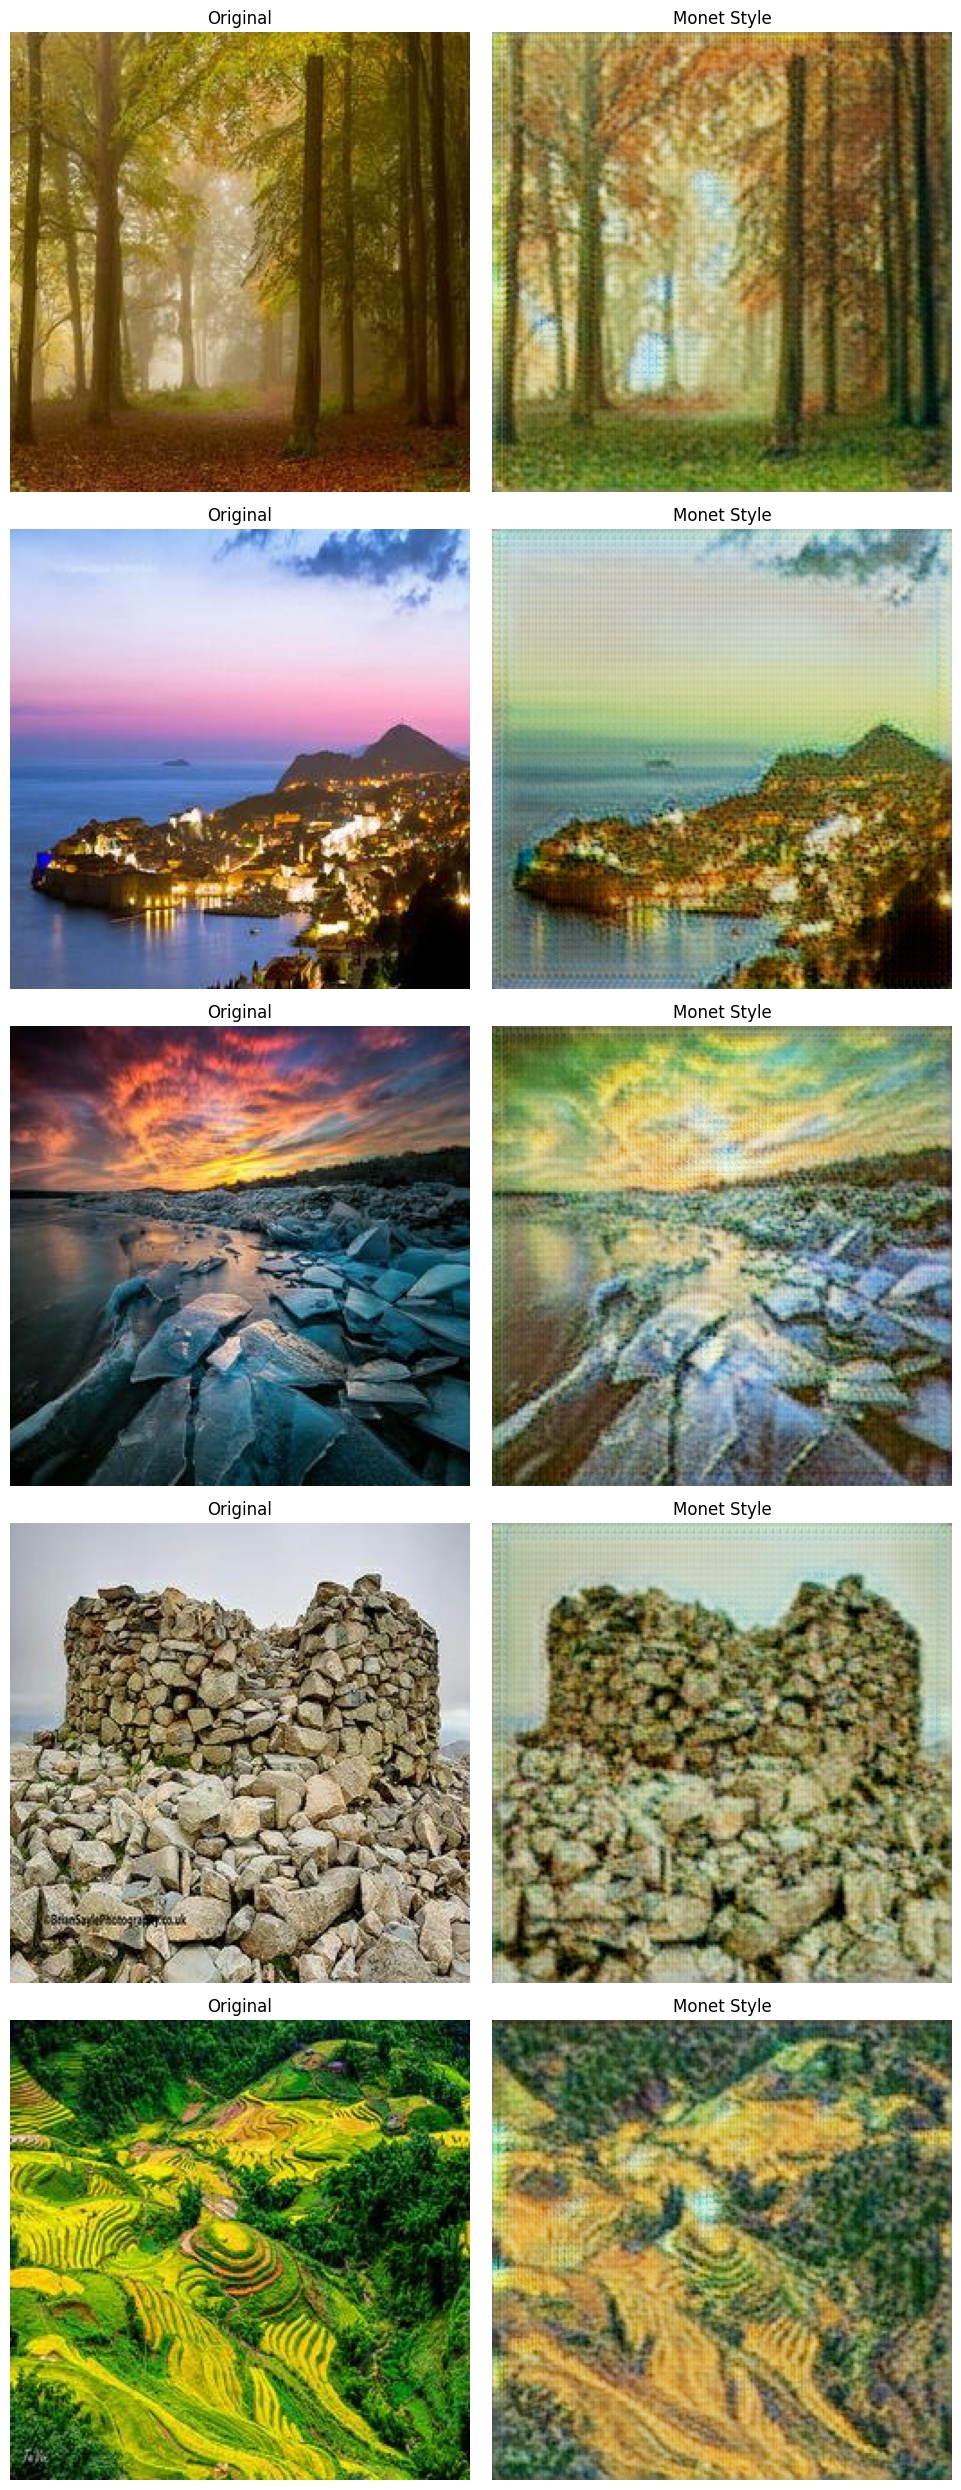

In [12]:
import matplotlib.pyplot as plt

# Initialize the Generator
generator_G = Generator().to(device)

# Load the saved weights
generator_G_path = r"/kaggle/working/saved_models/generator_G.pth"
generator_G.load_state_dict(torch.load(generator_G_path))
generator_G.eval()

# Set up the transforms
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

comparison_count = 0
plt.figure(figsize=(10, 5*5))  # Assuming we're comparing 5 images; Adjust the figure size as needed

for filename in os.listdir(photos_folder):
    if comparison_count == 5:  # We only want to compare five images
        break

    # Load and transform the image
    img_path = os.path.join(photos_folder, filename)
    image = Image.open(img_path).convert("RGB")
    original_image = transforms.Resize((256, 256))(image)
    image = transform(image).unsqueeze(0).to(device)  # Add batch dimension and move to GPU
    
    # Generate the Monet-styled image
    with torch.no_grad():
        generated_image = generator_G(image).squeeze(0).cpu()  # Remove batch dimension and move to CPU
    
    # Convert tensor to PIL image and save
    output_image = transforms.ToPILImage()(generated_image.clamp(0, 1))
    output_image_path = os.path.join(output_folder, f"monet_{filename}")
    output_image.save(output_image_path)

    # Plotting
    comparison_count += 1
    plt.subplot(5, 2, comparison_count*2 - 1)  # 5 rows, 2 columns, odd numbers for original images
    plt.imshow(original_image)
    plt.title("Original")
    plt.axis('off')
    
    plt.subplot(5, 2, comparison_count*2)  # 5 rows, 2 columns, even numbers for generated images
    plt.imshow(output_image)
    plt.title("Monet Style")
    plt.axis('off')

plt.tight_layout()
plt.show()

As we can see, there is a change in color and color intensity that are in a similar style to Monet. 

Below we export to a zip  for evaluation. 

In [13]:
import shutil

# Specify the paths
output_images_path = output_folder
if not os.path.exists(output_images_path):
    os.makedirs(model_save_dir)
zip_output_path = "/kaggle/working/images.zip"


# Create a zip file with the output images
shutil.make_archive(zip_output_path[:-4], 'zip', output_images_path)

# Move the zip file to the Kaggle output
shutil.move(zip_output_path[:-4] + ".zip", "/kaggle/working/images.zip")

print("Complete - saved to zip.")

Complete - saved to zip.


# Resources Used

Two primary resources were used: A post by Bjørn Hansen: https://towardsdatascience.com/cycle-gan-with-pytorch-ebe5db947a99
While running the model, I had several memory related issues. The discussion post for the contest by Tom 'Tikuntiku' helped improve model performance: https://www.kaggle.com/code/tikutiku/monet-cyclegan-starter-pytorch-xla/notebook  
